# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5 #0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 5


Using matplotlib, I look at the noisy time series I just simulated:

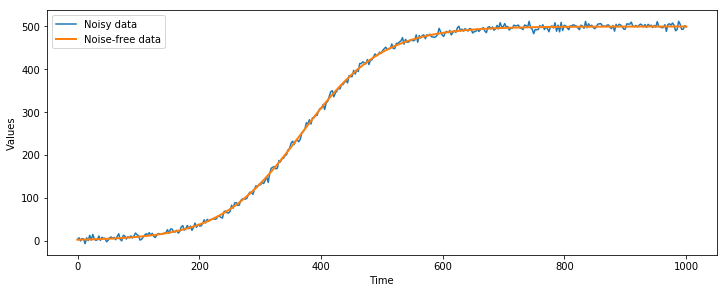

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

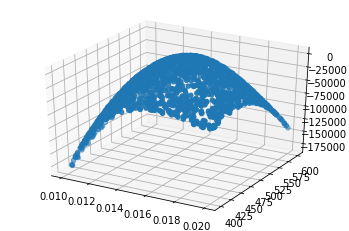

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_7 (Dense)              (None, 384)               147840    
__________

In [15]:
emu([0.015, 500])

array([[-1137.4252]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1229.5722214303034

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


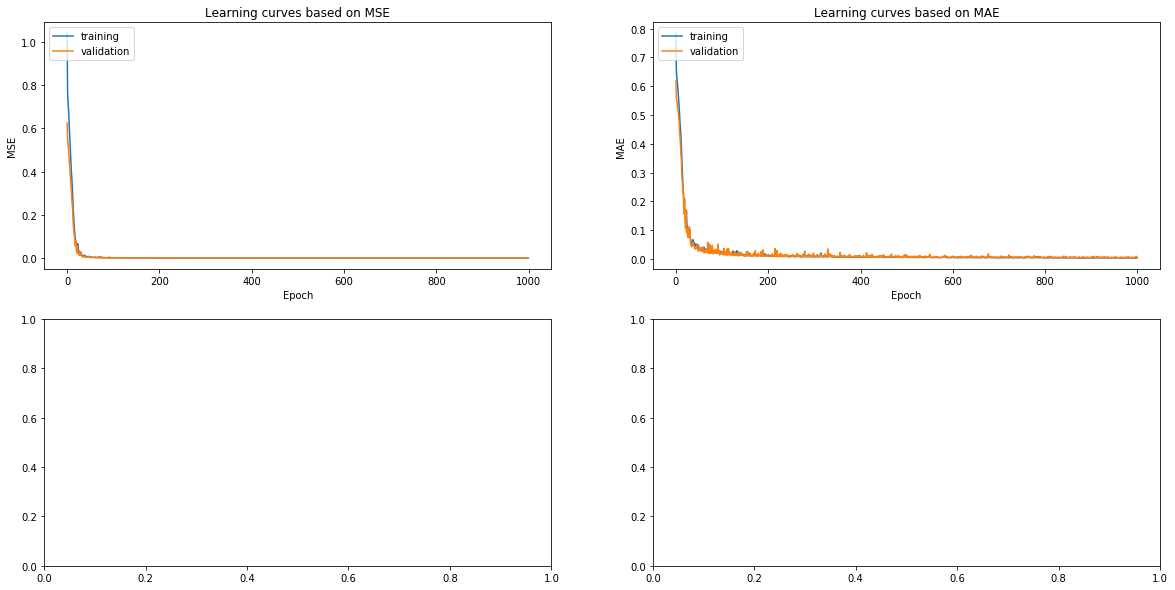

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 8.753161620309887e-05
Best epoch based on validation MSE: 994


Minimum MAE during validation: 0.004608011823147535
Best epoch based on validation MAE: 941


8.859746854189629e-05
0.00471119141827027


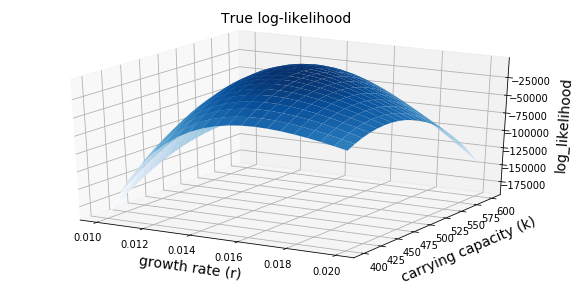

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

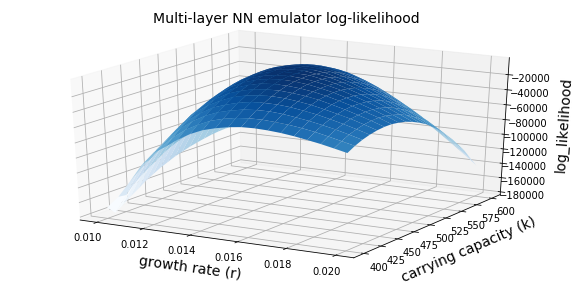

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.009174998045673781

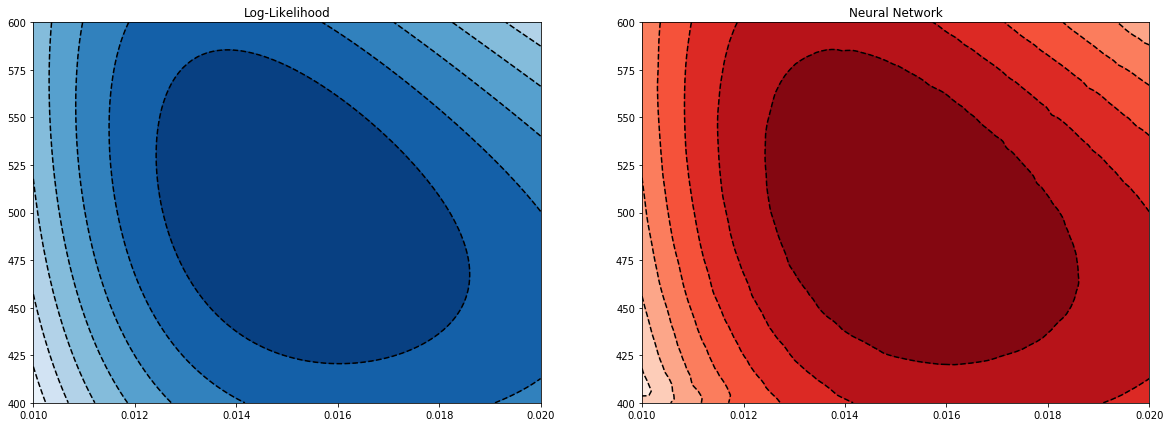

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

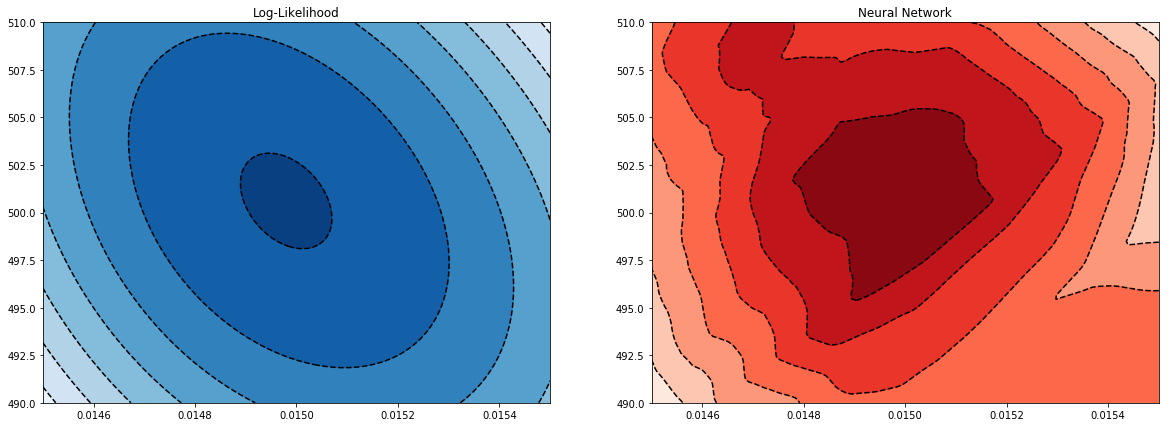

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]



 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]

[[ 8.10013295e-08 -6.89867070e-04]
 [-6.89867070e-04  8.57554333e+00]]


[[3.72428520e-09 6.05749649e-08]
 [6.05749649e-08 2.97158789e-03]]


[[4.54275284e-09 5.95263185e-07]
 [5.95263185e-07 6.78118604e-04]]


[[ 8.66496860e-08 -7.61633404e-04]
 [-7.61633404e-04  9.17841348e+00]]


[[3.37655669e-09 4.94092881e-08]
 [4.94092881e-08 2.88277995e-03]]


[[4.15761781e-09 5.95053805e-07]
 [5.95053805e-07 6.93038884e-04]]


[[ 7.93896911e-08 -6.55571329e-04]
 [-6.55571329e-04  1.00507631e+01]]


[[3.06851452e-09 1.94030856e-08]
 [1.94030856e-08 2.78776633e-03]]


[[3.80559762e-09 5.85218118e-07]
 [5.85218118e-07 6.92780601e-04]]


[[ 7.27457453e-08 -5.66535188e-04]
 [-5.66535188e-04  1.05372738e+01]]


[[ 2.79138640e-09 -3.14301602e-09]
 [-3.14301602e-09  2.67297997e-03]]


[[3.48414574e-09 5.68614093e-07]
 [5.68614093e-07 6.81562214e-04]]


[[ 7.01342844e-08 -6.11441139e-04]
 [-6.11441139e-04  1.19171131e+01]]


[[2.55061911e-09 3.99416796e-08]
 [3.99416796e-08 2.59296135e-03]]


[[3.190798

[[ 6.37451773e-09 -6.45143930e-05]
 [-6.45143930e-05  1.56492785e+01]]


[[ 1.38037780e-09 -8.77737779e-06]
 [-8.77737779e-06  5.80107168e-02]]


[[ 3.58349568e-09 -2.09416889e-05]
 [-2.09416889e-05  1.31833905e-01]]


[[ 6.05816327e-09 -6.11665297e-05]
 [-6.11665297e-05  1.48211090e+01]]


[[ 1.35988186e-09 -8.78110373e-06]
 [-8.78110373e-06  5.91122604e-02]]


[[ 3.76639946e-09 -2.27677047e-05]
 [-2.27677047e-05  1.47967898e-01]]


[[ 5.75773518e-09 -5.80031345e-05]
 [-5.80031345e-05  1.40402474e+01]]


[[ 1.42058117e-09 -9.36184325e-06]
 [-9.36184325e-06  6.42235404e-02]]


[[ 3.90078490e-09 -2.41895605e-05]
 [-2.41895605e-05  1.60818582e-01]]


[[ 5.92294918e-09 -6.39182354e-05]
 [-6.39182354e-05  1.34753476e+01]]


[[ 1.46436266e-09 -9.80339601e-06]
 [-9.80339601e-06  6.82072163e-02]]


[[ 4.17418760e-09 -2.67886750e-05]
 [-2.67886750e-05  1.83681064e-01]]


[[ 6.03147273e-09 -6.85909691e-05]
 [-6.85909691e-05  1.29250373e+01]]


[[ 1.52613414e-09 -1.05048257e-05]
 [-1.05048257e-0

[[ 3.27296286e-08 -3.98546603e-04]
 [-3.98546603e-04  4.96914459e+00]]


[[ 4.54096004e-10 -2.62174437e-06]
 [-2.62174437e-06  5.71689778e-01]]


[[ 5.79992371e-09 -3.61350522e-04]
 [-3.61350522e-04  3.65272795e+01]]


[[ 3.14290299e-08 -3.82774670e-04]
 [-3.82774670e-04  4.78464056e+00]]


[[ 4.39935895e-10 -2.21129915e-06]
 [-2.21129915e-06  5.73496924e-01]]


[[ 5.57221006e-09 -3.48835026e-04]
 [-3.48835026e-04  3.65719977e+01]]


[[ 3.01835562e-08 -3.67666152e-04]
 [-3.67666152e-04  4.60695216e+00]]


[[ 4.56097780e-10 -2.09525643e-06]
 [-2.09525643e-06  5.50851058e-01]]


[[ 5.52634038e-09 -3.22608898e-04]
 [-3.22608898e-04  3.60131901e+01]]


[[ 2.99638243e-08 -3.68997441e-04]
 [-3.68997441e-04  4.68341364e+00]]


[[ 4.43668340e-10 -1.77280961e-06]
 [-1.77280961e-06  5.39499766e-01]]


[[ 5.46896253e-09 -2.98447147e-04]
 [-2.98447147e-04  3.54095858e+01]]


[[ 2.96783287e-08 -3.69049762e-04]
 [-3.69049762e-04  4.73672109e+00]]


[[ 4.62231552e-10 -1.12327059e-06]
 [-1.12327059e-0

[[ 1.87995565e-07 -7.41452279e-04]
 [-7.41452279e-04  3.31337573e+02]]


[[ 2.32455306e-10 -1.79273547e-06]
 [-1.79273547e-06  1.55855266e-01]]


[[ 1.65707124e-09 -2.41517809e-06]
 [-2.41517809e-06  2.73246928e+00]]


[[ 1.83798912e-07 -6.41222106e-04]
 [-6.41222106e-04  3.23415748e+02]]


[[ 2.30927782e-10 -1.79158669e-06]
 [-1.79158669e-06  1.51302118e-01]]


[[ 1.60398127e-09 -2.30731068e-06]
 [-2.30731068e-06  2.64386400e+00]]


[[ 1.79621835e-07 -5.49346670e-04]
 [-5.49346670e-04  3.15580389e+02]]


[[ 2.29063892e-10 -1.78679420e-06]
 [-1.78679420e-06  1.46871834e-01]]


[[ 1.55265967e-09 -2.20503060e-06]
 [-2.20503060e-06  2.55827949e+00]]


[[ 1.75471933e-07 -4.65197558e-04]
 [-4.65197558e-04  3.07840758e+02]]


[[ 2.32920928e-10 -2.03089998e-06]
 [-2.03089998e-06  1.50162208e-01]]


[[ 1.50304629e-09 -2.10801127e-06]
 [-2.10801127e-06  2.47560826e+00]]


[[ 1.71355948e-07 -3.88192528e-04]
 [-3.88192528e-04  3.00204915e+02]]


[[ 2.35922426e-10 -2.24728782e-06]
 [-2.24728782e-0


[[ 2.45948614e-10 -1.38622255e-06]
 [-1.38622255e-06  3.02233851e-01]]


[[1.93565981e-08 1.63818702e-04]
 [1.63818702e-04 5.12230659e+01]]


[[ 2.05656144e-10 -2.21009404e-06]
 [-2.21009404e-06  1.51348436e-01]]


[[ 2.40087627e-10 -1.35072186e-06]
 [-1.35072186e-06  2.93673417e-01]]


[[1.88549123e-08 1.60241347e-04]
 [1.60241347e-04 4.97941491e+01]]


[[ 2.00401305e-10 -2.21943234e-06]
 [-2.21943234e-06  1.56142467e-01]]


[[ 2.34339682e-10 -1.31606959e-06]
 [-1.31606959e-06  2.85368229e-01]]


[[1.83655848e-08 1.56711321e-04]
 [1.56711321e-04 4.84066141e+01]]


[[ 1.95271619e-10 -2.22448746e-06]
 [-2.22448746e-06  1.60287882e-01]]


[[ 2.28704774e-10 -1.28225122e-06]
 [-1.28225122e-06  2.77310292e-01]]


[[1.78883777e-08 1.53230543e-04]
 [1.53230543e-04 4.70592351e+01]]


[[ 1.90264963e-10 -2.22562259e-06]
 [-2.22562259e-06  1.63833919e-01]]


[[ 2.23182694e-10 -1.24925198e-06]
 [-1.24925198e-06  2.69491873e-01]]


[[1.74230519e-08 1.49800669e-04]
 [1.49800669e-04 4.57508222e+01]]

[[2.08391560e-09 1.88813719e-05]
 [1.88813719e-05 5.12147739e+00]]


[[ 2.06481855e-10 -1.81201985e-06]
 [-1.81201985e-06  1.50013023e-01]]


[[ 1.04518209e-10 -1.11598353e-06]
 [-1.11598353e-06  1.44855121e-01]]


[[2.03257806e-09 1.83700399e-05]
 [1.83700399e-05 4.99445512e+00]]


[[ 2.06643964e-10 -1.84148437e-06]
 [-1.84148437e-06  1.47304305e-01]]


[[ 1.07250216e-10 -1.16281450e-06]
 [-1.16281450e-06  1.42270640e-01]]


[[1.98254611e-09 1.78740371e-05]
 [1.78740371e-05 4.87070621e+00]]


[[ 2.06538382e-10 -1.86647760e-06]
 [-1.86647760e-06  1.44615003e-01]]


[[ 1.09646182e-10 -1.20472095e-06]
 [-1.20472095e-06  1.39702554e-01]]


[[1.93378605e-09 1.73928459e-05]
 [1.73928459e-05 4.75014391e+00]]


[[ 2.06185805e-10 -1.88730967e-06]
 [-1.88730967e-06  1.41947201e-01]]


[[ 1.11728729e-10 -1.24202536e-06]
 [-1.24202536e-06  1.37153018e-01]]


[[1.88626502e-09 1.69259683e-05]
 [1.69259683e-05 4.63268377e+00]]


[[ 2.05605645e-10 -1.90427214e-06]
 [-1.90427214e-06  1.39302788e-01]]


 [-2.26932084e-06  9.80996495e-02]]


[[ 1.39511413e-10 -1.67788088e-06]
 [-1.67788088e-06  1.12724664e-01]]


[[3.88099027e-10 5.95059653e-07]
 [5.95059653e-07 7.82415278e-01]]


[[ 2.33871375e-10 -2.23512512e-06]
 [-2.23512512e-06  9.60394736e-02]]


[[ 1.36421587e-10 -1.66048683e-06]
 [-1.66048683e-06  1.16093161e-01]]


[[3.79451035e-10 5.61206180e-07]
 [5.61206180e-07 7.67499595e-01]]


[[ 2.30315339e-10 -2.20097013e-06]
 [-2.20097013e-06  9.40208869e-02]]


[[ 1.33401855e-10 -1.64258295e-06]
 [-1.64258295e-06  1.19116888e-01]]


[[3.71001631e-10 5.29066634e-07]
 [5.29066634e-07 7.52811880e-01]]


[[ 2.26765931e-10 -2.16689009e-06]
 [-2.16689009e-06  9.20431903e-02]]


[[ 1.34418302e-10 -1.52246892e-06]
 [-1.52246892e-06  1.18130121e-01]]


[[3.63065956e-10 5.08701080e-07]
 [5.08701080e-07 7.35943787e-01]]


[[ 2.23226533e-10 -2.13291668e-06]
 [-2.13291668e-06  9.01056874e-02]]


[[ 1.35230734e-10 -1.40890030e-06]
 [-1.40890030e-06  1.17090555e-01]]


[[3.55088460e-10 5.18180566e-

 [-2.03532635e-07  1.28863724e-01]]


[[2.43015232e-10 4.17398360e-07]
 [4.17398360e-07 2.56362256e-01]]


[[ 1.93730131e-10 -8.23487097e-07]
 [-8.23487097e-07  1.89611605e-01]]


[[ 1.08736158e-10 -3.36345460e-07]
 [-3.36345460e-07  1.31185822e-01]]


[[2.44157256e-10 5.74061044e-07]
 [5.74061044e-07 2.55444411e-01]]


[[ 1.93270302e-10 -7.68485064e-07]
 [-7.68485064e-07  1.86071013e-01]]


[[ 1.10074559e-10 -4.60644674e-07]
 [-4.60644674e-07  1.33252040e-01]]


[[2.43132787e-10 5.63608311e-07]
 [5.63608311e-07 2.50138391e-01]]


[[ 2.00338913e-10 -9.11879674e-07]
 [-9.11879674e-07  1.84496862e-01]]


[[ 1.11236294e-10 -5.76859330e-07]
 [-5.76859330e-07  1.35076795e-01]]


[[2.41964434e-10 5.53321911e-07]
 [5.53321911e-07 2.44947463e-01]]


[[ 1.98850705e-10 -1.00723335e-06]
 [-1.00723335e-06  1.85559623e-01]]


[[ 1.12231550e-10 -6.85398234e-07]
 [-6.85398234e-07  1.36673792e-01]]


[[2.40662414e-10 5.43200611e-07]
 [5.43200611e-07 2.39869023e-01]]


[[ 1.97285293e-10 -1.09583476e-06

 [-4.66063507e-07  1.01992359e-01]]


[[ 1.44193860e-10 -1.79879022e-06]
 [-1.79879022e-06  1.22735559e-01]]


[[ 1.44206710e-10 -2.03830071e-06]
 [-2.03830071e-06  2.03243710e-01]]


[[ 2.24042678e-10 -4.48329218e-07]
 [-4.48329218e-07  1.00114921e-01]]


[[ 1.45259275e-10 -1.84928664e-06]
 [-1.84928664e-06  1.22249726e-01]]


[[ 1.42209203e-10 -2.05812378e-06]
 [-2.05812378e-06  2.03763220e-01]]


[[ 2.20488420e-10 -4.31285826e-07]
 [-4.31285826e-07  9.82717067e-02]]


[[ 1.42536831e-10 -1.82122793e-06]
 [-1.82122793e-06  1.20590379e-01]]


[[ 1.40221805e-10 -2.07528634e-06]
 [-2.07528634e-06  2.04102443e-01]]


[[ 2.16976169e-10 -4.14905818e-07]
 [-4.14905818e-07  9.64621373e-02]]


[[ 1.39806302e-10 -1.78432539e-06]
 [-1.78432539e-06  1.18410553e-01]]


[[ 1.38245478e-10 -2.08993231e-06]
 [-2.08993231e-06  2.04271778e-01]]


[[ 2.13506198e-10 -3.99162805e-07]
 [-3.99162805e-07  9.46856426e-02]]


[[ 1.41194635e-10 -1.83594585e-06]
 [-1.83594585e-06  1.17938978e-01]]


[[ 1.36281114

 [-2.41188191e-06  1.82300931e-01]]


[[ 1.87929139e-10 -1.90136247e-06]
 [-1.90136247e-06  1.02717835e-01]]


[[ 1.46398406e-10 -2.26180534e-06]
 [-2.26180534e-06  1.15967643e-01]]


[[ 1.38791281e-10 -2.32189488e-06]
 [-2.32189488e-06  1.79202877e-01]]


[[ 1.87307070e-10 -1.98344652e-06]
 [-1.98344652e-06  1.05739990e-01]]


[[ 1.44760798e-10 -2.26873440e-06]
 [-2.26873440e-06  1.16130968e-01]]


[[ 1.46478246e-10 -2.23526286e-06]
 [-2.23526286e-06  1.76155932e-01]]


[[ 1.86597092e-10 -2.05980943e-06]
 [-2.05980943e-06  1.08530283e-01]]


[[ 1.47649359e-10 -2.34099301e-06]
 [-2.34099301e-06  1.16360853e-01]]


[[ 1.53655363e-10 -2.15185950e-06]
 [-2.15185950e-06  1.73159358e-01]]


[[ 1.85804566e-10 -2.13071578e-06]
 [-2.13071578e-06  1.11099645e-01]]


[[ 1.50286344e-10 -2.40783446e-06]
 [-2.40783446e-06  1.16502952e-01]]


[[ 1.60345942e-10 -2.07156327e-06]
 [-2.07156327e-06  1.70212424e-01]]


[[ 1.82451509e-10 -2.09165035e-06]
 [-2.09165035e-06  1.09184713e-01]]


[[ 1.52683876

[[ 1.77860667e-10 -1.13394755e-06]
 [-1.13394755e-06  1.21843880e-01]]


[[ 1.28336225e-10 -1.89071909e-06]
 [-1.89071909e-06  1.32622305e-01]]


[[ 1.00039738e-10 -1.64299173e-06]
 [-1.64299173e-06  1.11172095e-01]]


[[ 1.75333895e-10 -1.10346765e-06]
 [-1.10346765e-06  1.20019954e-01]]


[[ 1.29496284e-10 -1.94610873e-06]
 [-1.94610873e-06  1.32658070e-01]]


[[ 9.89978881e-11 -1.66649513e-06]
 [-1.66649513e-06  1.13288489e-01]]


[[ 1.72834939e-10 -1.07390357e-06]
 [-1.07390357e-06  1.18219861e-01]]


[[ 1.30599190e-10 -2.09782901e-06]
 [-2.09782901e-06  1.40735914e-01]]


[[ 9.79521899e-11 -1.68784826e-06]
 [-1.68784826e-06  1.15232353e-01]]


[[ 1.70363870e-10 -1.04522554e-06]
 [-1.04522554e-06  1.16443452e-01]]


[[ 1.31571274e-10 -2.24064315e-06]
 [-2.24064315e-06  1.48322941e-01]]


[[ 9.81682797e-11 -1.61608729e-06]
 [-1.61608729e-06  1.14260129e-01]]


[[ 1.69827294e-10 -1.05686244e-06]
 [-1.05686244e-06  1.14832088e-01]]


[[ 1.34209367e-10 -2.22998134e-06]
 [-2.22998134e-0

 [-1.09900282e-06  1.27549547e-01]]


[[ 1.47374148e-10 -1.99842286e-06]
 [-1.99842286e-06  1.13892896e-01]]


[[ 1.75558167e-10 -2.26386465e-06]
 [-2.26386465e-06  1.11059492e-01]]


[[ 1.06439950e-10 -1.06370696e-06]
 [-1.06370696e-06  1.26228774e-01]]


[[ 1.45065768e-10 -1.95118662e-06]
 [-1.95118662e-06  1.15759756e-01]]


[[ 1.78313339e-10 -2.42404001e-06]
 [-2.42404001e-06  1.16202628e-01]]


[[ 1.05140608e-10 -1.02956159e-06]
 [-1.02956159e-06  1.24906762e-01]]


[[ 1.49208702e-10 -2.08860025e-06]
 [-2.08860025e-06  1.18298809e-01]]


[[ 1.80844971e-10 -2.57528468e-06]
 [-2.57528468e-06  1.21039366e-01]]


[[ 1.03849835e-10 -9.96528582e-07]
 [-9.96528582e-07  1.23584291e-01]]


[[ 1.54786289e-10 -2.31546748e-06]
 [-2.31546748e-06  1.24903111e-01]]


[[ 1.83162684e-10 -2.71795603e-06]
 [-2.71795603e-06  1.25582159e-01]]


[[ 1.02567906e-10 -9.64571096e-07]
 [-9.64571096e-07  1.22262096e-01]]


[[ 1.60017133e-10 -2.53026578e-06]
 [-2.53026578e-06  1.31126684e-01]]


[[ 1.85275742

[[ 1.93175096e-10 -2.94829551e-06]
 [-2.94829551e-06  2.03518099e-01]]


[[1.72816376e-10 2.99385351e-07]
 [2.99385351e-07 1.71258123e-01]]


[[ 1.90058047e-10 -3.52552701e-06]
 [-3.52552701e-06  1.90287195e-01]]


[[ 1.94195618e-10 -2.81633634e-06]
 [-2.81633634e-06  2.02299477e-01]]


[[1.70775483e-10 2.74940803e-07]
 [2.74940803e-07 1.69293625e-01]]


[[ 1.88626822e-10 -3.41009996e-06]
 [-3.41009996e-06  1.89939483e-01]]


[[ 1.95079291e-10 -2.68910491e-06]
 [-2.68910491e-06  2.01042657e-01]]


[[1.68748673e-10 2.51486134e-07]
 [2.51486134e-07 1.67340406e-01]]


[[ 1.86236562e-10 -3.41488748e-06]
 [-3.41488748e-06  1.93603211e-01]]


[[ 1.95832089e-10 -2.56644218e-06]
 [-2.56644218e-06  1.99750040e-01]]


[[1.66736279e-10 2.28986506e-07]
 [2.28986506e-07 1.65398894e-01]]


[[ 1.83869222e-10 -3.41787417e-06]
 [-3.41787417e-06  1.97009862e-01]]


[[ 1.94752520e-10 -2.58837352e-06]
 [-2.58837352e-06  1.98652950e-01]]


[[1.64738611e-10 2.07408254e-07]
 [2.07408254e-07 1.63469490e-01]]


[[ 1.46397388e-10 -6.73599825e-07]
 [-6.73599825e-07  1.31563099e-01]]


[[ 1.72583730e-10 -1.96361714e-06]
 [-1.96361714e-06  1.70871433e-01]]


[[ 2.18243407e-10 -4.19965196e-06]
 [-4.19965196e-06  2.16936764e-01]]


[[ 1.46734833e-10 -7.32616802e-07]
 [-7.32616802e-07  1.31564719e-01]]


[[ 1.72675030e-10 -1.98067223e-06]
 [-1.98067223e-06  1.69182617e-01]]


[[ 2.17474159e-10 -4.24305898e-06]
 [-4.24305898e-06  2.18315419e-01]]


[[ 1.46995831e-10 -7.88755291e-07]
 [-7.88755291e-07  1.31510902e-01]]


[[ 1.72689687e-10 -1.99615103e-06]
 [-1.99615103e-06  1.67496150e-01]]


[[ 2.16646890e-10 -4.28279000e-06]
 [-4.28279000e-06  2.19542158e-01]]


[[ 1.47183671e-10 -8.42118632e-07]
 [-8.42118632e-07  1.31404139e-01]]


[[ 1.72631106e-10 -2.01011690e-06]
 [-2.01011690e-06  1.65812675e-01]]


[[ 2.15764552e-10 -4.31899115e-06]
 [-4.31899115e-06  2.20623205e-01]]


[[ 1.47301527e-10 -8.92806752e-07]
 [-8.92806752e-07  1.31246836e-01]]


[[ 1.72502575e-10 -2.02263101e-06]
 [-2.02263101e-0

 [-2.14332435e-06  1.62371478e-01]]


[[ 1.42453035e-10 -1.96567904e-06]
 [-1.96567904e-06  1.24729444e-01]]


[[ 1.58670503e-10 -1.17798796e-06]
 [-1.17798796e-06  1.03534782e-01]]


[[ 1.30149897e-10 -2.10107531e-06]
 [-2.10107531e-06  1.60704193e-01]]


[[ 1.41896040e-10 -1.90353178e-06]
 [-1.90353178e-06  1.23832582e-01]]


[[ 1.56778499e-10 -1.15295913e-06]
 [-1.15295913e-06  1.02320300e-01]]


[[ 1.28581172e-10 -2.05977772e-06]
 [-2.05977772e-06  1.59044391e-01]]


[[ 1.51032399e-10 -1.85753415e-06]
 [-1.85753415e-06  1.22139996e-01]]


[[ 1.54904895e-10 -1.12852934e-06]
 [-1.12852934e-06  1.01116978e-01]]


[[ 1.27028247e-10 -2.01940778e-06]
 [-2.01940778e-06  1.57392425e-01]]


[[ 1.59729502e-10 -1.81273811e-06]
 [-1.81273811e-06  1.20470876e-01]]


[[ 1.53049667e-10 -1.10468296e-06]
 [-1.10468296e-06  9.99248297e-02]]


[[ 1.26953546e-10 -1.95068740e-06]
 [-1.95068740e-06  1.56169907e-01]]


[[ 1.68002548e-10 -1.76911061e-06]
 [-1.76911061e-06  1.18824899e-01]]


[[ 1.51212784

[[ 1.24035020e-10 -4.09421873e-07]
 [-4.09421873e-07  1.52425310e-01]]


[[ 1.57889854e-10 -2.15590561e-06]
 [-2.15590561e-06  1.55478842e-01]]


[[ 1.34022549e-10 -1.44702739e-06]
 [-1.44702739e-06  1.02871918e-01]]


[[ 1.22608642e-10 -3.83371735e-07]
 [-3.83371735e-07  1.52185585e-01]]


[[ 1.57192818e-10 -2.17052269e-06]
 [-2.17052269e-06  1.54730868e-01]]


[[ 1.32375690e-10 -1.41360900e-06]
 [-1.41360900e-06  1.02825328e-01]]


[[ 1.21195763e-10 -3.58228826e-07]
 [-3.58228826e-07  1.51901287e-01]]


[[ 1.56467748e-10 -2.18378141e-06]
 [-2.18378141e-06  1.53957777e-01]]


[[ 1.30747686e-10 -1.38102628e-06]
 [-1.38102628e-06  1.02743998e-01]]


[[ 1.19796360e-10 -3.33965411e-07]
 [-3.33965411e-07  1.51574345e-01]]


[[ 1.55716063e-10 -2.19573242e-06]
 [-2.19573242e-06  1.53160886e-01]]


[[ 1.29864906e-10 -1.31024293e-06]
 [-1.31024293e-06  1.04525763e-01]]


[[ 1.18410402e-10 -3.10554569e-07]
 [-3.10554569e-07  1.51206627e-01]]


[[ 1.54939132e-10 -2.20642476e-06]
 [-2.20642476e-0

[[ 1.56022054e-10 -3.08410279e-06]
 [-3.08410279e-06  1.62853927e-01]]


[[ 1.43279674e-10 -1.73086782e-06]
 [-1.73086782e-06  1.84390696e-01]]


[[ 1.36127938e-10 -7.12279682e-07]
 [-7.12279682e-07  7.98360969e-02]]


[[ 1.55632519e-10 -3.10253524e-06]
 [-3.10253524e-06  1.62842483e-01]]


[[ 1.41593624e-10 -1.72701367e-06]
 [-1.72701367e-06  1.84139721e-01]]


[[ 1.35643485e-10 -6.22834154e-07]
 [-6.22834154e-07  8.38820387e-02]]


[[ 1.55206663e-10 -3.11923305e-06]
 [-3.11923305e-06  1.62777753e-01]]


[[ 1.39925908e-10 -1.72273881e-06]
 [-1.72273881e-06  1.83837721e-01]]


[[ 1.35132997e-10 -5.36632165e-07]
 [-5.36632165e-07  8.77443246e-02]]


[[ 1.54746062e-10 -3.13425877e-06]
 [-3.13425877e-06  1.62661860e-01]]


[[ 1.38276381e-10 -1.71806129e-06]
 [-1.71806129e-06  1.83486809e-01]]


[[ 1.34597674e-10 -4.53575814e-07]
 [-4.53575814e-07  9.14288501e-02]]


[[ 1.54252246e-10 -3.14767304e-06]
 [-3.14767304e-06  1.62496857e-01]]


[[ 1.36644898e-10 -1.71299858e-06]
 [-1.71299858e-0



[[ 2.03479348e-10 -2.95425417e-06]
 [-2.95425417e-06  2.23756599e-01]]


[[ 1.68474217e-10 -4.32347477e-06]
 [-4.32347477e-06  2.33577983e-01]]


[[ 1.55988956e-10 -2.24247483e-07]
 [-2.24247483e-07  1.52244653e-01]]


[[ 2.06859201e-10 -2.91106563e-06]
 [-2.91106563e-06  2.20977471e-01]]


[[ 1.66508618e-10 -4.28004176e-06]
 [-4.28004176e-06  2.31491222e-01]]


[[ 1.55188361e-10 -2.17259011e-07]
 [-2.17259011e-07  1.50365210e-01]]


[[ 2.10049405e-10 -2.86859032e-06]
 [-2.86859032e-06  2.18233875e-01]]


[[ 1.64565017e-10 -4.23690999e-06]
 [-4.23690999e-06  2.29410980e-01]]


[[ 1.54369846e-10 -2.10464038e-07]
 [-2.10464038e-07  1.48509521e-01]]


[[ 2.14258570e-10 -2.94844957e-06]
 [-2.94844957e-06  2.17475735e-01]]


[[ 1.62519152e-10 -4.18425028e-06]
 [-4.18425028e-06  2.26559358e-01]]


[[ 1.53534357e-10 -2.03857397e-07]
 [-2.03857397e-07  1.46677281e-01]]


[[ 2.18245131e-10 -3.02442870e-06]
 [-3.02442870e-06  2.16678974e-01]]


[[ 1.60499522e-10 -4.13226548e-06]
 [-4.13226548e

 [-3.58826417e-06  2.38115028e-01]]


[[ 1.18681249e-10 -2.18156381e-07]
 [-2.18156381e-07  6.38707908e-02]]


[[ 2.29337383e-10 -2.69710446e-06]
 [-2.69710446e-06  2.09400572e-01]]


[[ 1.34997667e-10 -3.54087532e-06]
 [-3.54087532e-06  2.36564942e-01]]


[[ 1.17348646e-10 -2.22347446e-07]
 [-2.22347446e-07  6.35784236e-02]]


[[ 2.26624804e-10 -2.66508037e-06]
 [-2.66508037e-06  2.06881824e-01]]


[[ 1.33384375e-10 -3.49417465e-06]
 [-3.49417465e-06  2.35002542e-01]]


[[ 1.16030268e-10 -2.26323202e-07]
 [-2.26323202e-07  6.32782658e-02]]


[[ 2.23944712e-10 -2.63344281e-06]
 [-2.63344281e-06  2.04394266e-01]]


[[ 1.31790814e-10 -3.44815092e-06]
 [-3.44815092e-06  2.33428753e-01]]


[[ 1.14725990e-10 -2.30090373e-07]
 [-2.30090373e-07  6.29706946e-02]]


[[ 2.21296719e-10 -2.60218710e-06]
 [-2.60218710e-06  2.01937499e-01]]


[[ 1.30216740e-10 -3.40279312e-06]
 [-3.40279312e-06  2.31844469e-01]]


[[ 1.13435685e-10 -2.33655495e-07]
 [-2.33655495e-07  6.26560755e-02]]


[[ 2.19077449

 [-2.42080055e-06  1.61999275e-01]]


[[ 1.07388502e-10 -1.52656570e-06]
 [-1.52656570e-06  1.24690784e-01]]


[[ 2.01273473e-10 -2.86356607e-06]
 [-2.86356607e-06  1.73003232e-01]]


[[ 1.09804624e-10 -2.40404902e-06]
 [-2.40404902e-06  1.60385281e-01]]


[[ 1.06161364e-10 -1.49673912e-06]
 [-1.49673912e-06  1.28427475e-01]]


[[ 2.02434554e-10 -2.84915496e-06]
 [-2.84915496e-06  1.71085018e-01]]


[[ 1.08577426e-10 -2.37256039e-06]
 [-2.37256039e-06  1.58721585e-01]]


[[ 1.08679695e-10 -1.52041733e-06]
 [-1.52041733e-06  1.27378156e-01]]


[[ 2.00642178e-10 -2.85199553e-06]
 [-2.85199553e-06  1.71366846e-01]]


[[ 1.07363714e-10 -2.34152987e-06]
 [-2.34152987e-06  1.57073048e-01]]


[[ 1.14021971e-10 -1.56362758e-06]
 [-1.56362758e-06  1.26452990e-01]]


[[ 1.98858098e-10 -2.85396363e-06]
 [-2.85396363e-06  1.71592363e-01]]


[[ 1.06163352e-10 -2.31094993e-06]
 [-2.31094993e-06  1.55439597e-01]]


[[ 1.19146585e-10 -1.60490356e-06]
 [-1.60490356e-06  1.25525914e-01]]


[[ 1.97082523

[[ 2.09554706e-10 -2.22375660e-06]
 [-2.22375660e-06  1.20580705e-01]]


[[ 1.28600735e-10 -9.65916044e-07]
 [-9.65916044e-07  9.91142972e-02]]


[[ 1.96382185e-10 -2.53462470e-06]
 [-2.53462470e-06  1.92301491e-01]]


[[ 2.08293563e-10 -2.20645755e-06]
 [-2.20645755e-06  1.19269902e-01]]


[[ 1.27142912e-10 -9.54821231e-07]
 [-9.54821231e-07  9.84425440e-02]]


[[ 2.04796535e-10 -2.71362402e-06]
 [-2.71362402e-06  1.94176976e-01]]


[[ 2.07022037e-10 -2.18918228e-06]
 [-2.18918228e-06  1.17973137e-01]]


[[ 1.26653488e-10 -9.45954569e-07]
 [-9.45954569e-07  9.73309553e-02]]


[[ 2.05102887e-10 -2.69503186e-06]
 [-2.69503186e-06  1.92032746e-01]]


[[ 2.05740828e-10 -2.17193455e-06]
 [-2.17193455e-06  1.16690273e-01]]


[[ 1.26148349e-10 -9.37147391e-07]
 [-9.37147391e-07  9.62322503e-02]]


[[ 2.05346496e-10 -2.67638283e-06]
 [-2.67638283e-06  1.89912274e-01]]


[[ 2.04450610e-10 -2.15471802e-06]
 [-2.15471802e-06  1.15421169e-01]]


[[ 1.25628173e-10 -9.28399987e-07]
 [-9.28399987e-0

 [-2.01099138e-06  1.08880597e-01]]


[[ 2.63460055e-10 -2.77616812e-07]
 [-2.77616812e-07  9.69767203e-02]]


[[ 1.82695093e-10 -2.14444011e-06]
 [-2.14444011e-06  1.93183451e-01]]


[[ 1.70824287e-10 -2.00091124e-06]
 [-2.00091124e-06  1.07722045e-01]]


[[ 2.64728605e-10 -3.03153402e-07]
 [-3.03153402e-07  9.61034958e-02]]


[[ 1.82411008e-10 -2.18236378e-06]
 [-2.18236378e-06  1.93244358e-01]]


[[ 1.72354944e-10 -1.99068053e-06]
 [-1.99068053e-06  1.06575723e-01]]


[[ 2.65081139e-10 -3.59437006e-07]
 [-3.59437006e-07  9.61313858e-02]]


[[ 1.85624199e-10 -2.20339149e-06]
 [-2.20339149e-06  1.91503550e-01]]


[[ 1.73793455e-10 -1.98030688e-06]
 [-1.98030688e-06  1.05441510e-01]]


[[ 2.65358029e-10 -4.13775826e-07]
 [-4.13775826e-07  9.61351438e-02]]


[[ 1.88686499e-10 -2.22319302e-06]
 [-2.22319302e-06  1.89773969e-01]]


[[ 1.75142560e-10 -1.96979773e-06]
 [-1.96979773e-06  1.04319284e-01]]


[[ 2.65561752e-10 -4.66221590e-07]
 [-4.66221590e-07  9.61155806e-02]]


[[ 1.91602212


[[ 1.50337449e-10 -1.33979700e-06]
 [-1.33979700e-06  9.26432295e-02]]


[[ 2.32198026e-10 -8.10614043e-07]
 [-8.10614043e-07  1.33848893e-01]]


[[ 2.74726829e-10 -2.28716395e-06]
 [-2.28716395e-06  1.67950090e-01]]


[[ 1.48883614e-10 -1.32563587e-06]
 [-1.32563587e-06  9.16492391e-02]]


[[ 2.32129683e-10 -8.40901151e-07]
 [-8.40901151e-07  1.33039498e-01]]


[[ 2.71851308e-10 -2.26481600e-06]
 [-2.26481600e-06  1.66213838e-01]]


[[ 1.47314514e-10 -1.31357358e-06]
 [-1.31357358e-06  9.08309623e-02]]


[[ 2.32010382e-10 -8.70021979e-07]
 [-8.70021979e-07  1.32225660e-01]]


[[ 2.69005983e-10 -2.24266790e-06]
 [-2.24266790e-06  1.64495344e-01]]


[[ 1.45762132e-10 -1.30159837e-06]
 [-1.30159837e-06  9.00181980e-02]]


[[ 2.31841821e-10 -8.98007771e-07]
 [-8.98007771e-07  1.31407719e-01]]


[[ 2.67069873e-10 -2.19952375e-06]
 [-2.19952375e-06  1.63114950e-01]]


[[ 1.44226291e-10 -1.28971023e-06]
 [-1.28971023e-06  8.92109599e-02]]


[[ 2.29361343e-10 -8.86080552e-07]
 [-8.86080552e-

 [-1.51235085e-06  1.46234593e-01]]


[[ 1.15377980e-10 -1.54300202e-06]
 [-1.54300202e-06  9.07055409e-02]]


[[ 2.50672038e-10 -3.37920306e-06]
 [-3.37920306e-06  1.65863948e-01]]


[[ 2.16652852e-10 -1.55037610e-06]
 [-1.55037610e-06  1.46125555e-01]]


[[ 1.14557664e-10 -1.53699156e-06]
 [-1.53699156e-06  9.00233631e-02]]


[[ 2.50506700e-10 -3.39790801e-06]
 [-3.39790801e-06  1.65320036e-01]]


[[ 2.16388265e-10 -1.58687420e-06]
 [-1.58687420e-06  1.45988201e-01]]


[[ 1.13738162e-10 -1.53083568e-06]
 [-1.53083568e-06  8.93430006e-02]]


[[ 2.50292174e-10 -3.41529013e-06]
 [-3.41529013e-06  1.64757272e-01]]


[[ 2.15602320e-10 -1.56852499e-06]
 [-1.56852499e-06  1.44465660e-01]]


[[ 1.13774048e-10 -1.58530235e-06]
 [-1.58530235e-06  9.24670654e-02]]


[[ 2.50030077e-10 -3.43138767e-06]
 [-3.43138767e-06  1.64176384e-01]]


[[ 2.14794207e-10 -1.55040974e-06]
 [-1.55040974e-06  1.42959426e-01]]


[[ 1.13784151e-10 -1.63772168e-06]
 [-1.63772168e-06  9.54733668e-02]]


[[ 2.49721984

 [-2.69061274e-06  1.57236752e-01]]


[[ 2.11863161e-10 -2.51400297e-06]
 [-2.51400297e-06  1.78545442e-01]]


[[ 1.66869840e-10 -1.11380914e-06]
 [-1.11380914e-06  1.06943187e-01]]


[[ 1.32575789e-10 -2.66344465e-06]
 [-2.66344465e-06  1.55632138e-01]]


[[ 2.09992806e-10 -2.51797325e-06]
 [-2.51797325e-06  1.79727859e-01]]


[[ 1.65425013e-10 -1.10068704e-06]
 [-1.10068704e-06  1.05863475e-01]]


[[ 1.31466633e-10 -2.63655561e-06]
 [-2.63655561e-06  1.54044354e-01]]


[[ 2.08136145e-10 -2.52130038e-06]
 [-2.52130038e-06  1.80836875e-01]]


[[ 1.63990100e-10 -1.08773822e-06]
 [-1.08773822e-06  1.04794850e-01]]


[[ 1.30364166e-10 -2.60994274e-06]
 [-2.60994274e-06  1.52473218e-01]]


[[ 2.06293151e-10 -2.52400368e-06]
 [-2.52400368e-06  1.81874535e-01]]


[[ 1.62565100e-10 -1.07496006e-06]
 [-1.07496006e-06  1.03737198e-01]]


[[ 1.29268418e-10 -2.58360318e-06]
 [-2.58360318e-06  1.50918550e-01]]


[[ 2.04463796e-10 -2.52610199e-06]
 [-2.52610199e-06  1.82842837e-01]]


[[ 1.61044908

[[ 1.43070680e-10 -1.96360111e-06]
 [-1.96360111e-06  1.44129783e-01]]


[[ 1.53107368e-10 -2.41159462e-06]
 [-2.41159462e-06  1.47814198e-01]]


[[ 1.43358834e-10 -1.26850292e-06]
 [-1.26850292e-06  1.38136418e-01]]


[[ 1.41905284e-10 -1.96698664e-06]
 [-1.96698664e-06  1.44712283e-01]]


[[ 1.52166683e-10 -2.40466452e-06]
 [-2.40466452e-06  1.46840351e-01]]


[[ 1.44624169e-10 -1.31861298e-06]
 [-1.31861298e-06  1.38220684e-01]]


[[ 1.42191471e-10 -1.97615242e-06]
 [-1.97615242e-06  1.43756581e-01]]


[[ 1.51224016e-10 -2.39746600e-06]
 [-2.39746600e-06  1.45866566e-01]]


[[ 1.45823102e-10 -1.36696511e-06]
 [-1.36696511e-06  1.38275102e-01]]


[[ 1.42441010e-10 -1.98465388e-06]
 [-1.98465388e-06  1.42801016e-01]]


[[ 1.50279622e-10 -2.39000871e-06]
 [-2.39000871e-06  1.44893042e-01]]


[[ 1.46957405e-10 -1.41360282e-06]
 [-1.41360282e-06  1.38300569e-01]]


[[ 1.43903746e-10 -1.93337482e-06]
 [-1.93337482e-06  1.41722846e-01]]


[[ 1.48810150e-10 -2.35995450e-06]
 [-2.35995450e-0


[[ 1.37094345e-10 -2.53718051e-06]
 [-2.53718051e-06  1.80487780e-01]]


[[ 1.7810553e-10 -2.7900691e-06]
 [-2.7900691e-06  1.5988555e-01]]


[[ 1.47691829e-10 -1.59008279e-06]
 [-1.59008279e-06  1.26329040e-01]]


[[ 1.35798863e-10 -2.49931250e-06]
 [-2.49931250e-06  1.83027439e-01]]


[[ 1.79840394e-10 -2.83555431e-06]
 [-2.83555431e-06  1.59849560e-01]]


[[ 1.46287736e-10 -1.58174234e-06]
 [-1.58174234e-06  1.26580299e-01]]


[[ 1.34515566e-10 -2.46207825e-06]
 [-2.46207825e-06  1.85458383e-01]]


[[ 1.81490644e-10 -2.87917599e-06]
 [-2.87917599e-06  1.59784438e-01]]


[[ 1.44897021e-10 -1.57334684e-06]
 [-1.57334684e-06  1.26800335e-01]]


[[ 1.33244343e-10 -2.42546626e-06]
 [-2.42546626e-06  1.87783364e-01]]


[[ 1.83058469e-10 -2.92098094e-06]
 [-2.92098094e-06  1.59691062e-01]]


[[ 1.44333359e-10 -1.60540660e-06]
 [-1.60540660e-06  1.28216105e-01]]


[[ 1.48178951e-10 -2.74925999e-06]
 [-2.74925999e-06  1.93390743e-01]]


[[ 1.84546011e-10 -2.96101491e-06]
 [-2.96101491e-06  

 [-2.43508717e-06  1.80820604e-01]]


[[ 2.21156800e-10 -3.59089431e-06]
 [-3.59089431e-06  1.70430087e-01]]


[[ 1.71905358e-10 -1.96702882e-06]
 [-1.96702882e-06  1.54070988e-01]]


[[ 1.81692172e-10 -2.42025931e-06]
 [-2.42025931e-06  1.79158992e-01]]


[[ 2.20754292e-10 -3.54281857e-06]
 [-3.54281857e-06  1.68919403e-01]]


[[ 1.73290080e-10 -1.92989973e-06]
 [-1.92989973e-06  1.52715649e-01]]


[[ 1.81089664e-10 -2.40541785e-06]
 [-2.40541785e-06  1.77512477e-01]]


[[ 2.20323422e-10 -3.49547586e-06]
 [-3.49547586e-06  1.67421355e-01]]


[[ 1.81348988e-10 -2.15359443e-06]
 [-2.15359443e-06  1.57297110e-01]]


[[ 1.80471679e-10 -2.39056599e-06]
 [-2.39056599e-06  1.75880930e-01]]


[[ 2.19865095e-10 -3.44885378e-06]
 [-3.44885378e-06  1.65935858e-01]]


[[ 1.89145212e-10 -2.37051711e-06]
 [-2.37051711e-06  1.61719460e-01]]


[[ 1.79838780e-10 -2.37570682e-06]
 [-2.37570682e-06  1.74264221e-01]]


[[ 2.19380194e-10 -3.40294015e-06]
 [-3.40294015e-06  1.64462826e-01]]


[[ 1.96684915

 [-2.21554847e-06  2.18701304e-01]]


[[ 2.44814194e-10 -2.92969950e-06]
 [-2.92969950e-06  1.51072362e-01]]


[[ 1.74645997e-10 -1.51657332e-06]
 [-1.51657332e-06  1.19253058e-01]]


[[ 1.83710599e-10 -2.25304671e-06]
 [-2.25304671e-06  2.17565668e-01]]


[[ 2.42531424e-10 -2.90220451e-06]
 [-2.90220451e-06  1.49729170e-01]]


[[ 1.73024317e-10 -1.50077290e-06]
 [-1.50077290e-06  1.18525855e-01]]


[[ 1.85667232e-10 -2.28910629e-06]
 [-2.28910629e-06  2.16424116e-01]]


[[ 2.40270496e-10 -2.87497589e-06]
 [-2.87497589e-06  1.48397615e-01]]


[[ 1.71418027e-10 -1.48515446e-06]
 [-1.48515446e-06  1.17798468e-01]]


[[ 1.87537034e-10 -2.32376166e-06]
 [-2.32376166e-06  2.15277021e-01]]


[[ 2.38031196e-10 -2.84801095e-06]
 [-2.84801095e-06  1.47077605e-01]]


[[ 1.69826979e-10 -1.46971563e-06]
 [-1.46971563e-06  1.17071034e-01]]


[[ 1.86893464e-10 -2.36923970e-06]
 [-2.36923970e-06  2.17351138e-01]]


[[ 2.35813311e-10 -2.82130705e-06]
 [-2.82130705e-06  1.45769049e-01]]


[[ 1.70021882

 [-2.17785125e-06  1.30185462e-01]]


[[ 1.25716560e-10 -1.44636289e-06]
 [-1.44636289e-06  1.48893131e-01]]


[[ 1.85300497e-10 -2.01535895e-06]
 [-2.01535895e-06  2.33087849e-01]]


[[ 1.94502509e-10 -2.14363889e-06]
 [-2.14363889e-06  1.30067555e-01]]


[[ 1.25282421e-10 -1.41734001e-06]
 [-1.41734001e-06  1.47882909e-01]]


[[ 1.85407448e-10 -2.04459198e-06]
 [-2.04459198e-06  2.32219833e-01]]


[[ 1.93604267e-10 -2.17863105e-06]
 [-2.17863105e-06  1.32270769e-01]]


[[ 1.24776151e-10 -1.38186783e-06]
 [-1.38186783e-06  1.47327838e-01]]


[[ 1.84850837e-10 -1.99843850e-06]
 [-1.99843850e-06  2.30763326e-01]]


[[ 1.92698482e-10 -2.21230359e-06]
 [-2.21230359e-06  1.34391709e-01]]


[[ 1.24263032e-10 -1.34713744e-06]
 [-1.34713744e-06  1.46763510e-01]]


[[ 1.84278782e-10 -1.95321692e-06]
 [-1.95321692e-06  2.29308394e-01]]


[[ 1.91785521e-10 -2.24468743e-06]
 [-2.24468743e-06  1.36432299e-01]]


[[ 1.23743342e-10 -1.31313417e-06]
 [-1.31313417e-06  1.46190280e-01]]


[[ 1.83691813

[[ 1.62709387e-10 -2.43785664e-06]
 [-2.43785664e-06  1.66732079e-01]]


[[ 1.22369785e-10 -1.32283965e-06]
 [-1.32283965e-06  9.30611492e-02]]


[[ 1.26686916e-10 -1.90868501e-06]
 [-1.90868501e-06  1.73173518e-01]]


[[ 1.61394771e-10 -2.43521051e-06]
 [-2.43521051e-06  1.67840591e-01]]


[[ 1.21574050e-10 -1.32004630e-06]
 [-1.32004630e-06  9.25017705e-02]]


[[ 1.27940404e-10 -1.92146671e-06]
 [-1.92146671e-06  1.71997518e-01]]


[[ 1.60089703e-10 -2.43224735e-06]
 [-2.43224735e-06  1.68892623e-01]]


[[ 1.20996505e-10 -1.33209514e-06]
 [-1.33209514e-06  9.27902631e-02]]


[[ 1.29139882e-10 -1.93359937e-06]
 [-1.93359937e-06  1.70825658e-01]]


[[ 1.59715353e-10 -2.36299605e-06]
 [-2.36299605e-06  1.69515595e-01]]


[[ 1.20415179e-10 -1.34360868e-06]
 [-1.34360868e-06  9.30562405e-02]]


[[ 1.30286624e-10 -1.94509869e-06]
 [-1.94509869e-06  1.69658019e-01]]


[[ 1.59325616e-10 -2.29522541e-06]
 [-2.29522541e-06  1.70094878e-01]]


[[ 1.19435434e-10 -1.33202919e-06]
 [-1.33202919e-0

 [-2.19372726e-06  1.68788854e-01]]


[[ 1.43464839e-10 -2.02447020e-06]
 [-2.02447020e-06  1.28771189e-01]]


[[ 1.42213364e-10 -2.24055699e-06]
 [-2.24055699e-06  1.43543383e-01]]


[[ 2.10001402e-10 -2.20514133e-06]
 [-2.20514133e-06  1.68046908e-01]]


[[ 1.48178256e-10 -2.16946221e-06]
 [-2.16946221e-06  1.32076966e-01]]


[[ 1.41080145e-10 -2.22915578e-06]
 [-2.22915578e-06  1.42880007e-01]]


[[ 2.09409445e-10 -2.21591745e-06]
 [-2.21591745e-06  1.67298736e-01]]


[[ 1.52745007e-10 -2.31030847e-06]
 [-2.31030847e-06  1.35275568e-01]]


[[ 1.39955123e-10 -2.21771299e-06]
 [-2.21771299e-06  1.42212194e-01]]


[[ 2.08800994e-10 -2.22607095e-06]
 [-2.22607095e-06  1.66544625e-01]]


[[ 1.57168290e-10 -2.44709743e-06]
 [-2.44709743e-06  1.38369351e-01]]


[[ 1.38838256e-10 -2.20623156e-06]
 [-2.20623156e-06  1.41540169e-01]]


[[ 2.08176586e-10 -2.23561686e-06]
 [-2.23561686e-06  1.65784852e-01]]


[[ 1.61451235e-10 -2.57991581e-06]
 [-2.57991581e-06  1.41360625e-01]]


[[ 1.37729504

[[ 1.85208996e-10 -1.89189140e-06]
 [-1.89189140e-06  1.20109881e-01]]


[[ 1.42849732e-10 -1.44727071e-06]
 [-1.44727071e-06  1.13135066e-01]]


[[ 2.00303658e-10 -1.80150788e-06]
 [-1.80150788e-06  1.25640286e-01]]


[[ 1.90972977e-10 -1.80151448e-06]
 [-1.80151448e-06  1.19822392e-01]]


[[ 1.42864551e-10 -1.44792897e-06]
 [-1.44792897e-06  1.12299653e-01]]


[[ 2.02022127e-10 -1.79692582e-06]
 [-1.79692582e-06  1.24593911e-01]]


[[ 1.96560074e-10 -1.71320403e-06]
 [-1.71320403e-06  1.19524658e-01]]


[[ 1.42857926e-10 -1.44835678e-06]
 [-1.44835678e-06  1.11469241e-01]]


[[ 2.03666494e-10 -1.79219717e-06]
 [-1.79219717e-06  1.23556170e-01]]


[[ 2.01974070e-10 -1.62691937e-06]
 [-1.62691937e-06  1.19216991e-01]]


[[ 1.42830421e-10 -1.44856013e-06]
 [-1.44856013e-06  1.10643826e-01]]


[[ 2.05238450e-10 -1.78732651e-06]
 [-1.78732651e-06  1.22526997e-01]]


[[ 2.02798544e-10 -1.63527606e-06]
 [-1.63527606e-06  1.18386680e-01]]


[[ 1.42782587e-10 -1.44854488e-06]
 [-1.44854488e-0

 [-1.20848486e-06  9.32530563e-02]]


[[ 1.51063472e-10 -2.12358848e-06]
 [-2.12358848e-06  1.09839994e-01]]


[[ 2.58161049e-10 -2.05856903e-06]
 [-2.05856903e-06  1.09577254e-01]]


[[ 1.43256011e-10 -1.25554187e-06]
 [-1.25554187e-06  9.46027629e-02]]


[[ 1.50427703e-10 -2.12657771e-06]
 [-2.12657771e-06  1.09595650e-01]]


[[ 2.58687087e-10 -2.04237271e-06]
 [-2.04237271e-06  1.08651936e-01]]


[[ 1.43553692e-10 -1.30122790e-06]
 [-1.30122790e-06  9.59048163e-02]]


[[ 1.49786659e-10 -2.12918884e-06]
 [-2.12918884e-06  1.09341915e-01]]


[[ 2.59163033e-10 -2.02629647e-06]
 [-2.02629647e-06  1.07734620e-01]]


[[ 1.43460459e-10 -1.33918890e-06]
 [-1.33918890e-06  9.72353896e-02]]


[[ 1.49140568e-10 -2.13143122e-06]
 [-2.13143122e-06  1.09079070e-01]]


[[ 2.59590108e-10 -2.01033960e-06]
 [-2.01033960e-06  1.06825236e-01]]


[[ 1.43349208e-10 -1.37599809e-06]
 [-1.37599809e-06  9.85184460e-02]]


[[ 1.48489657e-10 -2.13331401e-06]
 [-2.13331401e-06  1.08807387e-01]]


[[ 2.63633044

 [-2.34601462e-06  1.42415561e-01]]


[[ 1.46061978e-10 -9.59907786e-07]
 [-9.59907786e-07  9.65187381e-02]]


[[ 1.72768658e-10 -2.15652938e-06]
 [-2.15652938e-06  1.16800208e-01]]


[[ 2.70277385e-10 -2.36709396e-06]
 [-2.36709396e-06  1.42623491e-01]]


[[ 1.47757224e-10 -9.41332867e-07]
 [-9.41332867e-07  9.57568640e-02]]


[[ 1.71336195e-10 -2.13752654e-06]
 [-2.13752654e-06  1.17750765e-01]]


[[ 2.69199089e-10 -2.38732470e-06]
 [-2.38732470e-06  1.42806711e-01]]


[[ 1.53434647e-10 -1.03351853e-06]
 [-1.03351853e-06  9.64111907e-02]]


[[ 1.69915894e-10 -2.11870357e-06]
 [-2.11870357e-06  1.18661547e-01]]


[[ 2.68110747e-10 -2.40672542e-06]
 [-2.40672542e-06  1.42965820e-01]]


[[ 1.58949866e-10 -1.12327007e-06]
 [-1.12327007e-06  9.70360429e-02]]


[[ 1.77324039e-10 -2.09411942e-06]
 [-2.09411942e-06  1.17683240e-01]]


[[ 2.67012769e-10 -2.42531433e-06]
 [-2.42531433e-06  1.43101405e-01]]


[[ 1.57676964e-10 -1.10000098e-06]
 [-1.10000098e-06  1.00582378e-01]]


[[ 1.84523712

 [-6.19770280e-07  9.03968070e-02]]


[[ 2.41619747e-10 -2.70676916e-06]
 [-2.70676916e-06  1.32791293e-01]]


[[ 1.96023048e-10 -2.25167442e-06]
 [-2.25167442e-06  1.12855634e-01]]


[[ 1.36836049e-10 -6.14614649e-07]
 [-6.14614649e-07  9.16481884e-02]]


[[ 2.42028203e-10 -2.74084220e-06]
 [-2.74084220e-06  1.33033205e-01]]


[[ 1.94635749e-10 -2.23936318e-06]
 [-2.23936318e-06  1.12108465e-01]]


[[ 1.35720015e-10 -6.09503710e-07]
 [-6.09503710e-07  9.28568125e-02]]


[[ 2.42394597e-10 -2.77371852e-06]
 [-2.77371852e-06  1.33251572e-01]]


[[ 1.93256603e-10 -2.22705646e-06]
 [-2.22705646e-06  1.11364723e-01]]


[[ 1.35866159e-10 -6.24593826e-07]
 [-6.24593826e-07  9.24208162e-02]]


[[ 2.42719926e-10 -2.80542333e-06]
 [-2.80542333e-06  1.33446949e-01]]


[[ 1.91885598e-10 -2.21475585e-06]
 [-2.21475585e-06  1.10624424e-01]]


[[ 1.35990740e-10 -6.39232230e-07]
 [-6.39232230e-07  9.19832461e-02]]


[[ 2.42153685e-10 -2.75038402e-06]
 [-2.75038402e-06  1.33091484e-01]]


[[ 1.90522719

[[ 2.23482479e-10 -1.42911770e-06]
 [-1.42911770e-06  1.36240122e-01]]


[[ 2.43822836e-10 -2.70351939e-06]
 [-2.70351939e-06  1.44472927e-01]]


[[ 1.71350070e-10 -5.73240712e-07]
 [-5.73240712e-07  1.35424230e-01]]


[[ 2.22874556e-10 -1.42149228e-06]
 [-1.42149228e-06  1.35158092e-01]]


[[ 2.45360022e-10 -2.74277593e-06]
 [-2.74277593e-06  1.44375952e-01]]


[[ 1.70153345e-10 -5.66905350e-07]
 [-5.66905350e-07  1.34353122e-01]]


[[ 2.22252637e-10 -1.41386791e-06]
 [-1.41386791e-06  1.34084763e-01]]


[[ 2.43390338e-10 -2.72159326e-06]
 [-2.72159326e-06  1.44139212e-01]]


[[ 1.68963588e-10 -5.60649775e-07]
 [-5.60649775e-07  1.33290556e-01]]


[[ 2.21617146e-10 -1.40624556e-06]
 [-1.40624556e-06  1.33020063e-01]]


[[ 2.41436837e-10 -2.70057125e-06]
 [-2.70057125e-06  1.43889663e-01]]


[[ 1.67780788e-10 -5.54472867e-07]
 [-5.54472867e-07  1.32236465e-01]]


[[ 2.19874469e-10 -1.39605163e-06]
 [-1.39605163e-06  1.31984756e-01]]


[[ 2.39499384e-10 -2.67970879e-06]
 [-2.67970879e-0

[[ 1.80471334e-10 -1.56701720e-06]
 [-1.56701720e-06  1.02821593e-01]]


[[ 2.29018193e-10 -2.47041271e-06]
 [-2.47041271e-06  1.28029616e-01]]


[[ 1.43230606e-10 -7.19358694e-07]
 [-7.19358694e-07  1.00646321e-01]]


[[ 1.79393644e-10 -1.55108235e-06]
 [-1.55108235e-06  1.02043751e-01]]


[[ 2.28602876e-10 -2.43427784e-06]
 [-2.43427784e-06  1.27213961e-01]]


[[ 1.43334830e-10 -7.15703136e-07]
 [-7.15703136e-07  9.98534835e-02]]


[[ 1.78319163e-10 -1.53533227e-06]
 [-1.53533227e-06  1.01271647e-01]]


[[ 2.28168924e-10 -2.39869695e-06]
 [-2.39869695e-06  1.26401804e-01]]


[[ 1.44680164e-10 -7.25554938e-07]
 [-7.25554938e-07  9.91607890e-02]]


[[ 1.77247954e-10 -1.51976455e-06]
 [-1.51976455e-06  1.00505242e-01]]


[[ 2.27716843e-10 -2.36366129e-06]
 [-2.36366129e-06  1.25593167e-01]]


[[ 1.45150284e-10 -6.77029131e-07]
 [-6.77029131e-07  9.95108498e-02]]


[[ 1.76180076e-10 -1.50437680e-06]
 [-1.50437680e-06  9.97444970e-02]]


[[ 2.26573194e-10 -2.39382170e-06]
 [-2.39382170e-0



[[ 1.63076955e-10 -6.89918730e-07]
 [-6.89918730e-07  1.04652711e-01]]


[[ 1.71586132e-10 -1.82982581e-06]
 [-1.82982581e-06  1.08209200e-01]]


[[ 3.02951939e-10 -4.66328724e-06]
 [-4.66328724e-06  1.76887123e-01]]


[[ 1.62880253e-10 -6.83338057e-07]
 [-6.83338057e-07  1.03838263e-01]]


[[ 1.72046575e-10 -1.85984085e-06]
 [-1.85984085e-06  1.08456133e-01]]


[[ 3.01769968e-10 -4.59907283e-06]
 [-4.59907283e-06  1.76167190e-01]]


[[ 1.62668440e-10 -6.76828552e-07]
 [-6.76828552e-07  1.03030292e-01]]


[[ 1.72475433e-10 -1.88892905e-06]
 [-1.88892905e-06  1.08684167e-01]]


[[ 3.02235637e-10 -4.61056171e-06]
 [-4.61056171e-06  1.75589483e-01]]


[[ 1.62441900e-10 -6.70389340e-07]
 [-6.70389340e-07  1.02228745e-01]]


[[ 1.72873401e-10 -1.91710877e-06]
 [-1.91710877e-06  1.08893724e-01]]


[[ 3.02653874e-10 -4.62122454e-06]
 [-4.62122454e-06  1.75004044e-01]]


[[ 1.62201012e-10 -6.64019558e-07]
 [-6.64019558e-07  1.01433569e-01]]


[[ 1.73241163e-10 -1.94439804e-06]
 [-1.94439804e

[[ 2.25649772e-10 -2.71015269e-06]
 [-2.71015269e-06  1.20808889e-01]]


[[ 2.06042562e-10 -2.63999564e-06]
 [-2.63999564e-06  1.42206301e-01]]


[[ 1.97907920e-10 -2.97097969e-06]
 [-2.97097969e-06  2.01192646e-01]]


[[ 2.24318900e-10 -2.72665264e-06]
 [-2.72665264e-06  1.23349992e-01]]


[[ 2.06866633e-10 -2.66523068e-06]
 [-2.66523068e-06  1.41975302e-01]]


[[ 1.98937428e-10 -3.08200315e-06]
 [-3.08200315e-06  2.06675637e-01]]


[[ 2.22992347e-10 -2.74245274e-06]
 [-2.74245274e-06  1.25818114e-01]]


[[ 2.07647456e-10 -2.68957197e-06]
 [-2.68957197e-06  1.41732962e-01]]


[[ 1.98907986e-10 -3.03305024e-06]
 [-3.03305024e-06  2.05516998e-01]]


[[ 2.21670174e-10 -2.75756744e-06]
 [-2.75756744e-06  1.28214662e-01]]


[[ 2.08385946e-10 -2.71303744e-06]
 [-2.71303744e-06  1.41479574e-01]]


[[ 1.98855889e-10 -2.98486841e-06]
 [-2.98486841e-06  2.04360922e-01]]


[[ 2.20352437e-10 -2.77201090e-06]
 [-2.77201090e-06  1.30541018e-01]]


[[ 2.09083005e-10 -2.73564470e-06]
 [-2.73564470e-0

 [-1.71384446e-06  1.48853722e-01]]


[[ 1.89694378e-10 -2.30777288e-06]
 [-2.30777288e-06  1.30142528e-01]]


[[ 1.83421621e-10 -2.32572177e-06]
 [-2.32572177e-06  1.12554688e-01]]


[[ 1.93195536e-10 -1.69937187e-06]
 [-1.69937187e-06  1.47746631e-01]]


[[ 1.88766594e-10 -2.28673899e-06]
 [-2.28673899e-06  1.29183388e-01]]


[[ 1.82296830e-10 -2.31647378e-06]
 [-2.31647378e-06  1.11968436e-01]]


[[ 1.91851759e-10 -1.68503399e-06]
 [-1.68503399e-06  1.46647820e-01]]


[[ 1.87838349e-10 -2.26592174e-06]
 [-2.26592174e-06  1.28231289e-01]]


[[ 1.81176787e-10 -2.30717164e-06]
 [-2.30717164e-06  1.11382726e-01]]


[[ 1.90516609e-10 -1.67082941e-06]
 [-1.67082941e-06  1.45557230e-01]]


[[ 1.86909765e-10 -2.24531862e-06]
 [-2.24531862e-06  1.27286181e-01]]


[[ 1.79839110e-10 -2.28555967e-06]
 [-2.28555967e-06  1.11078828e-01]]


[[ 1.89190044e-10 -1.65675672e-06]
 [-1.65675672e-06  1.44474798e-01]]


[[ 1.88306661e-10 -2.17566377e-06]
 [-2.17566377e-06  1.27311548e-01]]


[[ 1.78511295

 [-3.80928375e-06  1.59871141e-01]]


[[ 1.84968733e-10 -2.16113475e-06]
 [-2.16113475e-06  1.17129071e-01]]


[[ 1.35625812e-10 -9.95564729e-07]
 [-9.95564729e-07  1.03438695e-01]]


[[ 2.56028397e-10 -3.86807116e-06]
 [-3.86807116e-06  1.59907053e-01]]


[[ 1.83656399e-10 -2.14526314e-06]
 [-2.14526314e-06  1.16256080e-01]]


[[ 1.34632221e-10 -9.84381312e-07]
 [-9.84381312e-07  1.03435114e-01]]


[[ 2.60214958e-10 -3.92511387e-06]
 [-3.92511387e-06  1.59924429e-01]]


[[ 1.82353072e-10 -2.12950888e-06]
 [-2.12950888e-06  1.15389737e-01]]


[[ 1.33645939e-10 -9.73339044e-07]
 [-9.73339044e-07  1.03420144e-01]]


[[ 2.64278986e-10 -3.98044496e-06]
 [-3.98044496e-06  1.59923688e-01]]


[[ 1.81058697e-10 -2.11387111e-06]
 [-2.11387111e-06  1.14529990e-01]]


[[ 1.32666913e-10 -9.62435985e-07]
 [-9.62435985e-07  1.03394044e-01]]


[[ 2.68222798e-10 -4.03409697e-06]
 [-4.03409697e-06  1.59905242e-01]]


[[ 1.83812145e-10 -2.15346913e-06]
 [-2.15346913e-06  1.14422765e-01]]


[[ 1.31695091

 [-2.57940179e-06  1.58299575e-01]]


[[ 1.70359350e-10 -1.97890852e-06]
 [-1.97890852e-06  1.65664442e-01]]


[[ 1.20203544e-10 -1.13850900e-06]
 [-1.13850900e-06  9.17696091e-02]]


[[ 2.51953523e-10 -2.57871848e-06]
 [-2.57871848e-06  1.57294244e-01]]


[[ 1.69146788e-10 -1.97380099e-06]
 [-1.97380099e-06  1.66643354e-01]]


[[ 1.20981315e-10 -1.11752217e-06]
 [-1.11752217e-06  9.11902349e-02]]


[[ 2.52171475e-10 -2.57777228e-06]
 [-2.57777228e-06  1.56294143e-01]]


[[ 1.67942751e-10 -1.96859340e-06]
 [-1.96859340e-06  1.67582699e-01]]


[[ 1.21728880e-10 -1.09687801e-06]
 [-1.09687801e-06  9.06138164e-02]]


[[ 2.52357446e-10 -2.57656919e-06]
 [-2.57656919e-06  1.55299266e-01]]


[[ 1.66747183e-10 -1.96328858e-06]
 [-1.96328858e-06  1.68483262e-01]]


[[ 1.21617766e-10 -1.08899430e-06]
 [-1.08899430e-06  8.99475085e-02]]


[[ 2.52512129e-10 -2.57511508e-06]
 [-2.57511508e-06  1.54309607e-01]]


[[ 1.65560027e-10 -1.95788930e-06]
 [-1.95788930e-06  1.69345808e-01]]


[[ 1.21496001

[[ 1.57069040e-10 -1.84576258e-06]
 [-1.84576258e-06  1.32375039e-01]]


[[ 1.53123320e-10 -1.09175097e-06]
 [-1.09175097e-06  8.80396194e-02]]


[[ 2.96147970e-10 -2.01125920e-06]
 [-2.01125920e-06  1.49130607e-01]]


[[ 1.55955160e-10 -1.83238578e-06]
 [-1.83238578e-06  1.31415295e-01]]


[[ 1.53308482e-10 -1.08023233e-06]
 [-1.08023233e-06  8.74113380e-02]]


[[ 2.94386612e-10 -2.03638543e-06]
 [-2.03638543e-06  1.52140012e-01]]


[[ 1.54849177e-10 -1.81910805e-06]
 [-1.81910805e-06  1.30462665e-01]]


[[ 1.53473563e-10 -1.06885110e-06]
 [-1.06885110e-06  8.67875687e-02]]


[[ 2.92632742e-10 -2.06075207e-06]
 [-2.06075207e-06  1.55068046e-01]]


[[ 1.53751036e-10 -1.80592864e-06]
 [-1.80592864e-06  1.29517094e-01]]


[[ 1.53618988e-10 -1.05760550e-06]
 [-1.05760550e-06  8.61682793e-02]]


[[ 2.90886383e-10 -2.08437325e-06]
 [-2.08437325e-06  1.57916187e-01]]


[[ 1.52660682e-10 -1.79284681e-06]
 [-1.79284681e-06  1.28578530e-01]]


[[ 1.55230657e-10 -1.06191653e-06]
 [-1.06191653e-0


[[ 2.61443845e-10 -1.51904840e-06]
 [-1.51904840e-06  1.28910101e-01]]


[[ 1.32718687e-10 -1.65440561e-06]
 [-1.65440561e-06  1.31704334e-01]]


[[ 1.36331084e-10 -1.54957818e-06]
 [-1.54957818e-06  9.55847386e-02]]


[[ 2.59735431e-10 -1.51536364e-06]
 [-1.51536364e-06  1.28309395e-01]]


[[ 1.31842903e-10 -1.65873170e-06]
 [-1.65873170e-06  1.34341017e-01]]


[[ 1.35359745e-10 -1.53815430e-06]
 [-1.53815430e-06  9.49394058e-02]]


[[ 2.58037215e-10 -1.51160363e-06]
 [-1.51160363e-06  1.27708510e-01]]


[[ 1.30972479e-10 -1.66279616e-06]
 [-1.66279616e-06  1.36907481e-01]]


[[ 1.34395457e-10 -1.52681882e-06]
 [-1.52681882e-06  9.42982478e-02]]


[[ 2.56349152e-10 -1.50777043e-06]
 [-1.50777043e-06  1.27107513e-01]]


[[ 1.30107390e-10 -1.66660426e-06]
 [-1.66660426e-06  1.39404983e-01]]


[[ 1.33451512e-10 -1.51521718e-06]
 [-1.51521718e-06  9.36534735e-02]]


[[ 2.54671200e-10 -1.50386601e-06]
 [-1.50386601e-06  1.26506469e-01]]


[[ 1.29247611e-10 -1.67016118e-06]
 [-1.67016118e-

 [-1.03017805e-06  1.37621909e-01]]


[[ 1.30327468e-10 -1.17600645e-06]
 [-1.17600645e-06  1.70337032e-01]]


[[ 1.12786113e-10 -1.59218824e-06]
 [-1.59218824e-06  9.11893687e-02]]


[[ 1.92811535e-10 -1.02134872e-06]
 [-1.02134872e-06  1.37977857e-01]]


[[ 1.30102491e-10 -1.21846073e-06]
 [-1.21846073e-06  1.72839972e-01]]


[[ 1.13209249e-10 -1.59999875e-06]
 [-1.59999875e-06  9.08431593e-02]]


[[ 1.91452124e-10 -1.01260499e-06]
 [-1.01260499e-06  1.38312559e-01]]


[[ 1.29869357e-10 -1.25989464e-06]
 [-1.25989464e-06  1.75272722e-01]]


[[ 1.13612177e-10 -1.60748488e-06]
 [-1.60748488e-06  9.04952606e-02]]


[[ 1.90102495e-10 -1.00394590e-06]
 [-1.00394590e-06  1.38626438e-01]]


[[ 1.29628265e-10 -1.30032585e-06]
 [-1.30032585e-06  1.77636541e-01]]


[[ 1.13995289e-10 -1.61465283e-06]
 [-1.61465283e-06  9.01457446e-02]]


[[ 1.88762577e-10 -9.95370532e-07]
 [-9.95370532e-07  1.38919909e-01]]


[[ 1.29379411e-10 -1.33977175e-06]
 [-1.33977175e-06  1.79932667e-01]]


[[ 1.18420643



[[ 1.15630586e-10 -6.04503210e-07]
 [-6.04503210e-07  1.47253574e-01]]


[[ 1.72096238e-10 -2.13570863e-06]
 [-2.13570863e-06  1.12255235e-01]]


[[ 2.02218104e-10 -1.30598209e-06]
 [-1.30598209e-06  1.27968662e-01]]


[[ 1.16869077e-10 -6.83524457e-07]
 [-6.83524457e-07  1.49615007e-01]]


[[ 1.73287338e-10 -2.17175380e-06]
 [-2.17175380e-06  1.12557568e-01]]


[[ 2.08153492e-10 -1.24808333e-06]
 [-1.24808333e-06  1.27400575e-01]]


[[ 1.18070334e-10 -7.60826247e-07]
 [-7.60826247e-07  1.51912541e-01]]


[[ 1.74436730e-10 -2.20683445e-06]
 [-2.20683445e-06  1.12842670e-01]]


[[ 2.13944562e-10 -1.19127484e-06]
 [-1.19127484e-06  1.26832032e-01]]


[[ 1.19235028e-10 -8.36437333e-07]
 [-8.36437333e-07  1.54147301e-01]]


[[ 1.75545184e-10 -2.24096755e-06]
 [-2.24096755e-06  1.13110880e-01]]


[[ 2.15400259e-10 -1.34598942e-06]
 [-1.34598942e-06  1.34965930e-01]]


[[ 1.20363818e-10 -9.10386025e-07]
 [-9.10386025e-07  1.56320397e-01]]


[[ 1.79119934e-10 -2.22643643e-06]
 [-2.22643643e

 [-3.61628340e-06  1.78827010e-01]]


[[ 1.28376711e-10 -1.74095051e-06]
 [-1.74095051e-06  1.40342135e-01]]


[[ 1.57575277e-10 -1.58718264e-06]
 [-1.58718264e-06  1.12251163e-01]]


[[ 3.33227931e-10 -3.73156800e-06]
 [-3.73156800e-06  1.80187276e-01]]


[[ 1.27494980e-10 -1.72945305e-06]
 [-1.72945305e-06  1.39499825e-01]]


[[ 1.57077112e-10 -1.58495643e-06]
 [-1.58495643e-06  1.11607543e-01]]


[[ 3.34324083e-10 -3.79469321e-06]
 [-3.79469321e-06  1.81273986e-01]]


[[ 1.26619423e-10 -1.71802977e-06]
 [-1.71802977e-06  1.38661741e-01]]


[[ 1.56574406e-10 -1.58262657e-06]
 [-1.58262657e-06  1.10966679e-01]]


[[ 3.35366049e-10 -3.85615683e-06]
 [-3.85615683e-06  1.82321149e-01]]


[[ 1.25749995e-10 -1.70668024e-06]
 [-1.70668024e-06  1.37827877e-01]]


[[ 1.56067305e-10 -1.58019546e-06]
 [-1.58019546e-06  1.10328575e-01]]


[[ 3.36354862e-10 -3.91598767e-06]
 [-3.91598767e-06  1.83329491e-01]]


[[ 1.24886654e-10 -1.69540400e-06]
 [-1.69540400e-06  1.36998226e-01]]


[[ 1.56946417

[[ 2.89468707e-10 -4.85735879e-06]
 [-4.85735879e-06  2.25449503e-01]]


[[ 1.48814933e-10 -1.75612968e-06]
 [-1.75612968e-06  1.33482725e-01]]


[[ 1.48805651e-10 -1.32518019e-06]
 [-1.32518019e-06  1.31131955e-01]]


[[ 2.87601605e-10 -4.82805871e-06]
 [-4.82805871e-06  2.24055062e-01]]


[[ 1.53123591e-10 -1.87299386e-06]
 [-1.87299386e-06  1.35693941e-01]]


[[ 1.47928879e-10 -1.30851143e-06]
 [-1.30851143e-06  1.30677928e-01]]


[[ 2.85746109e-10 -4.79891179e-06]
 [-4.79891179e-06  2.22668438e-01]]


[[ 1.57330312e-10 -1.98730299e-06]
 [-1.98730299e-06  1.37847588e-01]]


[[ 1.47056372e-10 -1.29206212e-06]
 [-1.29206212e-06  1.30221135e-01]]


[[ 2.83902155e-10 -4.76991765e-06]
 [-4.76991765e-06  2.21289599e-01]]


[[ 1.61436804e-10 -2.09909904e-06]
 [-2.09909904e-06  1.39944651e-01]]


[[ 1.46188126e-10 -1.27582930e-06]
 [-1.27582930e-06  1.29761676e-01]]


[[ 2.82069680e-10 -4.74107586e-06]
 [-4.74107586e-06  2.19918516e-01]]


[[ 1.65444750e-10 -2.20842336e-06]
 [-2.20842336e-0

[[ 2.34633258e-10 -3.39509830e-06]
 [-3.39509830e-06  1.75737523e-01]]


[[ 1.46335397e-10 -1.63557967e-06]
 [-1.63557967e-06  1.29458426e-01]]


[[ 1.94867131e-10 -1.80634545e-06]
 [-1.80634545e-06  1.05531545e-01]]


[[ 2.33059759e-10 -3.37181242e-06]
 [-3.37181242e-06  1.75100865e-01]]


[[ 1.45404535e-10 -1.62791891e-06]
 [-1.62791891e-06  1.28805834e-01]]


[[ 1.94711828e-10 -1.81493039e-06]
 [-1.81493039e-06  1.05195679e-01]]


[[ 2.31497034e-10 -3.34869288e-06]
 [-3.34869288e-06  1.74461320e-01]]


[[ 1.44479371e-10 -1.62026637e-06]
 [-1.62026637e-06  1.28154826e-01]]


[[ 1.94542191e-10 -1.82317979e-06]
 [-1.82317979e-06  1.04857139e-01]]


[[ 2.29945006e-10 -3.32573843e-06]
 [-3.32573843e-06  1.73819006e-01]]


[[ 1.43559874e-10 -1.61262258e-06]
 [-1.61262258e-06  1.27505431e-01]]


[[ 1.94179028e-10 -1.80067567e-06]
 [-1.80067567e-06  1.04266117e-01]]


[[ 2.28403601e-10 -3.30294782e-06]
 [-3.30294782e-06  1.73174039e-01]]


[[ 1.42646014e-10 -1.60498808e-06]
 [-1.60498808e-0

 [-4.92141892e-06  2.26704486e-01]]


[[ 1.43633777e-10 -1.69170270e-06]
 [-1.69170270e-06  1.16243745e-01]]


[[ 1.60205873e-10 -8.06221640e-07]
 [-8.06221640e-07  8.91196393e-02]]


[[ 2.52822952e-10 -4.89105619e-06]
 [-4.89105619e-06  2.28779369e-01]]


[[ 1.43308263e-10 -1.73230446e-06]
 [-1.73230446e-06  1.19757164e-01]]


[[ 1.59393897e-10 -8.12694827e-07]
 [-8.12694827e-07  8.90871361e-02]]


[[ 2.51148442e-10 -4.86086906e-06]
 [-4.86086906e-06  2.30792935e-01]]


[[ 1.42976673e-10 -1.77194677e-06]
 [-1.77194677e-06  1.23190199e-01]]


[[ 1.58584112e-10 -8.18968053e-07]
 [-8.18968053e-07  8.90474762e-02]]


[[ 2.49485245e-10 -4.83085672e-06]
 [-4.83085672e-06  2.32746241e-01]]


[[ 1.42639158e-10 -1.81064540e-06]
 [-1.81064540e-06  1.26544161e-01]]


[[ 1.57776548e-10 -8.25044786e-07]
 [-8.25044786e-07  8.90008075e-02]]


[[ 2.50908889e-10 -4.74030373e-06]
 [-4.74030373e-06  2.32317525e-01]]


[[ 1.42705048e-10 -1.75539011e-06]
 [-1.75539011e-06  1.27556000e-01]]


[[ 1.56971233

[[ 2.22640764e-10 -3.61801046e-06]
 [-3.61801046e-06  1.81928364e-01]]


[[ 1.57632737e-10 -1.04669983e-06]
 [-1.04669983e-06  1.51251025e-01]]


[[ 1.60735294e-10 -1.70235360e-06]
 [-1.70235360e-06  1.15858585e-01]]


[[ 2.21704736e-10 -3.59213332e-06]
 [-3.59213332e-06  1.80744440e-01]]


[[ 1.58577859e-10 -1.09291060e-06]
 [-1.09291060e-06  1.51682963e-01]]


[[ 1.61987752e-10 -1.69360239e-06]
 [-1.69360239e-06  1.15101485e-01]]


[[ 2.20768131e-10 -3.56645756e-06]
 [-3.56645756e-06  1.79568324e-01]]


[[ 1.59490802e-10 -1.13811860e-06]
 [-1.13811860e-06  1.52093409e-01]]


[[ 1.61038149e-10 -1.66860664e-06]
 [-1.66860664e-06  1.16065610e-01]]


[[ 2.19831043e-10 -3.54098142e-06]
 [-3.54098142e-06  1.78399965e-01]]


[[ 1.60372127e-10 -1.18233983e-06]
 [-1.18233983e-06  1.52482755e-01]]


[[ 1.60002951e-10 -1.65258398e-06]
 [-1.65258398e-06  1.16575996e-01]]


[[ 2.18893564e-10 -3.51570318e-06]
 [-3.51570318e-06  1.77239311e-01]]


[[ 1.64853649e-10 -1.30154908e-06]
 [-1.30154908e-0



[[ 2.29589104e-10 -7.85993455e-07]
 [-7.85993455e-07  1.02395149e-01]]


[[ 2.09100976e-10 -4.52972273e-06]
 [-4.52972273e-06  2.18201263e-01]]


[[ 1.63569569e-10 -1.31352311e-06]
 [-1.31352311e-06  1.48340619e-01]]


[[ 2.28910531e-10 -8.46965936e-07]
 [-8.46965936e-07  1.07112624e-01]]


[[ 2.07804922e-10 -4.50757071e-06]
 [-4.50757071e-06  2.17650266e-01]]


[[ 1.66187831e-10 -1.38141713e-06]
 [-1.38141713e-06  1.48965231e-01]]


[[ 2.28225962e-10 -9.06680145e-07]
 [-9.06680145e-07  1.11729257e-01]]


[[ 2.06511851e-10 -4.48424917e-06]
 [-4.48424917e-06  2.16875935e-01]]


[[ 1.68741179e-10 -1.44787347e-06]
 [-1.44787347e-06  1.49565186e-01]]


[[ 2.33195551e-10 -9.44754445e-07]
 [-9.44754445e-07  1.11304026e-01]]


[[ 2.05226632e-10 -4.46100552e-06]
 [-4.46100552e-06  2.16098488e-01]]


[[ 1.71230672e-10 -1.51291475e-06]
 [-1.51291475e-06  1.50140918e-01]]


[[ 2.31741157e-10 -9.25344168e-07]
 [-9.25344168e-07  1.13617253e-01]]


[[ 2.03949220e-10 -4.43784025e-06]
 [-4.43784025e

 [-1.62475580e-06  1.38492613e-01]]


[[ 1.70352108e-10 -1.24537925e-06]
 [-1.24537925e-06  1.02973096e-01]]


[[ 1.85990046e-10 -3.45408969e-06]
 [-3.45408969e-06  1.87214456e-01]]


[[ 1.43941936e-10 -1.61965722e-06]
 [-1.61965722e-06  1.37844182e-01]]


[[ 1.69292760e-10 -1.24315028e-06]
 [-1.24315028e-06  1.03315700e-01]]


[[ 1.84842223e-10 -3.43769293e-06]
 [-3.43769293e-06  1.86753842e-01]]


[[ 1.43135601e-10 -1.61452401e-06]
 [-1.61452401e-06  1.37196931e-01]]


[[ 1.68239923e-10 -1.24086231e-06]
 [-1.24086231e-06  1.03643244e-01]]


[[ 1.83701339e-10 -3.42132999e-06]
 [-3.42132999e-06  1.86286788e-01]]


[[ 1.42333052e-10 -1.60935728e-06]
 [-1.60935728e-06  1.36550892e-01]]


[[ 1.67193559e-10 -1.23851670e-06]
 [-1.23851670e-06  1.03955994e-01]]


[[ 1.82567355e-10 -3.40500158e-06]
 [-3.40500158e-06  1.85813460e-01]]


[[ 1.41534284e-10 -1.60415812e-06]
 [-1.60415812e-06  1.35906097e-01]]


[[ 1.66153629e-10 -1.23611476e-06]
 [-1.23611476e-06  1.04254211e-01]]


[[ 1.81486758



[[ 1.26052278e-10 -1.34094635e-06]
 [-1.34094635e-06  1.09461772e-01]]


[[ 1.69020371e-10 -4.85715139e-07]
 [-4.85715139e-07  9.89334297e-02]]


[[ 1.75360904e-10 -2.96476410e-06]
 [-2.96476410e-06  1.46765415e-01]]


[[ 1.25326837e-10 -1.34033297e-06]
 [-1.34033297e-06  1.09611170e-01]]


[[ 1.70730720e-10 -5.13731222e-07]
 [-5.13731222e-07  9.86537193e-02]]


[[ 1.74879961e-10 -2.95758687e-06]
 [-2.95758687e-06  1.46048975e-01]]


[[ 1.25729712e-10 -1.36405782e-06]
 [-1.36405782e-06  1.09783375e-01]]


[[ 1.72394846e-10 -5.41173076e-07]
 [-5.41173076e-07  9.83714263e-02]]


[[ 1.77085088e-10 -2.87008261e-06]
 [-2.87008261e-06  1.46549874e-01]]


[[ 1.24969737e-10 -1.35561180e-06]
 [-1.35561180e-06  1.09088568e-01]]


[[ 1.74013503e-10 -5.68049506e-07]
 [-5.68049506e-07  9.80866236e-02]]


[[ 1.76690855e-10 -2.79852774e-06]
 [-2.79852774e-06  1.49532141e-01]]


[[ 1.24214210e-10 -1.34721788e-06]
 [-1.34721788e-06  1.08398242e-01]]


[[ 1.75987560e-10 -5.37368045e-07]
 [-5.37368045e

[[ 1.52669526e-10 -1.64777500e-06]
 [-1.64777500e-06  1.12901043e-01]]


[[ 1.16281568e-10 -1.92965135e-06]
 [-1.92965135e-06  1.28397323e-01]]


[[ 1.88907302e-10 -7.72450086e-07]
 [-7.72450086e-07  1.01364791e-01]]


[[ 1.52075489e-10 -1.68411464e-06]
 [-1.68411464e-06  1.18200095e-01]]


[[ 1.17106578e-10 -1.88869091e-06]
 [-1.88869091e-06  1.28129323e-01]]


[[ 1.89033816e-10 -7.32458033e-07]
 [-7.32458033e-07  1.01672848e-01]]


[[ 1.51480723e-10 -1.71963920e-06]
 [-1.71963920e-06  1.23390260e-01]]


[[ 1.17906912e-10 -1.84835286e-06]
 [-1.84835286e-06  1.27856335e-01]]


[[ 1.93098004e-10 -7.92971865e-07]
 [-7.92971865e-07  1.01843429e-01]]


[[ 1.50885289e-10 -1.75436134e-06]
 [-1.75436134e-06  1.28473193e-01]]


[[ 1.18682975e-10 -1.80862860e-06]
 [-1.80862860e-06  1.27578478e-01]]


[[ 1.97070676e-10 -8.52285961e-07]
 [-8.52285961e-07  1.02002836e-01]]


[[ 1.50289247e-10 -1.78829356e-06]
 [-1.78829356e-06  1.33450528e-01]]


[[ 1.19435167e-10 -1.76950963e-06]
 [-1.76950963e-0

[[ 1.62759841e-10 -1.90030445e-06]
 [-1.90030445e-06  1.30795691e-01]]


[[ 1.20393284e-10 -1.75642615e-06]
 [-1.75642615e-06  1.48478480e-01]]


[[ 2.02195751e-10 -9.85966966e-07]
 [-9.85966966e-07  1.17293795e-01]]


[[ 1.62102805e-10 -1.89514200e-06]
 [-1.89514200e-06  1.30109565e-01]]


[[ 1.20339868e-10 -1.75899358e-06]
 [-1.75899358e-06  1.47819610e-01]]


[[ 2.00953111e-10 -9.81233452e-07]
 [-9.81233452e-07  1.16749785e-01]]


[[ 1.61445579e-10 -1.88993050e-06]
 [-1.88993050e-06  1.29426240e-01]]


[[ 1.20278234e-10 -1.76137861e-06]
 [-1.76137861e-06  1.47161677e-01]]


[[ 1.99718199e-10 -9.76512857e-07]
 [-9.76512857e-07  1.16206955e-01]]


[[ 1.60788219e-10 -1.88467127e-06]
 [-1.88467127e-06  1.28745716e-01]]


[[ 1.19900523e-10 -1.75344227e-06]
 [-1.75344227e-06  1.46274053e-01]]


[[ 1.98490965e-10 -9.71805312e-07]
 [-9.71805312e-07  1.15665326e-01]]


[[ 1.60130779e-10 -1.87936563e-06]
 [-1.87936563e-06  1.28067996e-01]]


[[ 1.19520661e-10 -1.74551933e-06]
 [-1.74551933e-0

[[ 1.41584934e-10 -1.31074559e-06]
 [-1.31074559e-06  1.18115444e-01]]


[[ 1.55682791e-10 -1.67050922e-06]
 [-1.67050922e-06  1.51966446e-01]]


[[ 1.87128750e-10 -1.70934555e-06]
 [-1.70934555e-06  1.67968015e-01]]


[[ 1.41939942e-10 -1.34000399e-06]
 [-1.34000399e-06  1.18528351e-01]]


[[ 1.55175183e-10 -1.66957341e-06]
 [-1.66957341e-06  1.51228410e-01]]


[[ 1.94513682e-10 -1.58331032e-06]
 [-1.58331032e-06  1.68503009e-01]]


[[ 1.41382971e-10 -1.33270723e-06]
 [-1.33270723e-06  1.17804341e-01]]


[[ 1.54665285e-10 -1.66852970e-06]
 [-1.66852970e-06  1.50492622e-01]]


[[ 2.01748134e-10 -1.45947576e-06]
 [-1.45947576e-06  1.69015529e-01]]


[[ 1.40825654e-10 -1.32544487e-06]
 [-1.32544487e-06  1.17084826e-01]]


[[ 1.54153180e-10 -1.66738016e-06]
 [-1.66738016e-06  1.49759096e-01]]


[[ 2.08834354e-10 -1.33781042e-06]
 [-1.33781042e-06  1.69505953e-01]]


[[ 1.40778337e-10 -1.33781897e-06]
 [-1.33781897e-06  1.16882159e-01]]


[[ 1.53638949e-10 -1.66612687e-06]
 [-1.66612687e-0

 [-1.10513007e-06  1.00324232e-01]]


[[ 1.80430018e-10 -1.89728216e-06]
 [-1.89728216e-06  1.47207599e-01]]


[[ 1.65596370e-10 -1.62152205e-06]
 [-1.62152205e-06  1.72928704e-01]]


[[ 1.29308906e-10 -1.16295751e-06]
 [-1.16295751e-06  1.01676925e-01]]


[[ 1.81542284e-10 -1.89346496e-06]
 [-1.89346496e-06  1.46340711e-01]]


[[ 1.65746601e-10 -1.58467681e-06]
 [-1.58467681e-06  1.72509620e-01]]


[[ 1.30574734e-10 -1.20651052e-06]
 [-1.20651052e-06  1.02308773e-01]]


[[ 1.82620943e-10 -1.88957818e-06]
 [-1.88957818e-06  1.45478865e-01]]


[[ 1.70326528e-10 -1.72052234e-06]
 [-1.72052234e-06  1.75250372e-01]]


[[ 1.31807907e-10 -1.24918140e-06]
 [-1.24918140e-06  1.02921593e-01]]


[[ 1.83666534e-10 -1.88562340e-06]
 [-1.88562340e-06  1.44622034e-01]]


[[ 1.71801443e-10 -1.77335770e-06]
 [-1.77335770e-06  1.75782687e-01]]


[[ 1.31113484e-10 -1.23691987e-06]
 [-1.23691987e-06  1.02504457e-01]]


[[ 1.84679587e-10 -1.88160217e-06]
 [-1.88160217e-06  1.43770190e-01]]


[[ 1.77283641

[[ 1.48060356e-10 -1.61894586e-06]
 [-1.61894586e-06  8.91597680e-02]]


[[ 1.58637448e-10 -1.89012639e-06]
 [-1.89012639e-06  1.45979837e-01]]


[[ 2.23927010e-10 -1.66821171e-06]
 [-1.66821171e-06  1.71268145e-01]]


[[ 1.47429466e-10 -1.60960810e-06]
 [-1.60960810e-06  8.86245378e-02]]


[[ 1.58027445e-10 -1.89991453e-06]
 [-1.89991453e-06  1.46404986e-01]]


[[ 2.23197393e-10 -1.65669790e-06]
 [-1.65669790e-06  1.70242473e-01]]


[[ 1.47449392e-10 -1.60991709e-06]
 [-1.60991709e-06  8.82019744e-02]]


[[ 1.57674683e-10 -1.87919801e-06]
 [-1.87919801e-06  1.45670159e-01]]


[[ 2.22464866e-10 -1.64527248e-06]
 [-1.64527248e-06  1.69223042e-01]]


[[ 1.47480947e-10 -1.59711296e-06]
 [-1.59711296e-06  8.76827214e-02]]


[[ 1.57316933e-10 -1.85871983e-06]
 [-1.85871983e-06  1.44938100e-01]]


[[ 2.21729536e-10 -1.63393467e-06]
 [-1.63393467e-06  1.68209815e-01]]


[[ 1.47501319e-10 -1.58442479e-06]
 [-1.58442479e-06  8.71665217e-02]]


[[ 1.56954313e-10 -1.83847716e-06]
 [-1.83847716e-0



[[ 2.12055000e-10 -2.14065540e-06]
 [-2.14065540e-06  1.69355484e-01]]


[[ 1.54340697e-10 -1.77225603e-06]
 [-1.77225603e-06  9.22454755e-02]]


[[ 2.14614410e-10 -2.22468121e-06]
 [-2.22468121e-06  1.35030102e-01]]


[[ 2.11340553e-10 -2.13659943e-06]
 [-2.13659943e-06  1.68485899e-01]]


[[ 1.54994534e-10 -1.79681777e-06]
 [-1.79681777e-06  9.24808375e-02]]


[[ 2.16754249e-10 -2.24759868e-06]
 [-2.24759868e-06  1.34609590e-01]]


[[ 2.10623955e-10 -2.13246519e-06]
 [-2.13246519e-06  1.67619954e-01]]


[[ 1.55625773e-10 -1.82081444e-06]
 [-1.82081444e-06  9.27054786e-02]]


[[ 2.16340969e-10 -2.24215593e-06]
 [-2.24215593e-06  1.33880857e-01]]


[[ 2.09905297e-10 -2.12825439e-06]
 [-2.12825439e-06  1.66757647e-01]]


[[ 1.56234778e-10 -1.84425452e-06]
 [-1.84425452e-06  9.29195763e-02]]


[[ 2.15919815e-10 -2.23665227e-06]
 [-2.23665227e-06  1.33155691e-01]]


[[ 2.09184670e-10 -2.12396873e-06]
 [-2.12396873e-06  1.65898975e-01]]


[[ 1.56821906e-10 -1.86714637e-06]
 [-1.86714637e

[[ 1.62561119e-10 -2.32778761e-06]
 [-2.32778761e-06  1.24636595e-01]]


[[ 1.79034003e-10 -2.15693028e-06]
 [-2.15693028e-06  1.24207129e-01]]


[[ 2.06639488e-10 -2.43586074e-06]
 [-2.43586074e-06  1.63617212e-01]]


[[ 1.61604245e-10 -2.31415638e-06]
 [-2.31415638e-06  1.24142975e-01]]


[[ 1.78009851e-10 -2.14869288e-06]
 [-2.14869288e-06  1.24145290e-01]]


[[ 2.05760377e-10 -2.41842295e-06]
 [-2.41842295e-06  1.62682586e-01]]


[[ 1.60653114e-10 -2.30060611e-06]
 [-2.30060611e-06  1.23649500e-01]]


[[ 1.76991497e-10 -2.14045259e-06]
 [-2.14045259e-06  1.24075968e-01]]


[[ 2.04882584e-10 -2.40112619e-06]
 [-2.40112619e-06  1.61753234e-01]]


[[ 1.59707689e-10 -2.28713633e-06]
 [-2.28713633e-06  1.23156203e-01]]


[[ 1.75978908e-10 -2.13221004e-06]
 [-2.13221004e-06  1.23999301e-01]]


[[ 2.06369695e-10 -2.37079988e-06]
 [-2.37079988e-06  1.60898720e-01]]


[[ 1.58963089e-10 -2.28974661e-06]
 [-2.28974661e-06  1.23754427e-01]]


[[ 1.74972054e-10 -2.12396586e-06]
 [-2.12396586e-0

 [-3.12544812e-06  1.41208195e-01]]


[[ 1.93628573e-10 -2.52354698e-06]
 [-2.52354698e-06  1.57100750e-01]]


[[ 2.03944011e-10 -2.75736289e-06]
 [-2.75736289e-06  1.55518604e-01]]


[[ 2.14082817e-10 -3.10490606e-06]
 [-3.10490606e-06  1.40393435e-01]]


[[ 1.92825010e-10 -2.49414855e-06]
 [-2.49414855e-06  1.56847774e-01]]


[[ 2.04378335e-10 -2.75687707e-06]
 [-2.75687707e-06  1.54761706e-01]]


[[ 2.13460255e-10 -3.08451304e-06]
 [-3.08451304e-06  1.39583418e-01]]


[[ 1.91731599e-10 -2.49002367e-06]
 [-2.49002367e-06  1.59470853e-01]]


[[ 2.04791212e-10 -2.75621296e-06]
 [-2.75621296e-06  1.54007567e-01]]


[[ 2.12834125e-10 -3.06426785e-06]
 [-3.06426785e-06  1.38778117e-01]]


[[ 1.94562317e-10 -2.46584396e-06]
 [-2.46584396e-06  1.58564986e-01]]


[[ 2.05182994e-10 -2.75537377e-06]
 [-2.75537377e-06  1.53256189e-01]]


[[ 2.12204531e-10 -3.04416928e-06]
 [-3.04416928e-06  1.37977504e-01]]


[[ 1.97330333e-10 -2.44192024e-06]
 [-2.44192024e-06  1.57664225e-01]]


[[ 2.05554027

 [-2.02678821e-06  1.07623817e-01]]


[[ 1.69258633e-10 -2.83628852e-06]
 [-2.83628852e-06  1.41870629e-01]]


[[ 2.29292442e-10 -3.46182324e-06]
 [-3.46182324e-06  1.86998038e-01]]


[[ 1.75414938e-10 -2.00624182e-06]
 [-2.00624182e-06  1.07189018e-01]]


[[ 1.70256940e-10 -2.84348148e-06]
 [-2.84348148e-06  1.41332593e-01]]


[[ 2.29498256e-10 -3.45832433e-06]
 [-3.45832433e-06  1.86095959e-01]]


[[ 1.75841326e-10 -1.96099010e-06]
 [-1.96099010e-06  1.07357668e-01]]


[[ 1.69834424e-10 -2.83855455e-06]
 [-2.83855455e-06  1.40752106e-01]]


[[ 2.29685244e-10 -3.45465613e-06]
 [-3.45465613e-06  1.85197142e-01]]


[[ 1.76248636e-10 -1.91639226e-06]
 [-1.91639226e-06  1.07516259e-01]]


[[ 1.69407941e-10 -2.83352433e-06]
 [-2.83352433e-06  1.40172323e-01]]


[[ 2.29853724e-10 -3.45082186e-06]
 [-3.45082186e-06  1.84301593e-01]]


[[ 1.76637175e-10 -1.87243990e-06]
 [-1.87243990e-06  1.07664956e-01]]


[[ 1.68977590e-10 -2.82839296e-06]
 [-2.82839296e-06  1.39593272e-01]]


[[ 2.30004009

 [-2.85880442e-06  1.76118882e-01]]


[[ 1.88337710e-10 -1.57364035e-06]
 [-1.57364035e-06  1.04534219e-01]]


[[ 1.29920700e-10 -1.81538134e-06]
 [-1.81538134e-06  1.00919804e-01]]


[[ 1.89215131e-10 -2.84785229e-06]
 [-2.84785229e-06  1.75168543e-01]]


[[ 1.87282053e-10 -1.56801954e-06]
 [-1.56801954e-06  1.04456554e-01]]


[[ 1.29178876e-10 -1.80486653e-06]
 [-1.80486653e-06  1.00352677e-01]]


[[ 1.89667642e-10 -2.89474620e-06]
 [-2.89474620e-06  1.76767143e-01]]


[[ 1.86232300e-10 -1.56239290e-06]
 [-1.56239290e-06  1.04373405e-01]]


[[ 1.28441359e-10 -1.79441448e-06]
 [-1.79441448e-06  9.97887392e-02]]


[[ 1.90100001e-10 -2.94064577e-06]
 [-2.94064577e-06  1.78326749e-01]]


[[ 1.85170029e-10 -1.55604467e-06]
 [-1.55604467e-06  1.05939602e-01]]


[[ 1.27708125e-10 -1.78402480e-06]
 [-1.78402480e-06  9.92279727e-02]]


[[ 1.90512528e-10 -2.98556521e-06]
 [-2.98556521e-06  1.79847934e-01]]


[[ 1.84120622e-10 -1.54359309e-06]
 [-1.54359309e-06  1.06624155e-01]]


[[ 1.26979148


[[ 1.54714567e-10 -2.67541672e-06]
 [-2.67541672e-06  1.34791959e-01]]


[[ 1.55772057e-10 -2.48152989e-06]
 [-2.48152989e-06  1.42460052e-01]]


[[ 2.38401850e-10 -1.70853802e-06]
 [-1.70853802e-06  9.05328657e-02]]


[[ 1.55030241e-10 -2.66192713e-06]
 [-2.66192713e-06  1.34029772e-01]]


[[ 1.54933918e-10 -2.46453340e-06]
 [-2.46453340e-06  1.41839743e-01]]


[[ 2.37480521e-10 -1.67861233e-06]
 [-1.67861233e-06  9.09699193e-02]]


[[ 1.54724515e-10 -2.63861587e-06]
 [-2.63861587e-06  1.33387240e-01]]


[[ 1.54100109e-10 -2.44766818e-06]
 [-2.44766818e-06  1.41220896e-01]]


[[ 2.36559644e-10 -1.64908843e-06]
 [-1.64908843e-06  9.13936981e-02]]


[[ 1.55385549e-10 -2.63041445e-06]
 [-2.63041445e-06  1.32660524e-01]]


[[ 1.53451781e-10 -2.43945294e-06]
 [-2.43945294e-06  1.40562326e-01]]


[[ 2.35639274e-10 -1.61996134e-06]
 [-1.61996134e-06  9.18044028e-02]]


[[ 1.56025367e-10 -2.62218395e-06]
 [-2.62218395e-06  1.31937671e-01]]


[[ 1.52804650e-10 -2.43122111e-06]
 [-2.43122111e-

 [-2.24356697e-06  1.27078489e-01]]


[[ 1.79031848e-10 -2.62052369e-06]
 [-2.62052369e-06  1.31529431e-01]]


[[ 2.02973636e-10 -1.35206496e-06]
 [-1.35206496e-06  9.70402077e-02]]


[[ 1.72888687e-10 -2.19956813e-06]
 [-2.19956813e-06  1.26646434e-01]]


[[ 1.79424314e-10 -2.64507672e-06]
 [-2.64507672e-06  1.31893191e-01]]


[[ 2.01871642e-10 -1.33782524e-06]
 [-1.33782524e-06  9.76257727e-02]]


[[ 1.75366019e-10 -2.15617313e-06]
 [-2.15617313e-06  1.26213689e-01]]


[[ 1.79798850e-10 -2.66904873e-06]
 [-2.66904873e-06  1.32242501e-01]]


[[ 2.00814206e-10 -1.34444173e-06]
 [-1.34444173e-06  9.96649257e-02]]


[[ 1.77790501e-10 -2.11337448e-06]
 [-2.11337448e-06  1.25780293e-01]]


[[ 1.80155737e-10 -2.69244810e-06]
 [-2.69244810e-06  1.32577585e-01]]


[[ 2.00375532e-10 -1.30508170e-06]
 [-1.30508170e-06  1.00570933e-01]]


[[ 1.80162881e-10 -2.07116476e-06]
 [-2.07116476e-06  1.25346286e-01]]


[[ 1.80495255e-10 -2.71528310e-06]
 [-2.71528310e-06  1.32898664e-01]]


[[ 1.99931640

 [-2.28570003e-06  1.40385494e-01]]


[[ 1.91376369e-10 -2.21003561e-06]
 [-2.21003561e-06  1.03590375e-01]]


[[ 1.62828178e-10 -2.54727804e-06]
 [-2.54727804e-06  1.78348849e-01]]


[[ 1.98059375e-10 -2.27245482e-06]
 [-2.27245482e-06  1.39603284e-01]]


[[ 1.90335065e-10 -2.20052815e-06]
 [-2.20052815e-06  1.03322925e-01]]


[[ 1.63811611e-10 -2.58653434e-06]
 [-2.58653434e-06  1.78865694e-01]]


[[ 1.97651611e-10 -2.25929044e-06]
 [-2.25929044e-06  1.38825513e-01]]


[[ 1.89299391e-10 -2.19104342e-06]
 [-2.19104342e-06  1.03053548e-01]]


[[ 1.64768438e-10 -2.62497353e-06]
 [-2.62497353e-06  1.79362808e-01]]


[[ 1.97054146e-10 -2.24649140e-06]
 [-2.24649140e-06  1.38051887e-01]]


[[ 1.88462820e-10 -2.18425604e-06]
 [-2.18425604e-06  1.02613876e-01]]


[[ 1.64430117e-10 -2.58953460e-06]
 [-2.58953460e-06  1.79109796e-01]]


[[ 1.96454472e-10 -2.23376734e-06]
 [-2.23376734e-06  1.37282653e-01]]


[[ 1.87628570e-10 -2.17744691e-06]
 [-2.17744691e-06  1.02175204e-01]]


[[ 1.64087273


[[ 1.77392368e-10 -2.19993497e-06]
 [-2.19993497e-06  1.68547416e-01]]


[[ 2.22296101e-10 -1.95137736e-06]
 [-1.95137736e-06  1.23379997e-01]]


[[ 1.90779572e-10 -1.95892367e-06]
 [-1.95892367e-06  1.03115423e-01]]


[[ 1.76416372e-10 -2.18642153e-06]
 [-2.18642153e-06  1.68009587e-01]]


[[ 2.21766292e-10 -1.96608036e-06]
 [-1.96608036e-06  1.23627580e-01]]


[[ 1.90628261e-10 -1.97345775e-06]
 [-1.97345775e-06  1.03257607e-01]]


[[ 1.75445822e-10 -2.17299909e-06]
 [-2.17299909e-06  1.67470445e-01]]


[[ 2.21231762e-10 -1.98041964e-06]
 [-1.98041964e-06  1.23863523e-01]]


[[ 1.90233142e-10 -1.98066393e-06]
 [-1.98066393e-06  1.03185177e-01]]


[[ 1.74480686e-10 -2.15966697e-06]
 [-2.15966697e-06  1.66930044e-01]]


[[ 2.20692624e-10 -1.99440039e-06]
 [-1.99440039e-06  1.24088008e-01]]


[[ 1.89832991e-10 -1.98762990e-06]
 [-1.98762990e-06  1.03107663e-01]]


[[ 1.74035636e-10 -2.16233076e-06]
 [-2.16233076e-06  1.66418029e-01]]


[[ 2.20701326e-10 -2.00741731e-06]
 [-2.00741731e-

 [-2.28157571e-06  1.25973834e-01]]


[[ 3.00689511e-10 -2.89159699e-06]
 [-2.89159699e-06  1.77764662e-01]]


[[ 1.41163679e-10 -1.98962385e-06]
 [-1.98962385e-06  1.38686088e-01]]


[[ 1.92628491e-10 -2.24734193e-06]
 [-2.24734193e-06  1.25627024e-01]]


[[ 2.99079210e-10 -2.87353074e-06]
 [-2.87353074e-06  1.76917870e-01]]


[[ 1.40759874e-10 -1.98892152e-06]
 [-1.98892152e-06  1.38207127e-01]]


[[ 1.91602189e-10 -2.24183040e-06]
 [-2.24183040e-06  1.26498414e-01]]


[[ 2.97477483e-10 -2.85558958e-06]
 [-2.85558958e-06  1.76074409e-01]]


[[ 1.40354277e-10 -1.98811152e-06]
 [-1.98811152e-06  1.37727763e-01]]


[[ 1.91115312e-10 -2.23716471e-06]
 [-2.23716471e-06  1.25908145e-01]]


[[ 2.97284920e-10 -2.85458492e-06]
 [-2.85458492e-06  1.75258453e-01]]


[[ 1.39946944e-10 -1.98719571e-06]
 [-1.98719571e-06  1.37248034e-01]]


[[ 1.90624994e-10 -2.23244174e-06]
 [-2.23244174e-06  1.25320045e-01]]


[[ 2.97077712e-10 -2.85342575e-06]
 [-2.85342575e-06  1.74445423e-01]]


[[ 1.43768724

 [-2.09302855e-06  1.28245141e-01]]


[[ 2.75955732e-10 -2.26213302e-06]
 [-2.26213302e-06  1.48348593e-01]]


[[ 1.56562120e-10 -2.25639747e-06]
 [-2.25639747e-06  1.39804889e-01]]


[[ 1.84954634e-10 -2.08117903e-06]
 [-2.08117903e-06  1.27565225e-01]]


[[ 2.75375120e-10 -2.22140552e-06]
 [-2.22140552e-06  1.48420267e-01]]


[[ 1.56374514e-10 -2.25070270e-06]
 [-2.25070270e-06  1.39109793e-01]]


[[ 1.83961412e-10 -2.06940022e-06]
 [-2.06940022e-06  1.26888884e-01]]


[[ 2.74787748e-10 -2.18121182e-06]
 [-2.18121182e-06  1.48482019e-01]]


[[ 1.56180749e-10 -2.24496817e-06]
 [-2.24496817e-06  1.38417840e-01]]


[[ 1.82973555e-10 -2.05769164e-06]
 [-2.05769164e-06  1.26216102e-01]]


[[ 2.74193762e-10 -2.14154554e-06]
 [-2.14154554e-06  1.48534010e-01]]


[[ 1.55980939e-10 -2.23919488e-06]
 [-2.23919488e-06  1.37729021e-01]]


[[ 1.81991035e-10 -2.04605287e-06]
 [-2.04605287e-06  1.25546860e-01]]


[[ 2.73593308e-10 -2.10240037e-06]
 [-2.10240037e-06  1.48576397e-01]]


[[ 1.55775196

 [-1.94960032e-06  1.06059968e-01]]


[[ 2.51668234e-10 -2.54060143e-06]
 [-2.54060143e-06  1.30386208e-01]]


[[ 1.70756977e-10 -2.53598352e-06]
 [-2.53598352e-06  1.49169724e-01]]


[[ 1.53918405e-10 -1.92207351e-06]
 [-1.92207351e-06  1.05934120e-01]]


[[ 2.52484865e-10 -2.59395429e-06]
 [-2.59395429e-06  1.31751184e-01]]


[[ 1.70052990e-10 -2.54690502e-06]
 [-2.54690502e-06  1.51153338e-01]]


[[ 1.54898353e-10 -1.94709598e-06]
 [-1.94709598e-06  1.06054674e-01]]


[[ 2.52416941e-10 -2.56029881e-06]
 [-2.56029881e-06  1.31339528e-01]]


[[ 1.69146545e-10 -2.53577736e-06]
 [-2.53577736e-06  1.50974172e-01]]


[[ 1.55853451e-10 -1.97160040e-06]
 [-1.97160040e-06  1.06167124e-01]]


[[ 2.51154695e-10 -2.53149156e-06]
 [-2.53149156e-06  1.32904651e-01]]


[[ 1.68244963e-10 -2.52468276e-06]
 [-2.52468276e-06  1.50789149e-01]]


[[ 1.55280480e-10 -1.95174738e-06]
 [-1.95174738e-06  1.05912649e-01]]


[[ 2.50363328e-10 -2.56548860e-06]
 [-2.56548860e-06  1.36221097e-01]]


[[ 1.67896783

 [-1.56116871e-06  1.15959714e-01]]


[[ 2.29083294e-10 -2.19622119e-06]
 [-2.19622119e-06  1.34233524e-01]]


[[ 1.92216532e-10 -2.55926784e-06]
 [-2.55926784e-06  1.39478224e-01]]


[[ 1.64692455e-10 -1.55335671e-06]
 [-1.55335671e-06  1.15339431e-01]]


[[ 2.29255990e-10 -2.24592997e-06]
 [-2.24592997e-06  1.36216537e-01]]


[[ 1.91338455e-10 -2.54360895e-06]
 [-2.54360895e-06  1.38757693e-01]]


[[ 1.66005638e-10 -1.54558150e-06]
 [-1.54558150e-06  1.14722525e-01]]


[[ 2.28208161e-10 -2.23285209e-06]
 [-2.23285209e-06  1.35494136e-01]]


[[ 1.90463558e-10 -2.52805635e-06]
 [-2.52805635e-06  1.38040812e-01]]


[[ 1.67288259e-10 -1.53784294e-06]
 [-1.53784294e-06  1.14108979e-01]]


[[ 2.27164135e-10 -2.21985678e-06]
 [-2.21985678e-06  1.34775604e-01]]


[[ 1.89591840e-10 -2.51260922e-06]
 [-2.51260922e-06  1.37327566e-01]]


[[ 1.68540737e-10 -1.53014089e-06]
 [-1.53014089e-06  1.13498773e-01]]


[[ 2.26123910e-10 -2.20694348e-06]
 [-2.20694348e-06  1.34060918e-01]]


[[ 1.88723301

[[ 1.80652407e-10 -1.84816144e-06]
 [-1.84816144e-06  1.31953046e-01]]


[[ 2.27209686e-10 -1.80724924e-06]
 [-1.80724924e-06  1.03551689e-01]]


[[ 2.22968625e-10 -2.75234195e-06]
 [-2.75234195e-06  1.83014747e-01]]


[[ 1.83109069e-10 -1.89944338e-06]
 [-1.89944338e-06  1.32345587e-01]]


[[ 2.26581493e-10 -1.80554174e-06]
 [-1.80554174e-06  1.03109827e-01]]


[[ 2.27801553e-10 -2.82781253e-06]
 [-2.82781253e-06  1.83392296e-01]]


[[ 1.85245698e-10 -1.95380353e-06]
 [-1.95380353e-06  1.32979342e-01]]


[[ 2.25950584e-10 -1.80376006e-06]
 [-1.80376006e-06  1.02669214e-01]]


[[ 2.32544709e-10 -2.90192221e-06]
 [-2.90192221e-06  1.83753534e-01]]


[[ 1.87337899e-10 -2.00718822e-06]
 [-2.00718822e-06  1.33595539e-01]]


[[ 2.25317039e-10 -1.80190549e-06]
 [-1.80190549e-06  1.02229854e-01]]


[[ 2.37199268e-10 -2.97468866e-06]
 [-2.97468866e-06  1.84098703e-01]]


[[ 1.89386266e-10 -2.05961008e-06]
 [-2.05961008e-06  1.34194424e-01]]


[[ 2.24652137e-10 -1.80929419e-06]
 [-1.80929419e-0

 [-1.69847190e-06  1.17409831e-01]]


[[ 2.13895637e-10 -2.63906416e-06]
 [-2.63906416e-06  1.76634594e-01]]


[[ 1.96440538e-10 -2.78214701e-06]
 [-2.78214701e-06  1.57742226e-01]]


[[ 2.36105786e-10 -1.68759052e-06]
 [-1.68759052e-06  1.16793413e-01]]


[[ 2.12922396e-10 -2.61817912e-06]
 [-2.61817912e-06  1.76024684e-01]]


[[ 1.95587047e-10 -2.77102371e-06]
 [-2.77102371e-06  1.56980577e-01]]


[[ 2.37087976e-10 -1.67678782e-06]
 [-1.67678782e-06  1.16180280e-01]]


[[ 2.11952766e-10 -2.59747942e-06]
 [-2.59747942e-06  1.75414683e-01]]


[[ 1.95219531e-10 -2.74974663e-06]
 [-2.74974663e-06  1.56221982e-01]]


[[ 2.38041544e-10 -1.66606316e-06]
 [-1.66606316e-06  1.15570416e-01]]


[[ 2.10986746e-10 -2.57696327e-06]
 [-2.57696327e-06  1.74804628e-01]]


[[ 1.94847037e-10 -2.72865382e-06]
 [-2.72865382e-06  1.55466743e-01]]


[[ 2.38966893e-10 -1.65541591e-06]
 [-1.65541591e-06  1.14963803e-01]]


[[ 2.10024332e-10 -2.55662890e-06]
 [-2.55662890e-06  1.74194554e-01]]


[[ 1.94469663

 [-2.18929356e-06  1.17447896e-01]]


[[ 1.76296779e-10 -1.64317959e-06]
 [-1.64317959e-06  1.44877772e-01]]


[[ 1.73203235e-10 -1.67289794e-06]
 [-1.67289794e-06  1.16819877e-01]]


[[ 2.73397887e-10 -2.28771884e-06]
 [-2.28771884e-06  1.20884148e-01]]


[[ 1.75415413e-10 -1.63396867e-06]
 [-1.63396867e-06  1.44131437e-01]]


[[ 1.72628593e-10 -1.66731888e-06]
 [-1.66731888e-06  1.16240148e-01]]


[[ 2.76169247e-10 -2.35414069e-06]
 [-2.35414069e-06  1.21715626e-01]]


[[ 1.74538324e-10 -1.62481329e-06]
 [-1.62481329e-06  1.43388965e-01]]


[[ 1.72053573e-10 -1.66173660e-06]
 [-1.66173660e-06  1.15663186e-01]]


[[ 2.81878253e-10 -2.38904050e-06]
 [-2.38904050e-06  1.21391615e-01]]


[[ 1.74670512e-10 -1.60941046e-06]
 [-1.60941046e-06  1.42686287e-01]]


[[ 1.71173717e-10 -1.64869377e-06]
 [-1.64869377e-06  1.16103125e-01]]


[[ 2.87482465e-10 -2.42326350e-06]
 [-2.42326350e-06  1.21066083e-01]]


[[ 1.74791135e-10 -1.59416155e-06]
 [-1.59416155e-06  1.41986865e-01]]


[[ 1.70298346

[[ 1.73057865e-10 -2.12083332e-06]
 [-2.12083332e-06  1.32925668e-01]]


[[ 2.29387845e-10 -1.78718161e-06]
 [-1.78718161e-06  1.04797322e-01]]


[[ 1.39123103e-10 -1.52644842e-06]
 [-1.52644842e-06  1.35527436e-01]]


[[ 1.72756333e-10 -2.11106339e-06]
 [-2.11106339e-06  1.32239636e-01]]


[[ 2.28805489e-10 -1.76955785e-06]
 [-1.76955785e-06  1.04370055e-01]]


[[ 1.38588950e-10 -1.51664502e-06]
 [-1.51664502e-06  1.34844741e-01]]


[[ 1.72450246e-10 -2.10133240e-06]
 [-2.10133240e-06  1.31557196e-01]]


[[ 2.27706035e-10 -1.75284230e-06]
 [-1.75284230e-06  1.04495686e-01]]


[[ 1.38055688e-10 -1.50691290e-06]
 [-1.50691290e-06  1.34165445e-01]]


[[ 1.76453141e-10 -2.12205704e-06]
 [-2.12205704e-06  1.31079940e-01]]


[[ 2.27825061e-10 -1.77529970e-06]
 [-1.77529970e-06  1.04720520e-01]]


[[ 1.37523331e-10 -1.49725148e-06]
 [-1.49725148e-06  1.33489534e-01]]


[[ 1.80384367e-10 -2.14234598e-06]
 [-2.14234598e-06  1.30603093e-01]]


[[ 2.27930051e-10 -1.79731300e-06]
 [-1.79731300e-0

 [-1.72472694e-06  1.11164064e-01]]


[[ 2.72325652e-10 -2.27356788e-06]
 [-2.27356788e-06  1.04739094e-01]]


[[ 1.11546753e-10 -1.01159753e-06]
 [-1.01159753e-06  1.15979513e-01]]


[[ 1.72066799e-10 -1.72450340e-06]
 [-1.72450340e-06  1.11174675e-01]]


[[ 2.75903069e-10 -2.36950228e-06]
 [-2.36950228e-06  1.06527845e-01]]


[[ 1.11052396e-10 -1.00259490e-06]
 [-1.00259490e-06  1.15566641e-01]]


[[ 1.71309494e-10 -1.72419245e-06]
 [-1.72419245e-06  1.11179265e-01]]


[[ 2.74485276e-10 -2.35663384e-06]
 [-2.35663384e-06  1.09995557e-01]]


[[ 1.10559815e-10 -9.93678342e-07]
 [-9.93678342e-07  1.15154051e-01]]


[[ 1.70554849e-10 -1.72379548e-06]
 [-1.72379548e-06  1.11177928e-01]]


[[ 2.73074899e-10 -2.34383980e-06]
 [-2.34383980e-06  1.13403975e-01]]


[[ 1.10069011e-10 -9.84847007e-07]
 [-9.84847007e-07  1.14741760e-01]]


[[ 1.69802863e-10 -1.72331384e-06]
 [-1.72331384e-06  1.11170756e-01]]


[[ 2.71671896e-10 -2.33111968e-06]
 [-2.33111968e-06  1.16753841e-01]]


[[ 1.09579980

[[ 1.67252253e-10 -1.61939361e-06]
 [-1.61939361e-06  1.44380624e-01]]


[[ 2.24580809e-10 -2.57072814e-06]
 [-2.57072814e-06  1.57240794e-01]]


[[ 1.12229209e-10 -8.91851179e-07]
 [-8.91851179e-07  1.15662515e-01]]


[[ 1.66576864e-10 -1.62130784e-06]
 [-1.62130784e-06  1.44227763e-01]]


[[ 2.23469984e-10 -2.55362196e-06]
 [-2.55362196e-06  1.56906622e-01]]


[[ 1.12150660e-10 -8.97478968e-07]
 [-8.97478968e-07  1.15282525e-01]]


[[ 1.65797589e-10 -1.62606110e-06]
 [-1.62606110e-06  1.45915572e-01]]


[[ 2.22364574e-10 -2.53664522e-06]
 [-2.53664522e-06  1.56569431e-01]]


[[ 1.12067499e-10 -9.02974085e-07]
 [-9.02974085e-07  1.14902373e-01]]


[[ 1.65021647e-10 -1.63065731e-06]
 [-1.63065731e-06  1.47569985e-01]]


[[ 2.21264556e-10 -2.51979680e-06]
 [-2.51979680e-06  1.56229283e-01]]


[[ 1.11580400e-10 -8.99133110e-07]
 [-8.99133110e-07  1.14323543e-01]]


[[ 1.64249026e-10 -1.63509868e-06]
 [-1.63509868e-06  1.49191432e-01]]


[[ 2.22038899e-10 -2.52813366e-06]
 [-2.52813366e-0

 [-9.36251287e-07  1.79289739e-01]]


[[ 2.12085188e-10 -2.19593024e-06]
 [-2.19593024e-06  1.60049167e-01]]


[[ 1.18557423e-10 -3.53554046e-07]
 [-3.53554046e-07  1.12291420e-01]]


[[ 1.71791508e-10 -9.46446351e-07]
 [-9.46446351e-07  1.79612012e-01]]


[[ 2.11192480e-10 -2.20486712e-06]
 [-2.20486712e-06  1.61469636e-01]]


[[ 1.18688274e-10 -3.64973626e-07]
 [-3.64973626e-07  1.11962145e-01]]


[[ 1.71102052e-10 -9.56438274e-07]
 [-9.56438274e-07  1.79920223e-01]]


[[ 2.10302550e-10 -2.21355574e-06]
 [-2.21355574e-06  1.62860291e-01]]


[[ 1.18811079e-10 -3.76201149e-07]
 [-3.76201149e-07  1.11632157e-01]]


[[ 1.70414335e-10 -9.66229654e-07]
 [-9.66229654e-07  1.80214571e-01]]


[[ 2.10013002e-10 -2.18337985e-06]
 [-2.18337985e-06  1.62501917e-01]]


[[ 1.18731648e-10 -3.60293081e-07]
 [-3.60293081e-07  1.11443662e-01]]


[[ 1.69728364e-10 -9.75823058e-07]
 [-9.75823058e-07  1.80495255e-01]]


[[ 2.09717135e-10 -2.15355074e-06]
 [-2.15355074e-06  1.62140693e-01]]


[[ 1.18327156


[[ 1.61187442e-10 -1.55902149e-06]
 [-1.55902149e-06  1.22636680e-01]]


[[ 1.16137069e-10 -1.97725502e-07]
 [-1.97725502e-07  1.17117177e-01]]


[[ 1.36683446e-10 -1.08363256e-06]
 [-1.08363256e-06  1.54432517e-01]]


[[ 1.62417652e-10 -1.54945714e-06]
 [-1.54945714e-06  1.22022606e-01]]


[[ 1.15601436e-10 -1.92468160e-07]
 [-1.92468160e-07  1.16913876e-01]]


[[ 1.36601212e-10 -1.10769105e-06]
 [-1.10769105e-06  1.55098518e-01]]


[[ 1.63621161e-10 -1.53995903e-06]
 [-1.53995903e-06  1.21411653e-01]]


[[ 1.15068065e-10 -1.87280366e-07]
 [-1.87280366e-07  1.16707763e-01]]


[[ 1.36513354e-10 -1.13133138e-06]
 [-1.13133138e-06  1.55746691e-01]]


[[ 1.64798317e-10 -1.53052667e-06]
 [-1.53052667e-06  1.20803806e-01]]


[[ 1.14536948e-10 -1.82161330e-07]
 [-1.82161330e-07  1.16498892e-01]]


[[ 1.35881178e-10 -1.13312602e-06]
 [-1.13312602e-06  1.56021444e-01]]


[[ 1.64003073e-10 -1.52119323e-06]
 [-1.52119323e-06  1.20283776e-01]]


[[ 1.14773335e-10 -2.20831043e-07]
 [-2.20831043e-


[[ 1.60215403e-10 -1.76696069e-06]
 [-1.76696069e-06  1.24470160e-01]]


[[ 1.51886519e-10 -1.47238750e-06]
 [-1.47238750e-06  1.32858713e-01]]


[[ 1.65834771e-10 -1.69763221e-06]
 [-1.69763221e-06  1.42498097e-01]]


[[ 1.59417956e-10 -1.75816926e-06]
 [-1.75816926e-06  1.23850414e-01]]


[[ 1.51138407e-10 -1.46338723e-06]
 [-1.46338723e-06  1.32530679e-01]]


[[ 1.67259061e-10 -1.72235419e-06]
 [-1.72235419e-06  1.42277621e-01]]


[[ 1.58624546e-10 -1.74942229e-06]
 [-1.74942229e-06  1.23233805e-01]]


[[ 1.50394002e-10 -1.45444913e-06]
 [-1.45444913e-06  1.32200992e-01]]


[[ 1.68653783e-10 -1.74662137e-06]
 [-1.74662137e-06  1.42053402e-01]]


[[ 1.57835151e-10 -1.74071955e-06]
 [-1.74071955e-06  1.22620320e-01]]


[[ 1.49653288e-10 -1.44557271e-06]
 [-1.44557271e-06  1.31869695e-01]]


[[ 1.70019315e-10 -1.77043940e-06]
 [-1.77043940e-06  1.41825510e-01]]


[[ 1.57049750e-10 -1.73206082e-06]
 [-1.73206082e-06  1.22009941e-01]]


[[ 1.48916244e-10 -1.43675749e-06]
 [-1.43675749e-

 [-1.53192513e-06  1.15806032e-01]]


[[ 1.33725451e-10 -1.13893440e-06]
 [-1.13893440e-06  1.25879811e-01]]


[[ 1.50001719e-10 -1.51904705e-06]
 [-1.51904705e-06  1.25505216e-01]]


[[ 1.47881383e-10 -1.66743502e-06]
 [-1.66743502e-06  1.19147742e-01]]


[[ 1.36263830e-10 -1.24267626e-06]
 [-1.24267626e-06  1.28996490e-01]]


[[ 1.49278367e-10 -1.50749389e-06]
 [-1.50749389e-06  1.25788758e-01]]


[[ 1.52328773e-10 -1.80085255e-06]
 [-1.80085255e-06  1.22434051e-01]]


[[ 1.36147110e-10 -1.21956131e-06]
 [-1.21956131e-06  1.28876343e-01]]


[[ 1.48558474e-10 -1.49603869e-06]
 [-1.49603869e-06  1.26061961e-01]]


[[ 1.52876679e-10 -1.79085978e-06]
 [-1.79085978e-06  1.21829835e-01]]


[[ 1.36025489e-10 -1.19672992e-06]
 [-1.19672992e-06  1.28751700e-01]]


[[ 1.47842024e-10 -1.48468058e-06]
 [-1.48468058e-06  1.26324968e-01]]


[[ 1.53409006e-10 -1.78092802e-06]
 [-1.78092802e-06  1.21228649e-01]]


[[ 1.35353422e-10 -1.19126554e-06]
 [-1.19126554e-06  1.29720394e-01]]


[[ 1.47129001

 [-1.10319903e-06  1.28692525e-01]]


[[ 1.87133758e-10 -1.18918790e-06]
 [-1.18918790e-06  1.32687376e-01]]


[[ 1.49695473e-10 -1.50414467e-06]
 [-1.50414467e-06  1.46503103e-01]]


[[ 1.43437775e-10 -1.09532230e-06]
 [-1.09532230e-06  1.28114708e-01]]


[[ 1.87468524e-10 -1.20168416e-06]
 [-1.20168416e-06  1.32304736e-01]]


[[ 1.48969860e-10 -1.49989236e-06]
 [-1.49989236e-06  1.46913839e-01]]


[[ 1.42846917e-10 -1.08750900e-06]
 [-1.08750900e-06  1.27539252e-01]]


[[ 1.87789363e-10 -1.21393873e-06]
 [-1.21393873e-06  1.31921382e-01]]


[[ 1.48247782e-10 -1.49563069e-06]
 [-1.49563069e-06  1.47311477e-01]]


[[ 1.42166665e-10 -1.07941950e-06]
 [-1.07941950e-06  1.27287949e-01]]


[[ 1.86911539e-10 -1.20245024e-06]
 [-1.20245024e-06  1.31984656e-01]]


[[ 1.47862187e-10 -1.50687659e-06]
 [-1.50687659e-06  1.47600164e-01]]


[[ 1.41489609e-10 -1.07139733e-06]
 [-1.07139733e-06  1.27034238e-01]]


[[ 1.87882406e-10 -1.16810655e-06]
 [-1.16810655e-06  1.31766178e-01]]


[[ 1.47475176

 [-1.25027229e-06  1.18398139e-01]]


[[ 1.79789766e-10 -1.38262374e-07]
 [-1.38262374e-07  1.25487614e-01]]


[[ 1.39958684e-10 -1.44011715e-06]
 [-1.44011715e-06  1.21204478e-01]]


[[ 1.75518775e-10 -1.25876713e-06]
 [-1.25876713e-06  1.18785361e-01]]


[[ 1.79777082e-10 -1.71476931e-07]
 [-1.71476931e-07  1.26207845e-01]]


[[ 1.41357539e-10 -1.48334536e-06]
 [-1.48334536e-06  1.21827681e-01]]


[[ 1.74882783e-10 -1.26707828e-06]
 [-1.26707828e-06  1.19161306e-01]]


[[ 1.78998498e-10 -1.58130615e-07]
 [-1.58130615e-07  1.27213392e-01]]


[[ 1.42729263e-10 -1.52587155e-06]
 [-1.52587155e-06  1.22436014e-01]]


[[ 1.75684985e-10 -1.23251692e-06]
 [-1.23251692e-06  1.19068794e-01]]


[[ 1.79303020e-10 -1.47573665e-07]
 [-1.47573665e-07  1.26675589e-01]]


[[ 1.44074190e-10 -1.56770406e-06]
 [-1.56770406e-06  1.23029667e-01]]


[[ 1.76467158e-10 -1.19840239e-06]
 [-1.19840239e-06  1.18972005e-01]]


[[ 1.79594616e-10 -1.37164025e-07]
 [-1.37164025e-07  1.26139658e-01]]


[[ 1.45392651

 [-1.48202821e-06  1.13203144e-01]]


[[ 2.26760967e-10 -1.45026990e-06]
 [-1.45026990e-06  1.01118878e-01]]


[[ 1.78290846e-10 -4.53747449e-07]
 [-4.53747449e-07  1.05651814e-01]]


[[ 1.60128088e-10 -1.52077001e-06]
 [-1.52077001e-06  1.13186944e-01]]


[[ 2.27336696e-10 -1.45352510e-06]
 [-1.45352510e-06  1.00693220e-01]]


[[ 1.77850877e-10 -4.63845298e-07]
 [-4.63845298e-07  1.05499478e-01]]


[[ 1.62269718e-10 -1.58683248e-06]
 [-1.58683248e-06  1.14488454e-01]]


[[ 2.27893480e-10 -1.45666535e-06]
 [-1.45666535e-06  1.00269047e-01]]


[[ 1.77688799e-10 -4.42450129e-07]
 [-4.42450129e-07  1.05515749e-01]]


[[ 1.61955672e-10 -1.57668818e-06]
 [-1.57668818e-06  1.13948251e-01]]


[[ 2.28431570e-10 -1.45969219e-06]
 [-1.45969219e-06  9.98463568e-02]]


[[ 1.77520795e-10 -4.21344750e-07]
 [-4.21344750e-07  1.05526868e-01]]


[[ 1.61638639e-10 -1.56661761e-06]
 [-1.56661761e-06  1.13410577e-01]]


[[ 2.33391246e-10 -1.45677734e-06]
 [-1.45677734e-06  9.93667695e-02]]


[[ 1.77652459

 [-1.45328196e-06  8.91210276e-02]]


[[ 1.58862185e-10 -6.50908397e-07]
 [-6.50908397e-07  8.84178178e-02]]


[[ 1.43566853e-10 -1.47187177e-06]
 [-1.47187177e-06  1.08076154e-01]]


[[ 2.61337009e-10 -1.45398328e-06]
 [-1.45398328e-06  8.89043981e-02]]


[[ 1.58469448e-10 -6.36653931e-07]
 [-6.36653931e-07  8.83280311e-02]]


[[ 1.46363356e-10 -1.52116317e-06]
 [-1.52116317e-06  1.08468438e-01]]


[[ 2.62213080e-10 -1.46291061e-06]
 [-1.46291061e-06  8.85963369e-02]]


[[ 1.58075084e-10 -6.22575665e-07]
 [-6.22575665e-07  8.82354767e-02]]


[[ 1.49112816e-10 -1.56967408e-06]
 [-1.56967408e-06  1.08850080e-01]]


[[ 2.63064468e-10 -1.47164199e-06]
 [-1.47164199e-06  8.82886423e-02]]


[[ 1.59873824e-10 -6.72605073e-07]
 [-6.72605073e-07  8.89109462e-02]]


[[ 1.51815789e-10 -1.61741358e-06]
 [-1.61741358e-06  1.09221215e-01]]


[[ 2.63891490e-10 -1.48017988e-06]
 [-1.48017988e-06  8.79813236e-02]]


[[ 1.61639289e-10 -7.21882500e-07]
 [-7.21882500e-07  8.95725928e-02]]


[[ 1.54416420


[[ 1.85050791e-10 -8.55587301e-07]
 [-8.55587301e-07  9.07756620e-02]]


[[ 1.77936426e-10 -1.77141872e-06]
 [-1.77141872e-06  1.18538825e-01]]


[[ 2.34102491e-10 -1.97596030e-06]
 [-1.97596030e-06  9.27309846e-02]]


[[ 1.87102110e-10 -8.25700083e-07]
 [-8.25700083e-07  9.05697613e-02]]


[[ 1.80108659e-10 -1.76169551e-06]
 [-1.76169551e-06  1.17974053e-01]]


[[ 2.33331425e-10 -1.95676757e-06]
 [-1.95676757e-06  9.25652530e-02]]


[[ 1.87055390e-10 -7.88592008e-07]
 [-7.88592008e-07  9.14392289e-02]]


[[ 1.80661864e-10 -1.77226186e-06]
 [-1.77226186e-06  1.17666253e-01]]


[[ 2.32560814e-10 -1.93776085e-06]
 [-1.93776085e-06  9.23976951e-02]]


[[ 1.87000854e-10 -7.51979429e-07]
 [-7.51979429e-07  9.22921005e-02]]


[[ 1.81198953e-10 -1.78259653e-06]
 [-1.78259653e-06  1.17357521e-01]]


[[ 2.31464628e-10 -1.93053534e-06]
 [-1.93053534e-06  9.22783002e-02]]


[[ 1.86938617e-10 -7.15856877e-07]
 [-7.15856877e-07  9.31285768e-02]]


[[ 1.81239123e-10 -1.78863890e-06]
 [-1.78863890e-

 [-2.09362886e-06  1.08991398e-01]]


[[ 1.50338072e-10 -3.78847901e-07]
 [-3.78847901e-07  8.45008595e-02]]


[[ 1.64640269e-10 -1.86264838e-06]
 [-1.86264838e-06  1.17968559e-01]]


[[ 2.09270132e-10 -2.07926059e-06]
 [-2.07926059e-06  1.08494493e-01]]


[[ 1.50133468e-10 -3.79934421e-07]
 [-3.79934421e-07  8.41168863e-02]]


[[ 1.64460172e-10 -1.87113512e-06]
 [-1.87113512e-06  1.17909223e-01]]


[[ 2.09287060e-10 -2.06500359e-06]
 [-2.06500359e-06  1.07999799e-01]]


[[ 1.49925053e-10 -3.80988475e-07]
 [-3.80988475e-07  8.37346083e-02]]


[[ 1.64275274e-10 -1.87941738e-06]
 [-1.87941738e-06  1.17845451e-01]]


[[ 2.08712368e-10 -2.03522193e-06]
 [-2.03522193e-06  1.08448260e-01]]


[[ 1.49712889e-10 -3.82010482e-07]
 [-3.82010482e-07  8.33540186e-02]]


[[ 1.6408565e-10 -1.8874977e-06]
 [-1.8874977e-06  1.1777731e-01]]


[[ 2.08136506e-10 -2.00577271e-06]
 [-2.00577271e-06  1.08885490e-01]]


[[ 1.50215938e-10 -3.86454501e-07]
 [-3.86454501e-07  8.29914796e-02]]


[[ 1.63891379e-10

[[ 1.95658222e-10 -1.64323005e-06]
 [-1.64323005e-06  1.07882878e-01]]


[[ 1.62038281e-10 -9.95153915e-07]
 [-9.95153915e-07  8.99301794e-02]]


[[ 1.83918932e-10 -2.48710106e-06]
 [-2.48710106e-06  1.36130790e-01]]


[[ 1.96090467e-10 -1.64058759e-06]
 [-1.64058759e-06  1.07394267e-01]]


[[ 1.62423625e-10 -1.01610671e-06]
 [-1.01610671e-06  9.00794111e-02]]


[[ 1.83937123e-10 -2.52803832e-06]
 [-2.52803832e-06  1.38625605e-01]]


[[ 1.96507938e-10 -1.63790997e-06]
 [-1.63790997e-06  1.06907815e-01]]


[[ 1.62796347e-10 -1.03671852e-06]
 [-1.03671852e-06  9.02225529e-02]]


[[ 1.83946928e-10 -2.56828535e-06]
 [-2.56828535e-06  1.41079039e-01]]


[[ 1.95600756e-10 -1.62979269e-06]
 [-1.62979269e-06  1.06414252e-01]]


[[ 1.63156608e-10 -1.05699327e-06]
 [-1.05699327e-06  9.03596854e-02]]


[[ 1.84052177e-10 -2.60234785e-06]
 [-2.60234785e-06  1.42608684e-01]]


[[ 1.94697749e-10 -1.62171809e-06]
 [-1.62171809e-06  1.05922962e-01]]


[[ 1.63504570e-10 -1.07693486e-06]
 [-1.07693486e-0



[[ 1.48171535e-10 -1.27647242e-06]
 [-1.27647242e-06  8.90707605e-02]]


[[ 1.69915070e-10 -1.90632296e-06]
 [-1.90632296e-06  1.35025058e-01]]


[[ 2.46507893e-10 -3.91402862e-06]
 [-3.91402862e-06  2.04933235e-01]]


[[ 1.48281201e-10 -1.32004095e-06]
 [-1.32004095e-06  9.17120980e-02]]


[[ 1.69145315e-10 -1.89596654e-06]
 [-1.89596654e-06  1.34477722e-01]]


[[ 2.48705455e-10 -4.06393827e-06]
 [-4.06393827e-06  2.12420712e-01]]


[[ 1.48382860e-10 -1.36294024e-06]
 [-1.36294024e-06  9.43123532e-02]]


[[ 1.72165192e-10 -1.93761038e-06]
 [-1.93761038e-06  1.34518415e-01]]


[[ 2.47698112e-10 -4.03164161e-06]
 [-4.03164161e-06  2.12564242e-01]]


[[ 1.48476619e-10 -1.40517788e-06]
 [-1.40517788e-06  9.68719929e-02]]


[[ 1.75135168e-10 -1.97858512e-06]
 [-1.97858512e-06  1.34552670e-01]]


[[ 2.46694107e-10 -3.99962249e-06]
 [-3.99962249e-06  2.12696488e-01]]


[[ 1.53866833e-10 -1.45357321e-06]
 [-1.45357321e-06  9.69156646e-02]]


[[ 1.78055818e-10 -2.01889843e-06]
 [-2.01889843e



[[ 2.10033225e-10 -3.07461314e-06]
 [-3.07461314e-06  2.12218442e-01]]


[[ 1.50827106e-10 -1.34934612e-06]
 [-1.34934612e-06  9.27835363e-02]]


[[ 1.70194901e-10 -1.57008589e-06]
 [-1.57008589e-06  1.33983704e-01]]


[[ 2.09312406e-10 -3.06366726e-06]
 [-3.06366726e-06  2.11276168e-01]]


[[ 1.51047188e-10 -1.35710259e-06]
 [-1.35710259e-06  9.25661129e-02]]


[[ 1.70367095e-10 -1.56763808e-06]
 [-1.56763808e-06  1.33385639e-01]]


[[ 2.08592627e-10 -3.05274214e-06]
 [-3.05274214e-06  2.10337939e-01]]


[[ 1.51257696e-10 -1.36469243e-06]
 [-1.36469243e-06  9.23477363e-02]]


[[ 1.70529552e-10 -1.56515691e-06]
 [-1.56515691e-06  1.32790172e-01]]


[[ 2.07873906e-10 -3.04183796e-06]
 [-3.04183796e-06  2.09403740e-01]]


[[ 1.53459268e-10 -1.45284721e-06]
 [-1.45284721e-06  9.49933480e-02]]


[[ 1.70682401e-10 -1.56264296e-06]
 [-1.56264296e-06  1.32197294e-01]]


[[ 2.07156260e-10 -3.03095490e-06]
 [-3.03095490e-06  2.08473556e-01]]


[[ 1.55695885e-10 -1.48530450e-06]
 [-1.48530450e

 [-1.90579976e-06  1.24949290e-01]]


[[ 1.78073182e-10 -2.19627152e-06]
 [-2.19627152e-06  1.38437789e-01]]


[[ 2.12379135e-10 -2.96730097e-06]
 [-2.96730097e-06  1.81497676e-01]]


[[ 1.53079540e-10 -1.89749538e-06]
 [-1.89749538e-06  1.24506076e-01]]


[[ 1.77810145e-10 -2.19707715e-06]
 [-2.19707715e-06  1.38012840e-01]]


[[ 2.12295109e-10 -2.96344347e-06]
 [-2.96344347e-06  1.80767683e-01]]


[[ 1.52374565e-10 -1.88922542e-06]
 [-1.88922542e-06  1.24063710e-01]]


[[ 1.78976800e-10 -2.16798364e-06]
 [-2.16798364e-06  1.37556264e-01]]


[[ 2.12203218e-10 -2.95951339e-06]
 [-2.95951339e-06  1.80040120e-01]]


[[ 1.51672883e-10 -1.88098975e-06]
 [-1.88098975e-06  1.23622200e-01]]


[[ 1.80119669e-10 -2.13920125e-06]
 [-2.13920125e-06  1.37100168e-01]]


[[ 2.12103576e-10 -2.95551192e-06]
 [-2.95551192e-06  1.79314987e-01]]


[[ 1.50974478e-10 -1.87278825e-06]
 [-1.87278825e-06  1.23181553e-01]]


[[ 1.81239037e-10 -2.11072685e-06]
 [-2.11072685e-06  1.36644563e-01]]


[[ 2.11996295



[[ 1.73450866e-10 -1.88946259e-06]
 [-1.88946259e-06  1.19353687e-01]]


[[ 1.86858823e-10 -1.94005572e-06]
 [-1.94005572e-06  1.37776472e-01]]


[[ 1.91799773e-10 -2.24077954e-06]
 [-2.24077954e-06  1.41836441e-01]]


[[ 1.74404786e-10 -1.92363920e-06]
 [-1.92363920e-06  1.19855076e-01]]


[[ 1.86086622e-10 -1.93525571e-06]
 [-1.93525571e-06  1.37341434e-01]]


[[ 1.91379085e-10 -2.25743539e-06]
 [-2.25743539e-06  1.42764739e-01]]


[[ 1.74182809e-10 -1.94043161e-06]
 [-1.94043161e-06  1.20439945e-01]]


[[ 1.85317241e-10 -1.93044052e-06]
 [-1.93044052e-06  1.36906620e-01]]


[[ 1.90956151e-10 -2.27376687e-06]
 [-2.27376687e-06  1.43674246e-01]]


[[ 1.73956572e-10 -1.95691112e-06]
 [-1.95691112e-06  1.21011695e-01]]


[[ 1.84485412e-10 -1.92197891e-06]
 [-1.92197891e-06  1.36286885e-01]]


[[ 1.90531021e-10 -2.28977780e-06]
 [-2.28977780e-06  1.44565186e-01]]


[[ 1.73726145e-10 -1.97308139e-06]
 [-1.97308139e-06  1.21570484e-01]]


[[ 1.84469449e-10 -1.92791494e-06]
 [-1.92791494e



[[ 1.96527120e-10 -2.57994943e-06]
 [-2.57994943e-06  1.35899937e-01]]


[[ 1.41595068e-10 -1.48939703e-06]
 [-1.48939703e-06  1.36669729e-01]]


[[ 1.74634614e-10 -1.59553317e-06]
 [-1.59553317e-06  1.18299730e-01]]


[[ 1.95935299e-10 -2.55562869e-06]
 [-2.55562869e-06  1.35797814e-01]]


[[ 1.42228844e-10 -1.50740798e-06]
 [-1.50740798e-06  1.36527236e-01]]


[[ 1.74815919e-10 -1.57467682e-06]
 [-1.57467682e-06  1.17948810e-01]]


[[ 1.95343451e-10 -2.53153492e-06]
 [-2.53153492e-06  1.35691454e-01]]


[[ 1.43365233e-10 -1.53022180e-06]
 [-1.53022180e-06  1.36398402e-01]]


[[ 1.74987486e-10 -1.55404071e-06]
 [-1.55404071e-06  1.17597801e-01]]


[[ 1.94751602e-10 -2.50766601e-06]
 [-2.50766601e-06  1.35580920e-01]]


[[ 1.43382166e-10 -1.54167982e-06]
 [-1.54167982e-06  1.36283201e-01]]


[[ 1.75149444e-10 -1.53362268e-06]
 [-1.53362268e-06  1.17246718e-01]]


[[ 1.94159776e-10 -2.48401986e-06]
 [-2.48401986e-06  1.35466275e-01]]


[[ 1.43392919e-10 -1.55291701e-06]
 [-1.55291701e

 [-2.82811759e-06  1.43967216e-01]]


[[ 1.40274951e-10 -1.27863866e-06]
 [-1.27863866e-06  1.11788452e-01]]


[[ 1.63204325e-10 -1.72786456e-06]
 [-1.72786456e-06  1.19956649e-01]]


[[ 1.86148468e-10 -2.81568041e-06]
 [-2.81568041e-06  1.43343695e-01]]


[[ 1.40138686e-10 -1.26907256e-06]
 [-1.26907256e-06  1.11310059e-01]]


[[ 1.63009606e-10 -1.73430866e-06]
 [-1.73430866e-06  1.19786700e-01]]


[[ 1.85309606e-10 -2.80329705e-06]
 [-2.80329705e-06  1.42722784e-01]]


[[ 1.39998529e-10 -1.25958463e-06]
 [-1.25958463e-06  1.10833614e-01]]


[[ 1.62810851e-10 -1.74059391e-06]
 [-1.74059391e-06  1.19614152e-01]]


[[ 1.84474564e-10 -2.79096730e-06]
 [-2.79096730e-06  1.42104472e-01]]


[[ 1.39854538e-10 -1.25017420e-06]
 [-1.25017420e-06  1.10359109e-01]]


[[ 1.63184150e-10 -1.72633078e-06]
 [-1.72633078e-06  1.19108477e-01]]


[[ 1.83643324e-10 -2.77869094e-06]
 [-2.77869094e-06  1.41488750e-01]]


[[ 1.39706774e-10 -1.24084059e-06]
 [-1.24084059e-06  1.09886538e-01]]


[[ 1.64310204

 [-1.87865164e-06  1.24315759e-01]]


[[ 1.87463031e-10 -1.72345138e-06]
 [-1.72345138e-06  1.30833067e-01]]


[[ 2.08940978e-10 -1.56176649e-06]
 [-1.56176649e-06  1.16089922e-01]]


[[ 1.59835880e-10 -1.87554213e-06]
 [-1.87554213e-06  1.23843501e-01]]


[[ 1.87497997e-10 -1.74527164e-06]
 [-1.74527164e-06  1.31238768e-01]]


[[ 2.09478951e-10 -1.55613830e-06]
 [-1.55613830e-06  1.15568245e-01]]


[[ 1.59439193e-10 -1.87239871e-06]
 [-1.87239871e-06  1.23372616e-01]]


[[ 1.87524897e-10 -1.76672605e-06]
 [-1.76672605e-06  1.31633667e-01]]


[[ 2.09978156e-10 -1.53143573e-06]
 [-1.53143573e-06  1.15264553e-01]]


[[ 1.59060298e-10 -1.87480885e-06]
 [-1.87480885e-06  1.23163408e-01]]


[[ 1.87543841e-10 -1.78781873e-06]
 [-1.78781873e-06  1.32017894e-01]]


[[ 2.10462107e-10 -1.50700527e-06]
 [-1.50700527e-06  1.14960301e-01]]


[[ 1.58426309e-10 -1.88032121e-06]
 [-1.88032121e-06  1.24969551e-01]]


[[ 1.87554935e-10 -1.80855375e-06]
 [-1.80855375e-06  1.32391580e-01]]


[[ 2.10930991

[[ 2.09856029e-10 -3.04244332e-06]
 [-3.04244332e-06  1.92684825e-01]]


[[ 1.88399584e-10 -1.50546427e-06]
 [-1.50546427e-06  1.12602109e-01]]


[[ 1.48490833e-10 -1.57912535e-06]
 [-1.57912535e-06  1.28264810e-01]]


[[ 2.08917226e-10 -3.02795700e-06]
 [-3.02795700e-06  1.92634228e-01]]


[[ 1.88184107e-10 -1.50456322e-06]
 [-1.50456322e-06  1.12152185e-01]]


[[ 1.48726443e-10 -1.58410587e-06]
 [-1.58410587e-06  1.27851735e-01]]


[[ 2.07982686e-10 -3.01354431e-06]
 [-3.01354431e-06  1.92576605e-01]]


[[ 1.87963999e-10 -1.50361409e-06]
 [-1.50361409e-06  1.11703823e-01]]


[[ 1.48952934e-10 -1.58895604e-06]
 [-1.58895604e-06  1.27439099e-01]]


[[ 2.07479671e-10 -2.98023638e-06]
 [-2.98023638e-06  1.92631414e-01]]


[[ 1.87739331e-10 -1.50261758e-06]
 [-1.50261758e-06  1.11257021e-01]]


[[ 1.48882866e-10 -1.62544541e-06]
 [-1.62544541e-06  1.30054110e-01]]


[[ 2.06975120e-10 -2.94725702e-06]
 [-2.94725702e-06  1.92677781e-01]]


[[ 1.87510174e-10 -1.50157436e-06]
 [-1.50157436e-0


[[ 2.23011377e-10 -2.05792493e-06]
 [-2.05792493e-06  1.69113501e-01]]


[[ 1.57704838e-10 -1.16584278e-06]
 [-1.16584278e-06  9.73628803e-02]]


[[ 1.52994614e-10 -1.48989081e-06]
 [-1.48989081e-06  1.48326686e-01]]


[[ 2.24710385e-10 -2.11591476e-06]
 [-2.11591476e-06  1.70035201e-01]]


[[ 1.57543183e-10 -1.15648483e-06]
 [-1.15648483e-06  9.69612002e-02]]


[[ 1.52415620e-10 -1.49541553e-06]
 [-1.49541553e-06  1.49107871e-01]]


[[ 2.26377768e-10 -2.17304512e-06]
 [-2.17304512e-06  1.70937840e-01]]


[[ 1.57363488e-10 -1.20334299e-06]
 [-1.20334299e-06  1.01710419e-01]]


[[ 1.51741379e-10 -1.48956669e-06]
 [-1.48956669e-06  1.48584046e-01]]


[[ 2.25665307e-10 -2.16186588e-06]
 [-2.16186588e-06  1.70184047e-01]]


[[ 1.58210450e-10 -1.24248662e-06]
 [-1.24248662e-06  1.02536901e-01]]


[[ 1.51070149e-10 -1.48373710e-06]
 [-1.48373710e-06  1.48061345e-01]]


[[ 2.24804924e-10 -2.17124521e-06]
 [-2.17124521e-06  1.71922838e-01]]


[[ 1.59039822e-10 -1.28105755e-06]
 [-1.28105755e-

[[ 2.20373116e-10 -2.23735164e-06]
 [-2.23735164e-06  1.72436129e-01]]


[[ 1.52714509e-10 -9.77668638e-07]
 [-9.77668638e-07  1.05467519e-01]]


[[ 1.42643698e-10 -9.48872780e-07]
 [-9.48872780e-07  1.27430787e-01]]


[[ 2.20884833e-10 -2.27809447e-06]
 [-2.27809447e-06  1.73396835e-01]]


[[ 1.52971727e-10 -9.43544930e-07]
 [-9.43544930e-07  1.05951113e-01]]


[[ 1.42153361e-10 -9.45394915e-07]
 [-9.45394915e-07  1.26870075e-01]]


[[ 2.20094755e-10 -2.28540228e-06]
 [-2.28540228e-06  1.74236982e-01]]


[[ 1.53219536e-10 -9.09838105e-07]
 [-9.09838105e-07  1.06424128e-01]]


[[ 1.41663981e-10 -9.41926295e-07]
 [-9.41926295e-07  1.26311853e-01]]


[[ 2.19261249e-10 -2.29385062e-06]
 [-2.29385062e-06  1.75907204e-01]]


[[ 1.53458053e-10 -8.76543911e-07]
 [-8.76543911e-07  1.06886687e-01]]


[[ 1.41175564e-10 -9.38466935e-07]
 [-9.38466935e-07  1.25756112e-01]]


[[ 2.18430245e-10 -2.30209685e-06]
 [-2.30209685e-06  1.77548333e-01]]


[[ 1.53687393e-10 -8.43658137e-07]
 [-8.43658137e-0

[[ 1.84262789e-10 -2.04260624e-06]
 [-2.04260624e-06  1.43186052e-01]]


[[ 1.53024449e-10 -1.19466939e-06]
 [-1.19466939e-06  1.14332715e-01]]


[[ 1.73132841e-10 -1.70759642e-06]
 [-1.70759642e-06  1.11667415e-01]]


[[ 1.83483651e-10 -2.02849647e-06]
 [-2.02849647e-06  1.43368475e-01]]


[[ 1.52408538e-10 -1.18662309e-06]
 [-1.18662309e-06  1.13963401e-01]]


[[ 1.72465450e-10 -1.70283026e-06]
 [-1.70283026e-06  1.11255538e-01]]


[[ 1.82684919e-10 -2.02145900e-06]
 [-2.02145900e-06  1.43130617e-01]]


[[ 1.51794873e-10 -1.17863727e-06]
 [-1.17863727e-06  1.13594560e-01]]


[[ 1.71800212e-10 -1.69806125e-06]
 [-1.69806125e-06  1.10844802e-01]]


[[ 1.81889681e-10 -2.01443637e-06]
 [-2.01443637e-06  1.42890368e-01]]


[[ 1.51556332e-10 -1.17291464e-06]
 [-1.17291464e-06  1.13095121e-01]]


[[ 1.71137122e-10 -1.69328960e-06]
 [-1.69328960e-06  1.10435208e-01]]


[[ 1.81097921e-10 -2.00742867e-06]
 [-2.00742867e-06  1.42647768e-01]]


[[ 1.51315082e-10 -1.16722230e-06]
 [-1.16722230e-0

 [-1.80288050e-06  1.48375707e-01]]


[[ 1.62617893e-10 -5.85126816e-07]
 [-5.85126816e-07  1.10120781e-01]]


[[ 2.13430965e-10 -1.32302079e-06]
 [-1.32302079e-06  1.02631583e-01]]


[[ 1.69121387e-10 -1.80314874e-06]
 [-1.80314874e-06  1.48015119e-01]]


[[ 1.63737178e-10 -6.11676749e-07]
 [-6.11676749e-07  1.10101466e-01]]


[[ 2.13234955e-10 -1.30497380e-06]
 [-1.30497380e-06  1.02385646e-01]]


[[ 1.68412434e-10 -1.78930224e-06]
 [-1.78930224e-06  1.48495283e-01]]


[[ 1.63671143e-10 -6.22623063e-07]
 [-6.22623063e-07  1.09904701e-01]]


[[ 2.13164955e-10 -1.29939301e-06]
 [-1.29939301e-06  1.01937451e-01]]


[[ 1.67706359e-10 -1.77556933e-06]
 [-1.77556933e-06  1.48963457e-01]]


[[ 1.63599719e-10 -6.33401685e-07]
 [-6.33401685e-07  1.09706320e-01]]


[[ 2.12348970e-10 -1.29935866e-06]
 [-1.29935866e-06  1.01764130e-01]]


[[ 1.67003152e-10 -1.76194903e-06]
 [-1.76194903e-06  1.49419782e-01]]


[[ 1.63522977e-10 -6.44014420e-07]
 [-6.44014420e-07  1.09506352e-01]]


[[ 2.11535591

 [-2.38481637e-06  1.54259725e-01]]


[[ 2.33368007e-10 -9.69596308e-07]
 [-9.69596308e-07  1.48847002e-01]]


[[ 1.62737679e-10 -9.35450670e-07]
 [-9.35450670e-07  8.63788369e-02]]


[[ 1.77877115e-10 -2.37443582e-06]
 [-2.37443582e-06  1.53588189e-01]]


[[ 2.32501208e-10 -9.46350310e-07]
 [-9.46350310e-07  1.50626333e-01]]


[[ 1.62135971e-10 -9.23614536e-07]
 [-9.23614536e-07  8.65675437e-02]]


[[ 1.78486379e-10 -2.36410116e-06]
 [-2.36410116e-06  1.52919623e-01]]


[[ 2.31745350e-10 -9.25731475e-07]
 [-9.25731475e-07  1.51033166e-01]]


[[ 1.61535998e-10 -9.11898189e-07]
 [-9.11898189e-07  8.67505104e-02]]


[[ 1.79080932e-10 -2.35381219e-06]
 [-2.35381219e-06  1.52254014e-01]]


[[ 2.31176705e-10 -9.06348234e-07]
 [-9.06348234e-07  1.50911461e-01]]


[[ 1.60937759e-10 -9.00300500e-07]
 [-9.00300500e-07  8.69278058e-02]]


[[ 1.79577580e-10 -2.32919228e-06]
 [-2.32919228e-06  1.51753288e-01]]


[[ 2.30250838e-10 -9.00628154e-07]
 [-9.00628154e-07  1.50293888e-01]]


[[ 1.60341254



[[ 1.50271187e-10 -1.11364057e-06]
 [-1.11364057e-06  9.94151854e-02]]


[[ 1.62362790e-10 -1.53325318e-06]
 [-1.53325318e-06  1.48268125e-01]]


[[ 1.77067725e-10 -9.93649419e-07]
 [-9.93649419e-07  1.34608781e-01]]


[[ 1.49710682e-10 -1.10710715e-06]
 [-1.10710715e-06  9.90177642e-02]]


[[ 1.61671750e-10 -1.52545530e-06]
 [-1.52545530e-06  1.47744633e-01]]


[[ 1.76890248e-10 -9.97852340e-07]
 [-9.97852340e-07  1.34149155e-01]]


[[ 1.49105250e-10 -1.10266572e-06]
 [-1.10266572e-06  9.85922061e-02]]


[[ 1.60983648e-10 -1.51770175e-06]
 [-1.51770175e-06  1.47222423e-01]]


[[ 1.76708469e-10 -1.00196338e-06]
 [-1.00196338e-06  1.33690488e-01]]


[[ 1.48502114e-10 -1.09824079e-06]
 [-1.09824079e-06  9.81684936e-02]]


[[ 1.60298472e-10 -1.50999224e-06]
 [-1.50999224e-06  1.46701498e-01]]


[[ 1.76077748e-10 -9.93165237e-07]
 [-9.93165237e-07  1.33261055e-01]]


[[ 1.48160126e-10 -1.08623150e-06]
 [-1.08623150e-06  9.79191211e-02]]


[[ 1.59697164e-10 -1.50495941e-06]
 [-1.50495941e

 [-1.33574314e-06  1.28782383e-01]]


[[ 1.47710817e-10 -9.76655662e-07]
 [-9.76655662e-07  1.36383129e-01]]


[[ 1.67714418e-10 -1.51591568e-06]
 [-1.51591568e-06  1.33174901e-01]]


[[ 1.57029537e-10 -1.34909652e-06]
 [-1.34909652e-06  1.28457208e-01]]


[[ 1.47912329e-10 -1.02078192e-06]
 [-1.02078192e-06  1.38586666e-01]]


[[ 1.67002546e-10 -1.50838564e-06]
 [-1.50838564e-06  1.32706316e-01]]


[[ 1.56553012e-10 -1.34842291e-06]
 [-1.34842291e-06  1.28036790e-01]]


[[ 1.48105774e-10 -1.06430041e-06]
 [-1.06430041e-06  1.40756616e-01]]


[[ 1.66293702e-10 -1.50089717e-06]
 [-1.50089717e-06  1.32238882e-01]]


[[ 1.56076861e-10 -1.34770820e-06]
 [-1.34770820e-06  1.27617074e-01]]


[[ 1.48291250e-10 -1.10721741e-06]
 [-1.10721741e-06  1.42893336e-01]]


[[ 1.65587874e-10 -1.49344999e-06]
 [-1.49344999e-06  1.31772603e-01]]


[[ 1.55601096e-10 -1.34695294e-06]
 [-1.34695294e-06  1.27198066e-01]]


[[ 1.48468853e-10 -1.14953915e-06]
 [-1.14953915e-06  1.44997179e-01]]


[[ 1.64885047

 [-1.07180333e-06  1.15564697e-01]]


[[ 1.42474752e-10 -1.16276592e-06]
 [-1.16276592e-06  1.12512623e-01]]


[[ 1.75314003e-10 -2.66401914e-06]
 [-2.66401914e-06  1.94530720e-01]]


[[ 1.93140927e-10 -1.08902172e-06]
 [-1.08902172e-06  1.16427436e-01]]


[[ 1.42047094e-10 -1.14713320e-06]
 [-1.14713320e-06  1.12655746e-01]]


[[ 1.74581651e-10 -2.64808604e-06]
 [-2.64808604e-06  1.94860554e-01]]


[[ 1.92661889e-10 -1.10597912e-06]
 [-1.10597912e-06  1.17274839e-01]]


[[ 1.41619741e-10 -1.13165941e-06]
 [-1.13165941e-06  1.12792916e-01]]


[[ 1.73852332e-10 -2.63226091e-06]
 [-2.63226091e-06  1.95179035e-01]]


[[ 1.92181968e-10 -1.12267828e-06]
 [-1.12267828e-06  1.18107072e-01]]


[[ 1.41192707e-10 -1.11634306e-06]
 [-1.11634306e-06  1.12924205e-01]]


[[ 1.73126031e-10 -2.61654292e-06]
 [-2.61654292e-06  1.95486296e-01]]


[[ 1.91701193e-10 -1.13912193e-06]
 [-1.13912193e-06  1.18924301e-01]]


[[ 1.41329317e-10 -1.12962764e-06]
 [-1.12962764e-06  1.12881590e-01]]


[[ 1.72402738

[[ 2.09091631e-10 -2.01748665e-06]
 [-2.01748665e-06  1.42558179e-01]]


[[ 1.75328238e-10 -2.80956471e-06]
 [-2.80956471e-06  1.85704549e-01]]


[[ 1.53984410e-10 -1.10431745e-06]
 [-1.10431745e-06  1.12021466e-01]]


[[ 2.08697928e-10 -2.00950047e-06]
 [-2.00950047e-06  1.41952464e-01]]


[[ 1.75964976e-10 -2.81340198e-06]
 [-2.81340198e-06  1.85094885e-01]]


[[ 1.53358114e-10 -1.09691461e-06]
 [-1.09691461e-06  1.11799542e-01]]


[[ 2.09874330e-10 -1.97057552e-06]
 [-1.97057552e-06  1.41795704e-01]]


[[ 1.75274634e-10 -2.79747429e-06]
 [-2.79747429e-06  1.84577303e-01]]


[[ 1.53475385e-10 -1.12270199e-06]
 [-1.12270199e-06  1.12529027e-01]]


[[ 2.12762870e-10 -1.99519188e-06]
 [-1.99519188e-06  1.41480563e-01]]


[[ 1.74586781e-10 -2.78164902e-06]
 [-2.78164902e-06  1.84059667e-01]]


[[ 1.53585618e-10 -1.14811946e-06]
 [-1.14811946e-06  1.13245132e-01]]


[[ 2.15606839e-10 -2.01942183e-06]
 [-2.01942183e-06  1.41164340e-01]]


[[ 1.73901411e-10 -2.76592545e-06]
 [-2.76592545e-0

 [-2.96156368e-06  1.72949851e-01]]


[[ 1.57816758e-10 -1.17932912e-06]
 [-1.17932912e-06  1.02763458e-01]]


[[ 2.11203791e-10 -1.96591890e-06]
 [-1.96591890e-06  1.24692359e-01]]


[[ 1.79200894e-10 -2.95433415e-06]
 [-2.95433415e-06  1.72522776e-01]]


[[ 1.59583682e-10 -1.18488314e-06]
 [-1.18488314e-06  1.02374462e-01]]


[[ 2.10630482e-10 -1.96086757e-06]
 [-1.96086757e-06  1.24198278e-01]]


[[ 1.78534368e-10 -2.94709098e-06]
 [-2.94709098e-06  1.72094965e-01]]


[[ 1.61322468e-10 -1.19032433e-06]
 [-1.19032433e-06  1.01986752e-01]]


[[ 2.10056936e-10 -1.95581040e-06]
 [-1.95581040e-06  1.23706038e-01]]


[[ 1.77869934e-10 -2.93983460e-06]
 [-2.93983460e-06  1.71666445e-01]]


[[ 1.63033415e-10 -1.19565392e-06]
 [-1.19565392e-06  1.01600325e-01]]


[[ 2.09778996e-10 -1.96989852e-06]
 [-1.96989852e-06  1.24001992e-01]]


[[ 1.77804633e-10 -2.93173645e-06]
 [-2.93173645e-06  1.70967853e-01]]


[[ 1.64716818e-10 -1.20087317e-06]
 [-1.20087317e-06  1.01215179e-01]]


[[ 2.09497099

 [-1.48662833e-06  1.42101845e-01]]


[[ 1.71056407e-10 -2.79159977e-06]
 [-2.79159977e-06  1.55262374e-01]]


[[ 1.57862430e-10 -1.10346301e-06]
 [-1.10346301e-06  1.21934036e-01]]


[[ 2.05174134e-10 -1.48703378e-06]
 [-1.48703378e-06  1.41530279e-01]]


[[ 1.70458861e-10 -2.78097177e-06]
 [-2.78097177e-06  1.54619652e-01]]


[[ 1.57205104e-10 -1.09825516e-06]
 [-1.09825516e-06  1.21471308e-01]]


[[ 2.06004787e-10 -1.48738164e-06]
 [-1.48738164e-06  1.40960937e-01]]


[[ 1.69870806e-10 -2.76959201e-06]
 [-2.76959201e-06  1.53970310e-01]]


[[ 1.59336019e-10 -1.10192425e-06]
 [-1.10192425e-06  1.20985174e-01]]


[[ 2.05674087e-10 -1.50372399e-06]
 [-1.50372399e-06  1.41321922e-01]]


[[ 1.69284182e-10 -2.75825823e-06]
 [-2.75825823e-06  1.53323734e-01]]


[[ 1.59204788e-10 -1.10748088e-06]
 [-1.10748088e-06  1.20669267e-01]]


[[ 2.05340307e-10 -1.51980699e-06]
 [-1.51980699e-06  1.41673365e-01]]


[[ 1.68698992e-10 -2.74697023e-06]
 [-2.74697023e-06  1.52679913e-01]]


[[ 1.63016724

[[ 2.36168075e-10 -1.76803400e-06]
 [-1.76803400e-06  1.33857957e-01]]


[[ 1.65481138e-10 -2.25493251e-06]
 [-2.25493251e-06  1.43205743e-01]]


[[ 1.57947798e-10 -1.71501202e-06]
 [-1.71501202e-06  1.34925646e-01]]


[[ 2.35324205e-10 -1.75067896e-06]
 [-1.75067896e-06  1.33988195e-01]]


[[ 1.64945111e-10 -2.25124133e-06]
 [-2.25124133e-06  1.42817953e-01]]


[[ 1.57815416e-10 -1.73278397e-06]
 [-1.73278397e-06  1.35539456e-01]]


[[ 2.34482719e-10 -1.73348076e-06]
 [-1.73348076e-06  1.34112121e-01]]


[[ 1.64587840e-10 -2.24116047e-06]
 [-2.24116047e-06  1.42222059e-01]]


[[ 1.57679188e-10 -1.75027226e-06]
 [-1.75027226e-06  1.36140827e-01]]


[[ 2.33643617e-10 -1.71643801e-06]
 [-1.71643801e-06  1.34229811e-01]]


[[ 1.64541674e-10 -2.24115014e-06]
 [-2.24115014e-06  1.41763842e-01]]


[[ 1.57023255e-10 -1.74276345e-06]
 [-1.74276345e-06  1.35582176e-01]]


[[ 2.33035257e-10 -1.71377849e-06]
 [-1.71377849e-06  1.33723934e-01]]


[[ 1.64490346e-10 -2.24106175e-06]
 [-2.24106175e-0

[[ 2.31759728e-10 -2.20402007e-06]
 [-2.20402007e-06  1.36055972e-01]]


[[ 1.76821337e-10 -1.97795511e-06]
 [-1.97795511e-06  1.37856883e-01]]


[[ 1.73238239e-10 -1.88320467e-06]
 [-1.88320467e-06  1.43451965e-01]]


[[ 2.35080848e-10 -2.23127936e-06]
 [-2.23127936e-06  1.35799787e-01]]


[[ 1.76223999e-10 -1.97116718e-06]
 [-1.97116718e-06  1.37298547e-01]]


[[ 1.73066500e-10 -1.87553945e-06]
 [-1.87553945e-06  1.42855430e-01]]


[[ 2.38352380e-10 -2.25812124e-06]
 [-2.25812124e-06  1.35542114e-01]]


[[ 1.75628038e-10 -1.96439598e-06]
 [-1.96439598e-06  1.36742444e-01]]


[[ 1.72890933e-10 -1.86790522e-06]
 [-1.86790522e-06  1.42261413e-01]]


[[ 2.40781718e-10 -2.25611661e-06]
 [-2.25611661e-06  1.34994443e-01]]


[[ 1.75033458e-10 -1.95764154e-06]
 [-1.95764154e-06  1.36188567e-01]]


[[ 1.72711591e-10 -1.86030186e-06]
 [-1.86030186e-06  1.41669905e-01]]


[[ 2.43172415e-10 -2.25405917e-06]
 [-2.25405917e-06  1.34448951e-01]]


[[ 1.74440262e-10 -1.95090389e-06]
 [-1.95090389e-0



[[ 1.57543861e-10 -1.27692860e-06]
 [-1.27692860e-06  1.49836783e-01]]


[[ 2.16098758e-10 -1.57039482e-06]
 [-1.57039482e-06  1.16265508e-01]]


[[ 1.84353155e-10 -1.77161627e-06]
 [-1.77161627e-06  1.32152245e-01]]


[[ 1.57659233e-10 -1.29740475e-06]
 [-1.29740475e-06  1.50082049e-01]]


[[ 2.15338175e-10 -1.55944802e-06]
 [-1.55944802e-06  1.15933469e-01]]


[[ 1.83680356e-10 -1.76963913e-06]
 [-1.76963913e-06  1.31924908e-01]]


[[ 1.57767789e-10 -1.31758230e-06]
 [-1.31758230e-06  1.50319145e-01]]


[[ 2.14579686e-10 -1.54858394e-06]
 [-1.54858394e-06  1.15601596e-01]]


[[ 1.85754244e-10 -1.83884271e-06]
 [-1.83884271e-06  1.33445878e-01]]


[[ 1.57156098e-10 -1.31620747e-06]
 [-1.31620747e-06  1.50104574e-01]]


[[ 2.13854419e-10 -1.54350120e-06]
 [-1.54350120e-06  1.15134312e-01]]


[[ 1.87796037e-10 -1.90712414e-06]
 [-1.90712414e-06  1.34943406e-01]]


[[ 1.56546639e-10 -1.31480478e-06]
 [-1.31480478e-06  1.49887545e-01]]


[[ 2.13685101e-10 -1.53234682e-06]
 [-1.53234682e

[[ 2.10488829e-10 -1.79303012e-06]
 [-1.79303012e-06  1.26212926e-01]]


[[ 1.65796348e-10 -1.86871092e-06]
 [-1.86871092e-06  1.23144266e-01]]


[[ 2.48789062e-10 -2.45880322e-06]
 [-2.45880322e-06  1.48195287e-01]]


[[ 2.09644688e-10 -1.78731578e-06]
 [-1.78731578e-06  1.25820562e-01]]


[[ 1.65118592e-10 -1.86165100e-06]
 [-1.86165100e-06  1.22729295e-01]]


[[ 2.47818988e-10 -2.44214568e-06]
 [-2.44214568e-06  1.48387223e-01]]


[[ 2.09105769e-10 -1.78247529e-06]
 [-1.78247529e-06  1.25322496e-01]]


[[ 1.65699007e-10 -1.83094219e-06]
 [-1.83094219e-06  1.22646260e-01]]


[[ 2.46852528e-10 -2.42561143e-06]
 [-2.42561143e-06  1.48571777e-01]]


[[ 2.08566446e-10 -1.77763439e-06]
 [-1.77763439e-06  1.24826350e-01]]


[[ 1.66266658e-10 -1.80055086e-06]
 [-1.80055086e-06  1.22560109e-01]]


[[ 2.45889670e-10 -2.40919949e-06]
 [-2.40919949e-06  1.48749034e-01]]


[[ 2.08026742e-10 -1.77279326e-06]
 [-1.77279326e-06  1.24332117e-01]]


[[ 1.66821683e-10 -1.77047411e-06]
 [-1.77047411e-0

[[ 1.89358108e-10 -1.50634331e-06]
 [-1.50634331e-06  1.10104317e-01]]


[[ 2.09524920e-10 -2.19061902e-06]
 [-2.19061902e-06  1.32873521e-01]]


[[ 1.98599926e-10 -1.77522458e-06]
 [-1.77522458e-06  1.51217233e-01]]


[[ 1.88786346e-10 -1.50207567e-06]
 [-1.50207567e-06  1.09671571e-01]]


[[ 2.08667744e-10 -2.18165671e-06]
 [-2.18165671e-06  1.32405613e-01]]


[[ 1.98158720e-10 -1.78524999e-06]
 [-1.78524999e-06  1.51403584e-01]]


[[ 1.88419709e-10 -1.50435798e-06]
 [-1.50435798e-06  1.09397991e-01]]


[[ 2.07866043e-10 -2.17412180e-06]
 [-2.17412180e-06  1.31901176e-01]]


[[ 1.97716316e-10 -1.79509261e-06]
 [-1.79509261e-06  1.51582589e-01]]


[[ 1.88051284e-10 -1.50656201e-06]
 [-1.50656201e-06  1.09124117e-01]]


[[ 2.07067247e-10 -2.16660684e-06]
 [-2.16660684e-06  1.31398530e-01]]


[[ 1.97061742e-10 -1.79345384e-06]
 [-1.79345384e-06  1.51173553e-01]]


[[ 1.87958961e-10 -1.47944472e-06]
 [-1.47944472e-06  1.09326522e-01]]


[[ 2.06271349e-10 -2.15911184e-06]
 [-2.15911184e-0

 [-1.35077239e-06  1.23731792e-01]]


[[ 1.70062553e-10 -1.35550061e-06]
 [-1.35550061e-06  9.88581361e-02]]


[[ 1.66332943e-10 -2.02551554e-06]
 [-2.02551554e-06  1.20672091e-01]]


[[ 1.97617855e-10 -1.34438647e-06]
 [-1.34438647e-06  1.23283049e-01]]


[[ 1.69866069e-10 -1.35221528e-06]
 [-1.35221528e-06  9.84659558e-02]]


[[ 1.65718405e-10 -2.01406931e-06]
 [-2.01406931e-06  1.20346276e-01]]


[[ 1.96828180e-10 -1.33803417e-06]
 [-1.33803417e-06  1.22835716e-01]]


[[ 1.69257178e-10 -1.34197824e-06]
 [-1.34197824e-06  9.83382533e-02]]


[[ 1.65984713e-10 -2.01601249e-06]
 [-2.01601249e-06  1.19965927e-01]]


[[ 1.96041651e-10 -1.33171526e-06]
 [-1.33171526e-06  1.22389790e-01]]


[[ 1.68650135e-10 -1.33182192e-06]
 [-1.33182192e-06  9.82088627e-02]]


[[ 1.66043520e-10 -2.02589631e-06]
 [-2.02589631e-06  1.19923467e-01]]


[[ 1.95258255e-10 -1.32542956e-06]
 [-1.32542956e-06  1.21945268e-01]]


[[ 1.68044937e-10 -1.32174569e-06]
 [-1.32174569e-06  9.80778090e-02]]


[[ 1.66096125

[[ 1.70756874e-10 -1.28017239e-06]
 [-1.28017239e-06  9.13226754e-02]]


[[ 2.14456614e-10 -1.88987575e-06]
 [-1.88987575e-06  1.24517840e-01]]


[[ 1.77857771e-10 -1.29508144e-06]
 [-1.29508144e-06  1.18050957e-01]]


[[ 1.70066556e-10 -1.27498196e-06]
 [-1.27498196e-06  9.09529568e-02]]


[[ 2.14480467e-10 -1.86131646e-06]
 [-1.86131646e-06  1.24503601e-01]]


[[ 1.77140076e-10 -1.28950255e-06]
 [-1.28950255e-06  1.17618833e-01]]


[[ 1.69379067e-10 -1.26981293e-06]
 [-1.26981293e-06  9.05847575e-02]]


[[ 2.14497013e-10 -1.83304350e-06]
 [-1.83304350e-06  1.24485463e-01]]


[[ 1.76425311e-10 -1.28394929e-06]
 [-1.28394929e-06  1.17188115e-01]]


[[ 1.68694394e-10 -1.26466519e-06]
 [-1.26466519e-06  9.02180712e-02]]


[[ 2.14506340e-10 -1.80505431e-06]
 [-1.80505431e-06  1.24463472e-01]]


[[ 1.75713464e-10 -1.27842155e-06]
 [-1.27842155e-06  1.16758799e-01]]


[[ 1.68012527e-10 -1.25953867e-06]
 [-1.25953867e-06  8.98528915e-02]]


[[ 2.14508538e-10 -1.77734633e-06]
 [-1.77734633e-0

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.26182822e-05 6.40847518e-04]
 [6.40847518e-04 4.66194027e+00]]


[[ 1.46390648e-05 -6.56567051e-05]
 [-6.56567051e-05  6.27744363e-01]]


[[1.64554932e-05 8.98231841e-04]
 [8.98231841e-04 2.31777851e+00]]


[[7.81785947e-06 4.21666833e-04]
 [4.21666833e-04 3.05131932e+00]]


[[ 9.06670743e-06 -4.32010020e-05]
 [-4.32010020e-05  3.94193521e-01]]


[[1.02003073e-05 5.75476129e-04]
 [5.75476129e-04 1.47257560e+00]]


[[5.15124708e-06 2.87410652e-04]
 [2.87410652e-04 2.07388251e+00]]


[[ 5.97289386e-06 -2.94460630e-05]
 [-2.94460630e-05  2.61783727e-01]]


[[6.72302023e-06 3.86557411e-04]
 [3.86557411e-04 9.84503978e-01]]


[[3.54917250e-06 2.02163402e-04]
 [2.02163402e-04 1.45628686e+00]]


[[ 4.11474990e-06 -2.07122326e-05]
 [-2.07122326e-05  1.81252279e-01]]


[[4.63296077e-06 2.69523595e-04]
 [2.69523595e-04 6.84463193e-01]]


[[2.53097423e-06 1.59562573e-04]
 [1.59562573e-04 1.26911758e+00]]


[[ 2.93660688e-06 -1.47549578e-05]
 [-1.47549578e-05  1.29201255e-01]]


[[3.30327558e-

[[ 4.17404730e-08 -9.97877183e-04]
 [-9.97877183e-04  3.29265554e+01]]


[[ 6.49649361e-09 -8.95524462e-07]
 [-8.95524462e-07  4.97245235e-03]]


[[9.07425703e-09 7.19667497e-07]
 [7.19667497e-07 2.89088531e-02]]


[[ 3.86410397e-08 -9.51221997e-04]
 [-9.51221997e-04  3.22886880e+01]]


[[ 5.86085030e-09 -8.47139031e-07]
 [-8.47139031e-07  4.65817158e-03]]


[[8.26662998e-09 1.57356000e-06]
 [1.57356000e-06 3.52447255e-02]]


[[ 3.56922186e-08 -9.00082278e-04]
 [-9.00082278e-04  3.12372119e+01]]


[[ 5.37527061e-09 -9.50420699e-07]
 [-9.50420699e-07  4.59242342e-03]]


[[7.53117238e-09 2.16272484e-06]
 [2.16272484e-06 3.91857363e-02]]


[[ 3.23727263e-08 -8.31091544e-04]
 [-8.31091544e-04  3.06402639e+01]]


[[ 4.92650342e-09 -1.00853288e-06]
 [-1.00853288e-06  4.46273837e-03]]


[[6.86647614e-09 2.85309212e-06]
 [2.85309212e-06 4.79754719e-02]]


[[ 3.04835288e-08 -8.38219029e-04]
 [-8.38219029e-04  3.39258255e+01]]


[[ 4.50017333e-09 -1.05560666e-06]
 [-1.05560666e-06  4.49557494e-0

[[4.03922232e-09 8.52103383e-05]
 [8.52103383e-05 1.23981944e+01]]


[[2.19234261e-10 2.26075957e-07]
 [2.26075957e-07 1.43601220e-02]]


[[3.24468748e-08 2.71308134e-03]
 [2.71308134e-03 2.32384507e+02]]


[[3.97879902e-09 9.17295178e-05]
 [9.17295178e-05 1.23104992e+01]]


[[2.09720904e-10 1.24623788e-07]
 [1.24623788e-07 1.50091996e-02]]


[[3.10577029e-08 2.60736373e-03]
 [2.60736373e-03 2.24209014e+02]]


[[3.89749156e-09 9.62861542e-05]
 [9.62861542e-05 1.21396084e+01]]


[[1.96838195e-10 1.66370949e-07]
 [1.66370949e-07 1.76979410e-02]]


[[2.90677354e-08 2.44511936e-03]
 [2.44511936e-03 2.11922260e+02]]


[[3.80016059e-09 9.92252419e-05]
 [9.92252419e-05 1.19034831e+01]]


[[2.05489253e-10 4.84834078e-07]
 [4.84834078e-07 2.16472326e-02]]


[[2.72157229e-08 2.29352160e-03]
 [2.29352160e-03 2.00227927e+02]]


[[3.76289227e-09 1.02020517e-04]
 [1.02020517e-04 1.15492389e+01]]


[[2.10917141e-10 7.40553976e-07]
 [7.40553976e-07 2.46949710e-02]]


[[2.54914022e-08 2.15185682e-03]
 

[[8.32361413e-10 1.97182728e-05]
 [1.97182728e-05 1.89214460e+00]]


[[1.81538213e-08 2.71000538e-04]
 [2.71000538e-04 4.06308972e+00]]


[[ 1.11603484e-07 -3.55741698e-03]
 [-3.55741698e-03  1.78213828e+02]]


[[8.00352080e-10 1.84790337e-05]
 [1.84790337e-05 1.79646504e+00]]


[[1.80309138e-08 2.69848775e-04]
 [2.69848775e-04 4.05573154e+00]]


[[ 1.17282302e-07 -3.79272398e-03]
 [-3.79272398e-03  1.84299686e+02]]


[[7.68973929e-10 1.73306983e-05]
 [1.73306983e-05 1.70583902e+00]]


[[1.78309351e-08 2.67438632e-04]
 [2.67438632e-04 4.02794159e+00]]


[[ 1.33153646e-07 -4.10564069e-03]
 [-4.10564069e-03  1.86544557e+02]]


[[7.38312366e-10 1.62655521e-05]
 [1.62655521e-05 1.61999674e+00]]


[[1.75673939e-08 2.63985598e-04]
 [2.63985598e-04 3.98315130e+00]]


[[ 1.45911525e-07 -4.34937252e-03]
 [-4.34937252e-03  1.87465376e+02]]


[[7.08433769e-10 1.52766216e-05]
 [1.52766216e-05 1.53868191e+00]]


[[1.72519593e-08 2.59676003e-04]
 [2.59676003e-04 3.92433042e+00]]


[[ 1.62891047e-07 

[[1.49073925e-10 3.30050010e-06]
 [3.30050010e-06 3.08330251e-01]]


[[4.56796804e-09 7.04270408e-05]
 [7.04270408e-05 1.09025877e+00]]


[[ 1.53143398e-07 -1.97062619e-03]
 [-1.97062619e-03  6.32116803e+01]]


[[1.45248842e-10 3.08260110e-06]
 [3.08260110e-06 2.96154582e-01]]


[[4.40375038e-09 6.79946049e-05]
 [6.79946049e-05 1.05432976e+00]]


[[ 1.47260301e-07 -1.90148509e-03]
 [-1.90148509e-03  6.07480800e+01]]


[[1.41357120e-10 2.88127301e-06]
 [2.88127301e-06 2.84418764e-01]]


[[4.24385901e-09 6.56154037e-05]
 [6.56154037e-05 1.01899095e+00]]


[[ 1.41573402e-07 -1.83397972e-03]
 [-1.83397972e-03  5.83702425e+01]]


[[1.37424813e-10 2.69511444e-06]
 [2.69511444e-06 2.73113357e-01]]


[[4.08839419e-09 6.32924591e-05]
 [6.32924591e-05 9.84314731e-01]]


[[ 1.36080454e-07 -1.76817859e-03]
 [-1.76817859e-03  5.60767166e+01]]


[[1.33474436e-10 2.52285202e-06]
 [2.52285202e-06 2.62228212e-01]]


[[3.93742058e-09 6.10280900e-05]
 [6.10280900e-05 9.50359991e-01]]


[[ 1.30778602e-07 

[[ 1.32737024e-09 -1.14955435e-05]
 [-1.14955435e-05  1.55966083e+00]]


[[ 2.56109308e-08 -3.46286786e-04]
 [-3.46286786e-04  1.06251383e+01]]


[[2.58043189e-11 3.64129021e-07]
 [3.64129021e-07 6.51213580e-02]]


[[ 1.30102784e-09 -1.57485770e-05]
 [-1.57485770e-05  2.35497151e+00]]


[[ 2.46041822e-08 -3.32697835e-04]
 [-3.32697835e-04  1.02127156e+01]]


[[2.48759194e-11 3.46969317e-07]
 [3.46969317e-07 6.26679220e-02]]


[[ 1.29626540e-09 -2.10408844e-05]
 [-2.10408844e-05  3.01782928e+00]]


[[ 2.36396319e-08 -3.19676682e-04]
 [-3.19676682e-04  9.81717775e+00]]


[[2.39799622e-11 3.30747465e-07]
 [3.30747465e-07 6.03094248e-02]]


[[ 1.41056291e-09 -3.45287492e-05]
 [-3.45287492e-05  4.14112706e+00]]


[[ 2.27153975e-08 -3.07198138e-04]
 [-3.07198138e-04  9.43780317e+00]]


[[2.31155054e-11 3.15404364e-07]
 [3.15404364e-07 5.80422429e-02]]


[[ 1.50751310e-09 -4.63629273e-05]
 [-4.63629273e-05  5.12292855e+00]]


[[ 2.18296857e-08 -2.95238196e-04]
 [-2.95238196e-04  9.07390202e+0

[[7.83354945e-12 2.23279123e-08]
 [2.23279123e-08 1.91184010e-02]]


[[ 2.12093627e-08 -1.27743391e-03]
 [-1.27743391e-03  7.94459996e+01]]


[[ 5.37737931e-09 -7.28776286e-05]
 [-7.28776286e-05  2.26001758e+00]]


[[7.91865693e-12 9.91649671e-09]
 [9.91649671e-09 1.88118806e-02]]


[[ 2.11067623e-08 -1.26841929e-03]
 [-1.26841929e-03  7.86557264e+01]]


[[ 5.18658993e-09 -7.02937990e-05]
 [-7.02937990e-05  2.18012649e+00]]


[[ 7.97536356e-12 -1.22084059e-09]
 [-1.22084059e-09  1.84911112e-02]]


[[ 2.09629284e-08 -1.25722476e-03]
 [-1.25722476e-03  7.77544712e+01]]


[[ 5.00299101e-09 -6.78072192e-05]
 [-6.78072192e-05  2.10322591e+00]]


[[7.90420696e-12 1.69932610e-08]
 [1.69932610e-08 1.94062931e-02]]


[[ 2.07827286e-08 -1.24411733e-03]
 [-1.24411733e-03  7.67567189e+01]]


[[ 4.82629516e-09 -6.54140112e-05]
 [-6.54140112e-05  2.02919777e+00]]


[[7.82117568e-12 3.32687995e-08]
 [3.32687995e-08 2.01788029e-02]]


[[ 2.05705883e-08 -1.22933951e-03]
 [-1.22933951e-03  7.56756039e+0

[[ 4.59999070e-12 -6.49513597e-09]
 [-6.49513597e-09  8.98895498e-03]]


[[ 1.14465048e-08 -4.47247252e-04]
 [-4.47247252e-04  2.69733594e+01]]


[[ 1.31303201e-09 -1.77004539e-05]
 [-1.77004539e-05  5.49413125e-01]]


[[ 4.58134595e-12 -2.36711719e-09]
 [-2.36711719e-09  8.81394705e-03]]


[[ 1.15643887e-08 -4.31475350e-04]
 [-4.31475350e-04  2.60995989e+01]]


[[ 1.27199587e-09 -1.71292865e-05]
 [-1.71292865e-05  5.31563512e-01]]


[[ 4.45318357e-12 -3.01590093e-09]
 [-3.01590093e-09  8.55370039e-03]]


[[ 1.16469976e-08 -4.16324931e-04]
 [-4.16324931e-04  2.52557204e+01]]


[[ 1.23226741e-09 -1.65775113e-05]
 [-1.65775113e-05  5.14327684e-01]]


[[ 4.32606741e-12 -3.81982492e-09]
 [-3.81982492e-09  8.32432931e-03]]


[[ 1.17822980e-08 -4.03476896e-04]
 [-4.03476896e-04  2.44387228e+01]]


[[ 1.19380587e-09 -1.60444400e-05]
 [-1.60444400e-05  4.97683342e-01]]


[[ 4.20222559e-12 -4.53896986e-09]
 [-4.53896986e-09  8.09980150e-03]]


[[ 1.18804395e-08 -3.91029210e-04]
 [-3.91029210e-0

[[4.58702804e-12 6.44044696e-08]
 [6.44044696e-08 7.56182405e-03]]


[[ 6.66380179e-09 -1.10305417e-04]
 [-1.10305417e-04  6.48714248e+00]]


[[ 3.24129544e-10 -4.08208174e-06]
 [-4.08208174e-06  1.40884061e-01]]


[[4.52972607e-12 6.71338705e-08]
 [6.71338705e-08 7.60696640e-03]]


[[ 6.53562013e-09 -1.07014689e-04]
 [-1.07014689e-04  6.29311934e+00]]


[[ 3.16367312e-10 -3.96255915e-06]
 [-3.96255915e-06  1.36673770e-01]]


[[4.51806672e-12 7.13530348e-08]
 [7.13530348e-08 7.69325209e-03]]


[[ 6.40731012e-09 -1.03827398e-04]
 [-1.03827398e-04  6.10522389e+00]]


[[ 3.08736772e-10 -3.84666056e-06]
 [-3.84666056e-06  1.32596250e-01]]


[[4.43616324e-12 6.92842200e-08]
 [6.92842200e-08 7.46401009e-03]]


[[ 6.38508200e-09 -9.94226256e-05]
 [-9.94226256e-05  5.93342203e+00]]


[[ 3.01240371e-10 -3.73427435e-06]
 [-3.73427435e-06  1.28647092e-01]]


[[4.35374941e-12 6.72771205e-08]
 [6.72771205e-08 7.24197866e-03]]


[[ 6.35367757e-09 -9.52331440e-05]
 [-9.52331440e-05  5.76643158e+00]]


[[9.37586164e-12 9.04377088e-08]
 [9.04377088e-08 6.50254230e-03]]


[[ 2.65504603e-09 -2.10865672e-05]
 [-2.10865672e-05  1.94777862e+00]]


[[ 9.39028302e-11 -1.06516587e-06]
 [-1.06516587e-06  4.14977497e-02]]


[[9.11777864e-12 8.77199619e-08]
 [8.77199619e-08 6.33800751e-03]]


[[ 2.58131835e-09 -2.04955811e-05]
 [-2.04955811e-05  1.89392136e+00]]


[[ 9.13152368e-11 -1.03556525e-06]
 [-1.03556525e-06  4.03441602e-02]]


[[8.86711363e-12 8.50929341e-08]
 [8.50929341e-08 6.17740389e-03]]


[[ 2.50974534e-09 -1.99221638e-05]
 [-1.99221638e-05  1.84162546e+00]]


[[ 8.88021718e-11 -1.00683092e-06]
 [-1.00683092e-06  3.92243521e-02]]


[[8.62772875e-12 8.34106563e-08]
 [8.34106563e-08 6.07805422e-03]]


[[ 2.44026086e-09 -1.93657593e-05]
 [-1.93657593e-05  1.79084369e+00]]


[[ 8.63614085e-11 -9.78936208e-07]
 [-9.78936208e-07  3.81372846e-02]]


[[8.39498536e-12 8.17406480e-08]
 [8.17406480e-08 5.97768914e-03]]


[[ 2.37280089e-09 -1.88258304e-05]
 [-1.88258304e-05  1.74153032e+00]]


[[5.67801022e-12 2.42471157e-08]
 [2.42471157e-08 3.35508064e-03]]


[[ 8.10306219e-10 -5.84454455e-06]
 [-5.84454455e-06  5.76361567e-01]]


[[ 3.34951716e-11 -2.77952409e-07]
 [-2.77952409e-07  1.84762423e-02]]


[[5.61243365e-12 2.41239507e-08]
 [2.41239507e-08 3.27083987e-03]]


[[ 7.91815329e-10 -5.63697003e-06]
 [-5.63697003e-06  5.62523528e-01]]


[[ 3.26430705e-11 -2.72851983e-07]
 [-2.72851983e-07  1.82208596e-02]]


[[5.54443283e-12 2.39780955e-08]
 [2.39780955e-08 3.18874456e-03]]


[[ 7.71437678e-10 -5.49055836e-06]
 [-5.49055836e-06  5.47893307e-01]]


[[ 3.18132607e-11 -2.67781553e-07]
 [-2.67781553e-07  1.79608913e-02]]


[[5.47429900e-12 2.38115710e-08]
 [2.38115710e-08 3.10874147e-03]]


[[ 7.51606084e-10 -5.34813951e-06]
 [-5.34813951e-06  5.33663072e-01]]


[[ 3.10051557e-11 -2.62746015e-07]
 [-2.62746015e-07  1.76970773e-02]]


[[5.40230272e-12 2.36262633e-08]
 [2.36262633e-08 3.03077851e-03]]


[[ 7.32305450e-10 -5.20959938e-06]
 [-5.20959938e-06  5.19821339e-01]]


[[ 3.10408575e-10 -2.16412044e-06]
 [-2.16412044e-06  2.17233698e-01]]


[[ 1.64388074e-11 -7.29215333e-08]
 [-7.29215333e-08  9.43375657e-03]]


[[2.87349609e-12 2.30837756e-08]
 [2.30837756e-08 1.94924077e-03]]


[[ 3.02901922e-10 -2.10974032e-06]
 [-2.10974032e-06  2.11855320e-01]]


[[ 1.60654708e-11 -7.28837754e-08]
 [-7.28837754e-08  9.29231789e-03]]


[[2.80476686e-12 2.24883242e-08]
 [2.24883242e-08 1.90126224e-03]]


[[ 2.95581523e-10 -2.05681173e-06]
 [-2.05681173e-06  2.06616640e-01]]


[[ 1.57001871e-11 -7.27606661e-08]
 [-7.27606661e-08  9.15005350e-03]]


[[2.73777358e-12 2.17617240e-08]
 [2.17617240e-08 1.86689503e-03]]


[[ 2.88442747e-10 -2.00529320e-06]
 [-2.00529320e-06  2.01513855e-01]]


[[ 1.53428194e-11 -7.25588452e-08]
 [-7.25588452e-08  9.00721086e-03]]


[[2.67666573e-12 2.19594021e-08]
 [2.19594021e-08 1.90438933e-03]]


[[ 2.81481070e-10 -1.95514458e-06]
 [-1.95514458e-06  1.96543273e-01]]


[[ 1.49932304e-11 -7.22845423e-08]
 [-7.22845423e-08  8.86401887e-0

[[ 4.30810463e-12 -4.49462833e-08]
 [-4.49462833e-08  7.50537246e-03]]


[[ 6.40781718e-11 -3.62586679e-07]
 [-3.62586679e-07  4.23802134e-02]]


[[ 6.61087828e-12 -5.51684531e-08]
 [-5.51684531e-08  4.13355898e-03]]


[[ 4.39163271e-12 -4.53469180e-08]
 [-4.53469180e-08  7.34534454e-03]]


[[ 6.26401033e-11 -3.53105267e-07]
 [-3.53105267e-07  4.14752824e-02]]


[[ 6.49071011e-12 -5.49123441e-08]
 [-5.49123441e-08  4.07205912e-03]]


[[ 4.87209604e-12 -5.18435111e-08]
 [-5.18435111e-08  7.27563492e-03]]


[[ 6.14868961e-11 -3.46092740e-07]
 [-3.46092740e-07  4.05340880e-02]]


[[ 6.35499832e-12 -5.33677388e-08]
 [-5.33677388e-08  3.98632730e-03]]


[[ 5.31499727e-12 -5.78465849e-08]
 [-5.78465849e-08  7.20319774e-03]]


[[ 6.02244767e-11 -3.33009555e-07]
 [-3.33009555e-07  3.98090486e-02]]


[[ 6.24738631e-12 -5.11263218e-08]
 [-5.11263218e-08  3.92404849e-03]]


[[ 5.34451564e-12 -6.07565457e-08]
 [-6.07565457e-08  7.15814648e-03]]


[[ 5.88733571e-11 -3.23466674e-07]
 [-3.23466674e-0

[[1.71664600e-11 1.24559551e-07]
 [1.24559551e-07 7.96060965e-03]]


[[ 2.92321279e-11 -1.28275267e-07]
 [-1.28275267e-07  2.04705196e-02]]


[[ 8.26411916e-12 -8.60006451e-09]
 [-8.60006451e-09  2.67471554e-03]]


[[1.68176831e-11 1.19914306e-07]
 [1.19914306e-07 7.92072673e-03]]


[[ 2.88892367e-11 -1.26102954e-07]
 [-1.26102954e-07  2.00234232e-02]]


[[ 8.40279449e-12 -4.98924181e-09]
 [-4.98924181e-09  2.65275285e-03]]


[[1.64757171e-11 1.15458379e-07]
 [1.15458379e-07 7.87594019e-03]]


[[ 2.85896680e-11 -1.22097136e-07]
 [-1.22097136e-07  1.95898716e-02]]


[[ 8.33855519e-12 -2.80835157e-09]
 [-2.80835157e-09  2.63056488e-03]]


[[1.61404509e-11 1.11183571e-07]
 [1.11183571e-07 7.82662451e-03]]


[[ 2.82825831e-11 -1.18236838e-07]
 [-1.18236838e-07  1.91660419e-02]]


[[ 8.44411194e-12 -5.26820618e-09]
 [-5.26820618e-09  2.59513585e-03]]


[[1.58091608e-11 1.08355605e-07]
 [1.08355605e-07 7.66321353e-03]]


[[ 2.77355780e-11 -1.17864165e-07]
 [-1.17864165e-07  1.88165096e-02]]


[[9.79307689e-12 7.75520711e-08]
 [7.75520711e-08 6.01613535e-03]]


[[ 1.48049601e-11 -3.56613140e-08]
 [-3.56613140e-08  1.00024552e-02]]


[[7.43549697e-12 1.40216466e-08]
 [1.40216466e-08 2.43323285e-03]]


[[9.60643867e-12 7.50197407e-08]
 [7.50197407e-08 5.93091761e-03]]


[[ 1.44944315e-11 -3.51212428e-08]
 [-3.51212428e-08  9.83029877e-03]]


[[7.28098734e-12 1.36296995e-08]
 [1.36296995e-08 2.38662415e-03]]


[[9.42309323e-12 7.25805167e-08]
 [7.25805167e-08 5.84585108e-03]]


[[ 1.41906848e-11 -3.45842889e-08]
 [-3.45842889e-08  9.66033113e-03]]


[[7.12979173e-12 1.32503962e-08]
 [1.32503962e-08 2.34084858e-03]]


[[9.24299944e-12 7.02306729e-08]
 [7.02306729e-08 5.76100545e-03]]


[[ 1.39169181e-11 -3.29148963e-08]
 [-3.29148963e-08  9.49375090e-03]]


[[6.99145250e-12 1.31878678e-08]
 [1.31878678e-08 2.29572448e-03]]


[[9.06611569e-12 6.79666409e-08]
 [6.79666409e-08 5.67644559e-03]]


[[ 1.38248338e-11 -3.34616388e-08]
 [-3.34616388e-08  9.30211447e-03]]


[[6.84852954e-

[[7.09496901e-12 1.65991504e-08]
 [1.65991504e-08 4.86617147e-03]]


[[ 8.29713206e-12 -9.89144097e-09]
 [-9.89144097e-09  5.63322451e-03]]


[[4.62464819e-12 3.04212776e-10]
 [3.04212776e-10 1.55350312e-03]]


[[6.95887144e-12 1.59909358e-08]
 [1.59909358e-08 4.77748751e-03]]


[[ 8.14127823e-12 -1.06930384e-08]
 [-1.06930384e-08  5.60201307e-03]]


[[5.39090389e-12 2.96017930e-09]
 [2.96017930e-09 1.53029498e-03]]


[[6.82534774e-12 1.54064600e-08]
 [1.54064600e-08 4.69028398e-03]]


[[ 7.97671258e-12 -1.05046535e-08]
 [-1.05046535e-08  5.49634094e-03]]


[[5.47020119e-12 2.33625976e-09]
 [2.33625976e-09 1.50103211e-03]]


[[6.75104222e-12 1.52961474e-08]
 [1.52961474e-08 4.59613763e-03]]


[[ 7.83524552e-12 -1.04589345e-08]
 [-1.04589345e-08  5.38667690e-03]]


[[5.36874291e-12 6.04640361e-10]
 [6.04640361e-10 1.78303725e-03]]


[[6.62964201e-12 1.27561028e-08]
 [1.27561028e-08 4.83739891e-03]]


[[ 7.67710439e-12 -1.02692045e-08]
 [-1.02692045e-08  5.28681110e-03]]


[[ 5.26144194e

[[ 4.98827915e-12 -1.90713080e-08]
 [-1.90713080e-08  8.15639271e-03]]


[[ 4.82849326e-12 -6.51058492e-09]
 [-6.51058492e-09  3.68798375e-03]]


[[4.33075229e-12 5.94555633e-08]
 [5.94555633e-08 7.65072673e-03]]


[[ 4.97099885e-12 -2.34152001e-08]
 [-2.34152001e-08  8.27618094e-03]]


[[ 5.09059039e-12 -9.32047109e-09]
 [-9.32047109e-09  3.64041699e-03]]


[[4.27468133e-12 5.81708651e-08]
 [5.81708651e-08 7.50238379e-03]]


[[ 5.79855875e-12 -9.33533051e-09]
 [-9.33533051e-09  8.31606777e-03]]


[[ 5.18440805e-12 -1.59398446e-08]
 [-1.59398446e-08  3.80947162e-03]]


[[4.20684401e-12 5.87807515e-08]
 [5.87807515e-08 7.55466694e-03]]


[[6.00135593e-12 7.13950270e-10]
 [7.13950270e-10 8.46313525e-03]]


[[ 5.15573513e-12 -2.10639184e-08]
 [-2.10639184e-08  4.14514081e-03]]


[[4.13979384e-12 5.93113173e-08]
 [5.93113173e-08 7.59826894e-03]]


[[5.88485116e-12 8.11426813e-10]
 [8.11426813e-10 9.18787018e-03]]


[[ 5.05822561e-12 -2.18258885e-08]
 [-2.18258885e-08  4.59380850e-03]]


[[

[[1.26990479e-11 4.24097632e-08]
 [4.24097632e-08 9.75476862e-03]]


[[ 3.29689528e-12 -8.71187385e-09]
 [-8.71187385e-09  3.30977481e-03]]


[[6.79591377e-12 5.76190758e-09]
 [5.76190758e-09 1.00814031e-02]]


[[1.26774914e-11 3.04529404e-08]
 [3.04529404e-08 1.01459800e-02]]


[[ 3.23576287e-12 -8.40446038e-09]
 [-8.40446038e-09  3.27463355e-03]]


[[6.74083902e-12 3.93988350e-09]
 [3.93988350e-09 9.93263000e-03]]


[[1.26483023e-11 1.91444183e-08]
 [1.91444183e-08 1.05082107e-02]]


[[ 3.17579744e-12 -8.10840067e-09]
 [-8.10840067e-09  3.23917677e-03]]


[[6.68414806e-12 2.21713837e-09]
 [2.21713837e-09 9.78526193e-03]]


[[1.26119411e-11 8.45530315e-09]
 [8.45530315e-09 1.08428583e-02]]


[[ 3.25301818e-12 -8.57200518e-09]
 [-8.57200518e-09  3.18122935e-03]]


[[6.62597578e-12 5.89240820e-10]
 [5.89240820e-10 9.63932721e-03]]


[[1.27535236e-11 1.25804135e-08]
 [1.25804135e-08 1.06883344e-02]]


[[ 3.19819860e-12 -8.02411577e-09]
 [-8.02411577e-09  3.14619831e-03]]


[[ 6.56645028e

[[ 9.63612608e-12 -8.34354006e-09]
 [-8.34354006e-09  1.45624997e-02]]


[[2.21834517e-12 7.30200355e-11]
 [7.30200355e-11 2.54605953e-03]]


[[6.41365381e-12 5.86135709e-08]
 [5.86135709e-08 1.01981023e-02]]


[[ 1.04111503e-11 -4.64460236e-09]
 [-4.64460236e-09  1.43116881e-02]]


[[ 2.32568255e-12 -3.60008742e-10]
 [-3.60008742e-10  2.50115457e-03]]


[[6.38446756e-12 5.49177581e-08]
 [5.49177581e-08 1.00927598e-02]]


[[ 1.11374693e-11 -1.14276510e-09]
 [-1.14276510e-09  1.40651337e-02]]


[[2.29995312e-12 2.99353274e-10]
 [2.99353274e-10 2.48180560e-03]]


[[6.26878960e-12 5.39387098e-08]
 [5.39387098e-08 9.95802712e-03]]


[[1.18172854e-11 2.17049630e-09]
 [2.17049630e-09 1.38227704e-02]]


[[ 2.39639855e-12 -3.19092706e-09]
 [-3.19092706e-09  2.52481586e-03]]


[[6.17814425e-12 5.42531686e-08]
 [5.42531686e-08 9.85065393e-03]]


[[1.18386715e-11 1.58621597e-08]
 [1.58621597e-08 1.43743316e-02]]


[[ 2.43760727e-12 -5.97662438e-09]
 [-5.97662438e-09  2.57474365e-03]]


[[6.088387

[[1.03022446e-11 6.53079432e-08]
 [6.53079432e-08 1.32154748e-02]]


[[4.24338667e-12 3.59224863e-08]
 [3.59224863e-08 6.07906583e-03]]


[[3.39967821e-12 3.80739168e-08]
 [3.80739168e-08 6.10450707e-03]]


[[1.01794188e-11 6.42880653e-08]
 [6.42880653e-08 1.29840234e-02]]


[[4.33410952e-12 3.52676304e-08]
 [3.52676304e-08 5.97247805e-03]]


[[3.36200569e-12 3.87320973e-08]
 [3.87320973e-08 6.07758944e-03]]


[[1.00568253e-11 6.32824335e-08]
 [6.32824335e-08 1.27567821e-02]]


[[4.31539693e-12 3.73434801e-08]
 [3.73434801e-08 5.99462918e-03]]


[[3.32425847e-12 3.93322582e-08]
 [3.93322582e-08 6.04838143e-03]]


[[9.93453084e-12 6.22909317e-08]
 [6.22909317e-08 1.25336716e-02]]


[[4.29504012e-12 3.92880709e-08]
 [3.92880709e-08 6.01197840e-03]]


[[3.34034578e-12 3.78489976e-08]
 [3.78489976e-08 5.95097640e-03]]


[[9.81259802e-12 6.13134404e-08]
 [6.13134404e-08 1.23146140e-02]]


[[4.27314040e-12 4.11071904e-08]
 [4.11071904e-08 6.02477209e-03]]


[[3.35356500e-12 3.64202820e-08]
 

 [2.17310633e-08 8.51688161e-03]]


[[3.26937562e-12 4.80133291e-08]
 [4.80133291e-08 7.35657883e-03]]


[[6.85703319e-12 1.20451610e-08]
 [1.20451610e-08 4.15644890e-03]]


[[8.19192159e-12 1.90651799e-08]
 [1.90651799e-08 8.39002336e-03]]


[[3.34359238e-12 4.37992676e-08]
 [4.37992676e-08 7.32050564e-03]]


[[6.76446486e-12 1.14121472e-08]
 [1.14121472e-08 4.09345230e-03]]


[[8.17645445e-12 2.42524346e-08]
 [2.42524346e-08 8.49309533e-03]]


[[3.29348342e-12 4.40420507e-08]
 [4.40420507e-08 7.34185263e-03]]


[[6.67272406e-12 1.08047275e-08]
 [1.08047275e-08 4.03131067e-03]]


[[8.15710020e-12 2.91627753e-08]
 [2.91627753e-08 8.58608788e-03]]


[[3.25741267e-12 4.27986638e-08]
 [4.27986638e-08 7.22962877e-03]]


[[6.57485343e-12 9.93318509e-09]
 [9.93318509e-09 3.99365044e-03]]


[[8.38699733e-12 2.93037923e-08]
 [2.93037923e-08 8.44154393e-03]]


[[3.28656608e-12 3.87206254e-08]
 [3.87206254e-08 7.24011725e-03]]


[[6.46696071e-12 9.82791476e-09]
 [9.82791476e-09 3.92700841e-03]]


 [-2.02133127e-08  1.11007593e-02]]


[[3.20132921e-12 1.86126986e-08]
 [1.86126986e-08 4.58528332e-03]]


[[6.01357611e-12 4.13016485e-08]
 [4.13016485e-08 5.43404683e-03]]


[[ 6.23355020e-12 -2.24151129e-08]
 [-2.24151129e-08  1.09938630e-02]]


[[3.23434968e-12 1.79096514e-08]
 [1.79096514e-08 4.51144702e-03]]


[[6.02785031e-12 4.68139181e-08]
 [4.68139181e-08 5.68236517e-03]]


[[ 6.21221664e-12 -2.44963169e-08]
 [-2.44963169e-08  1.08863046e-02]]


[[3.26399830e-12 1.72315904e-08]
 [1.72315904e-08 4.43881598e-03]]


[[6.03816971e-12 5.20292896e-08]
 [5.20292896e-08 5.91538126e-03]]


[[ 6.18858720e-12 -2.64618272e-08]
 [-2.64618272e-08  1.07781789e-02]]


[[3.72995843e-12 3.19509021e-09]
 [3.19509021e-09 4.72955415e-03]]


[[5.94125171e-12 5.12761016e-08]
 [5.12761016e-08 5.82209107e-03]]


[[ 6.16279119e-12 -2.83163623e-08]
 [-2.83163623e-08  1.06695761e-02]]


[[3.83717110e-12 9.41247118e-09]
 [9.41247118e-09 4.88477456e-03]]


[[5.84590731e-12 5.05323965e-08]
 [5.05323965e-08

[[8.09790399e-12 4.07186464e-08]
 [4.07186464e-08 1.10365077e-02]]


[[6.96025509e-12 5.77898672e-08]
 [5.77898672e-08 4.96643498e-03]]


[[5.59039479e-12 4.32731056e-08]
 [4.32731056e-08 6.00225372e-03]]


[[7.96912274e-12 3.92708230e-08]
 [3.92708230e-08 1.14196704e-02]]


[[6.88276798e-12 5.69970786e-08]
 [5.69970786e-08 4.88729011e-03]]


[[5.52332577e-12 4.22993451e-08]
 [4.22993451e-08 5.90942047e-03]]


[[7.84244911e-12 3.78723566e-08]
 [3.78723566e-08 1.17786475e-02]]


[[6.77803779e-12 5.67902817e-08]
 [5.67902817e-08 4.89792256e-03]]


[[5.45665423e-12 4.13506789e-08]
 [4.13506789e-08 5.81802248e-03]]


[[7.71784789e-12 3.65215780e-08]
 [3.65215780e-08 1.21144327e-02]]


[[6.67092152e-12 5.58136662e-08]
 [5.58136662e-08 4.82243874e-03]]


[[5.39039655e-12 4.04263862e-08]
 [4.04263862e-08 5.72803854e-03]]


[[7.61400581e-12 3.41551308e-08]
 [3.41551308e-08 1.20812279e-02]]


[[6.60152136e-12 5.57507671e-08]
 [5.57507671e-08 4.76366484e-03]]


[[5.67545740e-12 3.84956937e-08]
 

[[6.87212948e-12 4.07576684e-08]
 [4.07576684e-08 7.95492859e-03]]


[[5.33057051e-12 1.01830402e-08]
 [1.01830402e-08 4.43813973e-03]]


[[4.96866208e-12 1.42777924e-08]
 [1.42777924e-08 4.47866045e-03]]


[[6.82947304e-12 4.20326234e-08]
 [4.20326234e-08 7.88731684e-03]]


[[5.26347750e-12 8.34363692e-09]
 [8.34363692e-09 4.54428270e-03]]


[[4.89703361e-12 1.46209071e-08]
 [1.46209071e-08 4.46290307e-03]]


[[6.78550869e-12 4.32278311e-08]
 [4.32278311e-08 7.81905023e-03]]


[[5.18413889e-12 7.99631062e-09]
 [7.99631062e-09 4.49049944e-03]]


[[4.82638121e-12 1.49409627e-08]
 [1.49409627e-08 4.44572593e-03]]


[[6.74032127e-12 4.43464900e-08]
 [4.43464900e-08 7.75019479e-03]]


[[5.10599806e-12 7.66131586e-09]
 [7.66131586e-09 4.43705742e-03]]


[[4.75669429e-12 1.52388971e-08]
 [1.52388971e-08 4.42720555e-03]]


[[6.69399213e-12 4.53916831e-08]
 [4.53916831e-08 7.68081365e-03]]


[[5.03121312e-12 6.92755470e-09]
 [6.92755470e-09 4.44717800e-03]]


[[4.68796224e-12 1.55156141e-08]
 

[[5.13465370e-12 6.46837147e-08]
 [6.46837147e-08 8.32770990e-03]]


[[3.46138619e-12 3.84889028e-09]
 [3.84889028e-09 5.73175842e-03]]


[[4.52590838e-12 3.42081365e-08]
 [3.42081365e-08 4.47436661e-03]]


[[5.14822507e-12 5.55681147e-08]
 [5.55681147e-08 8.92291188e-03]]


[[3.44085171e-12 3.70668921e-09]
 [3.70668921e-09 5.64484608e-03]]


[[4.56955395e-12 3.58752007e-08]
 [3.58752007e-08 4.44888880e-03]]


[[5.15882126e-12 4.68411974e-08]
 [4.68411974e-08 9.48698464e-03]]


[[3.41967376e-12 3.56925045e-09]
 [3.56925045e-09 5.55929622e-03]]


[[4.60912310e-12 3.74500907e-08]
 [3.74500907e-08 4.42253029e-03]]


[[5.16657548e-12 3.84891066e-08]
 [3.84891066e-08 1.00211031e-02]]


[[3.48501406e-12 4.38436248e-09]
 [4.38436248e-09 5.48132599e-03]]


[[4.64478627e-12 3.89363316e-08]
 [3.89363316e-08 4.39534475e-03]]


[[5.17161604e-12 3.04984540e-08]
 [3.04984540e-08 1.05264014e-02]]


[[3.54579602e-12 5.16047913e-09]
 [5.16047913e-09 5.40438855e-03]]


[[4.67670775e-12 4.03373256e-08]
 

[[4.65563293e-12 6.00717326e-09]
 [6.00717326e-09 7.22724949e-03]]


[[7.07448333e-12 6.90075472e-09]
 [6.90075472e-09 6.17695509e-03]]


[[5.27943850e-12 2.37166024e-08]
 [2.37166024e-08 9.75829375e-03]]


[[5.09707560e-12 1.02524671e-08]
 [1.02524671e-08 7.15662600e-03]]


[[7.69429241e-12 6.22141408e-09]
 [6.22141408e-09 6.08560665e-03]]


[[5.27146695e-12 2.49032639e-08]
 [2.49032639e-08 9.64695224e-03]]


[[5.51667274e-12 1.43046568e-08]
 [1.43046568e-08 7.08600522e-03]]


[[7.58601740e-12 8.46685753e-09]
 [8.46685753e-09 6.90270310e-03]]


[[5.26154264e-12 2.60263344e-08]
 [2.60263344e-08 9.53633347e-03]]


[[5.91522366e-12 1.81706497e-08]
 [1.81706497e-08 7.01541960e-03]]


[[7.47923080e-12 1.06088872e-08]
 [1.06088872e-08 7.68049588e-03]]


[[5.24975888e-12 2.70881851e-08]
 [2.70881851e-08 9.42645560e-03]]


[[6.29350074e-12 2.18571223e-08]
 [2.18571223e-08 6.94490010e-03]]


[[7.37391422e-12 1.26512135e-08]
 [1.26512135e-08 8.42041196e-03]]


[[5.17504382e-12 2.63802110e-08]
 

[[3.86364024e-12 3.48222128e-08]
 [3.48222128e-08 9.02738183e-03]]


[[4.01261916e-12 2.39807214e-08]
 [2.39807214e-08 6.14076615e-03]]


[[ 8.29797867e-12 -4.44705055e-08]
 [-4.44705055e-08  9.90683687e-03]]


[[3.81283842e-12 3.26926034e-08]
 [3.26926034e-08 9.39364372e-03]]


[[3.97529326e-12 2.76739312e-08]
 [2.76739312e-08 6.83152848e-03]]


[[ 8.21881964e-12 -4.66534590e-08]
 [-4.66534590e-08  9.95654971e-03]]


[[3.79209228e-12 3.61358076e-08]
 [3.61358076e-08 9.70100547e-03]]


[[3.93792528e-12 3.11952254e-08]
 [3.11952254e-08 7.48944408e-03]]


[[ 8.13965995e-12 -4.87221271e-08]
 [-4.87221271e-08  9.99994011e-03]]


[[3.77066205e-12 3.94145037e-08]
 [3.94145037e-08 9.99097683e-03]]


[[3.90053354e-12 3.45506873e-08]
 [3.45506873e-08 8.11568174e-03]]


[[ 8.06053447e-12 -5.06806737e-08]
 [-5.06806737e-08  1.00372697e-02]]


[[3.74858749e-12 4.25345504e-08]
 [4.25345504e-08 1.02642020e-02]]


[[3.86313553e-12 3.77462005e-08]
 [3.77462005e-08 8.71137188e-03]]


[[ 7.98147649e-12 

[[3.90658808e-12 4.92186334e-08]
 [4.92186334e-08 9.17844477e-03]]


[[9.10328340e-12 1.44025525e-08]
 [1.44025525e-08 6.72540013e-03]]


[[ 5.47939559e-12 -1.06517740e-08]
 [-1.06517740e-08  8.02491064e-03]]


[[3.85275483e-12 4.82397521e-08]
 [4.82397521e-08 9.09908803e-03]]


[[9.21206686e-12 1.50928748e-08]
 [1.50928748e-08 6.63340958e-03]]


[[ 5.41378706e-12 -9.71414595e-09]
 [-9.71414595e-09  7.96235188e-03]]


[[3.79966752e-12 4.72831354e-08]
 [4.72831354e-08 9.01946712e-03]]


[[9.08303167e-12 1.54817586e-08]
 [1.54817586e-08 6.77983258e-03]]


[[ 5.34880116e-12 -8.81239754e-09]
 [-8.81239754e-09  7.89927009e-03]]


[[3.74731608e-12 4.63482195e-08]
 [4.63482195e-08 8.93962690e-03]]


[[1.01432765e-11 5.24579131e-09]
 [5.24579131e-09 6.76819408e-03]]


[[ 5.28443819e-12 -7.94535171e-09]
 [-7.94535171e-09  7.83571441e-03]]


[[3.69569058e-12 4.54344558e-08]
 [4.54344558e-08 8.85961033e-03]]


[[ 1.11545763e-11 -4.55870719e-09]
 [-4.55870719e-09  6.75435471e-03]]


[[ 5.22069812e

 [5.98750962e-08 8.75071378e-03]]


[[9.65629174e-12 2.17083057e-08]
 [2.17083057e-08 6.67943878e-03]]


[[ 6.46542002e-12 -4.34927450e-08]
 [-4.34927450e-08  7.77864629e-03]]


[[3.68001774e-12 5.81449954e-08]
 [5.81449954e-08 8.63520223e-03]]


[[9.52288936e-12 2.15320954e-08]
 [2.15320954e-08 6.60848904e-03]]


[[ 6.41578300e-12 -4.07979874e-08]
 [-4.07979874e-08  7.77942701e-03]]


[[3.75899630e-12 5.64645075e-08]
 [5.64645075e-08 8.52118366e-03]]


[[9.39138335e-12 2.13549627e-08]
 [2.13549627e-08 6.53795694e-03]]


[[ 6.36575203e-12 -3.81995558e-08]
 [-3.81995558e-08  7.77719738e-03]]


[[3.83325802e-12 5.48322020e-08]
 [5.48322020e-08 8.40864055e-03]]


[[9.26174613e-12 2.11770181e-08]
 [2.11770181e-08 6.46785313e-03]]


[[ 6.31536397e-12 -3.56944059e-08]
 [-3.56944059e-08  7.77208611e-03]]


[[3.91882335e-12 5.04468215e-08]
 [5.04468215e-08 8.38673052e-03]]


[[9.13395048e-12 2.09983676e-08]
 [2.09983676e-08 6.39818762e-03]]


[[ 6.26465424e-12 -3.32795859e-08]
 [-3.32795859e-0

[[8.11332105e-12 4.61199882e-08]
 [4.61199882e-08 4.73175698e-03]]


[[ 3.89602956e-12 -1.08401858e-08]
 [-1.08401858e-08  6.06628581e-03]]


[[5.03844306e-12 4.61748699e-08]
 [4.61748699e-08 6.00975641e-03]]


[[8.05125471e-12 4.77878829e-08]
 [4.77878829e-08 4.77634129e-03]]


[[ 3.84616885e-12 -1.03944284e-08]
 [-1.03944284e-08  6.01184361e-03]]


[[5.14699713e-12 3.97213593e-08]
 [3.97213593e-08 6.11962524e-03]]


[[8.15910379e-12 4.49709611e-08]
 [4.49709611e-08 4.73296682e-03]]


[[ 3.82075088e-12 -1.18853392e-08]
 [-1.18853392e-08  6.02910150e-03]]


[[5.10614592e-12 4.13110233e-08]
 [4.13110233e-08 6.19211314e-03]]


[[8.25956797e-12 4.22521481e-08]
 [4.22521481e-08 4.68961916e-03]]


[[ 3.79496405e-12 -1.33112181e-08]
 [-1.33112181e-08  6.04344298e-03]]


[[5.06508276e-12 4.28208745e-08]
 [4.28208745e-08 6.25938086e-03]]


[[8.15610948e-12 4.03092332e-08]
 [4.03092332e-08 4.83887765e-03]]


[[ 3.76883365e-12 -1.46742190e-08]
 [-1.46742190e-08  6.05498379e-03]]


[[5.02383228e-

 [3.92081784e-08 4.25852145e-03]]


[[6.33660831e-12 2.11271990e-08]
 [2.11271990e-08 4.34514993e-03]]


[[ 3.07101899e-12 -2.38491502e-08]
 [-2.38491502e-08  6.35704737e-03]]


[[4.83332990e-12 3.94515862e-08]
 [3.94515862e-08 4.20763360e-03]]


[[6.36384879e-12 2.65507688e-08]
 [2.65507688e-08 4.57867676e-03]]


[[ 3.03367081e-12 -2.42634563e-08]
 [-2.42634563e-08  6.42216813e-03]]


[[4.86631580e-12 3.96713831e-08]
 [3.96713831e-08 4.15729138e-03]]


[[6.39727856e-12 3.41463260e-08]
 [3.41463260e-08 5.05229728e-03]]


[[ 2.99674228e-12 -2.46526918e-08]
 [-2.46526918e-08  6.48242880e-03]]


[[4.89627335e-12 3.98684492e-08]
 [3.98684492e-08 4.10749119e-03]]


[[6.42712309e-12 4.14271693e-08]
 [4.14271693e-08 5.50526436e-03]]


[[ 2.96022996e-12 -2.50177337e-08]
 [-2.50177337e-08  6.53800503e-03]]


[[4.92331474e-12 4.00436371e-08]
 [4.00436371e-08 4.05822938e-03]]


[[6.45351732e-12 4.84034185e-08]
 [4.84034185e-08 5.93825130e-03]]


[[ 2.92413041e-12 -2.53594319e-08]
 [-2.53594319e-0

[[1.02566509e-11 1.19971457e-08]
 [1.19971457e-08 3.92307687e-03]]


[[5.26363600e-12 6.18180200e-08]
 [6.18180200e-08 6.20953783e-03]]


[[2.64302080e-12 2.74792054e-09]
 [2.74792054e-09 5.37352771e-03]]


[[1.01807429e-11 1.27797755e-08]
 [1.27797755e-08 3.88701799e-03]]


[[5.19682335e-12 6.09239367e-08]
 [6.09239367e-08 6.13225230e-03]]


[[2.61238873e-12 2.68321005e-09]
 [2.68321005e-09 5.30354159e-03]]


[[1.01043528e-11 1.35274834e-08]
 [1.35274834e-08 3.85105164e-03]]


[[5.13086159e-12 6.00441604e-08]
 [6.00441604e-08 6.05591010e-03]]


[[2.58206893e-12 2.62011990e-09]
 [2.62011990e-09 5.23449426e-03]]


[[1.00275269e-11 1.42413980e-08]
 [1.42413980e-08 3.81518693e-03]]


[[5.06574020e-12 5.91784326e-08]
 [5.91784326e-08 5.98050071e-03]]


[[2.55205970e-12 2.55860786e-09]
 [2.55860786e-09 5.16637278e-03]]


[[9.95030989e-12 1.49226139e-08]
 [1.49226139e-08 3.77943253e-03]]


[[5.00338544e-12 5.83611769e-08]
 [5.83611769e-08 5.90301956e-03]]


[[2.52235933e-12 2.49863278e-09]
 

[[3.73944997e-12 3.68723350e-08]
 [3.68723350e-08 8.02001922e-03]]


[[3.99558955e-12 1.41606540e-09]
 [1.41606540e-09 4.07492962e-03]]


[[ 9.68639480e-12 -1.52049571e-09]
 [-1.52049571e-09  8.23928437e-03]]


[[3.84801294e-12 4.10958714e-08]
 [4.10958714e-08 8.05822190e-03]]


[[3.98559273e-12 1.05480027e-09]
 [1.05480027e-09 4.02559103e-03]]


[[ 9.87486607e-12 -1.18687169e-08]
 [-1.18687169e-08  8.47775791e-03]]


[[3.95116084e-12 4.51441223e-08]
 [4.51441223e-08 8.09233494e-03]]


[[3.93466563e-12 1.08558480e-09]
 [1.08558480e-09 3.99283333e-03]]


[[ 9.81900011e-12 -6.69290810e-09]
 [-6.69290810e-09  8.72716842e-03]]


[[3.90269890e-12 4.41898517e-08]
 [4.41898517e-08 8.05602211e-03]]


[[3.88440907e-12 1.11483643e-09]
 [1.11483643e-09 3.96003105e-03]]


[[ 9.76208028e-12 -1.71315642e-09]
 [-1.71315642e-09  8.96418805e-03]]


[[3.85482374e-12 4.32577575e-08]
 [4.32577575e-08 8.01847993e-03]]


[[3.83815648e-12 1.58370686e-09]
 [1.58370686e-09 3.97719176e-03]]


[[9.70416721e-12 3

[[ 7.43352454e-12 -2.99757275e-08]
 [-2.99757275e-08  7.70607081e-03]]


[[5.74068391e-12 2.99995564e-08]
 [2.99995564e-08 5.50875679e-03]]


[[5.20483785e-12 3.13311523e-08]
 [3.13311523e-08 8.01317683e-03]]


[[ 7.45144116e-12 -3.16821085e-08]
 [-3.16821085e-08  7.64819745e-03]]


[[5.67436149e-12 2.97687902e-08]
 [2.97687902e-08 5.44319705e-03]]


[[5.42062360e-12 3.48618245e-08]
 [3.48618245e-08 7.96723948e-03]]


[[ 7.84014727e-12 -3.24180641e-08]
 [-3.24180641e-08  7.55478251e-03]]


[[5.75897006e-12 3.12316689e-08]
 [3.12316689e-08 5.39645970e-03]]


[[5.62659270e-12 3.82487614e-08]
 [3.82487614e-08 7.92053104e-03]]


[[ 7.77092553e-12 -3.55137049e-08]
 [-3.55137049e-08  7.87964986e-03]]


[[5.83859265e-12 3.26297581e-08]
 [3.26297581e-08 5.34978835e-03]]


[[5.63968719e-12 4.22340751e-08]
 [4.22340751e-08 8.05917958e-03]]


[[ 7.70187193e-12 -3.84818812e-08]
 [-3.84818812e-08  8.18984024e-03]]


[[5.78291666e-12 3.43251163e-08]
 [3.43251163e-08 5.53421202e-03]]


[[5.65052351e-

[[ 8.54453329e-12 -1.46072421e-07]
 [-1.46072421e-07  1.38171379e-02]]


[[ 6.98882728e-12 -2.53864099e-08]
 [-2.53864099e-08  7.44838426e-03]]


[[3.81479948e-12 2.81657164e-08]
 [2.81657164e-08 5.89869713e-03]]


[[ 8.55327103e-12 -1.50817356e-07]
 [-1.50817356e-07  1.40221534e-02]]


[[ 6.97968697e-12 -2.10284127e-08]
 [-2.10284127e-08  7.56872119e-03]]


[[3.77225417e-12 2.72116214e-08]
 [2.72116214e-08 5.90731124e-03]]


[[ 8.55910022e-12 -1.55341467e-07]
 [-1.55341467e-07  1.42153584e-02]]


[[ 7.09929528e-12 -1.70075445e-08]
 [-1.70075445e-08  7.54416590e-03]]


[[3.79750545e-12 2.66433861e-08]
 [2.66433861e-08 5.83521097e-03]]


[[ 8.56212864e-12 -1.59651643e-07]
 [-1.59651643e-07  1.43971371e-02]]


[[ 7.21234363e-12 -1.31299694e-08]
 [-1.31299694e-08  7.51823808e-03]]


[[3.82067741e-12 2.60880787e-08]
 [2.60880787e-08 5.76400955e-03]]


[[ 8.56246082e-12 -1.63754579e-07]
 [-1.63754579e-07  1.45678621e-02]]


[[ 7.33532536e-12 -9.44251327e-09]
 [-9.44251327e-09  7.48426127e-0

[[ 8.33077483e-12 -9.48224273e-08]
 [-9.48224273e-08  1.21301771e-02]]


[[8.38634586e-12 3.36481126e-08]
 [3.36481126e-08 1.16021036e-02]]


[[4.51763274e-12 5.92456126e-08]
 [5.92456126e-08 5.20521520e-03]]


[[ 8.24569657e-12 -9.21811681e-08]
 [-9.21811681e-08  1.21233760e-02]]


[[8.39984247e-12 3.98709203e-08]
 [3.98709203e-08 1.18433742e-02]]


[[4.47024698e-12 5.88998982e-08]
 [5.88998982e-08 5.16095790e-03]]


[[ 8.16129931e-12 -8.96088371e-08]
 [-8.96088371e-08  1.21132851e-02]]


[[8.46775721e-12 4.58162765e-08]
 [4.58162765e-08 1.19434542e-02]]


[[4.42327620e-12 5.85495431e-08]
 [5.85495431e-08 5.11680058e-03]]


[[ 8.07758360e-12 -8.71036685e-08]
 [-8.71036685e-08  1.21000290e-02]]


[[8.53074071e-12 5.15326734e-08]
 [5.15326734e-08 1.20364233e-02]]


[[4.37671938e-12 5.81948260e-08]
 [5.81948260e-08 5.07275303e-03]]


[[ 7.99454979e-12 -8.46639417e-08]
 [-8.46639417e-08  1.20837289e-02]]


[[8.58895619e-12 5.70268381e-08]
 [5.70268381e-08 1.21225163e-02]]


[[4.33057541e-


[[ 5.85234987e-12 -3.84320521e-08]
 [-3.84320521e-08  8.44694171e-03]]


[[1.04709759e-11 2.00924598e-09]
 [2.00924598e-09 1.15864594e-02]]


[[4.01261168e-12 2.36904513e-08]
 [2.36904513e-08 4.32507939e-03]]


[[ 5.81302290e-12 -3.79248773e-08]
 [-3.79248773e-08  8.34638272e-03]]


[[1.04280388e-11 2.68578793e-10]
 [2.68578793e-10 1.14844370e-02]]


[[4.03361930e-12 2.28820010e-08]
 [2.28820010e-08 4.27757294e-03]]


[[ 5.77345943e-12 -3.74250983e-08]
 [-3.74250983e-08  8.24705695e-03]]


[[ 1.03836926e-11 -1.41007548e-09]
 [-1.41007548e-09  1.13828151e-02]]


[[4.05274012e-12 2.20959350e-08]
 [2.20959350e-08 4.23055476e-03]]


[[ 5.73367977e-12 -3.69325937e-08]
 [-3.69325937e-08  8.14894885e-03]]


[[ 1.03380016e-11 -3.02847793e-09]
 [-3.02847793e-09  1.12816091e-02]]


[[4.07003716e-12 2.13316708e-08]
 [2.13316708e-08 4.18402095e-03]]


[[ 5.69370348e-12 -3.64472439e-08]
 [-3.64472439e-08  8.05204305e-03]]


[[ 1.02910283e-11 -4.58834285e-09]
 [-4.58834285e-09  1.11808338e-02]]


[

[[ 1.18302152e-11 -6.72114014e-08]
 [-6.72114014e-08  8.43600029e-03]]


[[ 1.17540925e-11 -1.49996668e-07]
 [-1.49996668e-07  1.47212127e-02]]


[[ 5.53949754e-12 -1.82730494e-08]
 [-1.82730494e-08  1.08864341e-02]]


[[ 1.17194016e-11 -6.43860377e-08]
 [-6.43860377e-08  8.48674263e-03]]


[[ 1.20119540e-11 -1.43480112e-07]
 [-1.43480112e-07  1.46060291e-02]]


[[ 5.47507939e-12 -1.74828779e-08]
 [-1.74828779e-08  1.14592609e-02]]


[[ 1.16092795e-11 -6.16422177e-08]
 [-6.16422177e-08  8.53339129e-03]]


[[ 1.22574961e-11 -1.37153002e-07]
 [-1.37153002e-07  1.44909031e-02]]


[[ 5.41142790e-12 -1.67156546e-08]
 [-1.67156546e-08  1.20088716e-02]]


[[ 1.14998555e-11 -5.89778071e-08]
 [-5.89778071e-08  8.57607938e-03]]


[[ 1.24910893e-11 -1.31010365e-07]
 [-1.31010365e-07  1.43758656e-02]]


[[ 5.34853380e-12 -1.59707776e-08]
 [-1.59707776e-08  1.25359399e-02]]


[[ 1.13911358e-11 -5.63907255e-08]
 [-5.63907255e-08  8.61493638e-03]]


[[ 1.27130944e-11 -1.25047356e-07]
 [-1.25047356e-0

[[ 1.08539591e-11 -6.37861968e-08]
 [-6.37861968e-08  8.92921781e-03]]


[[ 1.28379671e-11 -1.02397010e-07]
 [-1.02397010e-07  9.28691040e-03]]


[[ 4.65259275e-12 -1.43736678e-08]
 [-1.43736678e-08  1.00852353e-02]]


[[ 1.07309198e-11 -6.31994810e-08]
 [-6.31994810e-08  8.83713667e-03]]


[[ 1.27106207e-11 -1.01238062e-07]
 [-1.01238062e-07  9.17991584e-03]]


[[ 4.60022967e-12 -1.39721015e-08]
 [-1.39721015e-08  1.00135444e-02]]


[[ 1.06910437e-11 -6.03012371e-08]
 [-6.03012371e-08  8.79158656e-03]]


[[ 1.25843146e-11 -1.00092392e-07]
 [-1.00092392e-07  9.07419101e-03]]


[[ 4.54776396e-12 -1.37648635e-08]
 [-1.37648635e-08  9.90227352e-03]]


[[ 1.06497242e-11 -5.74870643e-08]
 [-5.74870643e-08  8.74528953e-03]]


[[ 1.24590472e-11 -9.89598488e-08]
 [-9.89598488e-08  8.96972040e-03]]


[[ 4.49590885e-12 -1.35611444e-08]
 [-1.35611444e-08  9.79222981e-03]]


[[ 1.06070234e-11 -5.47547813e-08]
 [-5.47547813e-08  8.69828463e-03]]


[[ 1.23348164e-11 -9.78402824e-08]
 [-9.78402824e-0

[[ 1.14512428e-11 -3.78209999e-08]
 [-3.78209999e-08  9.36708142e-03]]


[[ 1.12434656e-11 -5.53398547e-08]
 [-5.53398547e-08  7.03471180e-03]]


[[ 6.04212965e-12 -4.83831642e-08]
 [-4.83831642e-08  8.22640403e-03]]


[[ 1.13893161e-11 -4.01094688e-08]
 [-4.01094688e-08  9.36935950e-03]]


[[ 1.11203326e-11 -5.60801796e-08]
 [-5.60801796e-08  7.37479413e-03]]


[[ 6.00392359e-12 -4.89791866e-08]
 [-4.89791866e-08  8.17623785e-03]]


[[ 1.13265791e-11 -4.23099017e-08]
 [-4.23099017e-08  9.36916234e-03]]


[[ 1.09985382e-11 -5.67809933e-08]
 [-5.67809933e-08  7.70143178e-03]]


[[ 5.96547940e-12 -4.95424190e-08]
 [-4.95424190e-08  8.12568403e-03]]


[[ 1.12630767e-11 -4.44247604e-08]
 [-4.44247604e-08  9.36657575e-03]]


[[ 1.09534138e-11 -5.94128090e-08]
 [-5.94128090e-08  7.74889538e-03]]


[[ 5.90323079e-12 -4.94754291e-08]
 [-4.94754291e-08  8.07886719e-03]]


[[ 1.11988524e-11 -4.64564434e-08]
 [-4.64564434e-08  9.36168317e-03]]


[[ 1.09070226e-11 -6.19400623e-08]
 [-6.19400623e-0

[[ 1.09668607e-11 -8.90923241e-08]
 [-8.90923241e-08  1.34957429e-02]]


[[ 8.83741222e-12 -7.02200853e-08]
 [-7.02200853e-08  6.26639126e-03]]


[[6.30238030e-12 6.42663499e-08]
 [6.42663499e-08 1.15397833e-02]]


[[ 1.08446002e-11 -8.80581880e-08]
 [-8.80581880e-08  1.33506442e-02]]


[[ 8.90720801e-12 -7.26723797e-08]
 [-7.26723797e-08  6.25854802e-03]]


[[6.50288365e-12 7.29068684e-08]
 [7.29068684e-08 1.17341388e-02]]


[[ 1.07237403e-11 -8.70368088e-08]
 [-8.70368088e-08  1.32070885e-02]]


[[ 8.97245870e-12 -7.50245911e-08]
 [-7.50245911e-08  6.24941459e-03]]


[[6.69506487e-12 8.12401860e-08]
 [8.12401860e-08 1.19190801e-02]]


[[ 1.06042645e-11 -8.60280162e-08]
 [-8.60280162e-08  1.30650604e-02]]


[[ 9.03330240e-12 -7.72795233e-08]
 [-7.72795233e-08  6.23903735e-03]]


[[6.87915799e-12 8.92746206e-08]
 [8.92746206e-08 1.20948803e-02]]


[[ 1.04861565e-11 -8.50316423e-08]
 [-8.50316423e-08  1.29245445e-02]]


[[ 9.01626251e-12 -7.78973679e-08]
 [-7.78973679e-08  6.19556008e-0

[[ 7.97923867e-12 -5.42592981e-08]
 [-5.42592981e-08  1.08240406e-02]]


[[7.60696047e-12 1.78711546e-09]
 [1.78711546e-09 1.10251044e-02]]


[[5.77933418e-12 3.11184887e-08]
 [3.11184887e-08 1.00943611e-02]]


[[ 7.90524410e-12 -5.26146855e-08]
 [-5.26146855e-08  1.07844255e-02]]


[[ 7.65917619e-12 -1.99050293e-09]
 [-1.99050293e-09  1.10076898e-02]]


[[5.74335272e-12 3.13145159e-08]
 [3.13145159e-08 9.99378669e-03]]


[[ 7.85891444e-12 -5.04909453e-08]
 [-5.04909453e-08  1.07245484e-02]]


[[ 7.70782768e-12 -5.64314079e-09]
 [-5.64314079e-09  1.09882000e-02]]


[[5.70717487e-12 3.14965462e-08]
 [3.14965462e-08 9.89412176e-03]]


[[ 7.81222104e-12 -4.84250322e-08]
 [-4.84250322e-08  1.06640646e-02]]


[[ 7.66882711e-12 -6.48636779e-09]
 [-6.48636779e-09  1.08852795e-02]]


[[5.67081632e-12 3.16650037e-08]
 [3.16650037e-08 9.79536082e-03]]


[[ 7.76518782e-12 -4.64155233e-08]
 [-4.64155233e-08  1.06030098e-02]]


[[ 7.62926783e-12 -7.30026301e-09]
 [-7.30026301e-09  1.07831325e-02]]


[[7.99643850e-12 1.29147546e-08]
 [1.29147546e-08 1.14651672e-02]]


[[ 9.86419567e-12 -1.82879071e-08]
 [-1.82879071e-08  9.76095595e-03]]


[[4.23234483e-12 3.27920769e-08]
 [3.27920769e-08 6.28552188e-03]]


[[8.09201448e-12 1.40388764e-08]
 [1.40388764e-08 1.13496753e-02]]


[[ 9.75745706e-12 -1.79286700e-08]
 [-1.79286700e-08  9.80759888e-03]]


[[4.21644829e-12 3.28975285e-08]
 [3.28975285e-08 6.22448475e-03]]


[[8.18259811e-12 1.51232260e-08]
 [1.51232260e-08 1.12352825e-02]]


[[ 9.65190524e-12 -1.75769089e-08]
 [-1.75769089e-08  9.85043744e-03]]


[[4.20008324e-12 3.29918750e-08]
 [3.29918750e-08 6.16397571e-03]]


[[8.26833246e-12 1.61688549e-08]
 [1.61688549e-08 1.11219804e-02]]


[[ 9.59562782e-12 -1.69332913e-08]
 [-1.69332913e-08  9.74800208e-03]]


[[4.18326920e-12 3.30754606e-08]
 [3.30754606e-08 6.10399203e-03]]


[[8.18029025e-12 1.60047373e-08]
 [1.60047373e-08 1.10016355e-02]]


[[ 9.61878232e-12 -3.83899555e-09]
 [-3.83899555e-09  1.09544433e-02]]


[[4.16602508e-

[[ 6.19198674e-12 -1.41721747e-08]
 [-1.41721747e-08  9.48549967e-03]]


[[ 1.02450042e-11 -9.17848205e-09]
 [-9.17848205e-09  1.30821644e-02]]


[[4.89881169e-12 2.76035895e-08]
 [2.76035895e-08 5.47477817e-03]]


[[ 6.15348101e-12 -1.23116493e-08]
 [-1.23116493e-08  9.48974534e-03]]


[[ 1.02316119e-11 -6.80028532e-09]
 [-6.80028532e-09  1.29964824e-02]]


[[4.85855884e-12 2.80823402e-08]
 [2.80823402e-08 5.46577445e-03]]


[[ 6.11481099e-12 -1.05078847e-08]
 [-1.05078847e-08  9.49170088e-03]]


[[ 1.02163257e-11 -4.49667134e-09]
 [-4.49667134e-09  1.29105928e-02]]


[[4.81849157e-12 2.85393913e-08]
 [2.85393913e-08 5.45581819e-03]]


[[ 6.07599119e-12 -8.75945720e-09]
 [-8.75945720e-09  9.49144051e-03]]


[[ 1.01992110e-11 -2.26575344e-09]
 [-2.26575344e-09  1.28245227e-02]]


[[4.77861332e-12 2.89753420e-08]
 [2.89753420e-08 5.44494279e-03]]


[[ 6.03703567e-12 -7.06497654e-09]
 [-7.06497654e-09  9.48903654e-03]]


[[ 1.01803314e-11 -1.05689694e-10]
 [-1.05689694e-10  1.27382984e-0

 [-3.52231240e-08  1.09821717e-02]]


[[7.49332193e-12 2.76343135e-08]
 [2.76343135e-08 1.01276884e-02]]


[[3.76383623e-12 2.45252047e-08]
 [2.45252047e-08 4.73566131e-03]]


[[ 6.39097765e-12 -3.52130312e-08]
 [-3.52130312e-08  1.08699246e-02]]


[[7.42340965e-12 2.81391756e-08]
 [2.81391756e-08 1.00909188e-02]]


[[3.75385195e-12 2.56283157e-08]
 [2.56283157e-08 4.74821137e-03]]


[[ 6.40790944e-12 -3.15279857e-08]
 [-3.15279857e-08  1.08857422e-02]]


[[7.35406537e-12 2.86218840e-08]
 [2.86218840e-08 1.00530818e-02]]


[[3.74335394e-12 2.66909392e-08]
 [2.66909392e-08 4.75931666e-03]]


[[ 6.42289262e-12 -2.79522930e-08]
 [-2.79522930e-08  1.08986581e-02]]


[[7.28528680e-12 2.90830400e-08]
 [2.90830400e-08 1.00142204e-02]]


[[3.73236114e-12 2.77141328e-08]
 [2.77141328e-08 4.76902107e-03]]


[[ 6.43598639e-12 -2.44832602e-08]
 [-2.44832602e-08  1.09087626e-02]]


[[7.21707157e-12 2.95232305e-08]
 [2.95232305e-08 9.97437639e-03]]


[[3.72089199e-12 2.86989284e-08]
 [2.86989284e-08

[[5.75816202e-12 1.67513139e-08]
 [1.67513139e-08 9.13850706e-03]]


[[7.59040155e-12 4.51443225e-08]
 [4.51443225e-08 8.34462787e-03]]


[[2.92627457e-12 3.45083488e-08]
 [3.45083488e-08 3.90268970e-03]]


[[5.75677095e-12 1.60997778e-08]
 [1.60997778e-08 9.04741891e-03]]


[[7.59263267e-12 4.43953366e-08]
 [4.43953366e-08 8.25885717e-03]]


[[2.91646964e-12 3.43137763e-08]
 [3.43137763e-08 3.86343125e-03]]


[[5.74152792e-12 1.46692842e-08]
 [1.46692842e-08 8.98920327e-03]]


[[7.59316321e-12 4.36601376e-08]
 [4.36601376e-08 8.17398325e-03]]


[[3.03637858e-12 3.95689539e-08]
 [3.95689539e-08 4.03293049e-03]]


[[5.72552673e-12 1.32801752e-08]
 [1.32801752e-08 8.93087003e-03]]


[[7.59204699e-12 4.29384531e-08]
 [4.29384531e-08 8.08999667e-03]]


[[3.13917169e-12 3.53862056e-08]
 [3.53862056e-08 4.09693422e-03]]


[[5.70879500e-12 1.19314496e-08]
 [1.19314496e-08 8.87243596e-03]]


[[7.58933646e-12 4.22300160e-08]
 [4.22300160e-08 8.00688810e-03]]


[[3.23809202e-12 3.13260433e-08]
 

[[ 7.94029704e-12 -9.36786257e-08]
 [-9.36786257e-08  1.72864405e-02]]


[[5.96729408e-12 2.64629246e-08]
 [2.64629246e-08 7.36822111e-03]]


[[3.27169356e-12 3.45075462e-08]
 [3.45075462e-08 3.85792697e-03]]


[[ 7.91132586e-12 -1.00055376e-07]
 [-1.00055376e-07  1.81351110e-02]]


[[5.90628916e-12 2.63319122e-08]
 [2.63319122e-08 7.38860668e-03]]


[[3.52142090e-12 3.46308115e-08]
 [3.46308115e-08 3.81915765e-03]]


[[ 7.85816281e-12 -9.85406454e-08]
 [-9.85406454e-08  1.79576815e-02]]


[[5.88576291e-12 2.74544507e-08]
 [2.74544507e-08 7.36127037e-03]]


[[3.76273626e-12 3.47430423e-08]
 [3.47430423e-08 3.78078076e-03]]


[[ 7.80498993e-12 -9.70518484e-08]
 [-9.70518484e-08  1.77819483e-02]]


[[5.86463651e-12 2.85367578e-08]
 [2.85367578e-08 7.33323461e-03]]


[[3.99585030e-12 3.48445593e-08]
 [3.48445593e-08 3.74279238e-03]]


[[ 7.75181911e-12 -9.55884984e-08]
 [-9.55884984e-08  1.76078966e-02]]


[[5.84293335e-12 2.95798562e-08]
 [2.95798562e-08 7.30452738e-03]]


[[4.22096880e-

[[6.07123064e-12 1.31259254e-08]
 [1.31259254e-08 5.96995661e-03]]


[[ 6.86469760e-12 -3.74668870e-08]
 [-3.74668870e-08  1.54579612e-02]]


[[5.70619499e-12 3.11816876e-08]
 [3.11816876e-08 5.81789551e-03]]


[[6.19105189e-12 1.01518824e-08]
 [1.01518824e-08 5.95400686e-03]]


[[ 6.79521263e-12 -3.71479565e-08]
 [-3.71479565e-08  1.54432485e-02]]


[[5.65121901e-12 3.08827687e-08]
 [3.08827687e-08 5.75908542e-03]]


[[6.30597347e-12 7.26602920e-09]
 [7.26602920e-09 5.93732641e-03]]


[[ 6.72645028e-12 -3.68311278e-08]
 [-3.68311278e-08  1.54258332e-02]]


[[5.59675870e-12 3.05866219e-08]
 [3.05866219e-08 5.70088535e-03]]


[[6.24553786e-12 6.93262268e-09]
 [6.93262268e-09 5.89708629e-03]]


[[ 6.65840284e-12 -3.65164032e-08]
 [-3.65164032e-08  1.54058025e-02]]


[[5.54280972e-12 3.02932246e-08]
 [3.02932246e-08 5.64328881e-03]]


[[6.18566260e-12 6.60791635e-09]
 [6.60791635e-09 5.85686496e-03]]


[[ 6.59106267e-12 -3.62037847e-08]
 [-3.62037847e-08  1.53832413e-02]]


[[5.48936771e-

[[ 4.90755796e-12 -2.54356669e-08]
 [-2.54356669e-08  1.18908694e-02]]


[[4.94464670e-12 1.78430128e-08]
 [1.78430128e-08 5.05988602e-03]]


[[5.72472152e-12 9.15881616e-09]
 [9.15881616e-09 4.80505684e-03]]


[[ 4.87200008e-12 -2.38523080e-08]
 [-2.38523080e-08  1.19027237e-02]]


[[4.90140633e-12 1.78582698e-08]
 [1.78582698e-08 5.01534577e-03]]


[[5.71908617e-12 6.92186805e-09]
 [6.92186805e-09 4.84620718e-03]]


[[ 4.83653887e-12 -2.23116455e-08]
 [-2.23116455e-08  1.19118563e-02]]


[[4.85438083e-12 1.72074687e-08]
 [1.72074687e-08 5.07860511e-03]]


[[5.66547743e-12 6.24877802e-09]
 [6.24877802e-09 4.90028978e-03]]


[[ 4.79115506e-12 -2.35820770e-08]
 [-2.35820770e-08  1.25495804e-02]]


[[4.80779922e-12 1.65727414e-08]
 [1.65727414e-08 5.13896047e-03]]


[[5.61234859e-12 5.59460710e-09]
 [5.59460710e-09 4.95177869e-03]]


[[ 4.75512987e-12 -2.22513544e-08]
 [-2.22513544e-08  1.25255129e-02]]


[[4.76165761e-12 1.59537291e-08]
 [1.59537291e-08 5.19648789e-03]]


[[6.12035399e-

[[ 1.17969089e-11 -7.38019397e-08]
 [-7.38019397e-08  1.07336810e-02]]


[[7.01711119e-12 1.19199239e-08]
 [1.19199239e-08 5.40846173e-03]]


[[8.48665066e-12 8.85194173e-08]
 [8.85194173e-08 8.03478330e-03]]


[[ 1.17420450e-11 -7.28629549e-08]
 [-7.28629549e-08  1.06284310e-02]]


[[6.96794641e-12 1.13289806e-08]
 [1.13289806e-08 5.36620327e-03]]


[[8.48925025e-12 8.99393848e-08]
 [8.99393848e-08 8.01637218e-03]]


[[ 1.16865279e-11 -7.19376246e-08]
 [-7.19376246e-08  1.05242344e-02]]


[[6.90004118e-12 1.07371671e-08]
 [1.07371671e-08 5.57891728e-03]]


[[8.49012715e-12 9.12999059e-08]
 [9.12999059e-08 7.99695167e-03]]


[[ 1.16303884e-11 -7.10257245e-08]
 [-7.10257245e-08  1.04210804e-02]]


[[6.91854199e-12 1.64060902e-08]
 [1.64060902e-08 5.90903190e-03]]


[[8.40644961e-12 9.05007102e-08]
 [9.05007102e-08 8.02602381e-03]]


[[ 1.15736567e-11 -7.01270342e-08]
 [-7.01270342e-08  1.03189585e-02]]


[[6.94382696e-12 1.77121013e-08]
 [1.77121013e-08 5.87377812e-03]]


[[8.32361841e-

[[ 9.82823704e-12 -3.15277890e-08]
 [-3.15277890e-08  9.26307909e-03]]


[[5.18143805e-12 1.46002848e-08]
 [1.46002848e-08 6.40430330e-03]]


[[7.14292978e-12 7.96048830e-08]
 [7.96048830e-08 1.19194114e-02]]


[[ 9.74535566e-12 -3.09938398e-08]
 [-3.09938398e-08  9.17671927e-03]]


[[5.13220299e-12 1.43469154e-08]
 [1.43469154e-08 6.35142453e-03]]


[[7.12599171e-12 8.04325930e-08]
 [8.04325930e-08 1.18519931e-02]]


[[ 9.66305315e-12 -3.04696320e-08]
 [-3.04696320e-08  9.09114751e-03]]


[[5.08343604e-12 1.40982365e-08]
 [1.40982365e-08 6.29888977e-03]]


[[7.10820088e-12 8.12209038e-08]
 [8.12209038e-08 1.17843034e-02]]


[[ 9.57316843e-12 -2.97426361e-08]
 [-2.97426361e-08  9.04568979e-03]]


[[5.03513288e-12 1.38541577e-08]
 [1.38541577e-08 6.24669912e-03]]


[[7.08958617e-12 8.19708317e-08]
 [8.19708317e-08 1.17163637e-02]]


[[ 9.48410032e-12 -2.90312541e-08]
 [-2.90312541e-08  8.99985078e-03]]


[[4.98728922e-12 1.36145902e-08]
 [1.36145902e-08 6.19485262e-03]]


[[7.07017572e-

[[ 6.44449284e-12 -1.22455850e-08]
 [-1.22455850e-08  7.05452455e-03]]


[[ 5.06687766e-12 -2.04938297e-08]
 [-2.04938297e-08  8.10524143e-03]]


[[6.24942846e-12 4.58220622e-08]
 [4.58220622e-08 1.06552505e-02]]


[[ 6.38668822e-12 -1.16422713e-08]
 [-1.16422713e-08  7.04144408e-03]]


[[ 5.21580066e-12 -1.55538630e-08]
 [-1.55538630e-08  8.14088311e-03]]


[[6.30783116e-12 3.90245606e-08]
 [3.90245606e-08 1.08931577e-02]]


[[ 6.32937330e-12 -1.10542298e-08]
 [-1.10542298e-08  7.02744083e-03]]


[[ 5.20287229e-12 -1.46175575e-08]
 [-1.46175575e-08  8.07903903e-03]]


[[6.36338230e-12 3.24161493e-08]
 [3.24161493e-08 1.11221827e-02]]


[[ 6.27254471e-12 -1.04811247e-08]
 [-1.04811247e-08  7.01254464e-03]]


[[ 5.18935675e-12 -1.37055851e-08]
 [-1.37055851e-08  8.01748905e-03]]


[[6.41961098e-12 2.35197414e-08]
 [2.35197414e-08 1.16421556e-02]]


[[ 6.21619908e-12 -9.92262736e-09]
 [-9.92262736e-09  6.99678458e-03]]


[[ 5.17527386e-12 -1.28174063e-08]
 [-1.28174063e-08  7.95623637e-0

 [-2.67960587e-08  5.75159464e-03]]


[[4.67375804e-12 1.30412147e-08]
 [1.30412147e-08 6.06410356e-03]]


[[8.20984690e-12 5.84035921e-08]
 [5.84035921e-08 1.00890551e-02]]


[[ 5.11751781e-12 -2.94662220e-08]
 [-2.94662220e-08  5.79475221e-03]]


[[4.66911242e-12 1.28163328e-08]
 [1.28163328e-08 6.00660525e-03]]


[[8.41478253e-12 6.03816305e-08]
 [6.03816305e-08 1.00156544e-02]]


[[ 5.19355098e-12 -2.97814941e-08]
 [-2.97814941e-08  5.74242459e-03]]


[[4.68420769e-12 1.24252716e-08]
 [1.24252716e-08 5.95063037e-03]]


[[8.35303546e-12 5.94533233e-08]
 [5.94533233e-08 9.92709092e-03]]


[[ 5.26647771e-12 -3.00823981e-08]
 [-3.00823981e-08  5.69055459e-03]]


[[4.69802738e-12 1.20431293e-08]
 [1.20431293e-08 5.89517963e-03]]


[[8.29154397e-12 5.85407848e-08]
 [5.85407848e-08 9.83926438e-03]]


[[ 5.22309760e-12 -3.08312327e-08]
 [-3.08312327e-08  5.79542808e-03]]


[[4.71060593e-12 1.16697184e-08]
 [1.16697184e-08 5.84024823e-03]]


[[8.23031219e-12 5.76437283e-08]
 [5.76437283e-08

[[ 5.36624003e-12 -2.98718037e-08]
 [-2.98718037e-08  5.37592291e-03]]


[[ 3.82992967e-12 -6.03116200e-09]
 [-6.03116200e-09  4.94372340e-03]]


[[6.01268122e-12 5.04670051e-08]
 [5.04670051e-08 7.10522971e-03]]


[[ 5.40781295e-12 -2.73414491e-08]
 [-2.73414491e-08  5.38018416e-03]]


[[ 3.79514472e-12 -6.24776503e-09]
 [-6.24776503e-09  4.95495948e-03]]


[[5.96444511e-12 5.02776008e-08]
 [5.02776008e-08 7.04803116e-03]]


[[ 5.42145538e-12 -2.59688826e-08]
 [-2.59688826e-08  5.34877125e-03]]


[[ 3.76033223e-12 -6.01503283e-09]
 [-6.01503283e-09  4.94084485e-03]]


[[5.91651793e-12 5.00846679e-08]
 [5.00846679e-08 6.99120330e-03]]


[[ 5.43375604e-12 -2.46304783e-08]
 [-2.46304783e-08  5.31730120e-03]]


[[ 3.87231420e-12 -8.45467564e-09]
 [-8.45467564e-09  4.93660446e-03]]


[[5.86889960e-12 4.98883431e-08]
 [4.98883431e-08 6.93474589e-03]]


[[ 5.44475119e-12 -2.33255010e-08]
 [-2.33255010e-08  5.28578144e-03]]


[[ 3.98045296e-12 -1.08239782e-08]
 [-1.08239782e-08  4.93161305e-0

[[ 4.99259161e-12 -3.07177723e-09]
 [-3.07177723e-09  7.22509470e-03]]


[[7.09039597e-12 1.52880991e-08]
 [1.52880991e-08 1.39632827e-02]]


[[8.04715901e-12 7.02465261e-08]
 [7.02465261e-08 6.40076844e-03]]


[[ 4.95101669e-12 -3.70108785e-09]
 [-3.70108785e-09  7.24537694e-03]]


[[7.65122253e-12 2.40024832e-08]
 [2.40024832e-08 1.39583168e-02]]


[[7.97263881e-12 6.94740868e-08]
 [6.94740868e-08 6.37164382e-03]]


[[ 4.95091730e-12 -7.25284212e-09]
 [-7.25284212e-09  7.45736455e-03]]


[[7.96909337e-12 2.73143892e-08]
 [2.73143892e-08 1.38604192e-02]]


[[7.89882273e-12 6.87112203e-08]
 [6.87112203e-08 6.34223206e-03]]


[[ 4.94996597e-12 -1.07041763e-08]
 [-1.07041763e-08  7.66214587e-03]]


[[8.27671323e-12 3.05291084e-08]
 [3.05291084e-08 1.37628622e-02]]


[[7.82570404e-12 6.79577916e-08]
 [6.79577916e-08 6.31254659e-03]]


[[ 4.94818708e-12 -1.40573230e-08]
 [-1.40573230e-08  7.85988881e-03]]


[[8.57431804e-12 3.36488243e-08]
 [3.36488243e-08 1.36656536e-02]]


[[7.75327603e-

[[ 5.74880850e-12 -6.90643860e-09]
 [-6.90643860e-09  9.64697715e-03]]


[[7.80374595e-12 5.52392345e-08]
 [5.52392345e-08 1.20528289e-02]]


[[6.99198748e-12 4.95318912e-08]
 [4.95318912e-08 5.95191110e-03]]


[[ 5.69823979e-12 -6.91226714e-09]
 [-6.91226714e-09  9.56008810e-03]]


[[7.76121311e-12 5.32271084e-08]
 [5.32271084e-08 1.20186712e-02]]


[[6.98444491e-12 4.94499333e-08]
 [4.94499333e-08 5.89953026e-03]]


[[ 5.64810514e-12 -6.91676678e-09]
 [-6.91676678e-09  9.47398384e-03]]


[[7.71854379e-12 5.12615688e-08]
 [5.12615688e-08 1.19834263e-02]]


[[6.93207496e-12 5.06235946e-08]
 [5.06235946e-08 6.06684142e-03]]


[[ 5.59840113e-12 -6.91997405e-09]
 [-6.91997405e-09  9.38865745e-03]]


[[7.71249407e-12 5.16736691e-08]
 [5.16736691e-08 1.18850761e-02]]


[[7.18740781e-12 5.24842226e-08]
 [5.24842226e-08 6.02792719e-03]]


[[ 5.54912441e-12 -6.92192470e-09]
 [-6.92192470e-09  9.30410206e-03]]


[[7.70530952e-12 5.20656693e-08]
 [5.20656693e-08 1.17874349e-02]]


[[7.43447794e-

[[4.03938153e-12 3.34887355e-09]
 [3.34887355e-09 7.90550154e-03]]


[[6.53462105e-12 5.55687874e-08]
 [5.55687874e-08 8.52438799e-03]]


[[5.87480844e-12 2.03202584e-08]
 [2.03202584e-08 4.93823589e-03]]


[[4.00320951e-12 3.21502288e-09]
 [3.21502288e-09 7.85013395e-03]]


[[6.55427566e-12 5.63087826e-08]
 [5.63087826e-08 8.46631618e-03]]


[[5.82431816e-12 2.01552844e-08]
 [2.01552844e-08 4.89336610e-03]]


[[3.96780653e-12 3.73798214e-09]
 [3.73798214e-09 8.06340260e-03]]


[[6.57231009e-12 5.70192555e-08]
 [5.70192555e-08 8.40843162e-03]]


[[5.77424466e-12 1.99914864e-08]
 [1.99914864e-08 4.84891338e-03]]


[[3.93271505e-12 4.24604039e-09]
 [4.24604039e-09 8.26951427e-03]]


[[6.66454036e-12 6.51501732e-08]
 [6.51501732e-08 8.82381226e-03]]


[[5.72458496e-12 1.98288597e-08]
 [1.98288597e-08 4.80487380e-03]]


[[3.89793246e-12 4.73952433e-09]
 [4.73952433e-09 8.46863236e-03]]


[[6.63087675e-12 6.66178255e-08]
 [6.66178255e-08 8.90060316e-03]]


[[5.67533608e-12 1.96673997e-08]
 

[[4.61941328e-12 9.95062897e-09]
 [9.95062897e-09 1.15789318e-02]]


[[6.24807342e-12 1.81169656e-08]
 [1.81169656e-08 1.11636519e-02]]


[[4.95524125e-12 4.64220235e-09]
 [4.64220235e-09 9.67312929e-03]]


[[4.64556036e-12 7.32423461e-09]
 [7.32423461e-09 1.15693540e-02]]


[[6.24390820e-12 1.68984217e-08]
 [1.68984217e-08 1.10842704e-02]]


[[4.93413757e-12 6.13920495e-09]
 [6.13920495e-09 9.68622069e-03]]


[[4.67024797e-12 4.76768214e-09]
 [4.76768214e-09 1.15581615e-02]]


[[6.23884442e-12 1.57100952e-08]
 [1.57100952e-08 1.10052406e-02]]


[[4.91280552e-12 7.59472845e-09]
 [7.59472845e-09 9.69738936e-03]]


[[4.69351209e-12 2.27948103e-09]
 [2.27948103e-09 1.15454007e-02]]


[[6.23290763e-12 1.45513553e-08]
 [1.45513553e-08 1.09265662e-02]]


[[5.15721487e-12 5.64215459e-09]
 [5.64215459e-09 9.62224473e-03]]


[[4.76086108e-12 2.72720745e-09]
 [2.72720745e-09 1.14433213e-02]]


[[6.22612285e-12 1.34215832e-08]
 [1.34215832e-08 1.08482505e-02]]


[[5.22869004e-12 6.34417902e-09]
 

[[4.99411139e-12 1.58813985e-08]
 [1.58813985e-08 8.96183991e-03]]


[[8.17488443e-12 1.31404829e-08]
 [1.31404829e-08 8.68991279e-03]]


[[6.73645045e-12 3.88093939e-08]
 [3.88093939e-08 8.58690380e-03]]


[[4.95361490e-12 1.50317246e-08]
 [1.50317246e-08 9.00512858e-03]]


[[8.25311547e-12 1.48279717e-08]
 [1.48279717e-08 8.63391692e-03]]


[[6.69165952e-12 3.90077125e-08]
 [3.90077125e-08 8.52964420e-03]]


[[4.91341679e-12 1.42023986e-08]
 [1.42023986e-08 9.04583227e-03]]


[[8.32794594e-12 1.64679685e-08]
 [1.64679685e-08 8.57805088e-03]]


[[6.64700645e-12 3.91945446e-08]
 [3.91945446e-08 8.47256475e-03]]


[[4.87351557e-12 1.33930036e-08]
 [1.33930036e-08 9.08401460e-03]]


[[8.51367626e-12 1.89496999e-08]
 [1.89496999e-08 8.52811798e-03]]


[[6.60249482e-12 3.93701719e-08]
 [3.93701719e-08 8.41566995e-03]]


[[4.83390971e-12 1.26031306e-08]
 [1.26031306e-08 9.11973784e-03]]


[[8.43793607e-12 1.87902151e-08]
 [1.87902151e-08 8.45258578e-03]]


[[6.55812812e-12 3.95348703e-08]
 

[[4.50262649e-12 1.46679972e-08]
 [1.46679972e-08 7.71058599e-03]]


[[1.08663867e-11 3.61325212e-08]
 [3.61325212e-08 9.38941347e-03]]


[[5.76702249e-12 2.89864385e-08]
 [2.89864385e-08 7.27143526e-03]]


[[4.47969536e-12 1.49957836e-08]
 [1.49957836e-08 7.65491046e-03]]


[[1.07962575e-11 3.89910952e-08]
 [3.89910952e-08 9.69724589e-03]]


[[5.71916172e-12 2.90473239e-08]
 [2.90473239e-08 7.23989494e-03]]


[[4.45667598e-12 1.53125625e-08]
 [1.53125625e-08 7.59952077e-03]]


[[1.07263093e-11 4.17679246e-08]
 [4.17679246e-08 9.99542185e-03]]


[[5.67168037e-12 2.91020876e-08]
 [2.91020876e-08 7.20806581e-03]]


[[4.43357441e-12 1.56185793e-08]
 [1.56185793e-08 7.54441815e-03]]


[[1.06565483e-11 4.44647622e-08]
 [4.44647622e-08 1.02841532e-02]]


[[5.62457588e-12 2.91508857e-08]
 [2.91508857e-08 7.17596078e-03]]


[[4.41039661e-12 1.59140743e-08]
 [1.59140743e-08 7.48960374e-03]]


[[1.06134470e-11 4.53936609e-08]
 [4.53936609e-08 1.02276529e-02]]


[[5.60693304e-12 2.88902774e-08]
 

[[3.32256460e-12 1.10097284e-08]
 [1.10097284e-08 6.31409635e-03]]


[[1.45752061e-11 4.43748622e-09]
 [4.43748622e-09 1.23726738e-02]]


[[4.86016206e-12 1.17195255e-08]
 [1.17195255e-08 9.25261947e-03]]


[[3.33506760e-12 1.15497405e-08]
 [1.15497405e-08 6.26866084e-03]]


[[1.48752453e-11 7.78879551e-09]
 [7.78879551e-09 1.22914355e-02]]


[[4.82212987e-12 1.22624664e-08]
 [1.22624664e-08 9.26552683e-03]]


[[3.34673604e-12 1.20738476e-08]
 [1.20738476e-08 6.22346291e-03]]


[[1.51651616e-11 1.10511100e-08]
 [1.10511100e-08 1.22104573e-02]]


[[4.78436118e-12 1.27893172e-08]
 [1.27893172e-08 9.27668752e-03]]


[[3.35759029e-12 1.25823905e-08]
 [1.25823905e-08 6.17850337e-03]]


[[1.54451791e-11 1.42262854e-08]
 [1.42262854e-08 1.21297451e-02]]


[[4.74685492e-12 1.33004233e-08]
 [1.33004233e-08 9.28614630e-03]]


[[3.36765032e-12 1.30757035e-08]
 [1.30757035e-08 6.13378296e-03]]


[[1.57778510e-11 6.12023890e-09]
 [6.12023890e-09 1.21600704e-02]]


[[4.70961002e-12 1.37961234e-08]
 

[[4.23688038e-12 4.64405959e-08]
 [4.64405959e-08 7.28838675e-03]]


[[ 1.46359965e-11 -7.84641743e-09]
 [-7.84641743e-09  8.88494211e-03]]


[[4.22833792e-12 2.50605905e-08]
 [2.50605905e-08 1.21285885e-02]]


[[4.25704948e-12 4.78523924e-08]
 [4.78523924e-08 7.28318428e-03]]


[[ 1.46589397e-11 -8.54519399e-09]
 [-8.54519399e-09  8.81197397e-03]]


[[4.75948654e-12 2.10635098e-08]
 [2.10635098e-08 1.20487881e-02]]


[[4.27606049e-12 4.92204186e-08]
 [4.92204186e-08 7.27703092e-03]]


[[ 1.46791018e-11 -9.22456347e-09]
 [-9.22456347e-09  8.73958549e-03]]


[[5.27614241e-12 1.71670116e-08]
 [1.71670116e-08 1.19692620e-02]]


[[4.29394101e-12 5.05456174e-08]
 [5.05456174e-08 7.26995270e-03]]


[[ 1.46965533e-11 -9.88493264e-09]
 [-9.88493264e-09  8.66777260e-03]]


[[5.77860785e-12 1.33690458e-08]
 [1.33690458e-08 1.18900154e-02]]


[[4.29656658e-12 5.24008248e-08]
 [5.24008248e-08 7.33922864e-03]]


[[ 1.47113628e-11 -1.05267004e-08]
 [-1.05267004e-08  8.59653121e-03]]


[[6.26717935e-

[[8.12040376e-12 1.43776433e-08]
 [1.43776433e-08 6.34728335e-03]]


[[1.25349277e-11 4.88409243e-09]
 [4.88409243e-09 7.10188822e-03]]


[[8.02956045e-12 6.05899975e-09]
 [6.05899975e-09 1.07761150e-02]]


[[8.09831751e-12 1.40515295e-08]
 [1.40515295e-08 6.29376194e-03]]


[[1.24804693e-11 7.35463116e-09]
 [7.35463116e-09 7.16024184e-03]]


[[8.05703671e-12 6.86087391e-09]
 [6.86087391e-09 1.06913484e-02]]


[[8.05766680e-12 1.44810589e-08]
 [1.44810589e-08 6.25037051e-03]]


[[1.24255859e-11 9.76062005e-09]
 [9.76062005e-09 7.21604968e-03]]


[[8.01197679e-12 4.92444062e-09]
 [4.92444062e-09 1.07468769e-02]]


[[7.99010774e-12 1.44540285e-08]
 [1.44540285e-08 6.20330058e-03]]


[[1.23702971e-11 1.21033798e-08]
 [1.21033798e-08 7.26936976e-03]]


[[7.96690384e-12 3.03702951e-09]
 [3.03702951e-09 1.07994091e-02]]


[[7.92311692e-12 1.44255815e-08]
 [1.44255815e-08 6.15653363e-03]]


[[1.23146218e-11 1.43842060e-08]
 [1.43842060e-08 7.32025895e-03]]


[[7.92182505e-12 1.19764688e-09]
 

[[1.07642772e-11 3.42237831e-08]
 [3.42237831e-08 6.48505090e-03]]


[[ 1.01805045e-11 -2.33198298e-08]
 [-2.33198298e-08  1.16862476e-02]]


[[ 7.51983796e-12 -3.87938288e-08]
 [-3.87938288e-08  9.72605753e-03]]


[[1.09814625e-11 4.72093455e-08]
 [4.72093455e-08 7.00130336e-03]]


[[ 1.01661476e-11 -2.03618565e-08]
 [-2.03618565e-08  1.16928616e-02]]


[[ 7.46606779e-12 -3.73980865e-08]
 [-3.73980865e-08  9.75707093e-03]]


[[1.11915483e-11 5.98577569e-08]
 [5.98577569e-08 7.50341765e-03]]


[[ 1.00884603e-11 -2.21307581e-08]
 [-2.21307581e-08  1.20343766e-02]]


[[ 7.44105432e-12 -3.58880241e-08]
 [-3.58880241e-08  9.71146084e-03]]


[[1.15337405e-11 6.74164860e-08]
 [6.74164860e-08 7.58863438e-03]]


[[ 1.00113040e-11 -2.38514935e-08]
 [-2.38514935e-08  1.23654805e-02]]


[[ 7.41561144e-12 -3.44112261e-08]
 [-3.44112261e-08  9.66562003e-03]]


[[1.18655786e-11 7.47733294e-08]
 [7.47733294e-08 7.67059721e-03]]


[[ 9.93467621e-12 -2.55250521e-08]
 [-2.55250521e-08  1.26863931e-02]]


[[ 5.91434546e-12 -2.26110635e-08]
 [-2.26110635e-08  6.90866873e-03]]


[[9.89387000e-12 7.29945796e-08]
 [7.29945796e-08 6.53126248e-03]]


[[ 7.95527670e-12 -2.44251904e-08]
 [-2.44251904e-08  1.06975121e-02]]


[[ 5.91237445e-12 -2.19612574e-08]
 [-2.19612574e-08  6.85504181e-03]]


[[9.81555252e-12 7.27066885e-08]
 [7.27066885e-08 6.49833935e-03]]


[[ 7.93267695e-12 -2.12755077e-08]
 [-2.12755077e-08  1.08035339e-02]]


[[ 5.90962194e-12 -2.13247381e-08]
 [-2.13247381e-08  6.80180252e-03]]


[[9.73782865e-12 7.24158306e-08]
 [7.24158306e-08 6.46533228e-03]]


[[ 7.90669932e-12 -1.82592880e-08]
 [-1.82592880e-08  1.09107318e-02]]


[[ 5.90610832e-12 -2.07012583e-08]
 [-2.07012583e-08  6.74894869e-03]]


[[9.66069450e-12 7.21221242e-08]
 [7.21221242e-08 6.43224824e-03]]


[[ 7.88026507e-12 -1.53164913e-08]
 [-1.53164913e-08  1.10136958e-02]]


[[ 5.90185361e-12 -2.00905750e-08]
 [-2.00905750e-08  6.69647816e-03]]


[[9.58414623e-12 7.18256851e-08]
 [7.18256851e-08 6.39909402e-03]]


[[ 4.90308701e-12 -1.93627628e-08]
 [-1.93627628e-08  6.23539990e-03]]


[[1.15471915e-11 2.62181339e-08]
 [2.62181339e-08 1.52044486e-02]]


[[ 7.75880283e-12 -2.57867839e-08]
 [-2.57867839e-08  1.23632096e-02]]


[[ 4.91403263e-12 -1.82997310e-08]
 [-1.82997310e-08  6.19915433e-03]]


[[1.23503579e-11 9.86645830e-09]
 [9.86645830e-09 1.53671924e-02]]


[[ 7.75428505e-12 -2.13766088e-08]
 [-2.13766088e-08  1.25529876e-02]]


[[ 4.92402587e-12 -1.72607267e-08]
 [-1.72607267e-08  6.16295771e-03]]


[[ 1.31317537e-11 -6.07809358e-09]
 [-6.07809358e-09  1.55237473e-02]]


[[ 7.74880875e-12 -1.70736523e-08]
 [-1.70736523e-08  1.27362902e-02]]


[[ 4.93308946e-12 -1.62452890e-08]
 [-1.62452890e-08  6.12681399e-03]]


[[ 1.38918196e-11 -2.16235711e-08]
 [-2.16235711e-08  1.56742482e-02]]


[[ 7.74239905e-12 -1.28758094e-08]
 [-1.28758094e-08  1.29132556e-02]]


[[ 4.94124569e-12 -1.52529652e-08]
 [-1.52529652e-08  6.09072699e-03]]


[[1.44388259e-11 1.13314917e-08]
 [1.13314917e-08 1.7164789


[[2.52846837e-11 1.04697783e-07]
 [1.04697783e-07 1.76190066e-02]]


[[8.90980503e-12 8.99948993e-08]
 [8.99948993e-08 1.24899150e-02]]


[[6.18809562e-12 1.01483243e-09]
 [1.01483243e-09 5.67081626e-03]]


[[2.54863040e-11 1.00856799e-07]
 [1.00856799e-07 1.74950944e-02]]


[[8.87476382e-12 9.01579843e-08]
 [9.01579843e-08 1.24080866e-02]]


[[6.18489090e-12 1.59560256e-09]
 [1.59560256e-09 5.63124472e-03]]


[[2.56794711e-11 9.70972398e-08]
 [9.70972398e-08 1.73718755e-02]]


[[8.83938545e-12 9.03047899e-08]
 [9.03047899e-08 1.23266000e-02]]


[[6.22447629e-12 2.37824963e-09]
 [2.37824963e-09 5.59174824e-03]]


[[2.58643706e-11 9.34175859e-08]
 [9.34175859e-08 1.72493497e-02]]


[[8.80368337e-12 9.04357050e-08]
 [9.04357050e-08 1.22454580e-02]]


[[6.20634474e-12 1.75791977e-09]
 [1.75791977e-09 5.55645589e-03]]


[[2.60411842e-11 8.98163451e-08]
 [8.98163451e-08 1.71275169e-02]]


[[8.76767075e-12 9.05511110e-08]
 [9.05511110e-08 1.21646633e-02]]


[[6.18782031e-12 1.15270409e-09]


[[5.52580855e-12 1.00954617e-08]
 [1.00954617e-08 7.52086900e-03]]


[[2.63911503e-11 1.73281532e-08]
 [1.73281532e-08 1.36216762e-02]]


[[7.48799295e-12 8.28620961e-08]
 [8.28620961e-08 9.15800057e-03]]


[[5.52158476e-12 1.00720141e-08]
 [1.00720141e-08 7.45941853e-03]]


[[2.61789733e-11 1.75799154e-08]
 [1.75799154e-08 1.35514615e-02]]


[[7.51538864e-12 8.36510430e-08]
 [8.36510430e-08 9.10734005e-03]]


[[5.51672865e-12 1.00477995e-08]
 [1.00477995e-08 7.39848160e-03]]


[[2.59685130e-11 1.78231568e-08]
 [1.78231568e-08 1.34811634e-02]]


[[7.54111039e-12 8.44094818e-08]
 [8.44094818e-08 9.05670867e-03]]


[[5.51125663e-12 1.00228401e-08]
 [1.00228401e-08 7.33805384e-03]]


[[2.57597558e-11 1.80580564e-08]
 [1.80580564e-08 1.34107936e-02]]


[[7.56519638e-12 8.51380680e-08]
 [8.51380680e-08 9.00611270e-03]]


[[5.49732054e-12 1.09612433e-08]
 [1.09612433e-08 7.31149434e-03]]


[[2.55526880e-11 1.82847895e-08]
 [1.82847895e-08 1.33403638e-02]]


[[7.58768405e-12 8.58374450e-08]
 

[[5.56480836e-12 1.87286975e-08]
 [1.87286975e-08 6.85130662e-03]]


[[ 1.93119423e-11 -2.39898730e-09]
 [-2.39898730e-09  1.12185194e-02]]


[[6.15804195e-12 5.18473363e-08]
 [5.18473363e-08 8.44689930e-03]]


[[5.52893997e-12 1.86855530e-08]
 [1.86855530e-08 6.79702297e-03]]


[[ 1.91569275e-11 -2.62359364e-09]
 [-2.62359364e-09  1.11648853e-02]]


[[6.11355699e-12 5.19049270e-08]
 [5.19049270e-08 8.42030346e-03]]


[[5.49321993e-12 1.86410110e-08]
 [1.86410110e-08 6.74316949e-03]]


[[ 1.90031743e-11 -2.84239398e-09]
 [-2.84239398e-09  1.11110935e-02]]


[[6.10646600e-12 5.00735749e-08]
 [5.00735749e-08 8.39887065e-03]]


[[5.45764942e-12 1.85951121e-08]
 [1.85951121e-08 6.68974285e-03]]


[[ 1.88506723e-11 -3.05550205e-09]
 [-3.05550205e-09  1.10571554e-02]]


[[6.09874814e-12 4.82801987e-08]
 [4.82801987e-08 8.37685964e-03]]


[[5.42222957e-12 1.85478961e-08]
 [1.85478961e-08 6.63673976e-03]]


[[ 1.86994112e-11 -3.26302954e-09]
 [-3.26302954e-09  1.10030819e-02]]


[[6.09041995e-

[[ 7.80971504e-12 -5.88075382e-08]
 [-5.88075382e-08  1.29330215e-02]]


[[ 1.38587332e-11 -4.18155844e-09]
 [-4.18155844e-09  9.42610684e-03]]


[[5.23155278e-12 5.11111941e-08]
 [5.11111941e-08 6.80772816e-03]]


[[ 7.95979477e-12 -6.59144958e-08]
 [-6.59144958e-08  1.30989912e-02]]


[[ 1.37505491e-11 -3.80418519e-09]
 [-3.80418519e-09  9.38728034e-03]]


[[5.18996806e-12 5.09032180e-08]
 [5.09032180e-08 6.84208985e-03]]


[[ 7.89661972e-12 -6.54200376e-08]
 [-6.54200376e-08  1.29953098e-02]]


[[ 1.36432040e-11 -3.43541876e-09]
 [-3.43541876e-09  9.34818230e-03]]


[[5.14871816e-12 5.06937078e-08]
 [5.06937078e-08 6.87474326e-03]]


[[ 7.83395185e-12 -6.49290842e-08]
 [-6.49290842e-08  1.28924562e-02]]


[[ 1.35366917e-11 -3.07509757e-09]
 [-3.07509757e-09  9.30882459e-03]]


[[5.10780037e-12 5.04827287e-08]
 [5.04827287e-08 6.90572585e-03]]


[[ 7.77178711e-12 -6.44416154e-08]
 [-6.44416154e-08  1.27904239e-02]]


[[ 1.34310060e-11 -2.72306292e-09]
 [-2.72306292e-09  9.26921879e-0

[[ 8.03924008e-12 -8.72555970e-08]
 [-8.72555970e-08  1.02791672e-02]]


[[ 1.14113157e-11 -2.31251247e-08]
 [-2.31251247e-08  8.06568812e-03]]


[[4.48147249e-12 3.36712289e-08]
 [3.36712289e-08 5.11546325e-03]]


[[ 8.27264310e-12 -9.14503036e-08]
 [-9.14503036e-08  1.02776790e-02]]


[[ 1.13240997e-11 -2.21519007e-08]
 [-2.21519007e-08  8.17091376e-03]]


[[4.44581432e-12 3.34055120e-08]
 [3.34055120e-08 5.07488773e-03]]


[[ 8.20688061e-12 -9.05679151e-08]
 [-9.05679151e-08  1.04014254e-02]]


[[ 1.12397663e-11 -2.18458701e-08]
 [-2.18458701e-08  8.10872084e-03]]


[[4.41044633e-12 3.31419225e-08]
 [3.31419225e-08 5.03464038e-03]]


[[ 8.14165241e-12 -8.96951644e-08]
 [-8.96951644e-08  1.05209029e-02]]


[[ 1.11560278e-11 -2.15443898e-08]
 [-2.15443898e-08  8.04698934e-03]]


[[4.37536610e-12 3.28804434e-08]
 [3.28804434e-08 4.99471851e-03]]


[[ 8.11254048e-12 -8.61090146e-08]
 [-8.61090146e-08  1.06682349e-02]]


[[ 1.10728807e-11 -2.12473891e-08]
 [-2.12473891e-08  7.98571615e-0

 [-7.59085406e-08  9.43173677e-03]]


[[ 1.08938219e-11 -2.81047249e-08]
 [-2.81047249e-08  8.41072946e-03]]


[[3.65540677e-12 1.97279409e-08]
 [1.97279409e-08 4.24662536e-03]]


[[ 6.23677105e-12 -7.53891046e-08]
 [-7.53891046e-08  9.36019907e-03]]


[[ 1.08291215e-11 -2.57385665e-08]
 [-2.57385665e-08  8.55928492e-03]]


[[3.63229753e-12 1.98542004e-08]
 [1.98542004e-08 4.22685396e-03]]


[[ 6.26956545e-12 -7.53690611e-08]
 [-7.53690611e-08  9.29028712e-03]]


[[ 1.07646079e-11 -2.34252840e-08]
 [-2.34252840e-08  8.70325549e-03]]


[[3.60928433e-12 1.99749990e-08]
 [1.99749990e-08 4.20702558e-03]]


[[ 6.30080354e-12 -7.53401249e-08]
 [-7.53401249e-08  9.22087703e-03]]


[[ 1.07002851e-11 -2.11639028e-08]
 [-2.11639028e-08  8.84273298e-03]]


[[3.58636783e-12 2.00904527e-08]
 [2.00904527e-08 4.18714413e-03]]


[[ 6.33051876e-12 -7.53025137e-08]
 [-7.53025137e-08  9.15196566e-03]]


[[ 1.06361566e-11 -1.89534650e-08]
 [-1.89534650e-08  8.97780754e-03]]


[[3.56354865e-12 2.02006751e-

[[ 5.67171266e-12 -4.73301824e-08]
 [-4.73301824e-08  7.43622416e-03]]


[[ 1.06168922e-11 -1.87172187e-08]
 [-1.87172187e-08  8.06400396e-03]]


[[4.94765027e-12 2.87641884e-08]
 [2.87641884e-08 4.37690378e-03]]


[[ 5.64180166e-12 -4.52193946e-08]
 [-4.52193946e-08  7.58542745e-03]]


[[ 1.05956064e-11 -1.69918941e-08]
 [-1.69918941e-08  8.04093661e-03]]


[[4.91381304e-12 2.80676426e-08]
 [2.80676426e-08 4.38715178e-03]]


[[ 5.61190304e-12 -4.31527274e-08]
 [-4.31527274e-08  7.73019083e-03]]


[[ 1.05735231e-11 -1.53050801e-08]
 [-1.53050801e-08  8.01742664e-03]]


[[4.87947205e-12 2.83903086e-08]
 [2.83903086e-08 4.42293192e-03]]


[[ 5.58202030e-12 -4.11293890e-08]
 [-4.11293890e-08  7.87060198e-03]]


[[ 1.04953812e-11 -1.50676983e-08]
 [-1.50676983e-08  7.95744594e-03]]


[[4.84534116e-12 2.87019067e-08]
 [2.87019067e-08 4.45732860e-03]]


[[ 5.55215686e-12 -3.91486010e-08]
 [-3.91486010e-08  8.00674707e-03]]


[[ 1.04177920e-11 -1.48340544e-08]
 [-1.48340544e-08  7.89790154e-0

[[5.14231424e-12 1.78722392e-08]
 [1.78722392e-08 4.97807965e-03]]


[[ 1.50261681e-11 -4.71122847e-08]
 [-4.71122847e-08  1.05808447e-02]]


[[8.99246215e-12 1.44747908e-08]
 [1.44747908e-08 8.57255751e-03]]


[[5.14026424e-12 1.64006612e-08]
 [1.64006612e-08 4.98604664e-03]]


[[ 1.49211347e-11 -4.76747746e-08]
 [-4.76747746e-08  1.05707410e-02]]


[[8.94214999e-12 1.20747274e-08]
 [1.20747274e-08 8.77145712e-03]]


[[5.15324726e-12 1.68558057e-08]
 [1.68558057e-08 4.95363819e-03]]


[[ 1.48244048e-11 -4.71468417e-08]
 [-4.71468417e-08  1.04897276e-02]]


[[8.89193330e-12 9.72924966e-09]
 [9.72924966e-09 8.96465354e-03]]


[[5.11357008e-12 1.66316086e-08]
 [1.66316086e-08 4.93497605e-03]]


[[ 1.47281446e-11 -4.66255454e-08]
 [-4.66255454e-08  1.04093399e-02]]


[[8.84181610e-12 7.43735657e-09]
 [7.43735657e-09 9.15225784e-03]]


[[5.08808605e-12 1.56319589e-08]
 [1.56319589e-08 4.94948341e-03]]


[[ 1.46323549e-11 -4.61107936e-08]
 [-4.61107936e-08  1.03295731e-02]]


[[8.88720619e-

[[ 1.23282797e-11 -4.46737906e-08]
 [-4.46737906e-08  8.57800639e-03]]


[[ 8.88425606e-12 -3.78930468e-08]
 [-3.78930468e-08  9.04169753e-03]]


[[ 7.40351614e-12 -1.58812275e-08]
 [-1.58812275e-08  5.56765468e-03]]


[[ 1.22682193e-11 -4.44769089e-08]
 [-4.44769089e-08  8.51231160e-03]]


[[ 8.82440598e-12 -3.72423847e-08]
 [-3.72423847e-08  8.98626872e-03]]


[[ 7.38318770e-12 -1.37066345e-08]
 [-1.37066345e-08  5.63866317e-03]]


[[ 1.22080912e-11 -4.42792980e-08]
 [-4.42792980e-08  8.44712692e-03]]


[[ 8.76559527e-12 -3.74049568e-08]
 [-3.74049568e-08  8.93838550e-03]]


[[ 7.36245174e-12 -1.15808384e-08]
 [-1.15808384e-08  5.70735374e-03]]


[[ 1.21479044e-11 -4.40809996e-08]
 [-4.40809996e-08  8.38244836e-03]]


[[ 8.70710499e-12 -3.75593084e-08]
 [-3.75593084e-08  8.89054880e-03]]


[[ 7.34132041e-12 -9.50295208e-09]
 [-9.50295208e-09  5.77377247e-03]]


[[ 1.20876678e-11 -4.38820542e-08]
 [-4.38820542e-08  8.31827198e-03]]


[[ 8.64893482e-12 -3.77056138e-08]
 [-3.77056138e-0

 [-1.82233450e-08  6.88093956e-03]]


[[ 7.82314317e-12 -2.22159196e-08]
 [-2.22159196e-08  8.00131514e-03]]


[[ 7.06898183e-12 -1.45170495e-08]
 [-1.45170495e-08  6.86468085e-03]]


[[ 1.02309779e-11 -1.82301850e-08]
 [-1.82301850e-08  6.93557143e-03]]


[[ 7.77881093e-12 -2.23123891e-08]
 [-2.23123891e-08  7.94445964e-03]]


[[ 7.01598925e-12 -1.39943834e-08]
 [-1.39943834e-08  6.94746519e-03]]


[[ 1.01526853e-11 -1.82347298e-08]
 [-1.82347298e-08  6.98813265e-03]]


[[ 7.71967015e-12 -2.25197150e-08]
 [-2.25197150e-08  8.15057392e-03]]


[[ 6.96339362e-12 -1.34821058e-08]
 [-1.34821058e-08  7.02752954e-03]]


[[ 1.00750044e-11 -1.82370327e-08]
 [-1.82370327e-08  7.03866522e-03]]


[[ 7.66098540e-12 -2.27196304e-08]
 [-2.27196304e-08  8.35098983e-03]]


[[ 6.91119205e-12 -1.29800360e-08]
 [-1.29800360e-08  7.10492774e-03]]


[[ 9.99793005e-12 -1.82371455e-08]
 [-1.82371455e-08  7.08721041e-03]]


[[ 7.60275314e-12 -2.29122840e-08]
 [-2.29122840e-08  8.54581617e-03]]


[[ 6.85938167

[[8.68458498e-12 7.55119956e-09]
 [7.55119956e-09 7.70959011e-03]]


[[ 8.34566148e-12 -5.44513205e-08]
 [-5.44513205e-08  8.59036650e-03]]


[[8.14060637e-12 6.82770436e-09]
 [6.82770436e-09 6.33723284e-03]]


[[8.62112363e-12 7.88744362e-09]
 [7.88744362e-09 7.70820164e-03]]


[[ 8.32811942e-12 -4.81957840e-08]
 [-4.81957840e-08  9.26586094e-03]]


[[8.07858632e-12 6.78074048e-09]
 [6.78074048e-09 6.32625044e-03]]


[[8.55811588e-12 8.21509178e-09]
 [8.21509178e-09 7.70595378e-03]]


[[ 8.30918828e-12 -4.36818148e-08]
 [-4.36818148e-08  9.58165353e-03]]


[[8.01704965e-12 6.73406594e-09]
 [6.73406594e-09 6.31478766e-03]]


[[8.51270124e-12 9.91163607e-09]
 [9.91163607e-09 7.80383711e-03]]


[[ 8.28972943e-12 -3.92659356e-08]
 [-3.92659356e-08  9.88912340e-03]]


[[7.95599253e-12 6.68767964e-09]
 [6.68767964e-09 6.30285703e-03]]


[[8.46734065e-12 1.15682785e-08]
 [1.15682785e-08 7.89858281e-03]]


[[ 8.26975745e-12 -3.49463991e-08]
 [-3.49463991e-08  1.01884268e-02]]


[[7.89541112e-

[[7.12131462e-12 2.68337052e-08]
 [2.68337052e-08 7.09292032e-03]]


[[1.17473417e-11 1.76436432e-09]
 [1.76436432e-09 1.19488528e-02]]


[[ 7.33066850e-12 -1.64709534e-09]
 [-1.64709534e-09  6.01879118e-03]]


[[7.08118221e-12 2.74520225e-08]
 [2.74520225e-08 7.08834811e-03]]


[[1.16609580e-11 1.88204474e-09]
 [1.88204474e-09 1.18653573e-02]]


[[7.35288364e-12 1.81468838e-09]
 [1.81468838e-09 6.12643494e-03]]


[[7.04115332e-12 2.80531790e-08]
 [2.80531790e-08 7.08307164e-03]]


[[1.15752054e-11 1.99684011e-09]
 [1.99684011e-09 1.17824039e-02]]


[[7.32155140e-12 3.98782045e-09]
 [3.98782045e-09 6.27702540e-03]]


[[7.00123027e-12 2.86374992e-08]
 [2.86374992e-08 7.07710774e-03]]


[[1.14900794e-11 2.10880336e-09]
 [2.10880336e-09 1.16999900e-02]]


[[7.29009573e-12 6.11119217e-09]
 [6.11119217e-09 6.42348385e-03]]


[[6.96141533e-12 2.92053020e-08]
 [2.92053020e-08 7.07047295e-03]]


[[1.14055755e-11 2.21798651e-09]
 [2.21798651e-09 1.16181129e-02]]


[[7.25852319e-12 8.18569921e-0

 [3.10309865e-08 6.89212344e-03]]


[[ 9.63866533e-12 -2.53417030e-09]
 [-2.53417030e-09  8.94515848e-03]]


[[5.59420421e-12 1.98444877e-08]
 [1.98444877e-08 7.03537157e-03]]


[[5.41822196e-12 2.90206192e-08]
 [2.90206192e-08 6.86943385e-03]]


[[ 9.58194629e-12 -2.52511778e-09]
 [-2.52511778e-09  8.87819293e-03]]


[[5.57813606e-12 1.88993123e-08]
 [1.88993123e-08 7.00727933e-03]]


[[5.48536237e-12 2.70521619e-08]
 [2.70521619e-08 6.84648687e-03]]


[[ 9.52543124e-12 -2.51598663e-09]
 [-2.51598663e-09  8.81174007e-03]]


[[5.56180598e-12 1.79732541e-08]
 [1.79732541e-08 6.97903564e-03]]


[[5.55048846e-12 2.82659959e-08]
 [2.82659959e-08 6.81413672e-03]]


[[ 9.46912207e-12 -2.50677970e-09]
 [-2.50677970e-09  8.74579590e-03]]


[[5.52216123e-12 1.76058414e-08]
 [1.76058414e-08 6.95416966e-03]]


[[5.54044908e-12 3.05334941e-08]
 [3.05334941e-08 6.95827009e-03]]


[[ 9.41302059e-12 -2.49749979e-09]
 [-2.49749979e-09  8.68035643e-03]]


[[5.48279041e-12 1.72447132e-08]
 [1.72447132e-

[[7.72299219e-12 2.11027066e-08]
 [2.11027066e-08 5.85148047e-03]]


[[7.45645509e-12 9.16950190e-09]
 [9.16950190e-09 6.66001502e-03]]


[[5.97618596e-12 1.58131111e-11]
 [1.58131111e-11 7.04231545e-03]]


[[7.66760685e-12 2.09944158e-08]
 [2.09944158e-08 5.80920966e-03]]


[[7.40575194e-12 9.35973878e-09]
 [9.35973878e-09 6.62482123e-03]]


[[5.93180463e-12 7.16199264e-12]
 [7.16199264e-12 7.00669034e-03]]


[[7.61261298e-12 2.08862310e-08]
 [2.08862310e-08 5.76724233e-03]]


[[7.35536471e-12 9.54470884e-09]
 [9.54470884e-09 6.58968364e-03]]


[[5.88827397e-12 1.66701633e-10]
 [1.66701633e-10 7.00383489e-03]]


[[7.56346475e-12 2.10351111e-08]
 [2.10351111e-08 5.73695474e-03]]


[[7.30529199e-12 9.72451016e-09]
 [9.72451016e-09 6.55460495e-03]]


[[5.84506623e-12 3.22669088e-10]
 [3.22669088e-10 7.00027375e-03]]


[[7.51458068e-12 2.11783656e-08]
 [2.11783656e-08 5.70671179e-03]]


[[7.25553236e-12 9.89923916e-09]
 [9.89923916e-09 6.51958783e-03]]


[[ 5.85930128e-12 -2.59297668e-09]

[[5.99745195e-12 9.11398951e-09]
 [9.11398951e-09 4.21861843e-03]]


[[ 5.76114398e-12 -1.76836030e-09]
 [-1.76836030e-09  5.19529738e-03]]


[[5.10272203e-12 2.62739141e-08]
 [2.62739141e-08 6.50094807e-03]]


[[6.00721021e-12 8.88918984e-09]
 [8.88918984e-09 4.18811092e-03]]


[[ 5.72975609e-12 -1.93242222e-09]
 [-1.93242222e-09  5.16002980e-03]]


[[5.09178792e-12 2.63807417e-08]
 [2.63807417e-08 6.45660770e-03]]


[[6.01610861e-12 8.66838667e-09]
 [8.66838667e-09 4.15782564e-03]]


[[ 5.69844430e-12 -2.09266345e-09]
 [-2.09266345e-09  5.12498494e-03]]


[[5.08054794e-12 2.64823842e-08]
 [2.64823842e-08 6.41255066e-03]]


[[6.02416537e-12 8.45151519e-09]
 [8.45151519e-09 4.12776099e-03]]


[[ 5.66721039e-12 -2.24915159e-09]
 [-2.24915159e-09  5.09016170e-03]]


[[5.05182405e-12 2.65004677e-08]
 [2.65004677e-08 6.37075929e-03]]


[[6.03139840e-12 8.23851162e-09]
 [8.23851162e-09 4.09791537e-03]]


[[ 5.63605609e-12 -2.40195314e-09]
 [-2.40195314e-09  5.05555900e-03]]


[[5.04854352e-

[[ 5.40615497e-12 -5.91069567e-09]
 [-5.91069567e-09  3.59722619e-03]]


[[6.44808650e-12 7.03448041e-09]
 [7.03448041e-09 4.85006067e-03]]


[[5.39810182e-12 3.18021717e-08]
 [3.18021717e-08 6.76245634e-03]]


[[ 5.37049767e-12 -6.17051915e-09]
 [-6.17051915e-09  3.59537699e-03]]


[[6.43299195e-12 8.07762714e-09]
 [8.07762714e-09 4.85221508e-03]]


[[5.46910068e-12 2.93515248e-08]
 [2.93515248e-08 6.75775220e-03]]


[[ 5.33505154e-12 -6.42400542e-09]
 [-6.42400542e-09  3.59318742e-03]]


[[6.41754621e-12 9.09709944e-09]
 [9.09709944e-09 4.85380841e-03]]


[[5.42926873e-12 2.93236695e-08]
 [2.93236695e-08 7.54484043e-03]]


[[ 5.29981576e-12 -6.67126737e-09]
 [-6.67126737e-09  3.59066527e-03]]


[[6.40175876e-12 1.00933112e-08]
 [1.00933112e-08 4.85485295e-03]]


[[5.39660520e-12 2.98752312e-08]
 [2.98752312e-08 7.57456896e-03]]


[[ 5.28204433e-12 -5.89345253e-09]
 [-5.89345253e-09  3.58999163e-03]]


[[6.38563892e-12 1.10666695e-08]
 [1.10666695e-08 4.85536076e-03]]


[[5.36408471e-

 [-6.22663346e-09  3.28977259e-03]]


[[8.87344267e-12 4.37219870e-08]
 [4.37219870e-08 1.07797067e-02]]


[[4.54894917e-12 2.25153160e-08]
 [2.25153160e-08 6.74221687e-03]]


[[ 6.11076453e-12 -6.28199445e-09]
 [-6.28199445e-09  3.26690432e-03]]


[[8.81239517e-12 4.45064409e-08]
 [4.45064409e-08 1.10789297e-02]]


[[4.55431780e-12 2.17668754e-08]
 [2.17668754e-08 6.70233457e-03]]


[[ 6.07691872e-12 -6.33549635e-09]
 [-6.33549635e-09  3.24419156e-03]]


[[8.75175327e-12 4.52692021e-08]
 [4.52692021e-08 1.13704943e-02]]


[[4.55909397e-12 2.10324209e-08]
 [2.10324209e-08 6.66261849e-03]]


[[ 6.04317341e-12 -6.38717437e-09]
 [-6.38717437e-09  3.22163333e-03]]


[[8.69151458e-12 4.60106665e-08]
 [4.60106665e-08 1.16545380e-02]]


[[4.56329023e-12 2.03117237e-08]
 [2.03117237e-08 6.62306926e-03]]


[[ 6.08907020e-12 -7.92475789e-09]
 [-7.92475789e-09  3.22629780e-03]]


[[8.63167671e-12 4.67312233e-08]
 [4.67312233e-08 1.19311959e-02]]


[[4.56691890e-12 1.96045582e-08]
 [1.96045582e-08

[[ 6.56740188e-12 -1.74314724e-08]
 [-1.74314724e-08  4.47374950e-03]]


[[8.33679312e-12 8.05978158e-09]
 [8.05978158e-09 1.27233632e-02]]


[[5.84160675e-12 1.36350657e-08]
 [1.36350657e-08 6.26019610e-03]]


[[ 6.56263872e-12 -1.74862289e-08]
 [-1.74862289e-08  4.44234959e-03]]


[[8.27719154e-12 7.98867873e-09]
 [7.98867873e-09 1.26324055e-02]]


[[5.81193523e-12 1.22519129e-08]
 [1.22519129e-08 6.34917307e-03]]


[[ 6.55981231e-12 -1.69172882e-08]
 [-1.69172882e-08  4.41484681e-03]]


[[8.21802318e-12 7.91828685e-09]
 [7.91828685e-09 1.25421089e-02]]


[[5.96887961e-12 1.17600379e-08]
 [1.17600379e-08 6.30435390e-03]]


[[ 6.55637160e-12 -1.63588754e-08]
 [-1.63588754e-08  4.38748267e-03]]


[[8.15928483e-12 7.84859789e-09]
 [7.84859789e-09 1.24524684e-02]]


[[6.12182503e-12 1.12775598e-08]
 [1.12775598e-08 6.25985230e-03]]


[[ 6.55233038e-12 -1.58108194e-08]
 [-1.58108194e-08  4.36025705e-03]]


[[8.10097334e-12 7.77960388e-09]
 [7.77960388e-09 1.23634793e-02]]


[[6.27084272e-

[[8.08446974e-12 4.47507302e-08]
 [4.47507302e-08 8.33241326e-03]]


[[6.49657846e-12 3.06679196e-09]
 [3.06679196e-09 9.56113021e-03]]


[[6.58411781e-12 7.41326916e-09]
 [7.41326916e-09 5.22588108e-03]]


[[8.02709840e-12 4.44125795e-08]
 [4.44125795e-08 8.27393962e-03]]


[[6.49718857e-12 2.71873240e-09]
 [2.71873240e-09 9.49513643e-03]]


[[6.56623775e-12 7.34688367e-09]
 [7.34688367e-09 5.18857927e-03]]


[[7.97014078e-12 4.40771617e-08]
 [4.40771617e-08 8.21587825e-03]]


[[6.49712591e-12 2.37785149e-09]
 [2.37785149e-09 9.42959198e-03]]


[[6.54807393e-12 7.28117404e-09]
 [7.28117404e-09 5.15154955e-03]]


[[7.91359388e-12 4.37444527e-08]
 [4.37444527e-08 8.15822628e-03]]


[[6.49640510e-12 2.04402902e-09]
 [2.04402902e-09 9.36449399e-03]]


[[6.52963441e-12 7.21613247e-09]
 [7.21613247e-09 5.11478990e-03]]


[[7.85745469e-12 4.34144284e-08]
 [4.34144284e-08 8.10098087e-03]]


[[6.49504052e-12 1.71714665e-09]
 [1.71714665e-09 9.29983958e-03]]


[[6.51092713e-12 7.15175128e-09]
 

[[8.51262547e-12 5.92835408e-08]
 [5.92835408e-08 6.63624309e-03]]


[[6.72881202e-12 2.84476201e-08]
 [2.84476201e-08 9.56218271e-03]]


[[6.25818128e-12 4.15122723e-08]
 [4.15122723e-08 6.02609614e-03]]


[[8.45536662e-12 5.88609109e-08]
 [5.88609109e-08 6.58919611e-03]]


[[6.81144453e-12 2.66308361e-08]
 [2.66308361e-08 9.51440385e-03]]


[[6.22120764e-12 4.16916787e-08]
 [4.16916787e-08 6.01371969e-03]]


[[8.39847896e-12 5.84413762e-08]
 [5.84413762e-08 6.54249000e-03]]


[[6.89163735e-12 2.48500283e-08]
 [2.48500283e-08 9.46668848e-03]]


[[6.18439745e-12 4.18630943e-08]
 [4.18630943e-08 6.00100429e-03]]


[[8.34196036e-12 5.80249131e-08]
 [5.80249131e-08 6.49612221e-03]]


[[6.87874082e-12 2.62495534e-08]
 [2.62495534e-08 9.46865755e-03]]


[[6.14775099e-12 4.20266735e-08]
 [4.20266735e-08 5.98795855e-03]]


[[8.28580871e-12 5.76114984e-08]
 [5.76114984e-08 6.45009025e-03]]


[[6.87188025e-12 2.72732908e-08]
 [2.72732908e-08 9.43650084e-03]]


[[6.11126850e-12 4.21825687e-08]
 

[[7.27887080e-12 5.54918117e-08]
 [5.54918117e-08 6.17728112e-03]]


[[6.91325173e-12 2.58290038e-08]
 [2.58290038e-08 8.04705066e-03]]


[[5.21086250e-12 3.35798322e-08]
 [3.35798322e-08 5.49533888e-03]]


[[7.26814821e-12 5.75637362e-08]
 [5.75637362e-08 6.28342339e-03]]


[[6.86687473e-12 2.53752320e-08]
 [2.53752320e-08 8.02253268e-03]]


[[5.17422066e-12 3.32894852e-08]
 [3.32894852e-08 5.51647170e-03]]


[[7.25693422e-12 5.95862059e-08]
 [5.95862059e-08 6.38670279e-03]]


[[6.82079916e-12 2.49285397e-08]
 [2.49285397e-08 7.99774020e-03]]


[[5.14416695e-12 3.29395251e-08]
 [3.29395251e-08 5.47973236e-03]]


[[7.2452405e-12 6.1560074e-08]
 [6.1560074e-08 6.4871701e-03]]


[[6.84973604e-12 2.36659855e-08]
 [2.36659855e-08 7.95680222e-03]]


[[5.11424006e-12 3.25937040e-08]
 [3.25937040e-08 5.44322792e-03]]


[[7.23307852e-12 6.34861807e-08]
 [6.34861807e-08 6.58487535e-03]]


[[6.87738565e-12 2.24277581e-08]
 [2.24277581e-08 7.91594332e-03]]


[[5.10288469e-12 3.23353465e-08]
 [3.2


[[7.55569593e-12 1.32913872e-08]
 [1.32913872e-08 6.31232470e-03]]


[[4.08794157e-12 1.33445371e-08]
 [1.33445371e-08 7.59527593e-03]]


[[6.79876044e-12 5.16199291e-08]
 [5.16199291e-08 6.61724496e-03]]


[[7.62215540e-12 1.42392193e-08]
 [1.42392193e-08 6.27725942e-03]]


[[4.06172672e-12 1.30968393e-08]
 [1.30968393e-08 7.55219626e-03]]


[[6.83038249e-12 5.20088150e-08]
 [5.20088150e-08 6.57807697e-03]]


[[7.58331722e-12 1.34631904e-08]
 [1.34631904e-08 6.26501419e-03]]


[[4.03566611e-12 1.28530626e-08]
 [1.28530626e-08 7.50928457e-03]]


[[6.86067576e-12 5.23844761e-08]
 [5.23844761e-08 6.53908989e-03]]


[[7.54455508e-12 1.27021302e-08]
 [1.27021302e-08 6.25241553e-03]]


[[4.00975908e-12 1.26131479e-08]
 [1.26131479e-08 7.46654159e-03]]


[[6.97137491e-12 5.10067168e-08]
 [5.10067168e-08 6.49982956e-03]]


[[7.50352651e-12 1.25129165e-08]
 [1.25129165e-08 6.20957065e-03]]


[[3.98400498e-12 1.23770373e-08]
 [1.23770373e-08 7.42396804e-03]]


[[7.07907371e-12 4.96528868e-08]


[[ 4.43126990e-12 -1.50335528e-08]
 [-1.50335528e-08  7.51012925e-03]]


[[6.80916496e-12 3.25963343e-08]
 [3.25963343e-08 6.77386579e-03]]


[[1.82625886e-11 4.81144478e-08]
 [4.81144478e-08 7.24884120e-03]]


[[ 4.41227027e-12 -1.51790175e-08]
 [-1.51790175e-08  7.46325861e-03]]


[[6.79007448e-12 3.37462227e-08]
 [3.37462227e-08 6.79397796e-03]]


[[1.82250846e-11 5.22160201e-08]
 [5.22160201e-08 7.41872672e-03]]


[[ 4.39324239e-12 -1.53199909e-08]
 [-1.53199909e-08  7.41664728e-03]]


[[6.77072918e-12 3.48689049e-08]
 [3.48689049e-08 6.81301798e-03]]


[[1.81866104e-11 5.62271009e-08]
 [5.62271009e-08 7.58435892e-03]]


[[ 4.37418876e-12 -1.54565540e-08]
 [-1.54565540e-08  7.37029439e-03]]


[[6.75113635e-12 3.59648445e-08]
 [3.59648445e-08 6.83100661e-03]]


[[1.82041516e-11 5.54310244e-08]
 [5.54310244e-08 7.53284091e-03]]


[[ 4.35511181e-12 -1.55887865e-08]
 [-1.55887865e-08  7.32419909e-03]]


[[6.73130316e-12 3.70344979e-08]
 [3.70344979e-08 6.84796430e-03]]


[[1.81740512e-

[[5.71621031e-12 3.80086050e-08]
 [3.80086050e-08 5.93864736e-03]]


[[1.56086163e-11 6.12179479e-08]
 [6.12179479e-08 7.07545051e-03]]


[[ 7.12650261e-12 -4.66919500e-08]
 [-4.66919500e-08  8.62589997e-03]]


[[5.68155153e-12 3.76754931e-08]
 [3.76754931e-08 5.89871427e-03]]


[[1.57169141e-11 6.32877600e-08]
 [6.32877600e-08 7.05537998e-03]]


[[ 7.15476315e-12 -4.70394785e-08]
 [-4.70394785e-08  8.57216736e-03]]


[[5.64707127e-12 3.73457033e-08]
 [3.73457033e-08 5.85904829e-03]]


[[1.56258302e-11 6.48648689e-08]
 [6.48648689e-08 7.24032958e-03]]


[[ 7.18175970e-12 -4.73753483e-08]
 [-4.73753483e-08  8.51873390e-03]]


[[5.61276914e-12 3.70191982e-08]
 [3.70191982e-08 5.81964770e-03]]


[[1.55351496e-11 6.64031766e-08]
 [6.64031766e-08 7.42076367e-03]]


[[ 7.20751616e-12 -4.76997713e-08]
 [-4.76997713e-08  8.46559856e-03]]


[[5.57846474e-12 3.75963781e-08]
 [3.75963781e-08 5.93665949e-03]]


[[1.54448728e-11 6.79033471e-08]
 [6.79033471e-08 7.59675939e-03]]


[[ 7.23205605e-12 

[[5.71625340e-12 1.93444033e-08]
 [1.93444033e-08 6.91084242e-03]]


[[1.52654715e-11 9.87567251e-08]
 [9.87567251e-08 8.81355640e-03]]


[[ 6.22485878e-12 -5.43455831e-08]
 [-5.43455831e-08  7.54533463e-03]]


[[5.83312121e-12 2.46905157e-08]
 [2.46905157e-08 7.05580920e-03]]


[[1.53928374e-11 1.00012145e-07]
 [1.00012145e-07 8.76922972e-03]]


[[ 6.19450599e-12 -5.40640843e-08]
 [-5.40640843e-08  7.49428030e-03]]


[[5.94703887e-12 2.99243499e-08]
 [2.99243499e-08 7.19713336e-03]]


[[1.53769246e-11 9.44232007e-08]
 [9.44232007e-08 8.97746872e-03]]


[[ 6.16419744e-12 -5.37833128e-08]
 [-5.37833128e-08  7.44357431e-03]]


[[6.08888160e-12 3.59792861e-08]
 [3.59792861e-08 7.36241727e-03]]


[[1.52872436e-11 9.57076663e-08]
 [9.57076663e-08 9.15351365e-03]]


[[ 6.13393514e-12 -5.35032806e-08]
 [-5.35032806e-08  7.39321429e-03]]


[[6.22723771e-12 4.19063457e-08]
 [4.19063457e-08 7.52361335e-03]]


[[1.51979760e-11 9.69567617e-08]
 [9.69567617e-08 9.32508182e-03]]


[[ 6.10372104e-12 

[[ 5.78404003e-12 -3.82414715e-08]
 [-3.82414715e-08  6.90907274e-03]]


[[6.13081160e-12 6.37823626e-09]
 [6.37823626e-09 7.15146907e-03]]


[[1.46818788e-11 9.59078222e-08]
 [9.59078222e-08 1.05720531e-02]]


[[ 5.83923121e-12 -3.58234190e-08]
 [-3.58234190e-08  6.91122957e-03]]


[[6.11264850e-12 5.72841493e-09]
 [5.72841493e-09 7.11835450e-03]]


[[1.46252699e-11 9.66592553e-08]
 [9.66592553e-08 1.05455371e-02]]


[[ 5.89275469e-12 -3.34514714e-08]
 [-3.34514714e-08  6.91270346e-03]]


[[6.09429165e-12 5.09134232e-09]
 [5.09134232e-09 7.08525874e-03]]


[[1.45684661e-11 9.73864013e-08]
 [9.73864013e-08 1.05185884e-02]]


[[ 5.85263259e-12 -3.32106314e-08]
 [-3.32106314e-08  6.93127667e-03]]


[[6.05985144e-12 5.67539235e-09]
 [5.67539235e-09 7.09131441e-03]]


[[1.45114770e-11 9.80896942e-08]
 [9.80896942e-08 1.04912185e-02]]


[[ 5.81282819e-12 -3.29567279e-08]
 [-3.29567279e-08  6.90282116e-03]]


[[6.02555507e-12 6.24698752e-09]
 [6.24698752e-09 7.09659143e-03]]


[[1.44543117e-

[[5.22563628e-12 7.83399169e-09]
 [7.83399169e-09 6.02533821e-03]]


[[1.26318740e-11 1.00943829e-07]
 [1.00943829e-07 8.83970631e-03]]


[[ 6.35678663e-12 -6.98897514e-08]
 [-6.98897514e-08  6.95821727e-03]]


[[5.21290458e-12 7.23687040e-09]
 [7.23687040e-09 5.99761426e-03]]


[[1.25728822e-11 1.01732050e-07]
 [1.01732050e-07 8.86148638e-03]]


[[ 6.31570345e-12 -6.96691230e-08]
 [-6.96691230e-08  6.94372879e-03]]


[[5.19995535e-12 6.65121843e-09]
 [6.65121843e-09 5.96990568e-03]]


[[1.25139403e-11 1.02494966e-07]
 [1.02494966e-07 8.88201457e-03]]


[[ 6.27487797e-12 -6.94466130e-08]
 [-6.94466130e-08  6.92890038e-03]]


[[5.18679432e-12 6.07685472e-09]
 [6.07685472e-09 5.94221477e-03]]


[[1.24550529e-11 1.03233027e-07]
 [1.03233027e-07 8.90131473e-03]]


[[ 6.23430874e-12 -6.92222809e-08]
 [-6.92222809e-08  6.91374045e-03]]


[[5.17342707e-12 5.51360091e-09]
 [5.51360091e-09 5.91454377e-03]]


[[1.23962244e-11 1.03946675e-07]
 [1.03946675e-07 8.91941033e-03]]


[[ 6.19399430e-12 

[[4.38578944e-12 6.16419212e-09]
 [6.16419212e-09 6.16405534e-03]]


[[1.02539557e-11 1.01639072e-07]
 [1.01639072e-07 9.16460896e-03]]


[[ 5.84631538e-12 -8.03620598e-08]
 [-8.03620598e-08  6.60597052e-03]]


[[4.41339097e-12 7.04263983e-09]
 [7.04263983e-09 6.13741195e-03]]


[[1.02156060e-11 1.03124538e-07]
 [1.03124538e-07 9.25660592e-03]]


[[ 5.80848123e-12 -7.99881009e-08]
 [-7.99881009e-08  6.58014483e-03]]


[[4.44003748e-12 7.90272263e-09]
 [7.90272263e-09 6.11075293e-03]]


[[1.06348572e-11 1.03405117e-07]
 [1.03405117e-07 9.19629449e-03]]


[[ 5.77088699e-12 -7.96144778e-08]
 [-7.96144778e-08  6.55424710e-03]]


[[4.46574604e-12 8.74473630e-09]
 [8.74473630e-09 6.08408111e-03]]


[[1.10446890e-11 1.03670712e-07]
 [1.03670712e-07 9.13637124e-03]]


[[ 5.73353124e-12 -7.92412182e-08]
 [-7.92412182e-08  6.52828122e-03]]


[[4.49053346e-12 9.56897228e-09]
 [9.56897228e-09 6.05739920e-03]]


[[1.14452563e-11 1.03921606e-07]
 [1.03921606e-07 9.07683379e-03]]


[[ 5.69641258e-12 

[[4.33899504e-12 1.24092308e-08]
 [1.24092308e-08 5.04476262e-03]]


[[1.73859762e-11 7.12266292e-08]
 [7.12266292e-08 8.60363094e-03]]


[[7.59491075e-12 1.55803044e-08]
 [1.55803044e-08 9.62621100e-03]]


[[4.31811899e-12 1.21459703e-08]
 [1.21459703e-08 5.01504938e-03]]


[[1.72884367e-11 7.12085675e-08]
 [7.12085675e-08 8.55737071e-03]]


[[7.54853466e-12 1.58068740e-08]
 [1.58068740e-08 9.58682205e-03]]


[[4.29706723e-12 1.22864639e-08]
 [1.22864639e-08 4.98783245e-03]]


[[1.71913143e-11 7.11845295e-08]
 [7.11845295e-08 8.51127647e-03]]


[[7.50241669e-12 1.60274930e-08]
 [1.60274930e-08 9.54736967e-03]]


[[4.27605519e-12 1.24230471e-08]
 [1.24230471e-08 4.96071740e-03]]


[[1.70946096e-11 7.11546390e-08]
 [7.11546390e-08 8.46534908e-03]]


[[7.45655583e-12 1.62422621e-08]
 [1.62422621e-08 9.50785876e-03]]


[[4.25508401e-12 1.25557868e-08]
 [1.25557868e-08 4.93370465e-03]]


[[1.69983229e-11 7.11190178e-08]
 [7.11190178e-08 8.41958938e-03]]


[[7.41095105e-12 1.64512804e-08]
 

[[3.60561369e-12 7.77689594e-09]
 [7.77689594e-09 4.39436422e-03]]


[[1.73918883e-11 3.69892846e-08]
 [3.69892846e-08 1.41842554e-02]]


[[5.92327514e-12 1.00473320e-08]
 [1.00473320e-08 8.55958727e-03]]


[[3.58233858e-12 7.66520416e-09]
 [7.66520416e-09 4.37053280e-03]]


[[1.73708241e-11 4.13460852e-08]
 [4.13460852e-08 1.43143177e-02]]


[[5.91862289e-12 9.79091469e-09]
 [9.79091469e-09 8.50377245e-03]]


[[3.55921241e-12 7.55506451e-09]
 [7.55506451e-09 4.34679212e-03]]


[[1.72634474e-11 4.10098312e-08]
 [4.10098312e-08 1.42197332e-02]]


[[5.91354303e-12 9.53874697e-09]
 [9.53874697e-09 8.44832242e-03]]


[[3.53623426e-12 7.44645563e-09]
 [7.44645563e-09 4.32314248e-03]]


[[1.71566932e-11 4.06766735e-08]
 [4.06766735e-08 1.41257837e-02]]


[[5.90804468e-12 9.29076586e-09]
 [9.29076586e-09 8.39323484e-03]]


[[3.51340323e-12 7.33935643e-09]
 [7.33935643e-09 4.29958421e-03]]


[[1.70505586e-11 4.03465798e-08]
 [4.03465798e-08 1.40324650e-02]]


[[5.90213678e-12 9.04690927e-09]
 

 [1.24092650e-08 3.91283322e-03]]


[[1.45738845e-11 4.31939463e-08]
 [4.31939463e-08 1.14760491e-02]]


[[5.36812358e-12 3.26834967e-09]
 [3.26834967e-09 9.52393068e-03]]


[[3.05653567e-12 1.26174996e-08]
 [1.26174996e-08 3.91100187e-03]]


[[1.45363485e-11 4.36591591e-08]
 [4.36591591e-08 1.14099030e-02]]


[[5.33369032e-12 2.76653265e-09]
 [2.76653265e-09 9.69233010e-03]]


[[3.03982654e-12 1.28205147e-08]
 [1.28205147e-08 3.90886727e-03]]


[[1.44982939e-11 4.41113682e-08]
 [4.41113682e-08 1.13440763e-02]]


[[5.29947597e-12 2.27441389e-09]
 [2.27441389e-09 9.85655297e-03]]


[[3.03216004e-12 1.24189826e-08]
 [1.24189826e-08 3.89118170e-03]]


[[1.44597347e-11 4.45507942e-08]
 [4.45507942e-08 1.12785686e-02]]


[[5.26547920e-12 1.79184274e-09]
 [1.79184274e-09 1.00166684e-02]]


[[3.02116581e-12 1.24765996e-08]
 [1.24765996e-08 3.86767130e-03]]


[[1.44206842e-11 4.49776544e-08]
 [4.49776544e-08 1.12133793e-02]]


[[5.23169869e-12 1.31867073e-09]
 [1.31867073e-09 1.01727446e-02]]


 [2.96088226e-08 4.13813726e-03]]


[[1.19625619e-11 5.54054896e-08]
 [5.54054896e-08 9.98982814e-03]]


[[5.77399769e-12 1.38029182e-08]
 [1.38029182e-08 1.04943491e-02]]


[[3.26793174e-12 2.88296349e-08]
 [2.88296349e-08 4.12002875e-03]]


[[1.19075408e-11 5.75145339e-08]
 [5.75145339e-08 1.01848290e-02]]


[[6.22690868e-12 1.38078506e-08]
 [1.38078506e-08 1.04255148e-02]]


[[3.28383456e-12 2.80633142e-08]
 [2.80633142e-08 4.10192330e-03]]


[[1.18525813e-11 5.95771226e-08]
 [5.95771226e-08 1.03751172e-02]]


[[6.67036884e-12 1.38115014e-08]
 [1.38115014e-08 1.03571414e-02]]


[[3.29914271e-12 2.73096716e-08]
 [2.73096716e-08 4.08382246e-03]]


[[1.17804551e-11 6.02808746e-08]
 [6.02808746e-08 1.05203653e-02]]


[[7.10452754e-12 1.38138959e-08]
 [1.38138959e-08 1.02892256e-02]]


[[3.31386670e-12 2.65685206e-08]
 [2.65685206e-08 4.06572774e-03]]


[[1.17330408e-11 5.78481229e-08]
 [5.78481229e-08 1.05904594e-02]]


[[7.31405896e-12 1.29809968e-08]
 [1.29809968e-08 1.02238978e-02]]


 [4.42599502e-08 8.70315173e-03]]


[[3.70433741e-12 2.22325977e-08]
 [2.22325977e-08 3.90485267e-03]]


[[1.00886270e-11 4.31165115e-08]
 [4.31165115e-08 1.04433522e-02]]


[[7.83636619e-12 4.48848348e-08]
 [4.48848348e-08 8.66060398e-03]]


[[3.71656140e-12 2.26101318e-08]
 [2.26101318e-08 3.88688845e-03]]


[[1.00454920e-11 4.24537810e-08]
 [4.24537810e-08 1.03816586e-02]]


[[7.84316096e-12 4.54936813e-08]
 [4.54936813e-08 8.61815462e-03]]


[[3.72823105e-12 2.29783601e-08]
 [2.29783601e-08 3.86894628e-03]]


[[1.00003394e-11 4.24303315e-08]
 [4.24303315e-08 1.03171096e-02]]


[[7.84915779e-12 4.60867545e-08]
 [4.60867545e-08 8.57580543e-03]]


[[3.73935633e-12 2.33374348e-08]
 [2.33374348e-08 3.85102731e-03]]


[[9.96723604e-12 4.21527792e-08]
 [4.21527792e-08 1.02498364e-02]]


[[7.85437199e-12 4.66643156e-08]
 [4.66643156e-08 8.53355810e-03]]


[[3.71631824e-12 2.30212107e-08]
 [2.30212107e-08 3.84599085e-03]]


[[9.93393581e-12 4.18770858e-08]
 [4.18770858e-08 1.01830110e-02]]


[[3.48500581e-12 1.52597179e-08]
 [1.52597179e-08 4.78423903e-03]]


[[ 1.24860667e-11 -4.23739945e-09]
 [-4.23739945e-09  1.04260615e-02]]


[[7.69023235e-12 4.36063614e-08]
 [4.36063614e-08 7.87222836e-03]]


[[3.49777171e-12 1.58192880e-08]
 [1.58192880e-08 4.76547425e-03]]


[[ 1.24096599e-11 -4.07119813e-09]
 [-4.07119813e-09  1.03626595e-02]]


[[7.65368273e-12 4.49470297e-08]
 [4.49470297e-08 8.01900165e-03]]


[[3.50999599e-12 1.63666426e-08]
 [1.63666426e-08 4.74667520e-03]]


[[ 1.23336999e-11 -3.90788995e-09]
 [-3.90788995e-09  1.02996226e-02]]


[[7.61720285e-12 4.62578403e-08]
 [4.62578403e-08 8.16224650e-03]]


[[3.55397512e-12 1.69706881e-08]
 [1.69706881e-08 4.72345745e-03]]


[[ 1.22581845e-11 -3.74743194e-09]
 [-3.74743194e-09  1.02369493e-02]]


[[7.58079450e-12 4.75392689e-08]
 [4.75392689e-08 8.30202011e-03]]


[[3.59680089e-12 1.75615600e-08]
 [1.75615600e-08 4.70029570e-03]]


[[ 1.21831112e-11 -3.58978176e-09]
 [-3.58978176e-09  1.01746377e-02]]


[[7.54445941e-



[[8.81625185e-12 5.81630477e-08]
 [5.81630477e-08 8.14619778e-03]]


[[4.26108897e-12 1.83405936e-08]
 [1.83405936e-08 4.44385926e-03]]


[[ 1.05772966e-11 -2.35670627e-08]
 [-2.35670627e-08  8.53940852e-03]]


[[8.88120549e-12 5.68547696e-08]
 [5.68547696e-08 8.10082409e-03]]


[[4.30462551e-12 1.76579045e-08]
 [1.76579045e-08 4.41969715e-03]]


[[ 1.05095718e-11 -2.34459681e-08]
 [-2.34459681e-08  8.48639793e-03]]


[[8.82485883e-12 5.64861305e-08]
 [5.64861305e-08 8.04860392e-03]]


[[4.35524423e-12 1.91977010e-08]
 [1.91977010e-08 4.42610095e-03]]


[[ 1.04422866e-11 -2.33252740e-08]
 [-2.33252740e-08  8.43370991e-03]]


[[8.76887124e-12 5.61199440e-08]
 [5.61199440e-08 7.99672729e-03]]


[[4.35401974e-12 1.94630494e-08]
 [1.94630494e-08 4.40321308e-03]]


[[ 1.03754383e-11 -2.32049830e-08]
 [-2.32049830e-08  8.38134265e-03]]


[[8.71324047e-12 5.57561933e-08]
 [5.57561933e-08 7.94519190e-03]]


[[4.32859223e-12 1.92175654e-08]
 [1.92175654e-08 4.38031594e-03]]


[[ 1.03295429e-1

[[4.39962150e-12 2.07645090e-08]
 [2.07645090e-08 4.93898789e-03]]


[[1.20030051e-11 3.13072637e-08]
 [3.13072637e-08 1.18947059e-02]]


[[8.11495109e-12 4.26349490e-08]
 [4.26349490e-08 8.43777007e-03]]


[[4.37746557e-12 2.09798702e-08]
 [2.09798702e-08 4.92742804e-03]]


[[1.19550811e-11 3.29722672e-08]
 [3.29722672e-08 1.19384721e-02]]


[[8.07721283e-12 4.19152730e-08]
 [4.19152730e-08 8.39765499e-03]]


[[4.35537739e-12 2.11893718e-08]
 [2.11893718e-08 4.91568711e-03]]


[[1.19071001e-11 3.46025482e-08]
 [3.46025482e-08 1.19804192e-02]]


[[8.03953912e-12 4.12060069e-08]
 [4.12060069e-08 8.35762394e-03]]


[[4.33335750e-12 2.13931103e-08]
 [2.13931103e-08 4.90376963e-03]]


[[1.19278900e-11 3.67447824e-08]
 [3.67447824e-08 1.19612160e-02]]


[[8.00193187e-12 4.05070077e-08]
 [4.05070077e-08 8.31767864e-03]]


[[4.33957640e-12 2.09033678e-08]
 [2.09033678e-08 4.87601352e-03]]


[[1.19473040e-11 3.88428193e-08]
 [3.88428193e-08 1.19414032e-02]]


[[7.96439295e-12 3.98181342e-08]
 

[[3.95433850e-12 9.48672241e-09]
 [9.48672241e-09 4.89299166e-03]]


[[1.00786488e-11 3.64929857e-08]
 [3.64929857e-08 1.04755423e-02]]


[[6.57908906e-12 3.18018494e-08]
 [3.18018494e-08 6.61318804e-03]]


[[3.99753633e-12 8.16067603e-09]
 [8.16067603e-09 4.88523773e-03]]


[[1.00151485e-11 3.61230950e-08]
 [3.61230950e-08 1.04352806e-02]]


[[6.56941646e-12 3.10405165e-08]
 [3.10405165e-08 6.58073537e-03]]


[[3.98253054e-12 6.33353296e-09]
 [6.33353296e-09 5.15537771e-03]]


[[9.95205199e-12 3.57573538e-08]
 [3.57573538e-08 1.03949443e-02]]


[[6.55939729e-12 3.02912285e-08]
 [3.02912285e-08 6.54837076e-03]]


[[3.96748949e-12 4.54080672e-09]
 [4.54080672e-09 5.41993650e-03]]


[[9.88935674e-12 3.53957123e-08]
 [3.53957123e-08 1.03545384e-02]]


[[6.54903910e-12 2.95538144e-08]
 [2.95538144e-08 6.51609520e-03]]


[[3.94927646e-12 5.94387685e-09]
 [5.94387685e-09 5.67608966e-03]]


[[9.82706019e-12 3.50381211e-08]
 [3.50381211e-08 1.03140675e-02]]


[[6.56757701e-12 2.94034853e-08]
 

[[4.35658416e-12 2.26469338e-08]
 [2.26469338e-08 6.85899240e-03]]


[[9.51047584e-12 3.66030597e-08]
 [3.66030597e-08 9.78217508e-03]]


[[6.44128840e-12 4.11936652e-08]
 [4.11936652e-08 6.72701386e-03]]


[[4.32908052e-12 2.23889267e-08]
 [2.23889267e-08 6.95019520e-03]]


[[9.46274708e-12 3.76206741e-08]
 [3.76206741e-08 9.84485685e-03]]


[[6.42459098e-12 4.30961720e-08]
 [4.30961720e-08 6.87852375e-03]]


[[4.34293461e-12 2.13162625e-08]
 [2.13162625e-08 6.92715930e-03]]


[[9.41516873e-12 3.86159316e-08]
 [3.86159316e-08 9.90555929e-03]]


[[6.40769704e-12 4.49590599e-08]
 [4.49590599e-08 7.02660279e-03]]


[[4.35617798e-12 2.02622846e-08]
 [2.02622846e-08 6.90400726e-03]]


[[9.59558291e-12 4.10146616e-08]
 [4.10146616e-08 9.87192632e-03]]


[[6.40250217e-12 4.77638287e-08]
 [4.77638287e-08 7.25180926e-03]]


[[4.36882132e-12 1.92267200e-08]
 [1.92267200e-08 6.88074324e-03]]


[[9.77180063e-12 4.33645185e-08]
 [4.33645185e-08 9.83814327e-03]]


[[6.39689410e-12 5.05114669e-08]
 

[[ 5.46371090e-12 -4.01467654e-09]
 [-4.01467654e-09  7.49765529e-03]]


[[9.81007484e-12 4.10288066e-08]
 [4.10288066e-08 1.05976634e-02]]


[[6.75884093e-12 3.78428862e-08]
 [3.78428862e-08 7.41048420e-03]]


[[ 5.48815852e-12 -8.36010750e-09]
 [-8.36010750e-09  7.77491348e-03]]


[[9.76982296e-12 4.01775397e-08]
 [4.01775397e-08 1.05471972e-02]]


[[6.75328481e-12 3.71689179e-08]
 [3.71689179e-08 7.36891944e-03]]


[[ 5.51170971e-12 -1.26227183e-08]
 [-1.26227183e-08  8.04631444e-03]]


[[9.72955917e-12 3.93391890e-08]
 [3.93391890e-08 1.04968506e-02]]


[[6.72194412e-12 3.76805054e-08]
 [3.76805054e-08 7.37214597e-03]]


[[ 5.53437971e-12 -1.68037482e-08]
 [-1.68037482e-08  8.31194827e-03]]


[[9.66865672e-12 3.92511139e-08]
 [3.92511139e-08 1.04977288e-02]]


[[6.70892434e-12 3.81230967e-08]
 [3.81230967e-08 7.34147909e-03]]


[[ 5.55618358e-12 -2.09044192e-08]
 [-2.09044192e-08  8.57190380e-03]]


[[9.60814089e-12 3.91615998e-08]
 [3.91615998e-08 1.04977602e-02]]


[[6.69562014e-

[[ 1.23310522e-11 -1.56876775e-08]
 [-1.56876775e-08  9.71217450e-03]]


[[8.81645288e-12 5.08133627e-08]
 [5.08133627e-08 8.93928519e-03]]


[[5.94763258e-12 2.54834147e-08]
 [2.54834147e-08 6.93567800e-03]]


[[ 1.22929402e-11 -1.54050400e-08]
 [-1.54050400e-08  9.65219797e-03]]


[[8.83081195e-12 5.17981166e-08]
 [5.17981166e-08 8.90768212e-03]]


[[5.91037270e-12 2.53230997e-08]
 [2.53230997e-08 6.89273043e-03]]


[[ 1.22357359e-11 -1.59129169e-08]
 [-1.59129169e-08  9.61018555e-03]]


[[8.84421022e-12 5.27603043e-08]
 [5.27603043e-08 8.87597636e-03]]


[[5.87335096e-12 2.51638177e-08]
 [2.51638177e-08 6.85005109e-03]]


[[ 1.21786501e-11 -1.64100020e-08]
 [-1.64100020e-08  9.56821129e-03]]


[[8.85666493e-12 5.37002782e-08]
 [5.37002782e-08 8.84417243e-03]]


[[5.83656581e-12 2.50055618e-08]
 [2.50055618e-08 6.80763830e-03]]


[[ 1.21299676e-11 -1.62766465e-08]
 [-1.62766465e-08  9.50832518e-03]]


[[8.86819304e-12 5.46183855e-08]
 [5.46183855e-08 8.81227475e-03]]


[[5.80001570e-

 [-1.00044137e-08  1.25377983e-02]]


[[7.23382876e-12 4.45844430e-08]
 [4.45844430e-08 7.67438635e-03]]


[[4.60552779e-12 1.70937563e-08]
 [1.70937563e-08 5.39861068e-03]]


[[ 9.84504118e-12 -9.53695837e-09]
 [-9.53695837e-09  1.24694072e-02]]


[[7.27630078e-12 4.41056114e-08]
 [4.41056114e-08 7.62703166e-03]]


[[4.57702079e-12 1.70312929e-08]
 [1.70312929e-08 5.37526895e-03]]


[[ 9.80036850e-12 -9.07750573e-09]
 [-9.07750573e-09  1.24013300e-02]]


[[7.31741559e-12 4.36323202e-08]
 [4.36323202e-08 7.57997225e-03]]


[[4.54869265e-12 1.69686795e-08]
 [1.69686795e-08 5.35194773e-03]]


[[ 9.75577286e-12 -8.62594077e-09]
 [-8.62594077e-09  1.23335662e-02]]


[[7.35719564e-12 4.31645022e-08]
 [4.31645022e-08 7.53320626e-03]]


[[4.52054225e-12 1.69059240e-08]
 [1.69059240e-08 5.32864850e-03]]


[[ 9.71125636e-12 -8.18215006e-09]
 [-8.18215006e-09  1.22661152e-02]]


[[7.39566305e-12 4.27020910e-08]
 [4.27020910e-08 7.48673188e-03]]


[[4.49256845e-12 1.68430341e-08]
 [1.68430341e-08

[[ 9.76607548e-12 -1.47315443e-08]
 [-1.47315443e-08  1.04404852e-02]]


[[7.48349069e-12 2.83286012e-08]
 [2.83286012e-08 7.35103770e-03]]


[[4.17144126e-12 1.95853102e-08]
 [1.95853102e-08 4.70252881e-03]]


[[ 9.86142184e-12 -1.51076937e-08]
 [-1.51076937e-08  1.03771957e-02]]


[[7.47726094e-12 2.69226312e-08]
 [2.69226312e-08 7.34320732e-03]]


[[4.15207272e-12 1.90906227e-08]
 [1.90906227e-08 4.69490474e-03]]


[[ 1.00207536e-11 -1.92018730e-08]
 [-1.92018730e-08  1.03924659e-02]]


[[7.47057481e-12 2.55407451e-08]
 [2.55407451e-08 7.33496058e-03]]


[[4.13274660e-12 1.86036730e-08]
 [1.86036730e-08 4.68706314e-03]]


[[ 1.01763562e-11 -2.32184607e-08]
 [-2.32184607e-08  1.04066570e-02]]


[[7.46344142e-12 2.41825982e-08]
 [2.41825982e-08 7.32630597e-03]]


[[4.11346360e-12 1.81243538e-08]
 [1.81243538e-08 4.67900873e-03]]


[[ 1.03282877e-11 -2.71586019e-08]
 [-2.71586019e-08  1.04197883e-02]]


[[7.45683290e-12 2.53292448e-08]
 [2.53292448e-08 7.32335012e-03]]


[[4.09422445e-

[[3.89459808e-12 2.84274886e-08]
 [2.84274886e-08 5.31941709e-03]]


[[ 1.13008159e-11 -3.94959643e-08]
 [-3.94959643e-08  1.08581597e-02]]


[[6.93703319e-12 2.17547762e-08]
 [2.17547762e-08 6.64782390e-03]]


[[3.87139617e-12 2.82227115e-08]
 [2.82227115e-08 5.28774579e-03]]


[[ 1.12743013e-11 -3.90418917e-08]
 [-3.90418917e-08  1.07922960e-02]]


[[6.91404055e-12 2.16185366e-08]
 [2.16185366e-08 6.60686875e-03]]


[[3.84833032e-12 2.80195852e-08]
 [2.80195852e-08 5.25625998e-03]]


[[ 1.12474240e-11 -3.85932606e-08]
 [-3.85932606e-08  1.07268335e-02]]


[[6.89094993e-12 2.14831802e-08]
 [2.14831802e-08 6.56617096e-03]]


[[3.82539978e-12 2.78180947e-08]
 [2.78180947e-08 5.22495863e-03]]


[[ 1.12201928e-11 -3.81500041e-08]
 [-3.81500041e-08  1.06617698e-02]]


[[6.90036457e-12 2.03455150e-08]
 [2.03455150e-08 6.54521906e-03]]


[[3.80260381e-12 2.76182250e-08]
 [2.76182250e-08 5.19384074e-03]]


[[ 1.11926166e-11 -3.77120561e-08]
 [-3.77120561e-08  1.05971025e-02]]


[[6.90908338e-

[[ 1.33896124e-11 -2.16712958e-08]
 [-2.16712958e-08  9.14692449e-03]]


[[7.64353991e-12 1.13528853e-08]
 [1.13528853e-08 6.37055093e-03]]


[[3.62031608e-12 3.12066770e-08]
 [3.12066770e-08 5.14364940e-03]]


[[ 1.33102521e-11 -2.14798537e-08]
 [-2.14798537e-08  9.09214911e-03]]


[[7.59784073e-12 1.12281976e-08]
 [1.12281976e-08 6.33417481e-03]]


[[3.64438054e-12 3.18452756e-08]
 [3.18452756e-08 5.12701810e-03]]


[[ 1.32313548e-11 -2.12903244e-08]
 [-2.12903244e-08  9.03770050e-03]]


[[7.55241326e-12 1.11049625e-08]
 [1.11049625e-08 6.29799351e-03]]


[[3.66772961e-12 3.24697459e-08]
 [3.24697459e-08 5.11030886e-03]]


[[ 1.31689555e-11 -2.14340183e-08]
 [-2.14340183e-08  8.98635720e-03]]


[[7.50725592e-12 1.09831624e-08]
 [1.09831624e-08 6.26200622e-03]]


[[3.69037484e-12 3.30803028e-08]
 [3.30803028e-08 5.09352444e-03]]


[[ 1.31067181e-11 -2.15734664e-08]
 [-2.15734664e-08  8.93528556e-03]]


[[7.48443457e-12 1.14537960e-08]
 [1.14537960e-08 6.23613661e-03]]


[[3.71232758e-

[[ 1.10979401e-11 -1.00204492e-08]
 [-1.00204492e-08  8.23259274e-03]]


[[ 7.82956075e-12 -1.29455677e-09]
 [-1.29455677e-09  6.14116839e-03]]


[[3.76493566e-12 4.43580164e-08]
 [4.43580164e-08 5.55058263e-03]]


[[ 1.10369469e-11 -9.57048898e-09]
 [-9.57048898e-09  8.20505163e-03]]


[[ 7.78828668e-12 -1.37511361e-09]
 [-1.37511361e-09  6.10493380e-03]]


[[3.74719491e-12 4.39024412e-08]
 [4.39024412e-08 5.52330926e-03]]


[[ 1.09762518e-11 -9.12805332e-09]
 [-9.12805332e-09  8.17740642e-03]]


[[ 7.74719070e-12 -1.45409443e-09]
 [-1.45409443e-09  6.06890983e-03]]


[[3.72950108e-12 4.34519490e-08]
 [4.34519490e-08 5.49612564e-03]]


[[ 1.09158540e-11 -8.69303651e-09]
 [-8.69303651e-09  8.14966114e-03]]


[[ 7.70627265e-12 -1.53152242e-09]
 [-1.53152242e-09  6.03309533e-03]]


[[3.70749002e-12 4.33716299e-08]
 [4.33716299e-08 5.50971050e-03]]


[[ 1.08557526e-11 -8.26533422e-09]
 [-8.26533422e-09  8.12181978e-03]]


[[ 7.66553234e-12 -1.60742046e-09]
 [-1.60742046e-09  5.99748915e-0

[[8.73630595e-12 2.15359138e-09]
 [2.15359138e-09 6.81403321e-03]]


[[6.98767659e-12 9.65039778e-09]
 [9.65039778e-09 5.18589406e-03]]


[[4.94653123e-12 4.45597550e-08]
 [4.45597550e-08 5.16249172e-03]]


[[8.69138304e-12 2.22875167e-09]
 [2.22875167e-09 6.77367301e-03]]


[[6.95017517e-12 9.54121018e-09]
 [9.54121018e-09 5.15496887e-03]]


[[4.98223167e-12 4.26457869e-08]
 [4.26457869e-08 5.17230583e-03]]


[[8.64664052e-12 2.30238050e-09]
 [2.30238050e-09 6.73355077e-03]]


[[6.91284674e-12 9.43331039e-09]
 [9.43331039e-09 5.12422859e-03]]


[[5.16515810e-12 4.48200099e-08]
 [4.48200099e-08 5.16870967e-03]]


[[8.60207846e-12 2.37450055e-09]
 [2.37450055e-09 6.69366513e-03]]


[[6.87569091e-12 9.32668280e-09]
 [9.32668280e-09 5.09367213e-03]]


[[5.34437674e-12 4.69513778e-08]
 [4.69513778e-08 5.16480007e-03]]


[[8.55769687e-12 2.44513420e-09]
 [2.44513420e-09 6.65401474e-03]]


[[6.83870732e-12 9.22131201e-09]
 [9.22131201e-09 5.06329841e-03]]


[[5.51994243e-12 4.90405198e-08]
 

[[7.05991758e-12 6.42395343e-09]
 [6.42395343e-09 5.83435856e-03]]


[[7.10665327e-12 1.26112684e-08]
 [1.26112684e-08 4.54811870e-03]]


[[5.72130237e-12 4.86934036e-08]
 [4.86934036e-08 5.66199630e-03]]


[[7.01762300e-12 6.33539482e-09]
 [6.33539482e-09 5.80739382e-03]]


[[7.06421423e-12 1.25880505e-08]
 [1.25880505e-08 4.52705103e-03]]


[[5.69210333e-12 4.85124424e-08]
 [4.85124424e-08 5.63022773e-03]]


[[6.97558503e-12 6.24798007e-09]
 [6.24798007e-09 5.78049592e-03]]


[[7.02203104e-12 1.25643396e-08]
 [1.25643396e-08 4.50603633e-03]]


[[5.66301995e-12 4.83312375e-08]
 [4.83312375e-08 5.59862584e-03]]


[[6.93380209e-12 6.16169471e-09]
 [6.16169471e-09 5.75366565e-03]]


[[6.98010214e-12 1.25401464e-08]
 [1.25401464e-08 4.48507519e-03]]


[[5.63405229e-12 4.81498069e-08]
 [4.81498069e-08 5.56718994e-03]]


[[6.89227264e-12 6.07652448e-09]
 [6.07652448e-09 5.72690376e-03]]


[[6.98088711e-12 1.26705078e-08]
 [1.26705078e-08 4.45901394e-03]]


[[5.60520039e-12 4.79681684e-08]
 

[[6.82211652e-12 3.33892710e-08]
 [3.33892710e-08 5.80776127e-03]]


[[6.92017019e-12 1.52734422e-08]
 [1.52734422e-08 5.84895307e-03]]


[[4.99418623e-12 4.82262436e-08]
 [4.82262436e-08 5.98421897e-03]]


[[6.81629887e-12 3.15137606e-08]
 [3.15137606e-08 5.85278474e-03]]


[[6.97913144e-12 1.95552069e-08]
 [1.95552069e-08 6.00417594e-03]]


[[4.96975227e-12 4.75737496e-08]
 [4.75737496e-08 5.97209297e-03]]


[[6.81009652e-12 2.96697709e-08]
 [2.96697709e-08 5.89657690e-03]]


[[6.97779707e-12 1.60725258e-08]
 [1.60725258e-08 6.24745233e-03]]


[[4.94540155e-12 4.69295926e-08]
 [4.69295926e-08 5.95975653e-03]]


[[6.80351697e-12 2.78568628e-08]
 [2.78568628e-08 5.93915700e-03]]


[[6.97598577e-12 1.26514168e-08]
 [1.26514168e-08 6.48589858e-03]]


[[4.92113437e-12 4.62936682e-08]
 [4.62936682e-08 5.94721442e-03]]


[[6.87782060e-12 2.78656363e-08]
 [2.78656363e-08 5.90379271e-03]]


[[6.97370638e-12 9.29100954e-09]
 [9.29100954e-09 6.71958518e-03]]


[[4.89695098e-12 4.56658732e-08]
 

[[6.98506806e-12 1.83595504e-08]
 [1.83595504e-08 6.11457291e-03]]


[[6.19540997e-12 3.29759548e-09]
 [3.29759548e-09 9.05497593e-03]]


[[4.71039571e-12 3.04100495e-08]
 [3.04100495e-08 5.08016130e-03]]


[[6.94597935e-12 1.76980489e-08]
 [1.76980489e-08 6.19469571e-03]]


[[6.17736561e-12 9.55569611e-10]
 [9.55569611e-10 9.28564617e-03]]


[[4.68779200e-12 3.01769237e-08]
 [3.01769237e-08 5.05031532e-03]]


[[6.90783638e-12 1.82755608e-08]
 [1.82755608e-08 6.29832643e-03]]


[[6.14143556e-12 6.27027770e-10]
 [6.27027770e-10 9.34061846e-03]]


[[4.66526022e-12 2.99458308e-08]
 [2.99458308e-08 5.02064527e-03]]


[[6.86988607e-12 1.88414282e-08]
 [1.88414282e-08 6.39965318e-03]]


[[6.10571297e-12 3.04327330e-10]
 [3.04327330e-10 9.39394241e-03]]


[[4.64280071e-12 2.97167509e-08]
 [2.97167509e-08 4.99115014e-03]]


[[6.83212768e-12 1.93958210e-08]
 [1.93958210e-08 6.49871035e-03]]


[[ 6.07019667e-12 -1.26141106e-11]
 [-1.26141106e-11  9.44564402e-03]]


[[4.63576785e-12 2.98279718e-0

[[4.76834207e-12 2.08091071e-08]
 [2.08091071e-08 8.51961533e-03]]


[[6.02691131e-12 2.20962313e-08]
 [2.20962313e-08 5.98544640e-03]]


[[ 5.37137448e-12 -1.29790571e-08]
 [-1.29790571e-08  9.13561645e-03]]


[[4.75866525e-12 2.06763658e-08]
 [2.06763658e-08 8.46899656e-03]]


[[5.99656461e-12 2.22983666e-08]
 [2.22983666e-08 5.97024240e-03]]


[[ 5.37791686e-12 -1.35275445e-08]
 [-1.35275445e-08  9.09151678e-03]]


[[4.74882605e-12 2.05445364e-08]
 [2.05445364e-08 8.41868441e-03]]


[[5.96633705e-12 2.24953283e-08]
 [2.24953283e-08 5.95488939e-03]]


[[ 5.35846372e-12 -1.26500459e-08]
 [-1.26500459e-08  9.08836363e-03]]


[[4.73882813e-12 2.04136119e-08]
 [2.04136119e-08 8.36867696e-03]]


[[5.93622868e-12 2.26871957e-08]
 [2.26871957e-08 5.93939116e-03]]


[[ 5.33898043e-12 -1.17873026e-08]
 [-1.17873026e-08  9.08462729e-03]]


[[4.72867506e-12 2.02835856e-08]
 [2.02835856e-08 8.31897235e-03]]


[[5.90623952e-12 2.28740468e-08]
 [2.28740468e-08 5.92375145e-03]]


[[ 5.31946893e-12 

[[5.19809876e-12 2.42093480e-08]
 [2.42093480e-08 5.27286659e-03]]


[[5.26408354e-12 2.21718089e-08]
 [2.21718089e-08 9.55450803e-03]]


[[4.79274834e-12 3.61879650e-08]
 [3.61879650e-08 6.98467649e-03]]


[[5.18404364e-12 2.42700448e-08]
 [2.42700448e-08 5.24419435e-03]]


[[5.36528805e-12 2.34281523e-08]
 [2.34281523e-08 9.51258601e-03]]


[[4.76697981e-12 3.60863984e-08]
 [3.60863984e-08 6.94832741e-03]]


[[5.16987683e-12 2.43279748e-08]
 [2.43279748e-08 5.21566551e-03]]


[[5.43274275e-12 2.55412042e-08]
 [2.55412042e-08 9.50749255e-03]]


[[4.74133641e-12 3.59841204e-08]
 [3.59841204e-08 6.91213924e-03]]


[[5.15560135e-12 2.43831835e-08]
 [2.43831835e-08 5.18727955e-03]]


[[5.40085803e-12 2.55009184e-08]
 [2.55009184e-08 9.50784199e-03]]


[[4.71581772e-12 3.58811512e-08]
 [3.58811512e-08 6.87611169e-03]]


[[5.14122017e-12 2.44357159e-08]
 [2.44357159e-08 5.15903592e-03]]


[[5.36916283e-12 2.54595721e-08]
 [2.54595721e-08 9.50752343e-03]]


[[4.69042335e-12 3.57775105e-08]
 

[[ 6.75416611e-12 -4.28443406e-09]
 [-4.28443406e-09  4.39672284e-03]]


[[4.88990362e-12 3.28588585e-08]
 [3.28588585e-08 8.25866358e-03]]


[[4.01486615e-12 2.64174746e-08]
 [2.64174746e-08 6.20779840e-03]]


[[ 6.77350514e-12 -2.90929174e-09]
 [-2.90929174e-09  4.40172741e-03]]


[[4.86123357e-12 3.27028198e-08]
 [3.27028198e-08 8.22657238e-03]]


[[4.00431332e-12 2.58408773e-08]
 [2.58408773e-08 6.18488707e-03]]


[[ 6.75535552e-12 -4.81386292e-09]
 [-4.81386292e-09  4.54621340e-03]]


[[4.83273439e-12 3.25472807e-08]
 [3.25472807e-08 8.19448044e-03]]


[[3.99367069e-12 2.52726750e-08]
 [2.52726750e-08 6.16195373e-03]]


[[ 6.73706060e-12 -6.68449266e-09]
 [-6.68449266e-09  4.68783635e-03]]


[[4.80440505e-12 3.23922431e-08]
 [3.23922431e-08 8.16239006e-03]]


[[3.98294062e-12 2.47127579e-08]
 [2.47127579e-08 6.13900042e-03]]


[[ 6.71862428e-12 -8.52165487e-09]
 [-8.52165487e-09  4.82663737e-03]]


[[4.77624454e-12 3.22377092e-08]
 [3.22377092e-08 8.13030348e-03]]


[[3.97212544e-

[[ 5.94849780e-12 -1.84287037e-09]
 [-1.84287037e-09  4.68486913e-03]]


[[4.61833176e-12 5.13378980e-08]
 [5.13378980e-08 7.82901096e-03]]


[[3.67593706e-12 2.79497969e-08]
 [2.79497969e-08 5.42431344e-03]]


[[ 5.97135267e-12 -1.34823233e-09]
 [-1.34823233e-09  4.66152648e-03]]


[[4.67596872e-12 5.35107275e-08]
 [5.35107275e-08 7.85546927e-03]]


[[3.65521907e-12 2.78936328e-08]
 [2.78936328e-08 5.40727592e-03]]


[[ 5.96070365e-12 -1.81470664e-09]
 [-1.81470664e-09  4.64353162e-03]]


[[4.66096575e-12 5.23143309e-08]
 [5.23143309e-08 7.87274125e-03]]


[[3.63461547e-12 2.78365519e-08]
 [2.78365519e-08 5.39016866e-03]]


[[ 5.94983506e-12 -2.27286853e-09]
 [-2.27286853e-09  4.62553596e-03]]


[[4.64590828e-12 5.11353685e-08]
 [5.11353685e-08 7.88917312e-03]]


[[3.61412568e-12 2.77785746e-08]
 [2.77785746e-08 5.37299410e-03]]


[[ 5.93875154e-12 -2.72283360e-09]
 [-2.72283360e-09  4.60754078e-03]]


[[4.63079831e-12 4.99736131e-08]
 [4.99736131e-08 7.90477865e-03]]


[[3.59374910e-

[[5.20466677e-12 4.26354089e-08]
 [4.26354089e-08 7.44144466e-03]]


[[3.24767160e-12 2.14459647e-08]
 [2.14459647e-08 4.51494474e-03]]


[[ 5.49164926e-12 -1.22068117e-08]
 [-1.22068117e-08  5.37182939e-03]]


[[5.24652021e-12 4.46634034e-08]
 [4.46634034e-08 7.46994381e-03]]


[[3.22912536e-12 2.13517483e-08]
 [2.13517483e-08 4.49129691e-03]]


[[ 5.46620038e-12 -1.20494706e-08]
 [-1.20494706e-08  5.34171144e-03]]


[[5.28728815e-12 4.66529542e-08]
 [4.66529542e-08 7.49744059e-03]]


[[3.21068501e-12 2.12577357e-08]
 [2.12577357e-08 4.46775886e-03]]


[[ 5.44082691e-12 -1.18940642e-08]
 [-1.18940642e-08  5.31175888e-03]]


[[5.32698698e-12 4.86046030e-08]
 [4.86046030e-08 7.52395083e-03]]


[[3.19234998e-12 2.11639299e-08]
 [2.11639299e-08 4.44433026e-03]]


[[ 5.41552930e-12 -1.17405690e-08]
 [-1.17405690e-08  5.28197085e-03]]


[[5.36563285e-12 5.05188847e-08]
 [5.05188847e-08 7.54949014e-03]]


[[3.22373278e-12 2.16491221e-08]
 [2.16491221e-08 4.42587952e-03]]


[[ 5.38612498e-12 

[[ 6.09104951e-12 -1.74857909e-08]
 [-1.74857909e-08  4.71936445e-03]]


[[4.70150570e-12 4.86351717e-08]
 [4.86351717e-08 7.50468251e-03]]


[[4.37100700e-12 4.20050076e-08]
 [4.20050076e-08 4.87492534e-03]]


[[ 6.05683964e-12 -1.74886636e-08]
 [-1.74886636e-08  4.70227806e-03]]


[[4.67888710e-12 4.86488508e-08]
 [4.86488508e-08 7.48016685e-03]]


[[4.47910728e-12 4.29125096e-08]
 [4.29125096e-08 4.85662394e-03]]


[[ 6.02281944e-12 -1.74903173e-08]
 [-1.74903173e-08  4.68517429e-03]]


[[4.65634883e-12 4.86590402e-08]
 [4.86590402e-08 7.45557723e-03]]


[[4.58502948e-12 4.38013716e-08]
 [4.38013716e-08 4.83831595e-03]]


[[ 5.98898792e-12 -1.74907734e-08]
 [-1.74907734e-08  4.66805464e-03]]


[[4.63389104e-12 4.86658007e-08]
 [4.86658007e-08 7.43091666e-03]]


[[4.57076224e-12 4.29998882e-08]
 [4.29998882e-08 4.83476448e-03]]


[[ 5.95534407e-12 -1.74900529e-08]
 [-1.74900529e-08  4.65092055e-03]]


[[4.61151384e-12 4.86691922e-08]
 [4.86691922e-08 7.40618809e-03]]


[[4.55643751e-

[[ 6.34967119e-12 -2.73673750e-08]
 [-2.73673750e-08  7.00354347e-03]]


[[3.81094998e-12 4.24834748e-08]
 [4.24834748e-08 6.73590262e-03]]


[[4.16155378e-12 2.98989728e-08]
 [2.98989728e-08 4.62270754e-03]]


[[ 6.35712918e-12 -2.72484244e-08]
 [-2.72484244e-08  6.96322846e-03]]


[[3.79327743e-12 4.26309967e-08]
 [4.26309967e-08 6.73302239e-03]]


[[4.26297516e-12 3.21177559e-08]
 [3.21177559e-08 4.64166673e-03]]


[[ 6.36403750e-12 -2.71297275e-08]
 [-2.71297275e-08  6.92314978e-03]]


[[3.77565945e-12 4.27731464e-08]
 [4.27731464e-08 6.72974640e-03]]


[[4.36236062e-12 3.42960459e-08]
 [3.42960459e-08 4.65999089e-03]]


[[ 6.37040531e-12 -2.70112879e-08]
 [-2.70112879e-08  6.88330601e-03]]


[[3.75809628e-12 4.29100084e-08]
 [4.29100084e-08 6.72608178e-03]]


[[4.50989010e-12 3.25018591e-08]
 [3.25018591e-08 4.64791453e-03]]


[[ 6.37624163e-12 -2.68931092e-08]
 [-2.68931092e-08  6.84369576e-03]]


[[3.73678379e-12 4.29919677e-08]
 [4.29919677e-08 7.01397650e-03]]


[[4.65457071e-

[[ 5.85834708e-12 -2.68605601e-08]
 [-2.68605601e-08  6.83199647e-03]]


[[1.11028128e-11 3.56752597e-08]
 [3.56752597e-08 7.14706746e-03]]


[[4.95786467e-12 2.27919370e-08]
 [2.27919370e-08 6.06104734e-03]]


[[ 5.83265840e-12 -2.63977088e-08]
 [-2.63977088e-08  6.80489225e-03]]


[[1.10423157e-11 3.51837575e-08]
 [3.51837575e-08 7.13210048e-03]]


[[4.94062301e-12 2.21119637e-08]
 [2.21119637e-08 6.05326621e-03]]


[[ 6.05338580e-12 -2.62960500e-08]
 [-2.62960500e-08  6.76588778e-03]]


[[1.09949639e-11 3.52959982e-08]
 [3.52959982e-08 7.09738768e-03]]


[[4.91306312e-12 2.18021553e-08]
 [2.18021553e-08 6.06229936e-03]]


[[ 6.26991813e-12 -2.61944172e-08]
 [-2.61944172e-08  6.72711110e-03]]


[[1.09623660e-11 3.48818355e-08]
 [3.48818355e-08 7.05817544e-03]]


[[4.88565550e-12 2.14962494e-08]
 [2.14962494e-08 6.07077975e-03]]


[[ 6.29984686e-12 -2.59274712e-08]
 [-2.59274712e-08  6.68875846e-03]]


[[1.09296107e-11 3.44725136e-08]
 [3.44725136e-08 7.01917544e-03]]


[[4.85839935e-

 [-8.19909967e-10  9.03758620e-03]]


[[1.03811448e-11 2.96150192e-08]
 [2.96150192e-08 6.25511061e-03]]


[[4.63449628e-12 2.53201123e-08]
 [2.53201123e-08 6.51908922e-03]]


[[5.89289379e-12 4.79292018e-11]
 [4.79292018e-11 9.01001760e-03]]


[[1.03605481e-11 3.06438427e-08]
 [3.06438427e-08 6.25653899e-03]]


[[4.61124631e-12 2.46357140e-08]
 [2.46357140e-08 6.57301743e-03]]


[[5.88994429e-12 9.00899720e-10]
 [9.00899720e-10 8.98233615e-03]]


[[1.03158019e-11 3.00079439e-08]
 [3.00079439e-08 6.23562534e-03]]


[[4.68696889e-12 2.35935574e-08]
 [2.35935574e-08 6.54347637e-03]]


[[5.88666292e-12 1.73920250e-09]
 [1.73920250e-09 8.95454566e-03]]


[[1.02711522e-11 2.93809883e-08]
 [2.93809883e-08 6.21466505e-03]]


[[4.76109025e-12 2.25677187e-08]
 [2.25677187e-08 6.51401645e-03]]


[[5.88305564e-12 2.56303592e-09]
 [2.56303592e-09 8.92664986e-03]]


[[1.02266006e-11 2.87628626e-08]
 [2.87628626e-08 6.19366033e-03]]


[[4.83363319e-12 2.15579832e-08]
 [2.15579832e-08 6.48463824e-03]

[[6.75916307e-12 6.51318308e-08]
 [6.51318308e-08 1.02318068e-02]]


[[8.21637024e-12 2.04718289e-08]
 [2.04718289e-08 5.19291798e-03]]


[[4.41123635e-12 6.30619236e-09]
 [6.30619236e-09 5.44223305e-03]]


[[6.73270621e-12 6.55183397e-08]
 [6.55183397e-08 1.02216464e-02]]


[[8.22434179e-12 2.04883202e-08]
 [2.04883202e-08 5.16374688e-03]]


[[4.38727916e-12 6.42690359e-09]
 [6.42690359e-09 5.43366045e-03]]


[[6.70626734e-12 6.58940454e-08]
 [6.58940454e-08 1.02110018e-02]]


[[8.24422241e-12 1.90545021e-08]
 [1.90545021e-08 5.16048909e-03]]


[[4.36344820e-12 6.54514361e-09]
 [6.54514361e-09 5.42488450e-03]]


[[6.67984790e-12 6.62591097e-08]
 [6.62591097e-08 1.01998820e-02]]


[[8.26323401e-12 1.76438993e-08]
 [1.76438993e-08 5.15695499e-03]]


[[4.33974287e-12 6.66094726e-09]
 [6.66094726e-09 5.41590931e-03]]


[[6.65344929e-12 6.66136919e-08]
 [6.66136919e-08 1.01882960e-02]]


[[8.28139034e-12 1.62562043e-08]
 [1.62562043e-08 5.15314957e-03]]


[[4.31616256e-12 6.77434892e-09]
 

[[5.76839434e-12 6.22548686e-08]
 [6.22548686e-08 9.03530950e-03]]


[[9.29716866e-12 2.15656317e-08]
 [2.15656317e-08 6.27359955e-03]]


[[ 5.17902337e-12 -1.31897660e-08]
 [-1.31897660e-08  5.92933325e-03]]


[[5.73579197e-12 6.18824151e-08]
 [6.18824151e-08 9.07964548e-03]]


[[9.31803368e-12 1.87917445e-08]
 [1.87917445e-08 6.33393019e-03]]


[[ 5.16786567e-12 -1.40458671e-08]
 [-1.40458671e-08  5.94362251e-03]]


[[5.70337734e-12 6.15123385e-08]
 [6.15123385e-08 9.12265073e-03]]


[[9.33795103e-12 1.60637244e-08]
 [1.60637244e-08 6.39283367e-03]]


[[ 5.25137599e-12 -1.56934296e-08]
 [-1.56934296e-08  5.93648709e-03]]


[[5.69567087e-12 6.15666906e-08]
 [6.15666906e-08 9.07768322e-03]]


[[9.35693567e-12 1.33809620e-08]
 [1.33809620e-08 6.45033064e-03]]


[[ 5.33313506e-12 -1.73120414e-08]
 [-1.73120414e-08  5.92909458e-03]]


[[5.68773242e-12 6.16161999e-08]
 [6.16161999e-08 9.03290040e-03]]


[[9.37500239e-12 1.07428560e-08]
 [1.07428560e-08 6.50644150e-03]]


[[ 5.41316759e-12 

[[6.85684312e-12 5.26558175e-08]
 [5.26558175e-08 8.35854833e-03]]


[[9.26842823e-12 3.37800831e-08]
 [3.37800831e-08 7.25427361e-03]]


[[ 4.93756026e-12 -1.00145582e-08]
 [-1.00145582e-08  6.54808012e-03]]


[[7.01933504e-12 5.26547693e-08]
 [5.26547693e-08 8.31194118e-03]]


[[9.21723211e-12 3.35593050e-08]
 [3.35593050e-08 7.21442183e-03]]


[[ 4.91449363e-12 -1.02524187e-08]
 [-1.02524187e-08  6.52956363e-03]]


[[7.17863875e-12 5.26504134e-08]
 [5.26504134e-08 8.26559641e-03]]


[[9.16631872e-12 3.33401369e-08]
 [3.33401369e-08 7.17478764e-03]]


[[ 4.89150629e-12 -1.04856137e-08]
 [-1.04856137e-08  6.51094755e-03]]


[[7.14985012e-12 5.25440123e-08]
 [5.25440123e-08 8.22219484e-03]]


[[9.11568653e-12 3.31225657e-08]
 [3.31225657e-08 7.13536988e-03]]


[[ 4.86859837e-12 -1.07142078e-08]
 [-1.07142078e-08  6.49223482e-03]]


[[7.12109634e-12 5.24360914e-08]
 [5.24360914e-08 8.17900723e-03]]


[[9.06533403e-12 3.29065781e-08]
 [3.29065781e-08 7.09616742e-03]]


[[ 4.87834192e-12 

[[6.19075017e-12 4.33867951e-08]
 [4.33867951e-08 6.64944321e-03]]


[[7.93161958e-12 1.06765493e-08]
 [1.06765493e-08 6.36632897e-03]]


[[ 4.33848755e-12 -8.05976642e-09]
 [-8.05976642e-09  5.35927937e-03]]


[[6.15661939e-12 4.31418666e-08]
 [4.31418666e-08 6.61220242e-03]]


[[7.89289435e-12 1.05886714e-08]
 [1.05886714e-08 6.33080565e-03]]


[[ 4.32673658e-12 -8.39369944e-09]
 [-8.39369944e-09  5.34070806e-03]]


[[6.12267729e-12 4.28983571e-08]
 [4.28983571e-08 6.57517408e-03]]


[[7.85432640e-12 1.05016086e-08]
 [1.05016086e-08 6.29548352e-03]]


[[ 4.31491247e-12 -8.72149260e-09]
 [-8.72149260e-09  5.32211485e-03]]


[[6.08892283e-12 4.26562581e-08]
 [4.26562581e-08 6.53835696e-03]]


[[7.81591555e-12 1.04153526e-08]
 [1.04153526e-08 6.26036143e-03]]


[[ 4.30301725e-12 -9.04322934e-09]
 [-9.04322934e-09  5.30350132e-03]]


[[6.05535499e-12 4.24155611e-08]
 [4.24155611e-08 6.50174985e-03]]


[[7.78780345e-12 1.16699056e-08]
 [1.16699056e-08 6.33540371e-03]]


[[ 4.29105287e-12 

[[5.62145799e-12 3.35381451e-08]
 [3.35381451e-08 5.79460639e-03]]


[[6.67178087e-12 6.11080669e-09]
 [6.11080669e-09 6.54172463e-03]]


[[4.02659758e-12 2.63126785e-09]
 [2.63126785e-09 4.97405801e-03]]


[[5.59181381e-12 3.33271610e-08]
 [3.33271610e-08 5.76262745e-03]]


[[6.63462529e-12 6.08999995e-09]
 [6.08999995e-09 6.50866361e-03]]


[[4.00662582e-12 2.56058419e-09]
 [2.56058419e-09 4.94758184e-03]]


[[5.56231908e-12 3.31176419e-08]
 [3.31176419e-08 5.73082645e-03]]


[[6.59768024e-12 6.06916383e-09]
 [6.06916383e-09 6.47575239e-03]]


[[3.98673991e-12 2.49092494e-09]
 [2.49092494e-09 4.92124205e-03]]


[[5.53297316e-12 3.29095763e-08]
 [3.29095763e-08 5.69920240e-03]]


[[6.56094450e-12 6.04830016e-09]
 [6.04830016e-09 6.44299052e-03]]


[[3.96693966e-12 2.42227720e-09]
 [2.42227720e-09 4.89503800e-03]]


[[5.50377539e-12 3.27029528e-08]
 [3.27029528e-08 5.66775433e-03]]


[[6.52441686e-12 6.02741074e-09]
 [6.02741074e-09 6.41037756e-03]]


[[3.94722488e-12 2.35462819e-09]
 

[[6.19483487e-12 1.10246787e-08]
 [1.10246787e-08 4.98724650e-03]]


[[7.17433788e-12 7.23323999e-09]
 [7.23323999e-09 7.43741581e-03]]


[[3.35600800e-12 6.40966092e-09]
 [6.40966092e-09 5.25573216e-03]]


[[6.17023027e-12 1.05390227e-08]
 [1.05390227e-08 4.97795600e-03]]


[[ 7.35921340e-12 -9.30582810e-10]
 [-9.30582810e-10  7.68980659e-03]]


[[3.33787917e-12 6.68199930e-09]
 [6.68199930e-09 5.41443479e-03]]


[[6.14565643e-12 1.00608129e-08]
 [1.00608129e-08 4.96851434e-03]]


[[ 7.54055538e-12 -8.95828938e-09]
 [-8.95828938e-09  7.93751829e-03]]


[[3.31984729e-12 6.94938811e-09]
 [6.94938811e-09 5.57015963e-03]]


[[6.12111440e-12 9.58995376e-09]
 [9.58995376e-09 4.95892466e-03]]


[[ 7.71841198e-12 -1.68516688e-08]
 [-1.68516688e-08  8.18061421e-03]]


[[3.37564869e-12 4.77829396e-09]
 [4.77829396e-09 5.60050283e-03]]


[[6.09660518e-12 9.12635113e-09]
 [9.12635113e-09 4.94919007e-03]]


[[ 7.67652446e-12 -1.59319974e-08]
 [-1.59319974e-08  8.85073807e-03]]


[[3.43031286e-12 2

[[5.52326943e-12 1.49000172e-08]
 [1.49000172e-08 4.26095582e-03]]


[[9.43673884e-12 7.62366017e-08]
 [7.62366017e-08 1.58229141e-02]]


[[4.33654806e-12 1.24191285e-08]
 [1.24191285e-08 8.13801916e-03]]


[[5.52039343e-12 1.46980137e-08]
 [1.46980137e-08 4.23792622e-03]]


[[9.57842197e-12 7.37388890e-08]
 [7.37388890e-08 1.57577143e-02]]


[[4.32373279e-12 1.24564019e-08]
 [1.24564019e-08 8.09405159e-03]]


[[5.51722895e-12 1.44984659e-08]
 [1.44984659e-08 4.21502055e-03]]


[[9.71717150e-12 7.12781185e-08]
 [7.12781185e-08 1.56926364e-02]]


[[4.31086680e-12 1.24922983e-08]
 [1.24922983e-08 8.05032045e-03]]


[[5.51378104e-12 1.43013453e-08]
 [1.43013453e-08 4.19223818e-03]]


[[9.85302798e-12 6.88538241e-08]
 [6.88538241e-08 1.56276824e-02]]


[[4.29795173e-12 1.25268388e-08]
 [1.25268388e-08 8.00682450e-03]]


[[5.51005466e-12 1.41066232e-08]
 [1.41066232e-08 4.16957844e-03]]


[[9.79912728e-12 6.87166837e-08]
 [6.87166837e-08 1.56522363e-02]]


[[4.28498923e-12 1.25600438e-08]
 

[[ 5.77484052e-12 -1.26017000e-08]
 [-1.26017000e-08  4.90880775e-03]]


[[9.17586265e-12 4.46590765e-08]
 [4.46590765e-08 1.39204124e-02]]


[[5.93470282e-12 4.17179716e-08]
 [4.17179716e-08 8.38262338e-03]]


[[ 5.77032011e-12 -1.35228483e-08]
 [-1.35228483e-08  4.91782584e-03]]


[[9.12543536e-12 4.44036751e-08]
 [4.44036751e-08 1.38465021e-02]]


[[5.96221371e-12 4.44846550e-08]
 [4.44846550e-08 8.48576259e-03]]


[[ 5.76552630e-12 -1.44279744e-08]
 [-1.44279744e-08  4.92639846e-03]]


[[9.07529015e-12 4.41498118e-08]
 [4.41498118e-08 1.37729769e-02]]


[[5.98891086e-12 4.72029823e-08]
 [4.72029823e-08 8.58668736e-03]]


[[ 5.76046396e-12 -1.53172901e-08]
 [-1.53172901e-08  4.93453251e-03]]


[[9.35911686e-12 4.15729259e-08]
 [4.15729259e-08 1.37135719e-02]]


[[6.01480620e-12 4.98735933e-08]
 [4.98735933e-08 8.68542844e-03]]


[[ 5.75513788e-12 -1.61910043e-08]
 [-1.61910043e-08  4.94223482e-03]]


[[9.63769482e-12 3.90360646e-08]
 [3.90360646e-08 1.36543206e-02]]


[[6.03991152e-

[[ 5.36006715e-12 -1.39136884e-08]
 [-1.39136884e-08  5.96629683e-03]]


[[ 1.87692028e-11 -1.52373802e-08]
 [-1.52373802e-08  1.23107152e-02]]


[[6.00893201e-12 4.52748000e-08]
 [4.52748000e-08 7.69860456e-03]]


[[ 5.37590087e-12 -9.74797497e-09]
 [-9.74797497e-09  6.30389590e-03]]


[[ 1.86668244e-11 -1.50426049e-08]
 [-1.50426049e-08  1.22788779e-02]]


[[5.98161654e-12 4.56602522e-08]
 [4.56602522e-08 7.72842918e-03]]


[[ 5.39115333e-12 -5.65011808e-09]
 [-5.65011808e-09  6.63557196e-03]]


[[ 1.85650129e-11 -1.48501310e-08]
 [-1.48501310e-08  1.22468301e-02]]


[[5.95439252e-12 4.60366442e-08]
 [4.60366442e-08 7.75730215e-03]]


[[ 5.61188128e-12 -7.31276794e-09]
 [-7.31276794e-09  6.61072381e-03]]


[[ 1.84637651e-11 -1.46599320e-08]
 [-1.46599320e-08  1.22145774e-02]]


[[5.92726011e-12 4.64041037e-08]
 [4.64041037e-08 7.78523751e-03]]


[[ 5.65554841e-12 -8.98243510e-09]
 [-8.98243510e-09  6.61385523e-03]]


[[ 1.83630779e-11 -1.44719819e-08]
 [-1.44719819e-08  1.21821250e-0

[[5.60490340e-12 4.55787886e-09]
 [4.55787886e-09 8.19998037e-03]]


[[ 1.62697300e-11 -1.87259108e-08]
 [-1.87259108e-08  1.30045728e-02]]


[[5.04911041e-12 3.22151845e-08]
 [3.22151845e-08 6.89689018e-03]]


[[5.58079429e-12 5.04200456e-09]
 [5.04200456e-09 8.19567614e-03]]


[[ 1.61962687e-11 -1.73714697e-08]
 [-1.73714697e-08  1.30372624e-02]]


[[5.02337965e-12 3.19381518e-08]
 [3.19381518e-08 6.86515566e-03]]


[[5.55674920e-12 5.51791688e-09]
 [5.51791688e-09 8.19095744e-03]]


[[ 1.61230502e-11 -1.60381451e-08]
 [-1.60381451e-08  1.30686463e-02]]


[[4.99777242e-12 3.16637591e-08]
 [3.16637591e-08 6.83353386e-03]]


[[5.53276853e-12 5.98572279e-09]
 [5.98572279e-09 8.18583143e-03]]


[[ 1.60500752e-11 -1.47256687e-08]
 [-1.47256687e-08  1.30987442e-02]]


[[4.97228820e-12 3.13919793e-08]
 [3.13919793e-08 6.80202484e-03]]


[[5.50885269e-12 6.44552799e-09]
 [6.44552799e-09 8.18030516e-03]]


[[ 1.59773439e-11 -1.34337753e-08]
 [-1.34337753e-08  1.31275755e-02]]


[[4.98880057e-

[[5.68059352e-12 4.09871800e-08]
 [4.09871800e-08 1.60128222e-02]]


[[ 1.45220590e-11 -2.92124364e-08]
 [-2.92124364e-08  1.10963423e-02]]


[[6.34940247e-12 7.58319624e-08]
 [7.58319624e-08 8.11729626e-03]]


[[5.64983841e-12 4.07284572e-08]
 [4.07284572e-08 1.59607192e-02]]


[[ 1.44718435e-11 -2.97219639e-08]
 [-2.97219639e-08  1.10518389e-02]]


[[6.31641253e-12 7.52431770e-08]
 [7.52431770e-08 8.09539210e-03]]


[[5.62634752e-12 4.05554301e-08]
 [4.05554301e-08 1.58745268e-02]]


[[ 1.45139928e-11 -2.59636737e-08]
 [-2.59636737e-08  1.10992376e-02]]


[[6.28358927e-12 7.46595632e-08]
 [7.46595632e-08 8.07336999e-03]]


[[5.60290920e-12 4.03828422e-08]
 [4.03828422e-08 1.57888068e-02]]


[[ 1.44681995e-11 -2.47911962e-08]
 [-2.47911962e-08  1.10714697e-02]]


[[6.25093191e-12 7.40810709e-08]
 [7.40810709e-08 8.05123318e-03]]


[[5.57952399e-12 4.02106967e-08]
 [4.02106967e-08 1.57035565e-02]]


[[ 1.44223036e-11 -2.36363415e-08]
 [-2.36363415e-08  1.10435051e-02]]


[[6.21843970e-

[[6.50806470e-12 3.86837271e-08]
 [3.86837271e-08 1.53261617e-02]]


[[ 1.35592207e-11 -3.62174721e-08]
 [-3.62174721e-08  9.73425941e-03]]


[[6.60371104e-12 5.91468625e-08]
 [5.91468625e-08 6.75344395e-03]]


[[6.52781820e-12 3.87613548e-08]
 [3.87613548e-08 1.52449649e-02]]


[[ 1.35252066e-11 -3.51379401e-08]
 [-3.51379401e-08  9.70170828e-03]]


[[6.59357358e-12 5.84236213e-08]
 [5.84236213e-08 6.72341254e-03]]


[[6.54687282e-12 3.88354749e-08]
 [3.88354749e-08 1.51641981e-02]]


[[ 1.34909582e-11 -3.40738525e-08]
 [-3.40738525e-08  9.66912114e-03]]


[[6.58321754e-12 5.77087021e-08]
 [5.77087021e-08 6.69347721e-03]]


[[6.56523887e-12 3.89061407e-08]
 [3.89061407e-08 1.50838592e-02]]


[[ 1.34564815e-11 -3.30250194e-08]
 [-3.30250194e-08  9.63650052e-03]]


[[6.57264711e-12 5.70020111e-08]
 [5.70020111e-08 6.66363816e-03]]


[[6.58292654e-12 3.89734046e-08]
 [3.89734046e-08 1.50039459e-02]]


[[ 1.34217821e-11 -3.19912535e-08]
 [-3.19912535e-08  9.60384892e-03]]


[[6.56682816e-

[[6.18155736e-12 4.37715420e-08]
 [4.37715420e-08 1.23033854e-02]]


[[ 1.13487136e-11 -2.52772214e-08]
 [-2.52772214e-08  7.94247535e-03]]


[[7.50337217e-12 1.29378490e-08]
 [1.29378490e-08 6.04167931e-03]]


[[6.14888485e-12 4.35036926e-08]
 [4.35036926e-08 1.22394060e-02]]


[[ 1.13363526e-11 -2.53307180e-08]
 [-2.53307180e-08  7.90056715e-03]]


[[7.46326552e-12 1.29489459e-08]
 [1.29489459e-08 6.04510521e-03]]


[[6.11638544e-12 4.32376593e-08]
 [4.32376593e-08 1.21757541e-02]]


[[ 1.13235391e-11 -2.53818961e-08]
 [-2.53818961e-08  7.85888020e-03]]


[[7.42493185e-12 1.28907761e-08]
 [1.28907761e-08 6.01272489e-03]]


[[6.08544663e-12 4.28134993e-08]
 [4.28134993e-08 1.21298536e-02]]


[[ 1.13102813e-11 -2.54307904e-08]
 [-2.54307904e-08  7.81741335e-03]]


[[7.38678918e-12 1.28328029e-08]
 [1.28328029e-08 5.98052079e-03]]


[[6.05278545e-12 4.25870773e-08]
 [4.25870773e-08 1.20679803e-02]]


[[ 1.12965870e-11 -2.54774353e-08]
 [-2.54774353e-08  7.77616544e-03]]


[[7.34883665e-

[[5.29941447e-12 2.55039135e-08]
 [2.55039135e-08 1.01675731e-02]]


[[ 9.82438114e-12 -8.48020061e-09]
 [-8.48020061e-09  7.44725377e-03]]


[[8.10564263e-12 3.80603389e-08]
 [3.80603389e-08 5.77362974e-03]]


[[5.54078163e-12 2.84377052e-08]
 [2.84377052e-08 1.01481820e-02]]


[[ 9.77542308e-12 -7.80432665e-09]
 [-7.80432665e-09  7.51950489e-03]]


[[8.15616540e-12 3.92085741e-08]
 [3.92085741e-08 5.76224074e-03]]


[[5.77796082e-12 3.13228090e-08]
 [3.13228090e-08 1.01285239e-02]]


[[ 9.74791298e-12 -7.01928059e-09]
 [-7.01928059e-09  7.50166484e-03]]


[[8.11967399e-12 3.80753436e-08]
 [3.80753436e-08 5.85170631e-03]]


[[5.97692636e-12 3.22826729e-08]
 [3.22826729e-08 1.00799311e-02]]


[[ 9.72028903e-12 -6.24642831e-09]
 [-6.24642831e-09  7.48368375e-03]]


[[8.08330554e-12 3.69581235e-08]
 [3.69581235e-08 5.93940343e-03]]


[[5.95214975e-12 3.28993372e-08]
 [3.28993372e-08 1.01130804e-02]]


[[ 9.71400251e-12 -4.53176821e-09]
 [-4.53176821e-09  7.50562302e-03]]


[[8.04706017e-

[[5.09549926e-12 3.09377515e-08]
 [3.09377515e-08 8.56637402e-03]]


[[ 9.76048149e-12 -3.45161351e-09]
 [-3.45161351e-09  8.10115605e-03]]


[[7.27418016e-12 1.80358333e-08]
 [1.80358333e-08 6.41757410e-03]]


[[5.06852522e-12 3.08180608e-08]
 [3.08180608e-08 8.53583121e-03]]


[[ 9.97402532e-12 -4.24199348e-09]
 [-4.24199348e-09  8.06052153e-03]]


[[7.2361018e-12 1.7983423e-08]
 [1.7983423e-08 6.3864881e-03]]


[[5.04169586e-12 3.06985421e-08]
 [3.06985421e-08 8.50529437e-03]]


[[ 1.01835959e-11 -5.01951164e-09]
 [-5.01951164e-09  8.02008097e-03]]


[[7.19822311e-12 1.79308347e-08]
 [1.79308347e-08 6.35553807e-03]]


[[5.02865834e-12 2.97589391e-08]
 [2.97589391e-08 8.50379247e-03]]


[[ 1.01500124e-11 -5.87593936e-09]
 [-5.87593936e-09  8.01531357e-03]]


[[7.16054307e-12 1.78780743e-08]
 [1.78780743e-08 6.32472360e-03]]


[[5.01043437e-12 2.89066742e-08]
 [2.89066742e-08 8.51508894e-03]]


[[ 1.01163924e-11 -6.71836106e-09]
 [-6.71836106e-09  8.01017006e-03]]


[[7.12306065e-12 1

[[4.33273910e-12 2.08122676e-08]
 [2.08122676e-08 7.97134205e-03]]


[[ 8.57638837e-12 -1.36050538e-08]
 [-1.36050538e-08  7.97001403e-03]]


[[6.27212575e-12 1.72068327e-08]
 [1.72068327e-08 5.45713181e-03]]


[[4.31123070e-12 2.02019414e-08]
 [2.02019414e-08 8.10316072e-03]]


[[ 8.53122181e-12 -1.36608889e-08]
 [-1.36608889e-08  7.99253254e-03]]


[[6.25732128e-12 1.74719683e-08]
 [1.74719683e-08 5.43512519e-03]]


[[4.28982310e-12 1.96001880e-08]
 [1.96001880e-08 8.23243057e-03]]


[[ 8.48629612e-12 -1.37150723e-08]
 [-1.37150723e-08  8.01424603e-03]]


[[6.24240216e-12 1.77319116e-08]
 [1.77319116e-08 5.41316442e-03]]


[[4.32195986e-12 2.27958504e-08]
 [2.27958504e-08 8.38731339e-03]]


[[ 8.44161000e-12 -1.37676274e-08]
 [-1.37676274e-08  8.03516618e-03]]


[[6.22737112e-12 1.79867313e-08]
 [1.79867313e-08 5.39125002e-03]]


[[4.35334419e-12 2.59394450e-08]
 [2.59394450e-08 8.53926548e-03]]


[[ 8.39716216e-12 -1.38185774e-08]
 [-1.38185774e-08  8.05530456e-03]]


[[6.21223081e-

[[5.41425089e-12 3.81908032e-08]
 [3.81908032e-08 8.18811066e-03]]


[[7.99875961e-12 1.60385336e-09]
 [1.60385336e-09 8.32285203e-03]]


[[ 7.60878268e-12 -3.68849149e-09]
 [-3.68849149e-09  7.25388946e-03]]


[[5.42234944e-12 3.96220886e-08]
 [3.96220886e-08 8.21767839e-03]]


[[8.03016734e-12 5.57022840e-09]
 [5.57022840e-09 8.49368992e-03]]


[[ 7.56871744e-12 -3.65427092e-09]
 [-3.65427092e-09  7.21985645e-03]]


[[5.43001918e-12 4.10285237e-08]
 [4.10285237e-08 8.24632254e-03]]


[[8.04530661e-12 9.24042551e-09]
 [9.24042551e-09 8.68704997e-03]]


[[ 7.52886671e-12 -3.62038938e-09]
 [-3.62038938e-09  7.18596181e-03]]


[[5.40343748e-12 4.01718789e-08]
 [4.01718789e-08 8.40362900e-03]]


[[8.15885343e-12 1.03772174e-09]
 [1.03772174e-09 9.06757587e-03]]


[[ 7.48922934e-12 -3.58684337e-09]
 [-3.58684337e-09  7.15220528e-03]]


[[5.37539233e-12 4.02590396e-08]
 [4.02590396e-08 8.56420310e-03]]


[[ 8.27015128e-12 -7.03523642e-09]
 [-7.03523642e-09  9.44157764e-03]]


[[ 7.45083070e

[[5.30970429e-12 4.62250657e-08]
 [4.62250657e-08 9.50321018e-03]]


[[ 9.88813686e-12 -2.64601384e-08]
 [-2.64601384e-08  1.33123690e-02]]


[[6.70155529e-12 5.96074834e-09]
 [5.96074834e-09 6.03764306e-03]]


[[5.28481512e-12 4.55105457e-08]
 [4.55105457e-08 9.52787923e-03]]


[[ 9.84092153e-12 -2.60497964e-08]
 [-2.60497964e-08  1.32581696e-02]]


[[6.69975900e-12 6.35771222e-09]
 [6.35771222e-09 6.01143974e-03]]


[[5.26002772e-12 4.48047849e-08]
 [4.48047849e-08 9.55163580e-03]]


[[ 9.79390939e-12 -2.56444894e-08]
 [-2.56444894e-08  1.32040957e-02]]


[[6.69762274e-12 6.74807061e-09]
 [6.74807061e-09 5.98531895e-03]]


[[5.27748206e-12 4.54254887e-08]
 [4.54254887e-08 9.51775604e-03]]


[[ 9.74709983e-12 -2.52441600e-08]
 [-2.52441600e-08  1.31501482e-02]]


[[6.69515207e-12 7.13190681e-09]
 [7.13190681e-09 5.95928084e-03]]


[[5.27630826e-12 4.47717209e-08]
 [4.47717209e-08 9.47430774e-03]]


[[ 9.69594525e-12 -2.51168993e-08]
 [-2.51168993e-08  1.30970572e-02]]


[[6.69235246e-

 [1.59142906e-08 9.39728939e-03]]


[[ 9.05729284e-12 -1.15068856e-09]
 [-1.15068856e-09  1.13971972e-02]]


[[5.73119150e-12 1.71709012e-08]
 [1.71709012e-08 5.84535009e-03]]


[[6.15216168e-12 1.51061590e-08]
 [1.51061590e-08 9.35482616e-03]]


[[ 9.03324272e-12 -1.95929946e-09]
 [-1.95929946e-09  1.13661033e-02]]


[[5.70665296e-12 1.63719543e-08]
 [1.63719543e-08 5.90756524e-03]]


[[6.12194910e-12 1.52839924e-08]
 [1.52839924e-08 9.33983465e-03]]


[[ 9.00907770e-12 -2.75511429e-09]
 [-2.75511429e-09  1.13348779e-02]]


[[5.68218848e-12 1.55846528e-08]
 [1.55846528e-08 5.96848210e-03]]


[[6.09187700e-12 1.54582026e-08]
 [1.54582026e-08 9.32456946e-03]]


[[ 8.98480095e-12 -3.53829170e-09]
 [-3.53829170e-09  1.13035249e-02]]


[[5.74681141e-12 1.55292070e-08]
 [1.55292070e-08 5.93729487e-03]]


[[6.06194485e-12 1.56288372e-08]
 [1.56288372e-08 9.30903576e-03]]


[[ 8.96041561e-12 -4.30898849e-09]
 [-4.30898849e-09  1.12720479e-02]]


[[5.81010733e-12 1.54737852e-08]
 [1.54737852e-

[[6.84328715e-12 5.55866195e-08]
 [5.55866195e-08 8.37383932e-03]]


[[6.02050898e-12 2.17960150e-08]
 [2.17960150e-08 9.33855437e-03]]


[[7.69175700e-12 1.12766338e-08]
 [1.12766338e-08 1.00968617e-02]]


[[6.81840090e-12 5.51133545e-08]
 [5.51133545e-08 8.33340665e-03]]


[[5.99742532e-12 2.18901787e-08]
 [2.18901787e-08 9.29517663e-03]]


[[7.66789893e-12 1.19500791e-08]
 [1.19500791e-08 1.00774558e-02]]


[[6.79353508e-12 5.46445063e-08]
 [5.46445063e-08 8.29315547e-03]]


[[5.97437833e-12 2.19816887e-08]
 [2.19816887e-08 9.25197448e-03]]


[[7.64399937e-12 1.26123572e-08]
 [1.26123572e-08 1.00578087e-02]]


[[6.76869077e-12 5.41800313e-08]
 [5.41800313e-08 8.25308515e-03]]


[[5.95136869e-12 2.20705818e-08]
 [2.20705818e-08 9.20894752e-03]]


[[7.62006032e-12 1.32636080e-08]
 [1.32636080e-08 1.00379253e-02]]


[[6.73513980e-12 5.35685924e-08]
 [5.35685924e-08 8.27517321e-03]]


[[5.92839710e-12 2.21568946e-08]
 [2.21568946e-08 9.16609538e-03]]


[[7.59608372e-12 1.39039696e-08]
 

[[6.87639807e-12 4.69072984e-08]
 [4.69072984e-08 8.62337268e-03]]


[[7.81740450e-12 1.78824555e-08]
 [1.78824555e-08 9.62219307e-03]]


[[6.31153700e-12 4.29600789e-08]
 [4.29600789e-08 7.42079480e-03]]


[[6.90583714e-12 4.76319721e-08]
 [4.76319721e-08 8.59309021e-03]]


[[7.79292823e-12 1.74508595e-08]
 [1.74508595e-08 9.57951396e-03]]


[[6.32353510e-12 4.33144650e-08]
 [4.33144650e-08 7.38979755e-03]]


[[6.93444869e-12 4.83428256e-08]
 [4.83428256e-08 8.56281873e-03]]


[[7.76841547e-12 1.70250416e-08]
 [1.70250416e-08 9.53698581e-03]]


[[6.33500812e-12 4.36610210e-08]
 [4.36610210e-08 7.35888679e-03]]


[[6.96224419e-12 4.90400376e-08]
 [4.90400376e-08 8.53255971e-03]]


[[7.74386814e-12 1.66049344e-08]
 [1.66049344e-08 9.49460860e-03]]


[[6.34596367e-12 4.39998510e-08]
 [4.39998510e-08 7.32806289e-03]]


[[6.98923493e-12 4.97237842e-08]
 [4.97237842e-08 8.50231462e-03]]


[[7.71928814e-12 1.61904711e-08]
 [1.61904711e-08 9.45238227e-03]]


[[6.35640930e-12 4.43310580e-08]
 

[[9.40412185e-12 8.15064879e-08]
 [8.15064879e-08 8.43722222e-03]]


[[9.42807560e-12 1.80128792e-08]
 [1.80128792e-08 7.92932087e-03]]


[[8.89925188e-12 1.65523560e-08]
 [1.65523560e-08 8.85212546e-03]]


[[9.41586759e-12 8.28981654e-08]
 [8.28981654e-08 8.44819431e-03]]


[[9.40812889e-12 1.78020543e-08]
 [1.78020543e-08 7.88890114e-03]]


[[8.86141440e-12 1.77008199e-08]
 [1.77008199e-08 8.99510165e-03]]


[[9.42693169e-12 8.42638913e-08]
 [8.42638913e-08 8.45854809e-03]]


[[9.38478397e-12 1.72114022e-08]
 [1.72114022e-08 7.85808974e-03]]


[[8.82377653e-12 1.61833640e-08]
 [1.61833640e-08 9.20072203e-03]]


[[9.43732421e-12 8.56039978e-08]
 [8.56039978e-08 8.46829268e-03]]


[[9.33945000e-12 1.70219651e-08]
 [1.70219651e-08 7.82086181e-03]]


[[8.80317679e-12 1.36937784e-08]
 [1.36937784e-08 9.38567793e-03]]


[[9.39276464e-12 8.54669344e-08]
 [8.54669344e-08 8.44716451e-03]]


[[9.29432244e-12 1.68345580e-08]
 [1.68345580e-08 7.78379534e-03]]


[[8.82360207e-12 1.07921459e-08]
 

[[8.35388055e-12 7.69331149e-08]
 [7.69331149e-08 7.56743257e-03]]


[[7.87481363e-12 1.98128565e-08]
 [1.98128565e-08 6.88964548e-03]]


[[1.02187800e-11 2.27903049e-08]
 [2.27903049e-08 8.30428876e-03]]


[[8.35622354e-12 7.62941834e-08]
 [7.62941834e-08 7.52987697e-03]]


[[7.83600000e-12 1.93215656e-08]
 [1.93215656e-08 6.94711286e-03]]


[[1.03090519e-11 2.16543840e-08]
 [2.16543840e-08 8.26890671e-03]]


[[8.31594254e-12 7.63361286e-08]
 [7.63361286e-08 7.56260349e-03]]


[[7.79737254e-12 1.88368333e-08]
 [1.88368333e-08 7.00332857e-03]]


[[1.03052626e-11 2.09472185e-08]
 [2.09472185e-08 8.23366377e-03]]


[[8.27584510e-12 7.63734111e-08]
 [7.63734111e-08 7.59442757e-03]]


[[7.75893042e-12 1.83585837e-08]
 [1.83585837e-08 7.05830911e-03]]


[[1.03299516e-11 2.21138301e-08]
 [2.21138301e-08 8.21229979e-03]]


[[8.23593051e-12 7.64061017e-08]
 [7.64061017e-08 7.62536157e-03]]


[[7.75214907e-12 2.08105688e-08]
 [2.08105688e-08 7.21817489e-03]]


[[1.03026442e-11 2.14164577e-08]
 

[[8.05143530e-12 8.49724182e-08]
 [8.49724182e-08 8.76947257e-03]]


[[7.79437747e-12 1.46147150e-08]
 [1.46147150e-08 6.69813126e-03]]


[[1.28774182e-11 6.88916148e-08]
 [6.88916148e-08 9.76419789e-03]]


[[8.09221237e-12 8.56564895e-08]
 [8.56564895e-08 8.73988809e-03]]


[[7.78398877e-12 1.51630078e-08]
 [1.51630078e-08 6.67704046e-03]]


[[1.29891774e-11 7.40513753e-08]
 [7.40513753e-08 9.88531122e-03]]


[[8.13194108e-12 8.63255876e-08]
 [8.63255876e-08 8.71030185e-03]]


[[7.77335342e-12 1.57020904e-08]
 [1.57020904e-08 6.65592510e-03]]


[[1.31070564e-11 7.20598544e-08]
 [7.20598544e-08 9.84886739e-03]]


[[8.17063559e-12 8.69799093e-08]
 [8.69799093e-08 8.68071544e-03]]


[[7.76247584e-12 1.62320772e-08]
 [1.62320772e-08 6.63478670e-03]]


[[1.32224418e-11 7.00951507e-08]
 [7.00951507e-08 9.81246930e-03]]


[[8.20830988e-12 8.76196489e-08]
 [8.76196489e-08 8.65113046e-03]]


[[7.75136036e-12 1.67530810e-08]
 [1.67530810e-08 6.61362675e-03]]


[[1.33353662e-11 6.81569530e-08]
 

[[7.80792506e-12 7.95325256e-08]
 [7.95325256e-08 7.56499675e-03]]


[[6.73727828e-12 2.12891841e-08]
 [2.12891841e-08 5.77146069e-03]]


[[1.21790598e-11 8.50718209e-08]
 [8.50718209e-08 1.09541790e-02]]


[[7.82085483e-12 7.81915873e-08]
 [7.81915873e-08 7.54307173e-03]]


[[6.70344589e-12 2.10604090e-08]
 [2.10604090e-08 5.77160838e-03]]


[[1.21623066e-11 8.56714456e-08]
 [8.56714456e-08 1.09219352e-02]]


[[7.83318201e-12 7.68671093e-08]
 [7.68671093e-08 7.52109157e-03]]


[[6.66978393e-12 2.08340426e-08]
 [2.08340426e-08 5.77145505e-03]]


[[1.21451800e-11 8.62574652e-08]
 [8.62574652e-08 1.08896191e-02]]


[[7.84491529e-12 7.55589073e-08]
 [7.55589073e-08 7.49905828e-03]]


[[6.63629154e-12 2.06100595e-08]
 [2.06100595e-08 5.77100537e-03]]


[[1.21276868e-11 8.68300590e-08]
 [8.68300590e-08 1.08572337e-02]]


[[7.83695058e-12 7.53920380e-08]
 [7.53920380e-08 7.46235052e-03]]


[[6.60296789e-12 2.03884349e-08]
 [2.03884349e-08 5.77026394e-03]]


[[1.21098335e-11 8.73894044e-08]
 

[[7.31661916e-12 7.29709914e-08]
 [7.29709914e-08 6.41119143e-03]]


[[5.89651661e-12 8.20698481e-09]
 [8.20698481e-09 5.72420818e-03]]


[[1.09150324e-11 9.26414374e-08]
 [9.26414374e-08 1.01926645e-02]]


[[7.33801020e-12 7.56584859e-08]
 [7.56584859e-08 6.53846647e-03]]


[[5.89034419e-12 8.17972886e-09]
 [8.17972886e-09 5.69517889e-03]]


[[1.08602179e-11 9.25051393e-08]
 [9.25051393e-08 1.03412929e-02]]


[[7.35869883e-12 7.83011690e-08]
 [7.83011690e-08 6.66346762e-03]]


[[5.88396343e-12 8.15246815e-09]
 [8.15246815e-09 5.66629937e-03]]


[[1.08056807e-11 9.23661687e-08]
 [9.23661687e-08 1.04871271e-02]]


[[7.38707754e-12 8.19496526e-08]
 [8.19496526e-08 6.87878330e-03]]


[[5.87737787e-12 8.12520418e-09]
 [8.12520418e-09 5.63756884e-03]]


[[1.07514195e-11 9.22245743e-08]
 [9.22245743e-08 1.06302023e-02]]


[[7.41464512e-12 8.55383784e-08]
 [8.55383784e-08 7.09046756e-03]]


[[5.87059103e-12 8.09793844e-09]
 [8.09793844e-09 5.60898650e-03]]


[[1.08494076e-11 9.38865120e-08]
 

[[7.24065013e-12 8.75739108e-08]
 [8.75739108e-08 6.66135126e-03]]


[[6.97175937e-12 6.46874525e-08]
 [6.46874525e-08 1.00527024e-02]]


[[1.06503288e-11 5.83883607e-08]
 [5.83883607e-08 1.04347094e-02]]


[[7.22601731e-12 8.66039388e-08]
 [8.66039388e-08 6.64039283e-03]]


[[6.94899964e-12 6.55366223e-08]
 [6.55366223e-08 1.01129446e-02]]


[[1.07429827e-11 5.66092229e-08]
 [5.66092229e-08 1.03970448e-02]]


[[7.21123865e-12 8.56442681e-08]
 [8.56442681e-08 6.61941428e-03]]


[[6.93985841e-12 6.53774842e-08]
 [6.53774842e-08 1.00630058e-02]]


[[1.08336850e-11 5.48541829e-08]
 [5.48541829e-08 1.03594222e-02]]


[[7.17590380e-12 8.50917685e-08]
 [8.50917685e-08 6.59927427e-03]]


[[6.93050269e-12 6.52174327e-08]
 [6.52174327e-08 1.00133122e-02]]


[[1.09224607e-11 5.31229626e-08]
 [5.31229626e-08 1.03218430e-02]]


[[7.14073962e-12 8.45433167e-08]
 [8.45433167e-08 6.57910390e-03]]


[[6.92093626e-12 6.50564901e-08]
 [6.50564901e-08 9.96386259e-03]]


[[1.10093349e-11 5.14152872e-08]
 

 [7.12266399e-08 5.42913127e-03]]


[[6.54666951e-12 5.63549397e-08]
 [5.63549397e-08 8.93263871e-03]]


[[9.98556884e-12 3.54702754e-08]
 [3.54702754e-08 8.86522559e-03]]


[[6.12081181e-12 7.09136290e-08]
 [7.09136290e-08 5.40314711e-03]]


[[6.54189127e-12 5.62883406e-08]
 [5.62883406e-08 8.88937799e-03]]


[[9.98281939e-12 3.48986072e-08]
 [3.48986072e-08 8.82389054e-03]]


[[6.09155772e-12 7.06017660e-08]
 [7.06017660e-08 5.37728265e-03]]


[[6.53685503e-12 5.62199066e-08]
 [5.62199066e-08 8.84632193e-03]]


[[9.97960767e-12 3.43338104e-08]
 [3.43338104e-08 8.78273437e-03]]


[[6.06243799e-12 7.02910495e-08]
 [7.02910495e-08 5.35153741e-03]]


[[6.53156501e-12 5.61496691e-08]
 [5.61496691e-08 8.80346963e-03]]


[[9.97594090e-12 3.37758092e-08]
 [3.37758092e-08 8.74175648e-03]]


[[6.03345207e-12 6.99814783e-08]
 [6.99814783e-08 5.32591090e-03]]


[[6.49876278e-12 5.58894200e-08]
 [5.58894200e-08 8.77058228e-03]]


[[9.97182622e-12 3.32245288e-08]
 [3.32245288e-08 8.70095627e-03]]


[[5.75113073e-12 5.12568241e-08]
 [5.12568241e-08 6.99655690e-03]]


[[1.06423659e-11 4.29988801e-08]
 [4.29988801e-08 8.46460386e-03]]


[[9.03286444e-12 2.21576428e-08]
 [2.21576428e-08 7.81071986e-03]]


[[5.73026377e-12 5.17411172e-08]
 [5.17411172e-08 7.03063820e-03]]


[[1.06576809e-11 4.46080336e-08]
 [4.46080336e-08 8.47070663e-03]]


[[9.00672976e-12 2.21529928e-08]
 [2.21529928e-08 7.77218270e-03]]


[[5.70942379e-12 5.22155367e-08]
 [5.22155367e-08 7.06385499e-03]]


[[1.06608315e-11 4.22926489e-08]
 [4.22926489e-08 8.50567936e-03]]


[[8.98053726e-12 2.21473038e-08]
 [2.21473038e-08 7.73383606e-03]]


[[5.68861145e-12 5.26802084e-08]
 [5.26802084e-08 7.09621871e-03]]


[[1.06074679e-11 4.20337491e-08]
 [4.20337491e-08 8.52857425e-03]]


[[8.95428919e-12 2.21405919e-08]
 [2.21405919e-08 7.69567900e-03]]


[[5.66782740e-12 5.31352568e-08]
 [5.31352568e-08 7.12774068e-03]]


[[1.05543759e-11 4.17766389e-08]
 [4.17766389e-08 8.55069809e-03]]


[[8.92798772e-12 2.21328730e-08]
 

[[5.36602411e-12 2.82296270e-08]
 [2.82296270e-08 8.20168216e-03]]


[[9.48659811e-12 6.37135582e-08]
 [6.37135582e-08 1.04219081e-02]]


[[8.90052775e-12 2.45122797e-08]
 [2.45122797e-08 6.41880715e-03]]


[[5.36016871e-12 2.81420563e-08]
 [2.81420563e-08 8.16089589e-03]]


[[9.45464000e-12 6.41446737e-08]
 [6.41446737e-08 1.04063976e-02]]


[[8.95850812e-12 2.41036721e-08]
 [2.41036721e-08 6.38758134e-03]]


[[5.35413485e-12 2.80543999e-08]
 [2.80543999e-08 8.12031533e-03]]


[[9.41386071e-12 6.41385633e-08]
 [6.41385633e-08 1.03699003e-02]]


[[8.94291496e-12 2.18967399e-08]
 [2.18967399e-08 6.50533783e-03]]


[[5.34792554e-12 2.79666635e-08]
 [2.79666635e-08 8.07993941e-03]]


[[9.37322483e-12 6.41293601e-08]
 [6.41293601e-08 1.03334348e-02]]


[[8.92711136e-12 1.97217756e-08]
 [1.97217756e-08 6.62100762e-03]]


[[5.32398677e-12 2.75699187e-08]
 [2.75699187e-08 8.06380854e-03]]


[[9.33194560e-12 6.40903867e-08]
 [6.40903867e-08 1.02963010e-02]]


[[8.91110131e-12 1.75784054e-08]
 


[[1.02442701e-11 3.88898399e-08]
 [3.88898399e-08 1.29330235e-02]]


[[7.65107496e-12 2.47626394e-08]
 [2.47626394e-08 6.47898866e-03]]


[[5.22436629e-12 1.94372734e-08]
 [1.94372734e-08 8.26664092e-03]]


[[1.02964530e-11 4.04490706e-08]
 [4.04490706e-08 1.28985315e-02]]


[[7.63118766e-12 2.52469617e-08]
 [2.52469617e-08 6.46712248e-03]]


[[5.21113612e-12 1.89608229e-08]
 [1.89608229e-08 8.23688638e-03]]


[[1.03473498e-11 4.19830415e-08]
 [4.19830415e-08 1.28639185e-02]]


[[7.61122107e-12 2.57228130e-08]
 [2.57228130e-08 6.45511467e-03]]


[[5.19784660e-12 1.84905471e-08]
 [1.84905471e-08 8.20716997e-03]]


[[1.03969775e-11 4.34920562e-08]
 [4.34920562e-08 1.28291881e-02]]


[[7.59117739e-12 2.61902969e-08]
 [2.61902969e-08 6.44296799e-03]]


[[5.18449931e-12 1.80263766e-08]
 [1.80263766e-08 8.17749261e-03]]


[[1.04453525e-11 4.49764152e-08]
 [4.49764152e-08 1.27943440e-02]]


[[7.57105880e-12 2.66495162e-08]
 [2.66495162e-08 6.43068515e-03]]


[[5.17109577e-12 1.75682428e-08]


[[4.47937745e-12 1.12666126e-08]
 [1.12666126e-08 7.72520985e-03]]


[[9.60371257e-12 3.40195023e-08]
 [3.40195023e-08 1.11828717e-02]]


[[8.03721339e-12 4.43853787e-09]
 [4.43853787e-09 7.05229468e-03]]


[[4.48864275e-12 1.16822844e-08]
 [1.16822844e-08 7.69404530e-03]]


[[9.55618757e-12 3.38604385e-08]
 [3.38604385e-08 1.11399273e-02]]


[[8.02366626e-12 4.24824187e-09]
 [4.24824187e-09 7.01847067e-03]]


[[4.49755105e-12 1.20912091e-08]
 [1.20912091e-08 7.66296786e-03]]


[[9.50890180e-12 3.37020838e-08]
 [3.37020838e-08 1.10970766e-02]]


[[8.00992838e-12 4.06056585e-09]
 [4.06056585e-09 6.98480631e-03]]


[[4.50610728e-12 1.24934674e-08]
 [1.24934674e-08 7.63197780e-03]]


[[9.46185403e-12 3.35444353e-08]
 [3.35444353e-08 1.10543204e-02]]


[[7.99600329e-12 3.87547985e-09]
 [3.87547985e-09 6.95130088e-03]]


[[4.51431629e-12 1.28891395e-08]
 [1.28891395e-08 7.60107534e-03]]


[[9.41504305e-12 3.33874904e-08]
 [3.33874904e-08 1.10116595e-02]]


[[7.98189451e-12 3.69295423e-09]
 

[[8.15922864e-12 3.18385150e-08]
 [3.18385150e-08 1.01783671e-02]]


[[7.34906052e-12 2.47193152e-08]
 [2.47193152e-08 7.06949923e-03]]


[[5.06924338e-12 2.55027358e-08]
 [2.55027358e-08 7.65936631e-03]]


[[8.13495919e-12 3.11351310e-08]
 [3.11351310e-08 1.01468680e-02]]


[[7.31531250e-12 2.47733913e-08]
 [2.47733913e-08 7.04705421e-03]]


[[5.05113300e-12 2.59693866e-08]
 [2.59693866e-08 7.67255951e-03]]


[[8.11065442e-12 3.04406504e-08]
 [3.04406504e-08 1.01153429e-02]]


[[7.28170926e-12 2.48254651e-08]
 [2.48254651e-08 7.02459964e-03]]


[[5.03304572e-12 2.64278696e-08]
 [2.64278696e-08 7.68518525e-03]]


[[8.09034310e-12 3.02362030e-08]
 [3.02362030e-08 1.00656179e-02]]


[[7.24825030e-12 2.48755639e-08]
 [2.48755639e-08 7.00213678e-03]]


[[5.01498211e-12 2.68782841e-08]
 [2.68782841e-08 7.69725142e-03]]


[[8.06994011e-12 3.00333157e-08]
 [3.00333157e-08 1.00161408e-02]]


[[7.21493512e-12 2.49237147e-08]
 [2.49237147e-08 6.97966686e-03]]


[[4.99176022e-12 2.64558486e-08]
 

[[5.37827227e-12 1.55430898e-08]
 [1.55430898e-08 7.48121557e-03]]


[[7.54218240e-12 4.18618715e-08]
 [4.18618715e-08 1.09844589e-02]]


[[8.78102045e-12 2.87120963e-08]
 [2.87120963e-08 7.95331599e-03]]


[[5.35405237e-12 1.51168030e-08]
 [1.51168030e-08 7.50021678e-03]]


[[7.50660345e-12 4.16692243e-08]
 [4.16692243e-08 1.09306209e-02]]


[[8.73800181e-12 2.85234121e-08]
 [2.85234121e-08 7.93464984e-03]]


[[5.32993197e-12 1.46960746e-08]
 [1.46960746e-08 7.51857686e-03]]


[[7.47118789e-12 4.14774126e-08]
 [4.14774126e-08 1.08770508e-02]]


[[8.69519701e-12 2.83361376e-08]
 [2.83361376e-08 7.91587709e-03]]


[[5.30591076e-12 1.42808427e-08]
 [1.42808427e-08 7.53630447e-03]]


[[7.43593506e-12 4.12864334e-08]
 [4.12864334e-08 1.08237472e-02]]


[[8.75204614e-12 2.86411729e-08]
 [2.86411729e-08 7.87898503e-03]]


[[5.28198846e-12 1.38710458e-08]
 [1.38710458e-08 7.55340816e-03]]


[[7.40084425e-12 4.10962838e-08]
 [4.10962838e-08 1.07707088e-02]]


[[8.80763609e-12 2.89403330e-08]
 

[[7.90073849e-12 4.67980121e-08]
 [4.67980121e-08 8.98216878e-03]]


[[6.89283185e-12 6.53566976e-08]
 [6.53566976e-08 1.01150532e-02]]


[[8.53823408e-12 5.41537589e-08]
 [5.41537589e-08 7.44993243e-03]]


[[7.87544939e-12 4.76176136e-08]
 [4.76176136e-08 9.02050378e-03]]


[[6.86021029e-12 6.51543019e-08]
 [6.51543019e-08 1.00780927e-02]]


[[8.52392141e-12 5.44733092e-08]
 [5.44733092e-08 7.42592755e-03]]


[[7.85015574e-12 4.84229039e-08]
 [4.84229039e-08 9.05784508e-03]]


[[6.82894038e-12 6.44903785e-08]
 [6.44903785e-08 1.00808622e-02]]


[[8.50941201e-12 5.47855655e-08]
 [5.47855655e-08 7.40192071e-03]]


[[7.82485884e-12 4.92140562e-08]
 [4.92140562e-08 9.09420562e-03]]


[[6.79780374e-12 6.38331273e-08]
 [6.38331273e-08 1.00831098e-02]]


[[8.49470950e-12 5.50906208e-08]
 [5.50906208e-08 7.37791312e-03]]


[[7.79955998e-12 4.99912417e-08]
 [4.99912417e-08 9.12959818e-03]]


[[6.76679991e-12 6.31824813e-08]
 [6.31824813e-08 1.00848432e-02]]


[[8.46680639e-12 5.52723481e-08]
 

[[6.89518017e-12 3.56118615e-08]
 [3.56118615e-08 9.20431914e-03]]


[[5.78006698e-12 5.28983415e-08]
 [5.28983415e-08 9.59904416e-03]]


[[7.51828776e-12 4.31742612e-08]
 [4.31742612e-08 6.55175351e-03]]


[[6.88381866e-12 3.53144664e-08]
 [3.53144664e-08 9.16015801e-03]]


[[5.75199363e-12 5.26747036e-08]
 [5.26747036e-08 9.56494024e-03]]


[[7.48645504e-12 4.25928816e-08]
 [4.25928816e-08 6.54848742e-03]]


[[6.87229730e-12 3.50197492e-08]
 [3.50197492e-08 9.11620906e-03]]


[[5.72405852e-12 5.24518425e-08]
 [5.24518425e-08 9.53088219e-03]]


[[7.45473342e-12 4.20179898e-08]
 [4.20179898e-08 6.54495894e-03]]


[[6.86061902e-12 3.47276848e-08]
 [3.47276848e-08 9.07247128e-03]]


[[5.69626098e-12 5.22297574e-08]
 [5.22297574e-08 9.49687099e-03]]


[[7.42283156e-12 4.16643484e-08]
 [4.16643484e-08 6.51809258e-03]]


[[6.84878672e-12 3.44382481e-08]
 [3.44382481e-08 9.02894368e-03]]


[[5.66860031e-12 5.20084477e-08]
 [5.20084477e-08 9.46290760e-03]]


[[7.39104486e-12 4.13139070e-08]
 

[[6.98474866e-12 3.87662445e-09]
 [3.87662445e-09 9.54956883e-03]]


[[5.48964750e-12 4.27109932e-08]
 [4.27109932e-08 8.27775842e-03]]


[[7.53079307e-12 1.64806797e-08]
 [1.64806797e-08 6.46744242e-03]]


[[6.95859744e-12 3.13077424e-09]
 [3.13077424e-09 9.57141727e-03]]


[[5.46632072e-12 4.23515893e-08]
 [4.23515893e-08 8.24455254e-03]]


[[7.50306522e-12 1.63907365e-08]
 [1.63907365e-08 6.43606273e-03]]


[[6.93250028e-12 2.39564539e-09]
 [2.39564539e-09 9.59249753e-03]]


[[5.44307698e-12 4.19954324e-08]
 [4.19954324e-08 8.21144309e-03]]


[[7.47538882e-12 1.63013336e-08]
 [1.63013336e-08 6.40483784e-03]]


[[6.90645764e-12 1.67111534e-09]
 [1.67111534e-09 9.61281992e-03]]


[[5.41991617e-12 4.16424916e-08]
 [4.16424916e-08 8.17843024e-03]]


[[7.44776444e-12 1.62124674e-08]
 [1.62124674e-08 6.37376698e-03]]


[[6.88046997e-12 9.57062848e-10]
 [9.57062848e-10 9.63239462e-03]]


[[5.40041837e-12 4.13101868e-08]
 [4.13101868e-08 8.14123820e-03]]


[[7.42019265e-12 1.61241343e-08]
 

[[ 5.75618635e-12 -3.25053183e-09]
 [-3.25053183e-09  9.26294315e-03]]


[[5.71393904e-12 3.40940443e-08]
 [3.40940443e-08 6.92341491e-03]]


[[6.40208474e-12 1.71528847e-08]
 [1.71528847e-08 5.64707672e-03]]


[[ 5.75601701e-12 -4.67708508e-09]
 [-4.67708508e-09  9.29335242e-03]]


[[5.88533011e-12 3.25864343e-08]
 [3.25864343e-08 6.89899871e-03]]


[[6.38501631e-12 1.73629025e-08]
 [1.73629025e-08 5.62595257e-03]]


[[ 5.75558169e-12 -6.08271188e-09]
 [-6.08271188e-09  9.32288685e-03]]


[[5.88611798e-12 3.16674481e-08]
 [3.16674481e-08 6.88547124e-03]]


[[6.35434714e-12 1.71234567e-08]
 [1.71234567e-08 5.71923016e-03]]


[[ 5.75488432e-12 -7.46765216e-09]
 [-7.46765216e-09  9.35155787e-03]]


[[5.88661994e-12 3.07603244e-08]
 [3.07603244e-08 6.87181907e-03]]


[[6.32449157e-12 1.73064024e-08]
 [1.73064024e-08 5.77335534e-03]]


[[ 5.74768760e-12 -9.98227224e-09]
 [-9.98227224e-09  9.62184895e-03]]


[[5.85835038e-12 3.06854011e-08]
 [3.06854011e-08 6.86786147e-03]]


[[6.29477447e-

[[ 1.21860307e-11 -3.72070790e-08]
 [-3.72070790e-08  5.77700889e-03]]


[[5.92518398e-12 2.61619917e-10]
 [2.61619917e-10 9.70074398e-03]]


[[5.40142680e-12 2.96334990e-08]
 [2.96334990e-08 6.02034796e-03]]


[[ 1.21570081e-11 -3.71142168e-08]
 [-3.71142168e-08  5.74943810e-03]]


[[ 5.89747655e-12 -1.74485809e-10]
 [-1.74485809e-10  9.88299739e-03]]


[[5.38368778e-12 2.99027695e-08]
 [2.99027695e-08 6.01187397e-03]]


[[ 1.21207896e-11 -3.80834813e-08]
 [-3.80834813e-08  5.78078375e-03]]


[[ 5.86989689e-12 -6.04278363e-10]
 [-6.04278363e-10  1.00621586e-02]]


[[5.36595617e-12 3.01667636e-08]
 [3.01667636e-08 6.00324439e-03]]


[[ 1.20845340e-11 -3.90369706e-08]
 [-3.90369706e-08  5.81140879e-03]]


[[ 5.84244444e-12 -1.02782965e-09]
 [-1.02782965e-09  1.02382644e-02]]


[[5.34823271e-12 3.04255460e-08]
 [3.04255460e-08 5.99446189e-03]]


[[ 1.20482436e-11 -3.99748702e-08]
 [-3.99748702e-08  5.84132231e-03]]


[[5.83102122e-12 3.93169993e-10]
 [3.93169993e-10 1.03090118e-02]]


[[

[[5.43645196e-12 6.37952156e-10]
 [6.37952156e-10 8.79844391e-03]]


[[5.02819864e-12 3.65677471e-08]
 [3.65677471e-08 6.00858218e-03]]


[[ 1.13477950e-11 -1.45048480e-08]
 [-1.45048480e-08  5.72655345e-03]]


[[5.42088701e-12 3.91056248e-10]
 [3.91056248e-10 8.76188779e-03]]


[[5.02156468e-12 3.57348861e-08]
 [3.57348861e-08 6.00447063e-03]]


[[ 1.13097864e-11 -1.48654135e-08]
 [-1.48654135e-08  5.71034131e-03]]


[[5.40529736e-12 1.47698495e-10]
 [1.47698495e-10 8.72545591e-03]]


[[5.01479572e-12 3.49123803e-08]
 [3.49123803e-08 6.00014263e-03]]


[[ 1.12718059e-11 -1.52201032e-08]
 [-1.52201032e-08  5.69410051e-03]]


[[ 5.38968410e-12 -9.21611768e-11]
 [-9.21611768e-11  8.68914818e-03]]


[[5.00789404e-12 3.41001176e-08]
 [3.41001176e-08 5.99560151e-03]]


[[ 1.12338551e-11 -1.55689859e-08]
 [-1.55689859e-08  5.67783221e-03]]


[[ 5.37404831e-12 -3.28562418e-10]
 [-3.28562418e-10  8.65296451e-03]]


[[5.00086190e-12 3.32979871e-08]
 [3.32979871e-08 5.99085061e-03]]


[[ 1.11959

[[5.52238755e-12 1.47428895e-08]
 [1.47428895e-08 9.46796698e-03]]


[[5.92218013e-12 3.28521717e-08]
 [3.28521717e-08 5.71142049e-03]]


[[ 1.06043261e-11 -1.21217595e-08]
 [-1.21217595e-08  5.43480084e-03]]


[[5.51320529e-12 1.54176734e-08]
 [1.54176734e-08 9.45499799e-03]]


[[5.92712525e-12 3.32153819e-08]
 [3.32153819e-08 5.69226721e-03]]


[[ 1.05560309e-11 -1.22067112e-08]
 [-1.22067112e-08  5.41740913e-03]]


[[5.50390362e-12 1.60820738e-08]
 [1.60820738e-08 9.44178434e-03]]


[[5.98142895e-12 3.37172248e-08]
 [3.37172248e-08 5.67034881e-03]]


[[ 1.05079477e-11 -1.22898880e-08]
 [-1.22898880e-08  5.40002015e-03]]


[[5.49448470e-12 1.67362103e-08]
 [1.67362103e-08 9.42833020e-03]]


[[5.99012007e-12 3.54677499e-08]
 [3.54677499e-08 5.74130644e-03]]


[[ 1.04600757e-11 -1.23713117e-08]
 [-1.23713117e-08  5.38263467e-03]]


[[5.48495067e-12 1.73802013e-08]
 [1.73802013e-08 9.41463969e-03]]


[[5.99841373e-12 3.71915489e-08]
 [3.71915489e-08 5.81098474e-03]]


[[ 1.04124140e-11 

[[6.22932324e-12 2.25684069e-08]
 [2.25684069e-08 9.21662842e-03]]


[[5.59855485e-12 2.62038310e-08]
 [2.62038310e-08 6.43749547e-03]]


[[ 8.82550408e-12 -2.45196796e-08]
 [-2.45196796e-08  5.12891890e-03]]


[[6.20606102e-12 2.23195206e-08]
 [2.23195206e-08 9.17588773e-03]]


[[5.60072657e-12 2.63427373e-08]
 [2.63427373e-08 6.40926386e-03]]


[[ 8.78812067e-12 -2.42419533e-08]
 [-2.42419533e-08  5.11010749e-03]]


[[6.18285071e-12 2.20731823e-08]
 [2.20731823e-08 9.13531450e-03]]


[[5.60261409e-12 2.64784676e-08]
 [2.64784676e-08 6.38114601e-03]]


[[ 8.74673429e-12 -2.40900204e-08]
 [-2.40900204e-08  5.08880211e-03]]


[[6.15969265e-12 2.18293667e-08]
 [2.18293667e-08 9.09490821e-03]]


[[5.60422143e-12 2.66110616e-08]
 [2.66110616e-08 6.35314157e-03]]


[[ 8.70554403e-12 -2.39391698e-08]
 [-2.39391698e-08  5.06757120e-03]]


[[6.13658716e-12 2.15880485e-08]
 [2.15880485e-08 9.05466830e-03]]


[[5.60555256e-12 2.67405584e-08]
 [2.67405584e-08 6.32525021e-03]]


[[ 8.66454896e-12 

[[5.53096890e-12 2.47207493e-08]
 [2.47207493e-08 9.02946137e-03]]


[[5.19893663e-12 3.21797412e-08]
 [3.21797412e-08 6.29967596e-03]]


[[ 9.22489431e-12 -2.36313401e-08]
 [-2.36313401e-08  6.83435411e-03]]


[[5.54621012e-12 2.40339690e-08]
 [2.40339690e-08 8.99446486e-03]]


[[5.17800403e-12 3.18624895e-08]
 [3.18624895e-08 6.27708707e-03]]


[[ 9.19441331e-12 -2.47499842e-08]
 [-2.47499842e-08  6.91613148e-03]]


[[5.56098552e-12 2.33558886e-08]
 [2.33558886e-08 8.95956311e-03]]


[[5.15713715e-12 3.15483253e-08]
 [3.15483253e-08 6.25453818e-03]]


[[ 9.18855275e-12 -2.37381045e-08]
 [-2.37381045e-08  6.90454082e-03]]


[[5.57530115e-12 2.26864138e-08]
 [2.26864138e-08 8.92475635e-03]]


[[5.13633602e-12 3.12372185e-08]
 [3.12372185e-08 6.23202977e-03]]


[[ 9.18236348e-12 -2.27395654e-08]
 [-2.27395654e-08  6.89280547e-03]]


[[5.58916295e-12 2.20254518e-08]
 [2.20254518e-08 8.89004481e-03]]


[[5.11560065e-12 3.09291394e-08]
 [3.09291394e-08 6.20956228e-03]]


[[ 9.17585051e-12 

[[5.40872235e-12 2.00649429e-08]
 [2.00649429e-08 7.89499196e-03]]


[[4.95733960e-12 2.82043440e-08]
 [2.82043440e-08 6.06245493e-03]]


[[ 8.36962766e-12 -6.41970656e-09]
 [-6.41970656e-09  6.06172900e-03]]


[[5.41272151e-12 2.04482545e-08]
 [2.04482545e-08 7.86542863e-03]]


[[4.97852442e-12 3.03906119e-08]
 [3.03906119e-08 6.15443197e-03]]


[[ 8.33089361e-12 -6.36020419e-09]
 [-6.36020419e-09  6.03414657e-03]]


[[5.41642293e-12 2.08252188e-08]
 [2.08252188e-08 7.83593440e-03]]


[[5.22626805e-12 2.73094605e-08]
 [2.73094605e-08 6.15717098e-03]]


[[ 8.29233801e-12 -6.30126260e-09]
 [-6.30126260e-09  6.00668669e-03]]


[[5.41983072e-12 2.11959095e-08]
 [2.11959095e-08 7.80650964e-03]]


[[5.47026530e-12 2.42707930e-08]
 [2.42707930e-08 6.15959704e-03]]


[[ 8.25396009e-12 -6.24287645e-09]
 [-6.24287645e-09  5.97934887e-03]]


[[5.42294894e-12 2.15603997e-08]
 [2.15603997e-08 7.77715470e-03]]


[[5.71055875e-12 2.12741388e-08]
 [2.12741388e-08 6.16171452e-03]]


[[ 8.21575903e-12 

[[4.75704977e-12 2.75340232e-08]
 [2.75340232e-08 7.00434520e-03]]


[[1.00173278e-11 4.53429038e-08]
 [4.53429038e-08 7.33943301e-03]]


[[ 7.61134743e-12 -1.78525458e-09]
 [-1.78525458e-09  5.45744479e-03]]


[[4.73498377e-12 2.73456235e-08]
 [2.73456235e-08 6.98205415e-03]]


[[1.00582746e-11 4.40325291e-08]
 [4.40325291e-08 7.31854799e-03]]


[[ 7.58523686e-12 -2.52259797e-09]
 [-2.52259797e-09  5.48901177e-03]]


[[4.71302033e-12 2.71586777e-08]
 [2.71586777e-08 6.95976952e-03]]


[[1.00981983e-11 4.27387255e-08]
 [4.27387255e-08 7.29763465e-03]]


[[ 7.55916004e-12 -3.24941038e-09]
 [-3.24941038e-09  5.51989009e-03]]


[[4.75730813e-12 2.79193297e-08]
 [2.79193297e-08 6.93889328e-03]]


[[1.01371117e-11 4.14613149e-08]
 [4.14613149e-08 7.27669436e-03]]


[[ 7.53311766e-12 -3.96580934e-09]
 [-3.96580934e-09  5.55008819e-03]]


[[4.80076001e-12 2.86680011e-08]
 [2.86680011e-08 6.91800543e-03]]


[[1.01750274e-11 4.02001209e-08]
 [4.02001209e-08 7.25572844e-03]]


[[ 7.50308313e-12 

[[4.77313887e-12 2.41965573e-08]
 [2.41965573e-08 6.75287550e-03]]


[[9.47330407e-12 5.70819522e-08]
 [5.70819522e-08 7.94158878e-03]]


[[6.43183964e-12 1.01130867e-08]
 [1.01130867e-08 6.13931989e-03]]


[[4.75285843e-12 2.42262159e-08]
 [2.42262159e-08 6.73096476e-03]]


[[9.44074297e-12 5.61667417e-08]
 [5.61667417e-08 7.93971553e-03]]


[[6.41034783e-12 1.05393459e-08]
 [1.05393459e-08 6.13642407e-03]]


[[4.73265503e-12 2.42543944e-08]
 [2.42543944e-08 6.70906726e-03]]


[[9.40105533e-12 5.62953968e-08]
 [5.62953968e-08 7.93607581e-03]]


[[6.38887741e-12 1.09591420e-08]
 [1.09591420e-08 6.13329986e-03]]


[[4.71252848e-12 2.42811126e-08]
 [2.42811126e-08 6.68718378e-03]]


[[9.36151408e-12 5.64197720e-08]
 [5.64197720e-08 7.93213929e-03]]


[[6.35897381e-12 1.09418729e-08]
 [1.09418729e-08 6.12869500e-03]]


[[4.69247859e-12 2.43063901e-08]
 [2.43063901e-08 6.66531510e-03]]


[[9.32211893e-12 5.65399228e-08]
 [5.65399228e-08 7.92791039e-03]]


[[6.32921229e-12 1.09243671e-08]
 

[[4.43723489e-12 2.66087273e-08]
 [2.66087273e-08 6.01390421e-03]]


[[7.99548283e-12 5.91373146e-08]
 [5.91373146e-08 7.46696439e-03]]


[[6.29356282e-12 5.57185579e-09]
 [5.57185579e-09 5.94885331e-03]]


[[4.42801735e-12 2.66328000e-08]
 [2.66328000e-08 5.98772237e-03]]


[[7.96362675e-12 5.89013208e-08]
 [5.89013208e-08 7.43237706e-03]]


[[6.36034634e-12 2.85666327e-09]
 [2.85666327e-09 5.99624763e-03]]


[[4.41873631e-12 2.66553755e-08]
 [2.66553755e-08 5.96164707e-03]]


[[7.92993890e-12 5.83936373e-08]
 [5.83936373e-08 7.41305716e-03]]


[[6.42591625e-12 1.79429233e-10]
 [1.79429233e-10 6.04271613e-03]]


[[4.40939308e-12 2.66764741e-08]
 [2.66764741e-08 5.93567795e-03]]


[[7.89637831e-12 5.78905319e-08]
 [5.78905319e-08 7.39368552e-03]]


[[ 6.41521967e-12 -3.17441012e-10]
 [-3.17441012e-10  6.02722842e-03]]


[[4.44080038e-12 2.74660577e-08]
 [2.74660577e-08 5.92402662e-03]]


[[7.86294467e-12 5.73919622e-08]
 [5.73919622e-08 7.37426373e-03]]


[[ 6.39215042e-12 -4.10740233e

[[5.27914083e-12 1.43416941e-08]
 [1.43416941e-08 5.26586431e-03]]


[[6.50705333e-12 4.72289583e-08]
 [4.72289583e-08 6.30316233e-03]]


[[8.68139188e-12 3.51029446e-08]
 [3.51029446e-08 6.27313375e-03]]


[[5.25840233e-12 1.43487931e-08]
 [1.43487931e-08 5.24277751e-03]]


[[6.47858666e-12 4.69690122e-08]
 [4.69690122e-08 6.27470893e-03]]


[[8.67431844e-12 3.55027799e-08]
 [3.55027799e-08 6.25345214e-03]]


[[5.23772636e-12 1.43551727e-08]
 [1.43551727e-08 5.21978674e-03]]


[[6.45023780e-12 4.67106688e-08]
 [4.67106688e-08 6.24638197e-03]]


[[8.66696895e-12 3.58954933e-08]
 [3.58954933e-08 6.23377530e-03]]


[[5.21711297e-12 1.43608429e-08]
 [1.43608429e-08 5.19689166e-03]]


[[6.42200634e-12 4.64539167e-08]
 [4.64539167e-08 6.21818090e-03]]


[[8.65934763e-12 3.62811680e-08]
 [3.62811680e-08 6.21410402e-03]]


[[5.19656217e-12 1.43658133e-08]
 [1.43658133e-08 5.17409194e-03]]


[[6.39367205e-12 4.62350372e-08]
 [4.62350372e-08 6.18925016e-03]]


[[8.65145865e-12 3.66598862e-08]
 

[[5.02508793e-12 3.60231500e-08]
 [3.60231500e-08 5.46281630e-03]]


[[7.42517713e-12 3.76542684e-08]
 [3.76542684e-08 5.61980936e-03]]


[[8.86104257e-12 3.30457530e-08]
 [3.30457530e-08 5.54124410e-03]]


[[5.02375566e-12 3.60414001e-08]
 [3.60414001e-08 5.43904534e-03]]


[[7.39352318e-12 3.76894107e-08]
 [3.76894107e-08 5.60957315e-03]]


[[8.82212793e-12 3.29041682e-08]
 [3.29041682e-08 5.51560900e-03]]


[[5.02222639e-12 3.60578497e-08]
 [3.60578497e-08 5.41537198e-03]]


[[7.36199273e-12 3.77224466e-08]
 [3.77224466e-08 5.59923878e-03]]


[[8.78337659e-12 3.27631429e-08]
 [3.27631429e-08 5.49009419e-03]]


[[5.02050296e-12 3.60725235e-08]
 [3.60725235e-08 5.39179590e-03]]


[[7.33058544e-12 3.77534042e-08]
 [3.77534042e-08 5.58880809e-03]]


[[8.74474253e-12 3.25867771e-08]
 [3.25867771e-08 5.46492346e-03]]


[[5.01858817e-12 3.60854456e-08]
 [3.60854456e-08 5.36831676e-03]]


[[7.29930096e-12 3.77823115e-08]
 [3.77823115e-08 5.57828288e-03]]


[[8.70627122e-12 3.24114687e-08]
 

[[4.43642728e-12 3.04541396e-08]
 [3.04541396e-08 4.57561824e-03]]


[[6.24096980e-12 3.79863745e-08]
 [3.79863745e-08 4.88199545e-03]]


[[8.11850249e-12 3.57214670e-08]
 [3.57214670e-08 4.73463523e-03]]


[[4.42554381e-12 3.03836506e-08]
 [3.03836506e-08 4.55498852e-03]]


[[6.21701009e-12 3.76268249e-08]
 [3.76268249e-08 4.86637945e-03]]


[[8.08439220e-12 3.55446336e-08]
 [3.55446336e-08 4.71279854e-03]]


[[4.41462282e-12 3.03128452e-08]
 [3.03128452e-08 4.53445097e-03]]


[[6.19311795e-12 3.72706605e-08]
 [3.72706605e-08 4.85077281e-03]]


[[8.05041076e-12 3.53687394e-08]
 [3.53687394e-08 4.69106404e-03]]


[[4.39984629e-12 2.96176912e-08]
 [2.96176912e-08 4.56834088e-03]]


[[6.16929349e-12 3.69178497e-08]
 [3.69178497e-08 4.83517607e-03]]


[[8.01776475e-12 3.54497610e-08]
 [3.54497610e-08 4.68253053e-03]]


[[4.38077262e-12 2.98295531e-08]
 [2.98295531e-08 4.64433843e-03]]


[[6.14553679e-12 3.65683606e-08]
 [3.65683606e-08 4.81958977e-03]]


[[7.98586833e-12 3.55038087e-08]
 

[[7.64034037e-12 3.24637004e-08]
 [3.24637004e-08 4.24172519e-03]]


[[4.67779620e-12 1.10841936e-08]
 [1.10841936e-08 5.61325452e-03]]


[[5.11639085e-12 2.99709431e-08]
 [2.99709431e-08 3.99433001e-03]]


[[7.63443889e-12 3.25905838e-08]
 [3.25905838e-08 4.22480451e-03]]


[[4.65901645e-12 1.10439241e-08]
 [1.10439241e-08 5.58745453e-03]]


[[5.09916138e-12 2.95903061e-08]
 [2.95903061e-08 3.98525057e-03]]


[[7.62829612e-12 3.27143349e-08]
 [3.27143349e-08 4.20793906e-03]]


[[4.64029926e-12 1.10037442e-08]
 [1.10037442e-08 5.56177489e-03]]


[[5.08195444e-12 2.92136792e-08]
 [2.92136792e-08 3.97612812e-03]]


[[7.59763221e-12 3.27677676e-08]
 [3.27677676e-08 4.19791837e-03]]


[[4.62164459e-12 1.09636545e-08]
 [1.09636545e-08 5.53621504e-03]]


[[5.08069607e-12 2.78175590e-08]
 [2.78175590e-08 4.02974011e-03]]


[[7.56707090e-12 3.28190763e-08]
 [3.28190763e-08 4.18785870e-03]]


[[4.60305237e-12 1.09236553e-08]
 [1.09236553e-08 5.51077440e-03]]


[[5.10164747e-12 2.76436348e-08]
 

[[4.81229580e-12 7.90644208e-09]
 [7.90644208e-09 4.73775022e-03]]


[[4.67655380e-12 2.60614544e-08]
 [2.60614544e-08 4.91564827e-03]]


[[7.06318234e-12 2.43016129e-08]
 [2.43016129e-08 3.69512222e-03]]


[[4.80371435e-12 7.91202556e-09]
 [7.91202556e-09 4.71614497e-03]]


[[4.65741470e-12 2.64379910e-08]
 [2.64379910e-08 4.99939908e-03]]


[[7.04075585e-12 2.42683865e-08]
 [2.42683865e-08 3.67878425e-03]]


[[4.79504940e-12 7.91719990e-09]
 [7.91719990e-09 4.69463928e-03]]


[[4.64562128e-12 2.70845375e-08]
 [2.70845375e-08 5.03806053e-03]]


[[7.01834262e-12 2.42345988e-08]
 [2.42345988e-08 3.66251685e-03]]


[[4.81681239e-12 6.80353442e-09]
 [6.80353442e-09 4.69963057e-03]]


[[4.63379525e-12 2.77210421e-08]
 [2.77210421e-08 5.07597798e-03]]


[[6.99594344e-12 2.42002590e-08]
 [2.42002590e-08 3.64631973e-03]]


[[4.83807346e-12 5.70492078e-09]
 [5.70492078e-09 4.70435583e-03]]


[[4.62193757e-12 2.83476170e-08]
 [2.83476170e-08 5.11316015e-03]]


[[6.96396644e-12 2.41012646e-08]
 

[[ 1.04049751e-11 -1.53934914e-08]
 [-1.53934914e-08  4.51746750e-03]]


[[4.06286046e-12 2.61078108e-08]
 [2.61078108e-08 4.74229213e-03]]


[[6.49230430e-12 2.74323656e-08]
 [2.74323656e-08 4.21854352e-03]]


[[ 1.03706418e-11 -1.55271271e-08]
 [-1.55271271e-08  4.49996436e-03]]


[[4.04429513e-12 2.59965976e-08]
 [2.59965976e-08 4.73176026e-03]]


[[6.46791291e-12 2.73263834e-08]
 [2.73263834e-08 4.19933194e-03]]


[[ 1.03363474e-11 -1.56582815e-08]
 [-1.56582815e-08  4.48251385e-03]]


[[4.02581601e-12 2.58858270e-08]
 [2.58858270e-08 4.72117568e-03]]


[[6.51480482e-12 2.59690618e-08]
 [2.59690618e-08 4.20000463e-03]]


[[ 1.03020928e-11 -1.57869834e-08]
 [-1.57869834e-08  4.46511598e-03]]


[[4.00742268e-12 2.57754976e-08]
 [2.57754976e-08 4.71053958e-03]]


[[6.48688494e-12 2.53519735e-08]
 [2.53519735e-08 4.31474460e-03]]


[[ 1.02678790e-11 -1.59132613e-08]
 [-1.59132613e-08  4.44777077e-03]]


[[3.99404264e-12 2.55473408e-08]
 [2.55473408e-08 4.69148149e-03]]


[[6.46100230e-

[[ 9.33810749e-12 -2.38852230e-08]
 [-2.38852230e-08  4.36397821e-03]]


[[3.72371476e-12 8.91938093e-09]
 [8.91938093e-09 4.75431640e-03]]


[[6.43992712e-12 2.13500107e-08]
 [2.13500107e-08 5.27543319e-03]]


[[ 9.30324673e-12 -2.41190960e-08]
 [-2.41190960e-08  4.35941177e-03]]


[[3.71751355e-12 8.68622257e-09]
 [8.68622257e-09 4.73610860e-03]]


[[6.44679745e-12 1.96546695e-08]
 [1.96546695e-08 5.32195521e-03]]


[[ 9.26847766e-12 -2.43487728e-08]
 [-2.43487728e-08  4.35472736e-03]]


[[3.71124329e-12 8.45589311e-09]
 [8.45589311e-09 4.71795377e-03]]


[[6.45330703e-12 1.79816981e-08]
 [1.79816981e-08 5.36762080e-03]]


[[ 9.23380048e-12 -2.45743014e-08]
 [-2.45743014e-08  4.34992681e-03]]


[[3.70490519e-12 8.22836318e-09]
 [8.22836318e-09 4.69985196e-03]]


[[6.45946056e-12 1.63308583e-08]
 [1.63308583e-08 5.41243987e-03]]


[[ 9.19921539e-12 -2.47957298e-08]
 [-2.47957298e-08  4.34501192e-03]]


[[3.72066126e-12 8.12942135e-09]
 [8.12942135e-09 4.67856720e-03]]


[[6.46526270e-

[[8.71193043e-12 2.72001736e-09]
 [2.72001736e-09 5.33617038e-03]]


[[4.37206283e-12 1.59531478e-08]
 [1.59531478e-08 4.17628687e-03]]


[[6.35955927e-12 1.68696039e-09]
 [1.68696039e-09 5.23869623e-03]]


[[8.67281247e-12 2.52915599e-09]
 [2.52915599e-09 5.38764211e-03]]


[[4.35282966e-12 1.59697720e-08]
 [1.59697720e-08 4.17033924e-03]]


[[6.36415407e-12 1.13111294e-09]
 [1.13111294e-09 5.22390239e-03]]


[[8.63387115e-12 2.34079150e-09]
 [2.34079150e-09 5.43819104e-03]]


[[4.33367969e-12 1.59855135e-08]
 [1.59855135e-08 4.16430126e-03]]


[[6.33529349e-12 1.11659320e-09]
 [1.11659320e-09 5.20441289e-03]]


[[8.59510566e-12 2.15489742e-09]
 [2.15489742e-09 5.48782775e-03]]


[[4.31461258e-12 1.60003835e-08]
 [1.60003835e-08 4.15817445e-03]]


[[6.30656582e-12 1.10222543e-09]
 [1.10222543e-09 5.18497510e-03]]


[[8.55651522e-12 1.97144756e-09]
 [1.97144756e-09 5.53656272e-03]]


[[4.29562799e-12 1.60143937e-08]
 [1.60143937e-08 4.15196029e-03]]


[[6.27797047e-12 1.08800812e-09]
 

[[ 7.97472008e-12 -4.59699468e-09]
 [-4.59699468e-09  5.76798374e-03]]


[[4.22426757e-12 1.54427414e-08]
 [1.54427414e-08 4.56196069e-03]]


[[5.44312354e-12 5.60414910e-09]
 [5.60414910e-09 4.56419608e-03]]


[[ 7.94195834e-12 -4.57598285e-09]
 [-4.57598285e-09  5.74189725e-03]]


[[4.21411289e-12 1.53888764e-08]
 [1.53888764e-08 4.54135710e-03]]


[[5.51229073e-12 5.66309731e-09]
 [5.66309731e-09 4.54362963e-03]]


[[ 7.90931736e-12 -4.55506960e-09]
 [-4.55506960e-09  5.71593066e-03]]


[[4.20392413e-12 1.53351147e-08]
 [1.53351147e-08 4.52084796e-03]]


[[5.58029373e-12 5.72101394e-09]
 [5.72101394e-09 4.52315703e-03]]


[[ 7.87679686e-12 -4.53425445e-09]
 [-4.53425445e-09  5.69008341e-03]]


[[4.19370218e-12 1.52814574e-08]
 [1.52814574e-08 4.50043284e-03]]


[[5.64714567e-12 5.77791072e-09]
 [5.77791072e-09 4.50277784e-03]]


[[ 7.84439654e-12 -4.51353693e-09]
 [-4.51353693e-09  5.66435496e-03]]


[[4.18344792e-12 1.52279050e-08]
 [1.52279050e-08 4.48011128e-03]]


[[5.62197060e-

[[ 7.22192218e-12 -1.12649768e-08]
 [-1.12649768e-08  5.14717445e-03]]


[[3.75774354e-12 1.36948898e-08]
 [1.36948898e-08 4.09465625e-03]]


[[ 5.33315568e-12 -1.70739822e-09]
 [-1.70739822e-09  6.32963275e-03]]


[[ 7.18939654e-12 -1.12698256e-08]
 [-1.12698256e-08  5.27334926e-03]]


[[3.78984571e-12 1.32264218e-08]
 [1.32264218e-08 4.07957716e-03]]


[[ 5.33495706e-12 -3.61444286e-09]
 [-3.61444286e-09  6.44301243e-03]]


[[ 7.15701967e-12 -1.12741522e-08]
 [-1.12741522e-08  5.39760311e-03]]


[[3.82135994e-12 1.27637567e-08]
 [1.27637567e-08 4.06453680e-03]]


[[ 5.31331393e-12 -3.29383272e-09]
 [-3.29383272e-09  6.45260481e-03]]


[[ 7.12479090e-12 -1.12779634e-08]
 [-1.12779634e-08  5.51995710e-03]]


[[3.85229296e-12 1.23068345e-08]
 [1.23068345e-08 4.04953526e-03]]


[[ 5.29174836e-12 -2.97742702e-09]
 [-2.97742702e-09  6.46180599e-03]]


[[ 7.09270953e-12 -1.12812663e-08]
 [-1.12812663e-08  5.64043214e-03]]


[[3.87165808e-12 1.29528528e-08]
 [1.29528528e-08 4.04468915e-03]]


[[8.90149636e-12 1.30408167e-08]
 [1.30408167e-08 6.26749030e-03]]


[[3.95920577e-12 1.35236271e-08]
 [1.35236271e-08 4.17780156e-03]]


[[ 5.27225296e-12 -6.81421822e-09]
 [-6.81421822e-09  7.44938852e-03]]


[[9.14691095e-12 1.65916779e-08]
 [1.65916779e-08 6.28499212e-03]]


[[3.94481902e-12 1.31310650e-08]
 [1.31310650e-08 4.19147873e-03]]


[[ 5.25003684e-12 -6.87372195e-09]
 [-6.87372195e-09  7.42148706e-03]]


[[9.18039009e-12 1.80584105e-08]
 [1.80584105e-08 6.28862918e-03]]


[[3.93046752e-12 1.27432679e-08]
 [1.27432679e-08 4.20480280e-03]]


[[ 5.22790901e-12 -6.93214669e-09]
 [-6.93214669e-09  7.39366317e-03]]


[[9.21304842e-12 1.95046398e-08]
 [1.95046398e-08 6.29196417e-03]]


[[3.91986006e-12 1.28978287e-08]
 [1.28978287e-08 4.19229092e-03]]


[[ 5.20586919e-12 -6.98950474e-09]
 [-6.98950474e-09  7.36591695e-03]]


[[9.24489579e-12 2.09305857e-08]
 [2.09305857e-08 6.29500106e-03]]


[[3.90923791e-12 1.30497868e-08]
 [1.30497868e-08 4.17977907e-03]]


[[ 5.18391709e-12 

[[9.75518815e-12 1.43847191e-08]
 [1.43847191e-08 6.84105876e-03]]


[[6.36208131e-12 2.71424144e-08]
 [2.71424144e-08 4.19844314e-03]]


[[ 4.96531763e-12 -1.09329276e-08]
 [-1.09329276e-08  6.59415357e-03]]


[[9.72243760e-12 1.38737863e-08]
 [1.38737863e-08 6.82868620e-03]]


[[6.34542291e-12 2.77462077e-08]
 [2.77462077e-08 4.22413772e-03]]


[[ 4.94311063e-12 -1.08523349e-08]
 [-1.08523349e-08  6.60923064e-03]]


[[9.68973848e-12 1.33691667e-08]
 [1.33691667e-08 6.81620688e-03]]


[[6.32873469e-12 2.83407751e-08]
 [2.83407751e-08 4.24931799e-03]]


[[ 4.92100446e-12 -1.07723916e-08]
 [-1.07723916e-08  6.62384073e-03]]


[[9.65528781e-12 1.36758192e-08]
 [1.36758192e-08 6.80074803e-03]]


[[6.31201771e-12 2.89262177e-08]
 [2.89262177e-08 4.27398990e-03]]


[[ 4.92225317e-12 -9.82017832e-09]
 [-9.82017832e-09  6.62929888e-03]]


[[9.62091416e-12 1.39778035e-08]
 [1.39778035e-08 6.78522506e-03]]


[[6.29527307e-12 2.95026354e-08]
 [2.95026354e-08 4.29815935e-03]]


[[ 4.92328832e-12 

[[8.79763774e-12 3.59823126e-08]
 [3.59823126e-08 7.45471692e-03]]


[[6.12388464e-12 2.64961206e-08]
 [2.64961206e-08 3.76535617e-03]]


[[ 5.31887983e-12 -1.68233743e-08]
 [-1.68233743e-08  6.01320162e-03]]


[[8.78001897e-12 3.50880899e-08]
 [3.50880899e-08 7.44633890e-03]]


[[6.12882651e-12 2.62765502e-08]
 [2.62765502e-08 3.74887481e-03]]


[[ 5.31861101e-12 -1.81024517e-08]
 [-1.81024517e-08  6.06452769e-03]]


[[8.76228748e-12 3.42044528e-08]
 [3.42044528e-08 7.43777736e-03]]


[[6.13345875e-12 2.60588775e-08]
 [2.60588775e-08 3.73246534e-03]]


[[ 5.31001019e-12 -1.81198693e-08]
 [-1.81198693e-08  6.03810897e-03]]


[[8.74444555e-12 3.33312940e-08]
 [3.33312940e-08 7.42903514e-03]]


[[6.13778536e-12 2.58430857e-08]
 [2.58430857e-08 3.71612745e-03]]


[[ 5.30131370e-12 -1.81363340e-08]
 [-1.81363340e-08  6.01180436e-03]]


[[8.79192772e-12 3.25867185e-08]
 [3.25867185e-08 7.40000215e-03]]


[[6.14181031e-12 2.56291581e-08]
 [2.56291581e-08 3.69986085e-03]]


[[ 5.29989174e-12 

[[8.86319027e-12 2.48626568e-08]
 [2.48626568e-08 7.22365637e-03]]


[[5.57970102e-12 2.78224817e-08]
 [2.78224817e-08 3.95026796e-03]]


[[5.56596709e-12 3.91803238e-10]
 [3.91803238e-10 6.46892016e-03]]


[[8.86431495e-12 2.54275441e-08]
 [2.54275441e-08 7.20277982e-03]]


[[5.56250457e-12 2.74880452e-08]
 [2.74880452e-08 3.93852259e-03]]


[[5.54222675e-12 2.04515375e-10]
 [2.04515375e-10 6.47403330e-03]]


[[8.86507472e-12 2.59838837e-08]
 [2.59838837e-08 7.18189775e-03]]


[[5.54531822e-12 2.71569899e-08]
 [2.71569899e-08 3.92677862e-03]]


[[5.51858470e-12 1.97206147e-11]
 [1.97206147e-11 6.47882262e-03]]


[[8.82568044e-12 2.59359640e-08]
 [2.59359640e-08 7.30187223e-03]]


[[5.52814252e-12 2.68292837e-08]
 [2.68292837e-08 3.91503650e-03]]


[[ 5.49504055e-12 -1.62607220e-10]
 [-1.62607220e-10  6.48329229e-03]]


[[8.82557634e-12 2.85037356e-08]
 [2.85037356e-08 7.45332207e-03]]


[[5.51097801e-12 2.65048945e-08]
 [2.65048945e-08 3.90329667e-03]]


[[ 5.48725152e-12 -3.97641190e

[[7.97278298e-12 2.53138614e-08]
 [2.53138614e-08 8.55472101e-03]]


[[4.96338699e-12 3.15572128e-08]
 [3.15572128e-08 5.27785809e-03]]


[[4.79843864e-12 3.42713611e-09]
 [3.42713611e-09 6.07408025e-03]]


[[7.95542073e-12 2.47310373e-08]
 [2.47310373e-08 8.52911821e-03]]


[[4.94469122e-12 3.20993780e-08]
 [3.20993780e-08 5.39518171e-03]]


[[4.77998789e-12 3.94080078e-09]
 [3.94080078e-09 6.14634710e-03]]


[[7.92149192e-12 2.46928470e-08]
 [2.46928470e-08 8.49513993e-03]]


[[4.94735389e-12 3.26576493e-08]
 [3.26576493e-08 5.39123419e-03]]


[[4.76159531e-12 4.44747425e-09]
 [4.44747425e-09 6.21741113e-03]]


[[7.88770413e-12 2.46541971e-08]
 [2.46541971e-08 8.46128083e-03]]


[[4.97136630e-12 3.40552979e-08]
 [3.40552979e-08 5.41912404e-03]]


[[4.75602178e-12 5.79747811e-09]
 [5.79747811e-09 6.31065666e-03]]


[[7.85405682e-12 2.46150952e-08]
 [2.46150952e-08 8.42754068e-03]]


[[4.99486431e-12 3.54330122e-08]
 [3.54330122e-08 5.44643034e-03]]


[[4.75033601e-12 7.12928921e-09]
 

[[8.41642345e-12 1.14992225e-08]
 [1.14992225e-08 9.68911606e-03]]


[[8.63796623e-12 2.92269784e-08]
 [2.92269784e-08 5.22040796e-03]]


[[5.32115554e-12 2.78393563e-09]
 [2.78393563e-09 6.39893696e-03]]


[[8.38303242e-12 1.15538593e-08]
 [1.15538593e-08 9.64923759e-03]]


[[8.63641951e-12 2.87121545e-08]
 [2.87121545e-08 5.20140560e-03]]


[[5.29893512e-12 2.75348854e-09]
 [2.75348854e-09 6.37092048e-03]]


[[8.34975784e-12 1.16073213e-08]
 [1.16073213e-08 9.60951232e-03]]


[[8.63455693e-12 2.82030419e-08]
 [2.82030419e-08 5.18245273e-03]]


[[5.27680309e-12 2.72333812e-09]
 [2.72333812e-09 6.34302752e-03]]


[[8.31659947e-12 1.16596221e-08]
 [1.16596221e-08 9.56993977e-03]]


[[8.63238279e-12 2.76995844e-08]
 [2.76995844e-08 5.16354944e-03]]


[[5.25475914e-12 2.69348158e-09]
 [2.69348158e-09 6.31525755e-03]]


[[8.28355709e-12 1.17107752e-08]
 [1.17107752e-08 9.53051948e-03]]


[[8.62990137e-12 2.72017262e-08]
 [2.72017262e-08 5.14469584e-03]]


[[5.23280297e-12 2.66391618e-09]
 

[[7.22262997e-12 1.09141632e-08]
 [1.09141632e-08 8.71625034e-03]]


[[8.78298216e-12 3.43656249e-08]
 [3.43656249e-08 4.75527330e-03]]


[[4.66293776e-12 3.93067450e-09]
 [3.93067450e-09 5.39238451e-03]]


[[7.19111008e-12 1.09365759e-08]
 [1.09365759e-08 8.69545804e-03]]


[[8.75382337e-12 3.42459363e-08]
 [3.42459363e-08 4.73444030e-03]]


[[4.64660752e-12 3.95114884e-09]
 [3.95114884e-09 5.36898084e-03]]


[[7.15972872e-12 1.09582693e-08]
 [1.09582693e-08 8.67460426e-03]]


[[8.72471144e-12 3.41265054e-08]
 [3.41265054e-08 4.71369958e-03]]


[[4.63031343e-12 3.97119964e-09]
 [3.97119964e-09 5.34567889e-03]]


[[7.12848529e-12 1.09792520e-08]
 [1.09792520e-08 8.65369063e-03]]


[[8.69564690e-12 3.40073333e-08]
 [3.40073333e-08 4.69305073e-03]]


[[4.61405565e-12 3.99083177e-09]
 [3.99083177e-09 5.32247821e-03]]


[[7.09737917e-12 1.09995327e-08]
 [1.09995327e-08 8.63271878e-03]]


[[8.66663028e-12 3.38884214e-08]
 [3.38884214e-08 4.67249334e-03]]


[[4.59783434e-12 4.01005004e-09]
 

[[7.87242734e-12 3.38477839e-08]
 [3.38477839e-08 1.01128963e-02]]


[[7.53374640e-12 3.64542482e-08]
 [3.64542482e-08 4.67746331e-03]]


[[5.00768794e-12 1.71957755e-09]
 [1.71957755e-09 5.23342958e-03]]


[[7.84025511e-12 3.31738953e-08]
 [3.31738953e-08 1.01845424e-02]]


[[7.50217506e-12 3.61418862e-08]
 [3.61418862e-08 4.67248530e-03]]


[[4.99987860e-12 1.37653579e-09]
 [1.37653579e-09 5.21840508e-03]]


[[7.86012331e-12 3.02167345e-08]
 [3.02167345e-08 1.02854930e-02]]


[[7.47073143e-12 3.58322513e-08]
 [3.58322513e-08 4.66739332e-03]]


[[4.99198000e-12 1.03796167e-09]
 [1.03796167e-09 5.20337802e-03]]


[[7.87942765e-12 2.72973787e-08]
 [2.72973787e-08 1.03847182e-02]]


[[7.52029911e-12 3.59193719e-08]
 [3.59193719e-08 4.64763691e-03]]


[[4.98399365e-12 7.03809020e-10]
 [7.03809020e-10 5.18834901e-03]]


[[7.90226728e-12 2.45023363e-08]
 [2.45023363e-08 1.04638083e-02]]


[[7.56892475e-12 3.60039645e-08]
 [3.60039645e-08 4.62796224e-03]]


[[ 4.99074381e-12 -9.46452214e-11]

[[8.46291394e-12 1.31856448e-08]
 [1.31856448e-08 9.65306898e-03]]


[[6.70475005e-12 2.74766951e-08]
 [2.74766951e-08 5.98225506e-03]]


[[5.40343311e-12 1.10594929e-09]
 [1.10594929e-09 4.51157558e-03]]


[[8.46666539e-12 1.39882198e-08]
 [1.39882198e-08 9.62899426e-03]]


[[6.67909994e-12 2.75544510e-08]
 [2.75544510e-08 5.96673813e-03]]


[[5.53667916e-12 1.51514340e-09]
 [1.51514340e-09 4.49293313e-03]]


[[8.52887944e-12 1.36734439e-08]
 [1.36734439e-08 9.58752476e-03]]


[[6.66568079e-12 2.74572384e-08]
 [2.74572384e-08 5.94067387e-03]]


[[5.51797442e-12 2.43541717e-09]
 [2.43541717e-09 4.62912566e-03]]


[[8.53745266e-12 1.44143536e-08]
 [1.44143536e-08 9.55956713e-03]]


[[6.65218342e-12 2.73602543e-08]
 [2.73602543e-08 5.91472513e-03]]


[[5.49930468e-12 3.34351163e-09]
 [3.34351163e-09 4.76335280e-03]]


[[8.54558741e-12 1.51449831e-08]
 [1.51449831e-08 9.53161177e-03]]


[[6.63860938e-12 2.72634996e-08]
 [2.72634996e-08 5.88889141e-03]]


[[5.56084933e-12 1.36963934e-09]
 

[[7.71646156e-12 2.23996427e-08]
 [2.23996427e-08 8.22569118e-03]]


[[1.08387852e-11 1.42139156e-08]
 [1.42139156e-08 6.38033040e-03]]


[[ 5.97700550e-12 -9.99054024e-09]
 [-9.99054024e-09  4.87466599e-03]]


[[7.68310620e-12 2.23168855e-08]
 [2.23168855e-08 8.19059844e-03]]


[[1.08223759e-11 1.46779488e-08]
 [1.46779488e-08 6.36148175e-03]]


[[ 5.96243115e-12 -1.09703041e-08]
 [-1.09703041e-08  4.94459013e-03]]


[[7.64989609e-12 2.22343652e-08]
 [2.22343652e-08 8.15565443e-03]]


[[1.08057709e-11 1.51353504e-08]
 [1.51353504e-08 6.34263857e-03]]


[[ 5.94782142e-12 -1.19368255e-08]
 [-1.19368255e-08  5.01341132e-03]]


[[7.61683058e-12 2.21520818e-08]
 [2.21520818e-08 8.12085855e-03]]


[[1.07889735e-11 1.55861905e-08]
 [1.55861905e-08 6.32380150e-03]]


[[ 5.92749702e-12 -1.18444400e-08]
 [-1.18444400e-08  4.99184658e-03]]


[[7.58390905e-12 2.20700355e-08]
 [2.20700355e-08 8.08621019e-03]]


[[1.07471826e-11 1.53249871e-08]
 [1.53249871e-08 6.30336529e-03]]


[[ 5.90721389e-12 

[[7.11223062e-12 3.70956776e-09]
 [3.70956776e-09 8.18055787e-03]]


[[ 1.01788914e-11 -2.50786784e-09]
 [-2.50786784e-09  7.57411185e-03]]


[[5.84183974e-12 1.61522243e-08]
 [1.61522243e-08 5.54018227e-03]]


[[7.08716991e-12 4.03279841e-09]
 [4.03279841e-09 8.16470277e-03]]


[[ 1.03281944e-11 -3.70055339e-09]
 [-3.70055339e-09  7.54868182e-03]]


[[5.83456130e-12 1.76284519e-08]
 [1.76284519e-08 5.64816630e-03]]


[[7.06216915e-12 4.35165941e-09]
 [4.35165941e-09 8.14874688e-03]]


[[ 1.04751600e-11 -4.87753671e-09]
 [-4.87753671e-09  7.52329915e-03]]


[[5.82715797e-12 1.90847527e-08]
 [1.90847527e-08 5.75452845e-03]]


[[7.03722849e-12 4.66619608e-09]
 [4.66619608e-09 8.13269215e-03]]


[[ 1.06198133e-11 -6.03897944e-09]
 [-6.03897944e-09  7.49796421e-03]]


[[5.81963167e-12 2.05213331e-08]
 [2.05213331e-08 5.85928601e-03]]


[[7.02382393e-12 5.65269124e-09]
 [5.65269124e-09 8.15638631e-03]]


[[ 1.07621793e-11 -7.18504166e-09]
 [-7.18504166e-09  7.47267733e-03]]


[[5.80121334e-

[[9.03641615e-12 1.83107217e-09]
 [1.83107217e-09 7.60871331e-03]]


[[ 9.85514015e-12 -1.99710415e-08]
 [-1.99710415e-08  7.13008265e-03]]


[[5.34321891e-12 2.65016793e-08]
 [2.65016793e-08 5.68458121e-03]]


[[9.06435322e-12 3.69356773e-09]
 [3.69356773e-09 7.62791451e-03]]


[[ 9.88753957e-12 -2.28654510e-08]
 [-2.28654510e-08  7.21754372e-03]]


[[5.32243486e-12 2.67939921e-08]
 [2.67939921e-08 5.73021303e-03]]


[[9.09158765e-12 5.53170280e-09]
 [5.53170280e-09 7.64658045e-03]]


[[ 9.91914749e-12 -2.57213620e-08]
 [-2.57213620e-08  7.30359716e-03]]


[[5.30172188e-12 2.70815004e-08]
 [2.70815004e-08 5.77503690e-03]]


[[9.11812762e-12 7.34572705e-09]
 [7.34572705e-09 7.66471745e-03]]


[[ 9.88244425e-12 -2.63135418e-08]
 [-2.63135418e-08  7.35112367e-03]]


[[5.28107982e-12 2.73642562e-08]
 [2.73642562e-08 5.81906171e-03]]


[[9.14398125e-12 9.13588780e-09]
 [9.13588780e-09 7.68233176e-03]]


[[ 9.84584844e-12 -2.68970366e-08]
 [-2.68970366e-08  7.39775707e-03]]


[[5.26050854e-

[[1.11099429e-11 1.00170372e-07]
 [1.00170372e-07 1.60035508e-02]]


[[ 8.58744015e-12 -2.66622566e-08]
 [-2.66622566e-08  7.35489281e-03]]


[[5.62261417e-12 3.95541739e-08]
 [3.95541739e-08 6.48825317e-03]]


[[1.10664564e-11 9.95839665e-08]
 [9.95839665e-08 1.59397608e-02]]


[[ 8.56141780e-12 -2.63252023e-08]
 [-2.63252023e-08  7.32760004e-03]]


[[5.61020393e-12 3.96216271e-08]
 [3.96216271e-08 6.46502673e-03]]


[[1.10411552e-11 9.95990152e-08]
 [9.95990152e-08 1.58797635e-02]]


[[ 8.53541438e-12 -2.59915380e-08]
 [-2.59915380e-08  7.30038855e-03]]


[[5.59774592e-12 3.96867325e-08]
 [3.96867325e-08 6.44186094e-03]]


[[1.10157714e-11 9.96101655e-08]
 [9.96101655e-08 1.58199534e-02]]


[[ 8.50943064e-12 -2.56612321e-08]
 [-2.56612321e-08  7.27325832e-03]]


[[5.58524125e-12 3.97495185e-08]
 [3.97495185e-08 6.41875589e-03]]


[[1.09903071e-11 9.96174681e-08]
 [9.96174681e-08 1.57603304e-02]]


[[ 8.47569575e-12 -2.55132356e-08]
 [-2.55132356e-08  7.24232947e-03]]


[[5.57269100e-

 [6.67384905e-08 1.46016435e-02]]


[[ 8.04245904e-12 -1.20422781e-08]
 [-1.20422781e-08  6.52392776e-03]]


[[5.46373555e-12 5.01031520e-08]
 [5.01031520e-08 6.16853045e-03]]


[[1.24930409e-11 6.67283391e-08]
 [6.67283391e-08 1.45474337e-02]]


[[ 8.02011590e-12 -1.11419688e-08]
 [-1.11419688e-08  6.55455457e-03]]


[[5.45470258e-12 5.04252920e-08]
 [5.04252920e-08 6.16195887e-03]]


[[1.24481086e-11 6.67158533e-08]
 [6.67158533e-08 1.44933868e-02]]


[[ 7.99776512e-12 -1.02528805e-08]
 [-1.02528805e-08  6.58454348e-03]]


[[5.49366207e-12 5.03076799e-08]
 [5.03076799e-08 6.13560310e-03]]


[[1.24032970e-11 6.67010641e-08]
 [6.67010641e-08 1.44395028e-02]]


[[ 7.97540763e-12 -9.37490038e-09]
 [-9.37490038e-09  6.61390167e-03]]


[[5.53191525e-12 5.01897288e-08]
 [5.01897288e-08 6.10936117e-03]]


[[1.23586062e-11 6.66840021e-08]
 [6.66840021e-08 1.43857815e-02]]


[[ 7.95304438e-12 -8.50791656e-09]
 [-8.50791656e-09  6.64263627e-03]]


[[5.53435815e-12 4.98444282e-08]
 [4.98444282e-

[[1.09813467e-11 4.87501765e-08]
 [4.87501765e-08 1.22590803e-02]]


[[ 7.41868338e-12 -1.71449003e-08]
 [-1.71449003e-08  6.28728077e-03]]


[[4.73307608e-12 4.54023882e-08]
 [4.54023882e-08 5.56297503e-03]]


[[1.09922481e-11 4.83522466e-08]
 [4.83522466e-08 1.22071112e-02]]


[[ 7.40517311e-12 -1.56671270e-08]
 [-1.56671270e-08  6.36799840e-03]]


[[4.73151466e-12 4.62745057e-08]
 [4.62745057e-08 5.59984812e-03]]


[[1.10026056e-11 4.79576667e-08]
 [4.79576667e-08 1.21553632e-02]]


[[ 7.39156499e-12 -1.42078114e-08]
 [-1.42078114e-08  6.44744264e-03]]


[[4.72979965e-12 4.71336917e-08]
 [4.71336917e-08 5.63604072e-03]]


[[1.10124258e-11 4.75664079e-08]
 [4.75664079e-08 1.21038355e-02]]


[[ 7.37786078e-12 -1.27667683e-08]
 [-1.27667683e-08  6.52562706e-03]]


[[4.83853090e-12 5.09687098e-08]
 [5.09687098e-08 5.73819936e-03]]


[[1.10217154e-11 4.71784419e-08]
 [4.71784419e-08 1.20525271e-02]]


[[ 7.36406226e-12 -1.13438140e-08]
 [-1.13438140e-08  6.60256513e-03]]


[[4.94568435e-

 [3.11030985e-08 1.13460210e-02]]


[[6.96469953e-12 1.33188082e-09]
 [1.33188082e-09 6.60001488e-03]]


[[7.62478216e-12 4.18431865e-08]
 [4.18431865e-08 7.71726308e-03]]


[[1.05767867e-11 3.16542466e-08]
 [3.16542466e-08 1.13333791e-02]]


[[6.95794000e-12 1.76426159e-09]
 [1.76426159e-09 6.58013174e-03]]


[[7.59385273e-12 4.19811987e-08]
 [4.19811987e-08 7.74433329e-03]]


[[1.05445021e-11 3.21971639e-08]
 [3.21971639e-08 1.13204861e-02]]


[[6.95101341e-12 2.19102684e-09]
 [2.19102684e-09 6.56026383e-03]]


[[7.56304336e-12 4.21159075e-08]
 [4.21159075e-08 7.77077343e-03]]


[[1.05122473e-11 3.27319370e-08]
 [3.27319370e-08 1.13073456e-02]]


[[6.94392220e-12 2.61223348e-09]
 [2.61223348e-09 6.54041168e-03]]


[[7.53235364e-12 4.22473507e-08]
 [4.22473507e-08 7.79659071e-03]]


[[1.04800232e-11 3.32586515e-08]
 [3.32586515e-08 1.12939614e-02]]


[[6.93666877e-12 3.02793789e-09]
 [3.02793789e-09 6.52057584e-03]]


[[7.50178317e-12 4.23755658e-08]
 [4.23755658e-08 7.82179221e-03]]


[[9.70905893e-12 3.16417595e-08]
 [3.16417595e-08 1.14837935e-02]]


[[6.50626400e-12 2.30527541e-08]
 [2.30527541e-08 6.20129576e-03]]


[[9.44605009e-12 2.45474094e-08]
 [2.45474094e-08 8.75788001e-03]]


[[9.67101926e-12 3.11104471e-08]
 [3.11104471e-08 1.14818261e-02]]


[[6.49705588e-12 2.30421863e-08]
 [2.30421863e-08 6.17527788e-03]]


[[9.40609150e-12 2.46055465e-08]
 [2.46055465e-08 8.80736081e-03]]


[[9.63311583e-12 3.05848069e-08]
 [3.05848069e-08 1.14794676e-02]]


[[6.48773007e-12 2.30309183e-08]
 [2.30309183e-08 6.14936911e-03]]


[[9.36630332e-12 2.46620473e-08]
 [2.46620473e-08 8.85588899e-03]]


[[9.59534828e-12 3.00647852e-08]
 [3.00647852e-08 1.14767232e-02]]


[[6.47828842e-12 2.30189596e-08]
 [2.30189596e-08 6.12356901e-03]]


[[9.32668481e-12 2.47169310e-08]
 [2.47169310e-08 8.90347507e-03]]


[[9.55771625e-12 2.95503286e-08]
 [2.95503286e-08 1.14735979e-02]]


[[6.46873278e-12 2.30063196e-08]
 [2.30063196e-08 6.09787712e-03]]


[[9.36316054e-12 2.43900293e-08]
 

[[9.17363307e-12 4.53034943e-08]
 [4.53034943e-08 1.07591507e-02]]


[[5.84161110e-12 1.36205266e-08]
 [1.36205266e-08 5.59276466e-03]]


[[8.71970093e-12 1.60794423e-08]
 [1.60794423e-08 8.06395209e-03]]


[[9.26102820e-12 4.39197697e-08]
 [4.39197697e-08 1.07246699e-02]]


[[5.81890921e-12 1.36302834e-08]
 [1.36302834e-08 5.57116456e-03]]


[[8.69281084e-12 1.57911399e-08]
 [1.57911399e-08 8.03445755e-03]]


[[9.28027410e-12 4.35247021e-08]
 [4.35247021e-08 1.06798509e-02]]


[[5.79628734e-12 1.36394248e-08]
 [1.36394248e-08 5.54963933e-03]]


[[8.66595068e-12 1.55059465e-08]
 [1.55059465e-08 8.00504989e-03]]


[[9.29894028e-12 4.31331065e-08]
 [4.31331065e-08 1.06352190e-02]]


[[5.77374528e-12 1.36479584e-08]
 [1.36479584e-08 5.52818883e-03]]


[[8.63912106e-12 1.52238327e-08]
 [1.52238327e-08 7.97572906e-03]]


[[9.26383802e-12 4.24350511e-08]
 [4.24350511e-08 1.06503328e-02]]


[[5.75963319e-12 1.34466920e-08]
 [1.34466920e-08 5.50667885e-03]]


[[8.61232257e-12 1.49447692e-08]
 

[[9.04029427e-12 5.13538629e-08]
 [5.13538629e-08 1.09628713e-02]]


[[5.19897575e-12 1.27894609e-08]
 [1.27894609e-08 4.96862249e-03]]


[[8.16680560e-12 9.48012821e-09]
 [9.48012821e-09 7.17799747e-03]]


[[9.01544100e-12 5.13849444e-08]
 [5.13849444e-08 1.09210405e-02]]


[[5.17696554e-12 1.27234255e-08]
 [1.27234255e-08 4.96396510e-03]]


[[8.13554221e-12 9.24765853e-09]
 [9.24765853e-09 7.15872144e-03]]


[[8.99058110e-12 5.14137914e-08]
 [5.14137914e-08 1.08793508e-02]]


[[5.15504993e-12 1.26577744e-08]
 [1.26577744e-08 4.95918927e-03]]


[[8.10438519e-12 9.01781418e-09]
 [9.01781418e-09 7.13943430e-03]]


[[8.96571556e-12 5.14404316e-08]
 [5.14404316e-08 1.08378019e-02]]


[[5.13322851e-12 1.25925052e-08]
 [1.25925052e-08 4.95429669e-03]]


[[8.07333433e-12 8.79056984e-09]
 [8.79056984e-09 7.12013691e-03]]


[[8.94084536e-12 5.14648922e-08]
 [5.14648922e-08 1.07963934e-02]]


[[5.11150087e-12 1.25276152e-08]
 [1.25276152e-08 4.94928903e-03]]


[[8.04238940e-12 8.56590042e-09]
 

[[8.03857002e-12 5.85121906e-08]
 [5.85121906e-08 9.58641726e-03]]


[[6.16404302e-12 1.88431143e-09]
 [1.88431143e-09 5.41454327e-03]]


[[7.22807495e-12 3.60554090e-09]
 [3.60554090e-09 6.28155646e-03]]


[[8.01917231e-12 5.86327180e-08]
 [5.86327180e-08 9.55523420e-03]]


[[ 6.26999545e-12 -2.62599067e-10]
 [-2.62599067e-10  5.42634892e-03]]


[[7.19912977e-12 3.41513581e-09]
 [3.41513581e-09 6.27455771e-03]]


[[7.99973527e-12 5.87496319e-08]
 [5.87496319e-08 9.52410657e-03]]


[[ 6.37438164e-12 -2.38228280e-09]
 [-2.38228280e-09  5.43781188e-03]]


[[7.17029545e-12 3.22702310e-09]
 [3.22702310e-09 6.26742449e-03]]


[[7.98026011e-12 5.88629741e-08]
 [5.88629741e-08 9.49303479e-03]]


[[ 6.47721785e-12 -4.47501133e-09]
 [-4.47501133e-09  5.44893612e-03]]


[[7.14157163e-12 3.04118024e-09]
 [3.04118024e-09 6.26015879e-03]]


[[8.06741860e-12 5.87827231e-08]
 [5.87827231e-08 9.45319700e-03]]


[[ 6.57852018e-12 -6.54105369e-09]
 [-6.54105369e-09  5.45972558e-03]]


[[7.11295795e-12 2



[[8.49223236e-12 7.02450489e-08]
 [7.02450489e-08 8.95196689e-03]]


[[ 1.23372077e-11 -1.70794780e-08]
 [-1.70794780e-08  5.65536808e-03]]


[[ 6.77293884e-12 -8.17570117e-09]
 [-8.17570117e-09  9.20590667e-03]]


[[8.46081895e-12 6.99450130e-08]
 [6.99450130e-08 8.91428782e-03]]


[[ 1.22890964e-11 -1.68895005e-08]
 [-1.68895005e-08  5.63520950e-03]]


[[ 6.78016310e-12 -7.69601221e-09]
 [-7.69601221e-09  9.17270258e-03]]


[[8.42950342e-12 6.96462961e-08]
 [6.96462961e-08 8.87676979e-03]]


[[ 1.22411588e-11 -1.67013271e-08]
 [-1.67013271e-08  5.61510646e-03]]


[[ 6.78705630e-12 -7.22211434e-09]
 [-7.22211434e-09  9.13959383e-03]]


[[8.39828566e-12 6.93488924e-08]
 [6.93488924e-08 8.83941211e-03]]


[[ 1.22529426e-11 -1.73143702e-08]
 [-1.73143702e-08  5.59884877e-03]]


[[ 6.79362240e-12 -6.75395076e-09]
 [-6.75395076e-09  9.10658041e-03]]


[[8.36716554e-12 6.90527957e-08]
 [6.90527957e-08 8.80221408e-03]]


[[ 1.22641444e-11 -1.79190535e-08]
 [-1.79190535e-08  5.58259862e-03]

[[7.47538521e-12 5.85213439e-08]
 [5.85213439e-08 9.78132514e-03]]


[[1.17156061e-11 4.85136760e-09]
 [4.85136760e-09 5.80187786e-03]]


[[ 6.63845422e-12 -3.75376182e-09]
 [-3.75376182e-09  8.78065464e-03]]


[[7.45849908e-12 5.67562291e-08]
 [5.67562291e-08 9.89951349e-03]]


[[1.16665541e-11 4.85066316e-09]
 [4.85066316e-09 5.78044186e-03]]


[[ 6.64333013e-12 -2.53986801e-09]
 [-2.53986801e-09  8.78763086e-03]]


[[7.44156350e-12 5.50113692e-08]
 [5.50113692e-08 1.00158638e-02]]


[[1.16177101e-11 4.84979699e-09]
 [4.84979699e-09 5.75907278e-03]]


[[ 6.71585262e-12 -4.66205292e-09]
 [-4.66205292e-09  8.79604549e-03]]


[[7.42457970e-12 5.32865688e-08]
 [5.32865688e-08 1.01303952e-02]]


[[1.15690733e-11 4.84877120e-09]
 [4.84877120e-09 5.73777054e-03]]


[[ 6.78722479e-12 -6.75732350e-09]
 [-6.75732350e-09  8.80404472e-03]]


[[7.40754891e-12 5.15816347e-08]
 [5.15816347e-08 1.02431269e-02]]


[[1.15206427e-11 4.84758784e-09]
 [4.84758784e-09 5.71653504e-03]]


[[ 6.85745871e-12 

 [1.56945223e-08 1.14185326e-02]]


[[1.04931979e-11 1.34541846e-08]
 [1.34541846e-08 5.06060507e-03]]


[[ 6.46346171e-12 -3.70831029e-09]
 [-3.70831029e-09  8.15442803e-03]]


[[8.20505932e-12 1.61055144e-08]
 [1.61055144e-08 1.13880048e-02]]


[[1.04652821e-11 1.36583759e-08]
 [1.36583759e-08 5.04365366e-03]]


[[ 6.44536859e-12 -2.90664110e-09]
 [-2.90664110e-09  8.18919182e-03]]


[[8.17638700e-12 1.68244388e-08]
 [1.68244388e-08 1.14491997e-02]]


[[1.04373512e-11 1.38595222e-08]
 [1.38595222e-08 5.02673893e-03]]


[[ 6.42094429e-12 -3.46900001e-09]
 [-3.46900001e-09  8.28382750e-03]]


[[8.14778913e-12 1.75337367e-08]
 [1.75337367e-08 1.15092248e-02]]


[[1.04094064e-11 1.40576550e-08]
 [1.40576550e-08 5.00986102e-03]]


[[ 6.39660244e-12 -4.02416795e-09]
 [-4.02416795e-09  8.37698371e-03]]


[[8.11926579e-12 1.82335052e-08]
 [1.82335052e-08 1.15680929e-02]]


[[1.03814487e-11 1.42528056e-08]
 [1.42528056e-08 4.99302006e-03]]


[[ 6.67636706e-12 -6.38528012e-09]
 [-6.38528012e-0

[[ 7.54707284e-12 -2.22157597e-08]
 [-2.22157597e-08  7.84722485e-03]]


[[7.52240486e-12 7.47389611e-09]
 [7.47389611e-09 1.21299966e-02]]


[[9.42494461e-12 1.65893135e-08]
 [1.65893135e-08 5.07084880e-03]]


[[ 7.51588299e-12 -2.20561548e-08]
 [-2.20561548e-08  7.82819788e-03]]


[[7.49119181e-12 7.52560421e-09]
 [7.52560421e-09 1.21142749e-02]]


[[9.45334595e-12 1.72104161e-08]
 [1.72104161e-08 5.05670974e-03]]


[[ 7.48482270e-12 -2.18977836e-08]
 [-2.18977836e-08  7.80913709e-03]]


[[7.46355728e-12 7.51761960e-09]
 [7.51761960e-09 1.20638457e-02]]


[[9.41872579e-12 1.77515432e-08]
 [1.77515432e-08 5.11307373e-03]]


[[ 7.45389142e-12 -2.17406362e-08]
 [-2.17406362e-08  7.79004359e-03]]


[[7.43600957e-12 7.50947358e-09]
 [7.50947358e-09 1.20136290e-02]]


[[9.38421201e-12 1.82852685e-08]
 [1.82852685e-08 5.16855321e-03]]


[[ 7.42308862e-12 -2.15847027e-08]
 [-2.15847027e-08  7.77091846e-03]]


[[7.40854856e-12 7.50116847e-09]
 [7.50116847e-09 1.19636240e-02]]


[[9.36397581e-

[[6.40583989e-12 1.30076657e-08]
 [1.30076657e-08 1.07870945e-02]]


[[1.03429478e-11 4.37927877e-08]
 [4.37927877e-08 5.58477546e-03]]


[[ 6.45878565e-12 -7.04696297e-09]
 [-7.04696297e-09  7.61424106e-03]]


[[6.40976362e-12 1.41362375e-08]
 [1.41362375e-08 1.07878972e-02]]


[[1.04594549e-11 4.22576083e-08]
 [4.22576083e-08 5.57299005e-03]]


[[ 6.45045109e-12 -5.27955415e-09]
 [-5.27955415e-09  7.74530655e-03]]


[[6.41341652e-12 1.52502096e-08]
 [1.52502096e-08 1.07883166e-02]]


[[1.04216332e-11 4.17751856e-08]
 [4.17751856e-08 5.56618584e-03]]


[[ 6.44199756e-12 -3.53406067e-09]
 [-3.53406067e-09  7.87446534e-03]]


[[6.41680187e-12 1.63497269e-08]
 [1.63497269e-08 1.07883575e-02]]


[[1.03839238e-11 4.12973490e-08]
 [4.12973490e-08 5.55927414e-03]]


[[ 6.43342685e-12 -1.81026750e-09]
 [-1.81026750e-09  8.00173694e-03]]


[[6.41992295e-12 1.74349332e-08]
 [1.74349332e-08 1.07880247e-02]]


[[1.03463267e-11 4.08240576e-08]
 [4.08240576e-08 5.55225655e-03]]


[[ 6.42474075e-12 

[[6.25881382e-12 1.40216076e-08]
 [1.40216076e-08 1.01897030e-02]]


[[9.51957921e-12 3.11681358e-08]
 [3.11681358e-08 5.16563434e-03]]


[[6.83103707e-12 3.09354680e-08]
 [3.09354680e-08 8.70863563e-03]]


[[6.23516899e-12 1.37666304e-08]
 [1.37666304e-08 1.01639832e-02]]


[[9.48263349e-12 3.11787257e-08]
 [3.11787257e-08 5.15181408e-03]]


[[6.82329366e-12 3.16743821e-08]
 [3.16743821e-08 8.70898136e-03]]


[[6.21160447e-12 1.35143578e-08]
 [1.35143578e-08 1.01382345e-02]]


[[9.44582222e-12 3.11881116e-08]
 [3.11881116e-08 5.13798893e-03]]


[[6.81541215e-12 3.24029969e-08]
 [3.24029969e-08 8.70902332e-03]]


[[6.18812009e-12 1.32647649e-08]
 [1.32647649e-08 1.01124582e-02]]


[[9.40914499e-12 3.11963082e-08]
 [3.11963082e-08 5.12415944e-03]]


[[6.78732211e-12 3.23137721e-08]
 [3.23137721e-08 8.68326417e-03]]


[[6.16471566e-12 1.30178266e-08]
 [1.30178266e-08 1.00866554e-02]]


[[9.37260140e-12 3.12033301e-08]
 [3.12033301e-08 5.11032616e-03]]


[[6.75934883e-12 3.22245484e-08]
 

 [2.64139920e-08 4.68101552e-03]]


[[7.34926208e-12 3.66832179e-08]
 [3.66832179e-08 7.96367936e-03]]


[[5.71619018e-12 3.34208734e-08]
 [3.34208734e-08 1.05187915e-02]]


[[8.06256426e-12 2.61663960e-08]
 [2.61663960e-08 4.66468593e-03]]


[[7.32809788e-12 3.69300313e-08]
 [3.69300313e-08 7.94789382e-03]]


[[5.71103865e-12 3.34454826e-08]
 [3.34454826e-08 1.04766937e-02]]


[[8.03538425e-12 2.59817208e-08]
 [2.59817208e-08 4.64632408e-03]]


[[7.30694620e-12 3.71725149e-08]
 [3.71725149e-08 7.93203278e-03]]


[[5.68775076e-12 3.32079884e-08]
 [3.32079884e-08 1.04617284e-02]]


[[8.00826736e-12 2.57984525e-08]
 [2.57984525e-08 4.62803160e-03]]


[[7.28580762e-12 3.74107147e-08]
 [3.74107147e-08 7.91609773e-03]]


[[5.66455787e-12 3.29723104e-08]
 [3.29723104e-08 1.04465916e-02]]


[[8.01130539e-12 2.60305853e-08]
 [2.60305853e-08 4.61205543e-03]]


[[7.26468272e-12 3.76446760e-08]
 [3.76446760e-08 7.90009015e-03]]


[[5.64617005e-12 3.24516931e-08]
 [3.24516931e-08 1.04325908e-02]]


[[6.12063894e-12 3.17776029e-08]
 [3.17776029e-08 9.80465832e-03]]


[[7.50457904e-12 3.38092118e-08]
 [3.38092118e-08 4.93314792e-03]]


[[6.36144048e-12 4.10743712e-08]
 [4.10743712e-08 7.19002201e-03]]


[[6.09564473e-12 3.16938637e-08]
 [3.16938637e-08 9.77282773e-03]]


[[7.50367437e-12 3.39159297e-08]
 [3.39159297e-08 4.91480991e-03]]


[[6.35338847e-12 4.15355110e-08]
 [4.15355110e-08 7.18221033e-03]]


[[6.07075309e-12 3.16100852e-08]
 [3.16100852e-08 9.74105947e-03]]


[[7.47274919e-12 3.37302661e-08]
 [3.37302661e-08 4.95622156e-03]]


[[6.50582455e-12 4.04582248e-08]
 [4.04582248e-08 7.15717139e-03]]


[[6.04596360e-12 3.15262709e-08]
 [3.15262709e-08 9.70935388e-03]]


[[7.44195328e-12 3.35457567e-08]
 [3.35457567e-08 4.99695179e-03]]


[[6.65615110e-12 3.93929106e-08]
 [3.93929106e-08 7.13219952e-03]]


[[6.02127585e-12 3.14424240e-08]
 [3.14424240e-08 9.67771127e-03]]


[[7.46535896e-12 3.30050842e-08]
 [3.30050842e-08 4.97932874e-03]]


[[6.80438929e-12 3.83394556e-08]
 

[[5.41250899e-12 3.11277622e-08]
 [3.11277622e-08 8.62452644e-03]]


[[9.56981019e-12 5.31755091e-08]
 [5.31755091e-08 7.77223014e-03]]


[[7.12012234e-12 4.83751081e-08]
 [4.83751081e-08 8.17649358e-03]]


[[5.43087571e-12 2.99094863e-08]
 [2.99094863e-08 8.61829855e-03]]


[[9.53354234e-12 5.32665075e-08]
 [5.32665075e-08 7.77120113e-03]]


[[7.12725730e-12 4.80727037e-08]
 [4.80727037e-08 8.14315048e-03]]


[[5.44883213e-12 2.87052495e-08]
 [2.87052495e-08 8.61185653e-03]]


[[9.49740052e-12 5.33545828e-08]
 [5.33545828e-08 7.76992238e-03]]


[[7.13406340e-12 4.77724114e-08]
 [4.77724114e-08 8.10994425e-03]]


[[5.46638274e-12 2.75149180e-08]
 [2.75149180e-08 8.60520326e-03]]


[[9.46138442e-12 5.34397685e-08]
 [5.34397685e-08 7.76839703e-03]]


[[7.14054453e-12 4.74742150e-08]
 [4.74742150e-08 8.07687431e-03]]


[[5.48353202e-12 2.63383596e-08]
 [2.63383596e-08 8.59834162e-03]]


[[9.42549369e-12 5.35220977e-08]
 [5.35220977e-08 7.76662823e-03]]


[[7.14670451e-12 4.71780988e-08]
 

[[5.07473366e-12 2.09193355e-08]
 [2.09193355e-08 8.55075298e-03]]


[[8.20713344e-12 5.00269568e-08]
 [5.00269568e-08 7.08005904e-03]]


[[7.87898665e-12 3.11647158e-08]
 [3.11647158e-08 1.02852437e-02]]


[[5.05421795e-12 2.08558901e-08]
 [2.08558901e-08 8.51735354e-03]]


[[8.17350869e-12 4.97830366e-08]
 [4.97830366e-08 7.09076961e-03]]


[[7.86855775e-12 2.97647598e-08]
 [2.97647598e-08 1.03169949e-02]]


[[5.03378523e-12 2.07925259e-08]
 [2.07925259e-08 8.48407949e-03]]


[[8.14002365e-12 4.95404492e-08]
 [4.95404492e-08 7.10111020e-03]]


[[7.85799313e-12 2.83810466e-08]
 [2.83810466e-08 1.03480088e-02]]


[[5.01343516e-12 2.07292441e-08]
 [2.07292441e-08 8.45093042e-03]]


[[8.29102159e-12 4.95448590e-08]
 [4.95448590e-08 7.07222156e-03]]


[[7.92684508e-12 2.65805094e-08]
 [2.65805094e-08 1.03336314e-02]]


[[4.99316743e-12 2.06660457e-08]
 [2.06660457e-08 8.41790592e-03]]


[[8.43988175e-12 4.95475516e-08]
 [4.95475516e-08 7.04345130e-03]]


[[7.94321674e-12 2.75708723e-08]
 

[[4.96922831e-12 2.58564489e-08]
 [2.58564489e-08 8.41727823e-03]]


[[1.02286173e-11 1.70835798e-08]
 [1.70835798e-08 6.78550064e-03]]


[[7.50251384e-12 3.13292364e-08]
 [3.13292364e-08 9.41536268e-03]]


[[4.95395538e-12 2.57742999e-08]
 [2.57742999e-08 8.38296596e-03]]


[[1.01905301e-11 1.68948561e-08]
 [1.68948561e-08 6.76152598e-03]]


[[7.51165134e-12 2.92485945e-08]
 [2.92485945e-08 9.47260002e-03]]


[[4.98192693e-12 2.50637625e-08]
 [2.50637625e-08 8.35627867e-03]]


[[1.01525705e-11 1.67078860e-08]
 [1.67078860e-08 6.73762005e-03]]


[[7.52042593e-12 2.71925264e-08]
 [2.71925264e-08 9.52881833e-03]]


[[5.00938875e-12 2.43611134e-08]
 [2.43611134e-08 8.32964022e-03]]


[[1.01147382e-11 1.65226542e-08]
 [1.65226542e-08 6.71378283e-03]]


[[7.52884181e-12 2.51607975e-08]
 [2.51607975e-08 9.58402834e-03]]


[[5.03634624e-12 2.36662788e-08]
 [2.36662788e-08 8.30305091e-03]]


[[1.00770329e-11 1.63391454e-08]
 [1.63391454e-08 6.69001426e-03]]


[[7.53690313e-12 2.31531753e-08]
 

[[4.85432507e-12 8.44355759e-09]
 [8.44355759e-09 7.86006876e-03]]


[[8.53936415e-12 1.67508094e-08]
 [1.67508094e-08 5.87649892e-03]]


[[ 7.27169685e-12 -8.23399299e-10]
 [-8.23399299e-10  9.47407434e-03]]


[[4.83731762e-12 8.66555377e-09]
 [8.66555377e-09 7.85163279e-03]]


[[8.50526819e-12 1.67630364e-08]
 [1.67630364e-08 5.86153165e-03]]


[[ 7.26662022e-12 -7.57721291e-10]
 [-7.57721291e-10  9.43560435e-03]]


[[4.82035790e-12 8.88454456e-09]
 [8.88454456e-09 7.84303962e-03]]


[[8.47130749e-12 1.67745575e-08]
 [1.67745575e-08 5.84655317e-03]]


[[ 7.26136465e-12 -6.92822245e-10]
 [-6.92822245e-10  9.39729232e-03]]


[[4.80344592e-12 9.10055968e-09]
 [9.10055968e-09 7.83429148e-03]]


[[8.43748155e-12 1.67853812e-08]
 [1.67853812e-08 5.83156412e-03]]


[[ 7.25593256e-12 -6.28694732e-10]
 [-6.28694732e-10  9.35913760e-03]]


[[4.78658164e-12 9.31362860e-09]
 [9.31362860e-09 7.82539058e-03]]


[[8.40378984e-12 1.67955156e-08]
 [1.67955156e-08 5.81656514e-03]]


[[ 7.25032630e-12 

[[4.40884705e-12 1.29080184e-08]
 [1.29080184e-08 7.46317345e-03]]


[[7.65328648e-12 1.28352744e-08]
 [1.28352744e-08 5.50688727e-03]]


[[7.20917650e-12 1.68239584e-08]
 [1.68239584e-08 8.26274913e-03]]


[[4.42095062e-12 1.08956377e-08]
 [1.08956377e-08 7.56075938e-03]]


[[7.62625473e-12 1.29505868e-08]
 [1.29505868e-08 5.49137369e-03]]


[[7.23652690e-12 1.47407789e-08]
 [1.47407789e-08 8.30080509e-03]]


[[4.40357316e-12 1.06080413e-08]
 [1.06080413e-08 7.62968361e-03]]


[[7.59930142e-12 1.30640644e-08]
 [1.30640644e-08 5.47586838e-03]]


[[7.26330474e-12 1.26825433e-08]
 [1.26825433e-08 8.33812271e-03]]


[[4.38626260e-12 1.03236056e-08]
 [1.03236056e-08 7.69751490e-03]]


[[7.57242652e-12 1.31757260e-08]
 [1.31757260e-08 5.46037175e-03]]


[[7.28951619e-12 1.06490134e-08]
 [1.06490134e-08 8.37470983e-03]]


[[4.39503357e-12 1.20626808e-08]
 [1.20626808e-08 7.78548293e-03]]


[[7.54562994e-12 1.32855903e-08]
 [1.32855903e-08 5.44488421e-03]]


[[7.31516734e-12 8.63995327e-09]
 

[[6.07379302e-12 2.97283586e-08]
 [2.97283586e-08 8.19743015e-03]]


[[7.21046662e-12 1.12522135e-08]
 [1.12522135e-08 4.72253132e-03]]


[[1.0452360e-11 1.0274676e-08]
 [1.0274676e-08 8.0349929e-03]]


[[6.06773869e-12 2.96291731e-08]
 [2.96291731e-08 8.16422844e-03]]


[[7.18667960e-12 1.08090348e-08]
 [1.08090348e-08 4.73245203e-03]]


[[1.04406076e-11 1.00151360e-08]
 [1.00151360e-08 8.00397599e-03]]


[[6.06155912e-12 2.95302234e-08]
 [2.95302234e-08 8.13116314e-03]]


[[7.16294646e-12 1.03708956e-08]
 [1.03708956e-08 4.74209683e-03]]


[[1.04286560e-11 9.75842659e-09]
 [9.75842659e-09 7.97307417e-03]]


[[6.05525603e-12 2.94315099e-08]
 [2.94315099e-08 8.09823370e-03]]


[[7.13521978e-12 1.02674165e-08]
 [1.02674165e-08 4.72577644e-03]]


[[1.04165080e-11 9.50452149e-09]
 [9.50452149e-09 7.94228705e-03]]


[[6.04883116e-12 2.93330330e-08]
 [2.93330330e-08 8.06543955e-03]]


[[7.16301466e-12 1.17326325e-08]
 [1.17326325e-08 4.74666245e-03]]


[[1.04309850e-11 6.49611048e-09]
 [6.4

[[7.08915745e-12 1.72987675e-08]
 [1.72987675e-08 7.71243568e-03]]


[[7.27497438e-12 1.87758251e-08]
 [1.87758251e-08 4.76558334e-03]]


[[9.24853045e-12 5.80831746e-09]
 [5.80831746e-09 6.97895924e-03]]


[[7.13935057e-12 1.71583501e-08]
 [1.71583501e-08 7.68133076e-03]]


[[7.27546924e-12 1.78572260e-08]
 [1.78572260e-08 4.77008018e-03]]


[[9.21145577e-12 5.84555878e-09]
 [5.84555878e-09 6.96299969e-03]]


[[7.18870189e-12 1.70190775e-08]
 [1.70190775e-08 7.65035294e-03]]


[[7.24776554e-12 1.80777750e-08]
 [1.80777750e-08 4.80130558e-03]]


[[9.17434115e-12 5.87619220e-09]
 [5.87619220e-09 6.96186684e-03]]


[[7.16257637e-12 1.74329963e-08]
 [1.74329963e-08 7.69916643e-03]]


[[7.22016180e-12 1.82950586e-08]
 [1.82950586e-08 4.83199561e-03]]


[[9.13737791e-12 5.90626240e-09]
 [5.90626240e-09 6.96052087e-03]]


[[7.13653445e-12 1.78413247e-08]
 [1.78413247e-08 7.74713675e-03]]


[[7.19265773e-12 1.85091096e-08]
 [1.85091096e-08 4.86215580e-03]]


[[9.10056542e-12 5.93577528e-09]
 

[[6.69728102e-12 1.69950930e-08]
 [1.69950930e-08 7.84074983e-03]]


[[7.45266945e-12 2.25471983e-08]
 [2.25471983e-08 4.75576086e-03]]


[[8.51212060e-12 1.61519051e-09]
 [1.61519051e-09 6.05560635e-03]]


Done!


R-hat:
[1.0009479618502752, 1.0001485406743937]


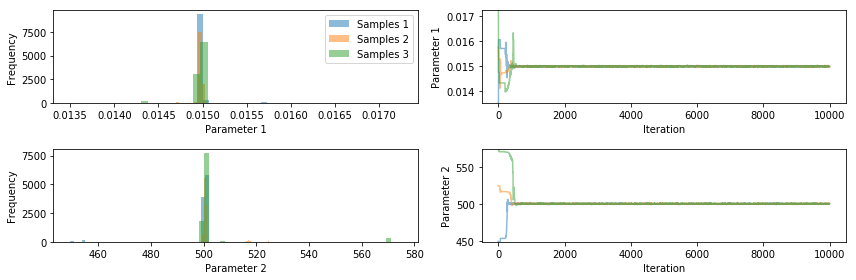

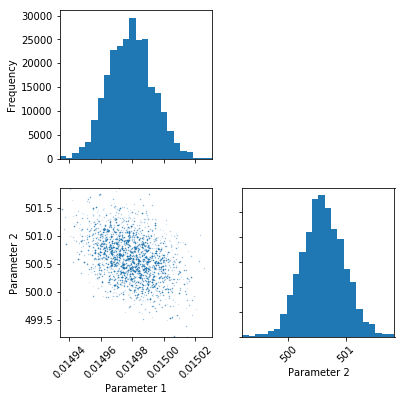

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0031838108325193, 1.0011244205817693]


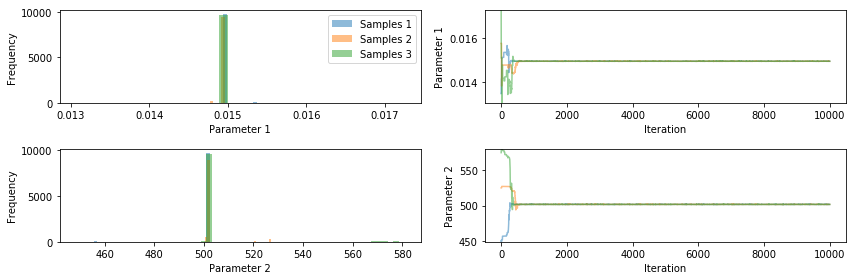

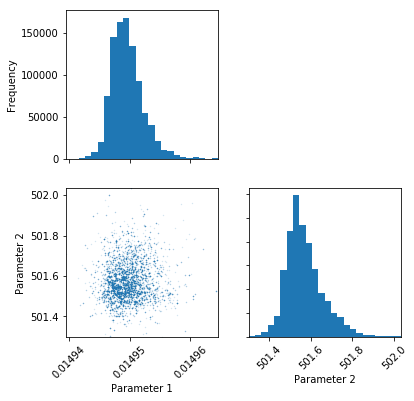

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

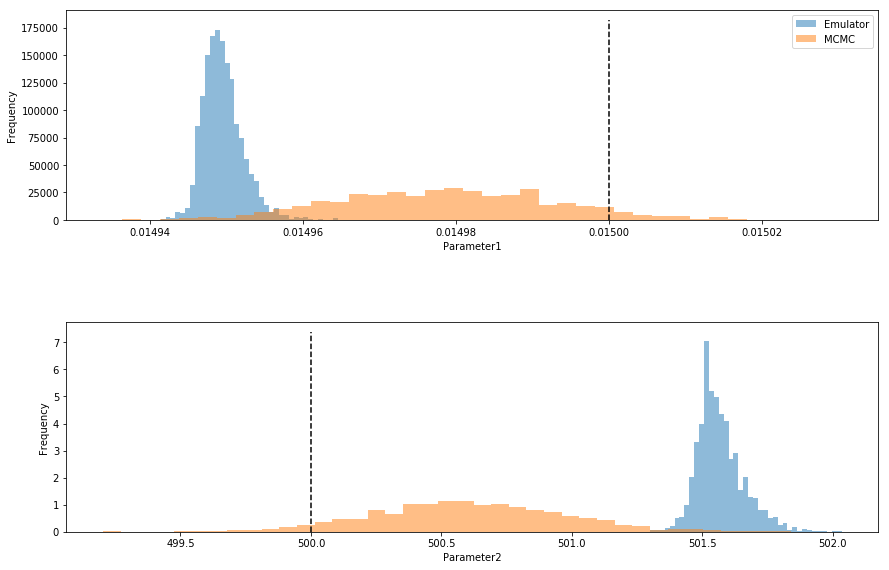

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

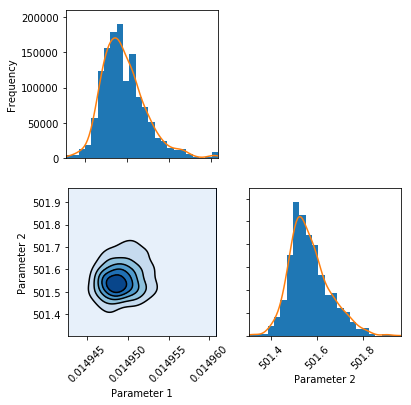

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

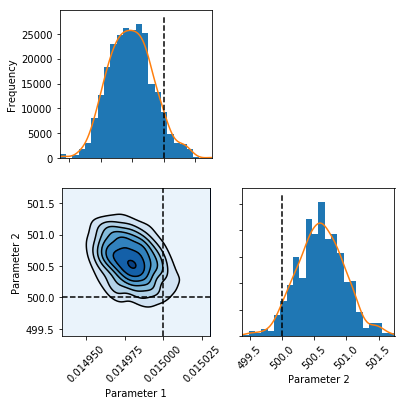

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

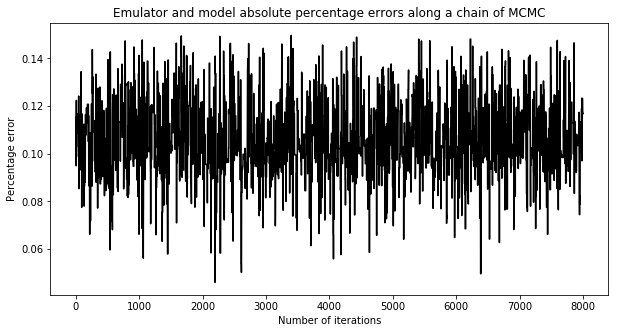

0.1056900765903917

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

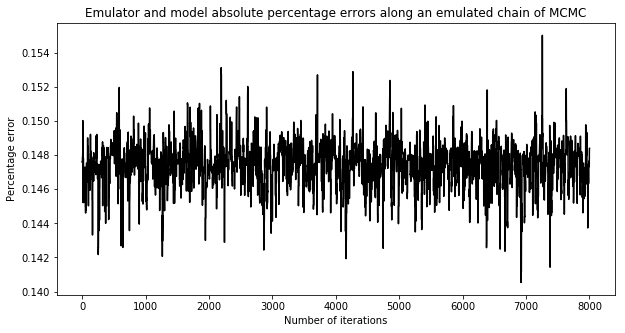

0.14745676418690515

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

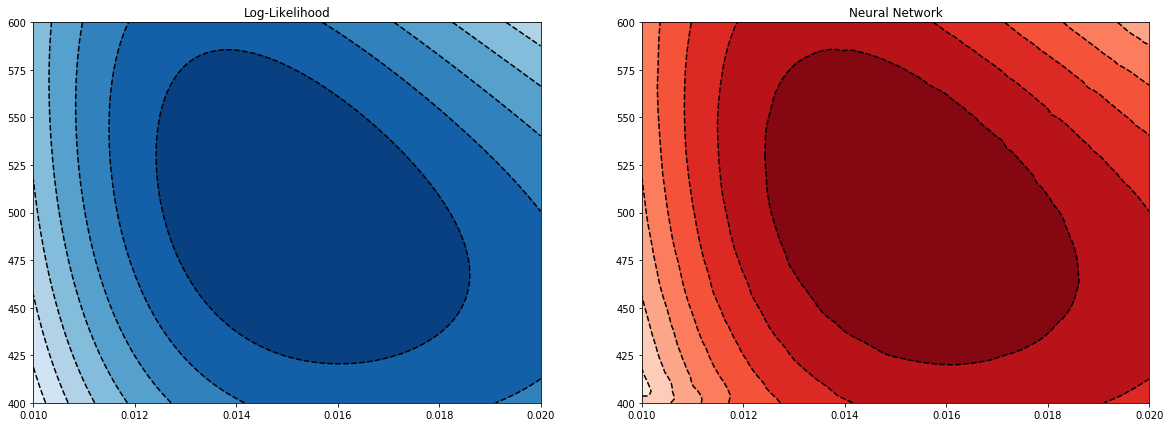

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

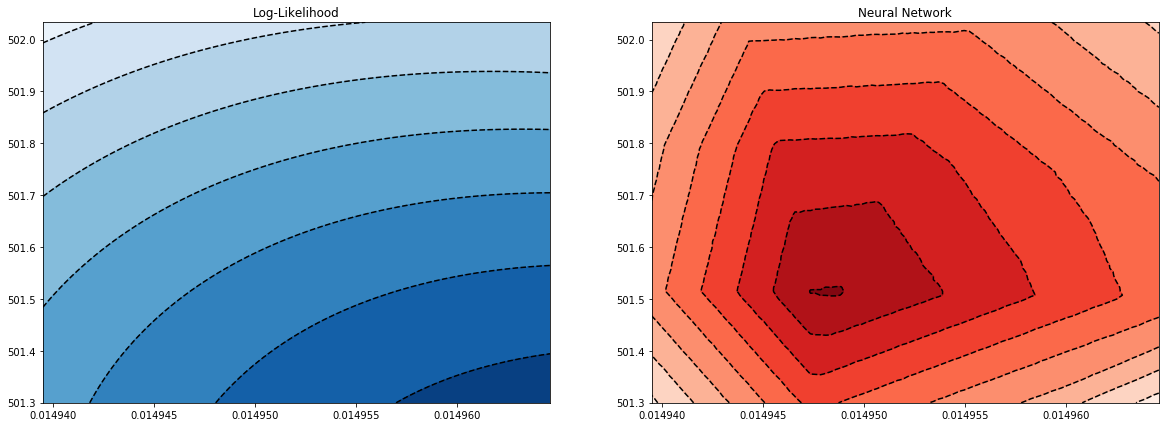

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

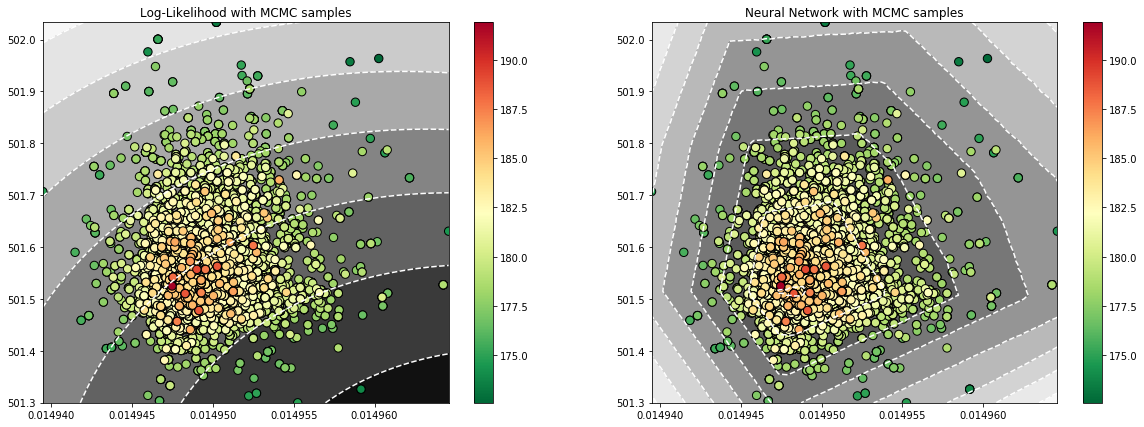

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-1000-5.png", bbox_inches='tight', dpi=600)

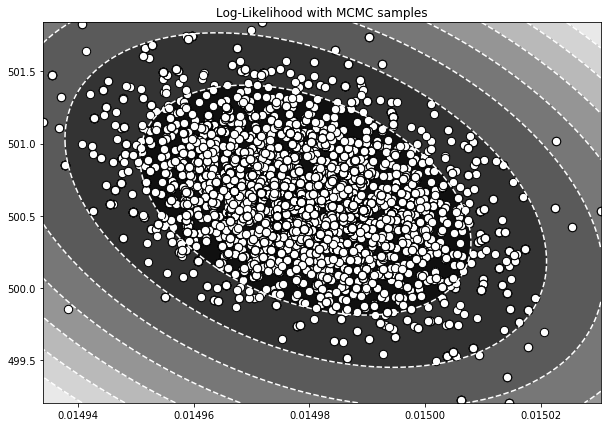

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()